<a href="https://colab.research.google.com/github/sellaoktaviani0210-hub/L3_DL_SELA_41236793/blob/main/T5_DL_DCGAN_SELA_41236793_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

# Konfigurasi agar GPU digunakan secara efisien
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU Terdeteksi: ", physical_devices[0])
else:
    print("Peringatan: GPU tidak terdeteksi. Training akan lambat.")

GPU Terdeteksi:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
# Create the .kaggle directory if it doesn't exist
!mkdir -p ~/.kaggle

# Move the kaggle.json file to the .kaggle directory
# IMPORTANT: Make sure you have uploaded kaggle.json to your Colab session's /content/ directory first.
# If you uploaded it somewhere else, adjust the source path accordingly.
!mv /content/kaggle.json ~/.kaggle/

# Set read-only permissions for the kaggle.json file for security
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle API credentials set up successfully!")

Kaggle API credentials set up successfully!


In [ ]:
# Install kaggle if not already installed
!pip install -q kaggle

# Make sure your Kaggle API credentials (kaggle.json) are set up in ~/.kaggle/
# If you haven't done this, please refer to the previous instructions.

# Download the dataset
!kaggle datasets download -d joosthazelzet/lego-brick-images

# Unzip the downloaded dataset to the specified directory
# The zip file will be downloaded to the current working directory (/content/)
!unzip -q /content/lego-brick-images.zip -d /content/dataset/

# Clean up the zip file after extraction
!rm /content/lego-brick-images.zip

print("Dataset downloaded and extracted to /content/dataset/")

Dataset URL: https://www.kaggle.com/datasets/joosthazelzet/lego-brick-images
License(s): GPL-2.0
 99% 0.99G/1.00G [00:12<00:00, 240MB/s]
100% 1.00G/1.00G [00:12<00:00, 86.4MB/s]
Dataset downloaded and extracted to /content/dataset/


In [ ]:
# Parameter Konfigurasi
BATCH_SIZE = 64
IMG_HEIGHT = 64  # Menggunakan 64x64 agar detail LEGO cukup terlihat
IMG_WIDTH = 64
CHANNELS = 3     # RGB


# --- OPSI B: Membuat Dataset Loader ---
# Ganti 'path/to/images' dengan path folder dataset Anda
dataset_dir = '/content/dataset/LEGO brick images v1'

# Jika folder kosong/tidak ada, kita buat dummy data agar kode tetap jalan (untuk testing)
if not os.path.exists(dataset_dir) or not os.listdir(dataset_dir):
    print("Dataset tidak ditemukan. Membuat data dummy untuk demonstrasi struktur kode.")
    os.makedirs(dataset_dir, exist_ok=True)
    # Membuat 100 gambar random noise sebagai placeholder
    for i in range(100):
        img = np.random.randint(0, 255, (64, 64, 3), dtype=np.uint8)
        tf.keras.utils.save_img(f"{dataset_dir}/dummy_{i}.png", img)

# Memuat dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    label_mode=None, # Kita tidak butuh label untuk GAN
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Normalisasi ke [-1, 1]
train_dataset = train_dataset.map(lambda x: (x - 127.5) / 127.5)

# Optimasi performa (Caching & Prefetching)
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 6379 files.


In [ ]:
latent_dim = 128

def build_generator():
    model = keras.Sequential(name="generator")

    # Input: Latent Vector
    # Mulai dengan dense layer yang cukup besar untuk di-reshape
    # Kita ingin mulai dari ukuran 8x8 dengan 512 filter
    model.add(layers.Dense(8 * 8 * 512, use_bias=False, input_shape=(latent_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Reshape menjadi tensor 3D
    model.add(layers.Reshape((8, 8, 512)))

    # Upsampling 1: 8x8 -> 16x16
    model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsampling 2: 16x16 -> 32x32
    model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Upsampling 3: 32x32 -> 64x64
    model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Output Layer: 64x64 -> 64x64x3 (RGB)
    # Aktivasi TANH penting agar output di range [-1, 1]
    model.add(layers.Conv2D(CHANNELS, (3, 3), padding='same', activation='tanh'))

    return model

def build_discriminator():
    model = keras.Sequential(name="discriminator")

    # Input: Gambar 64x64x3
    # Downsampling 1: 64 -> 32
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, CHANNELS)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Downsampling 2: 32 -> 16
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Downsampling 3: 16 -> 8
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    # Flatten dan Output
    model.add(layers.Flatten())
    model.add(layers.Dense(1)) # Output berupa logit (skor real/fake)

    return model

# Inisialisasi Model
generator = build_generator()
discriminator = build_discriminator()

generator.summary()
# discriminator.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32768)          │     4,194,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32768)          │       131,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 256)    │     2,097,152 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 128)    │       524,288 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 64, 64, 64)     │       131,072 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 64, 3)      │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,081,411 (27.01 MB)

 Trainable params: 7,014,979 (26.76 MB)

 Non-trainable params: 66,432 (259.50 KB)

In [ ]:
class DCGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        # Metric trackers
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # 1. Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 2. Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # 3. Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # 4. Assemble labels discriminating real from fake images
        # Label 1 untuk fake, 0 untuk real (atau sebaliknya, teknik ini menggunakan label smoothing)
        # Di sini kita pakai standar: 1=Real, 0=Fake.
        # Namun, karena kita concat [Fake, Real], maka labelnya: [0...0, 1...1]
        labels = tf.concat(
            [tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0
        )

        # Tambahkan sedikit noise pada label (Label Smoothing) untuk stabilitas
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # 5. Train the Discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # 6. Sample random points in the latent space (lagi, untuk Generator)
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # 7. Assemble labels that say "all real images" (We want to fool the discriminator)
        misleading_labels = tf.ones((batch_size, 1))

        # 8. Train the Generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 127.5
        generated_images += 127.5
        generated_images.numpy()

        fig = plt.figure(figsize=(10, 4))
        for i in range(self.num_img):
            plt.subplot(1, self.num_img, i+1)
            img = keras.utils.array_to_img(generated_images[i])
            plt.imshow(img)
            plt.axis('off')

        plt.suptitle(f"Epoch {epoch+1}")
        plt.show() # Tampilkan inline di Colab

        # Opsional: Simpan ke file
        # plt.savefig(f"generated_lego_epoch_{epoch}.png")
        # plt.close()

Mulai Training...
Epoch 1/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - d_loss: 0.4931 - g_loss: 0.7134

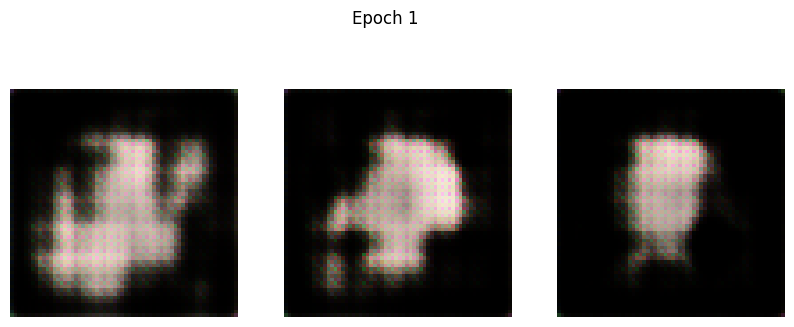

100/100 ━━━━━━━━━━━━━━━━━━━━ 42s 213ms/step - d_loss: 0.4937 - g_loss: 0.7135
Epoch 2/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - d_loss: 0.6788 - g_loss: 0.7132

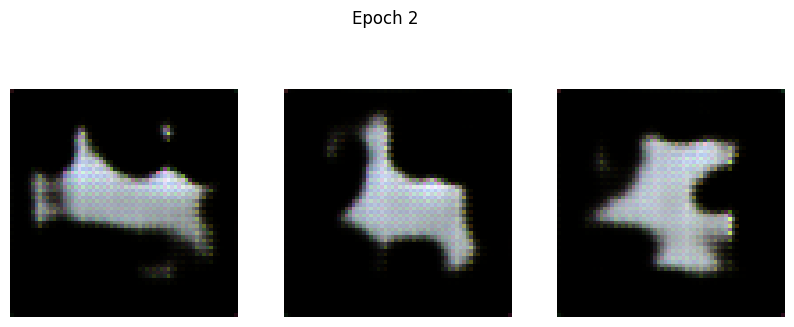

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 120ms/step - d_loss: 0.6788 - g_loss: 0.7133
Epoch 3/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.6751 - g_loss: 0.7125

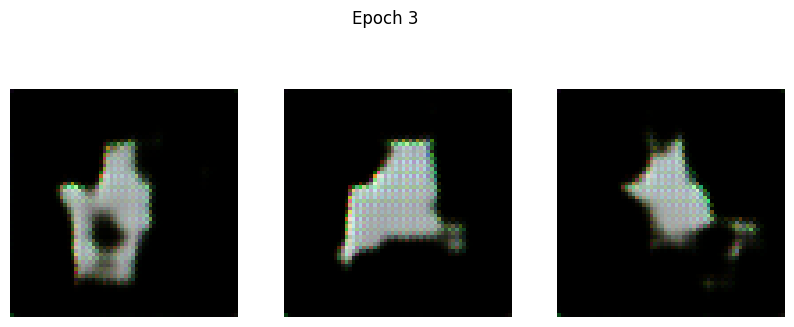

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.6751 - g_loss: 0.7126
Epoch 4/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.6649 - g_loss: 0.7367

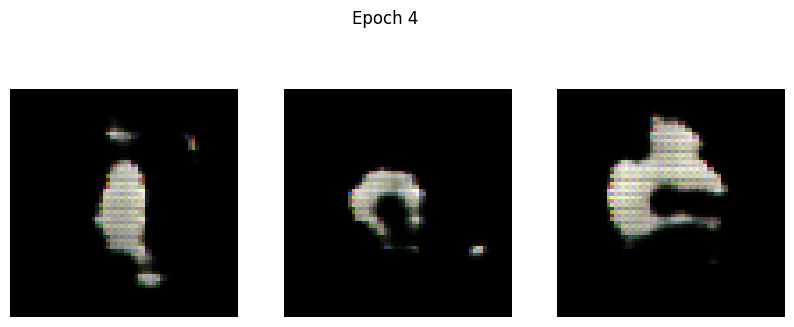

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.6649 - g_loss: 0.7369
Epoch 5/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.6559 - g_loss: 0.8218

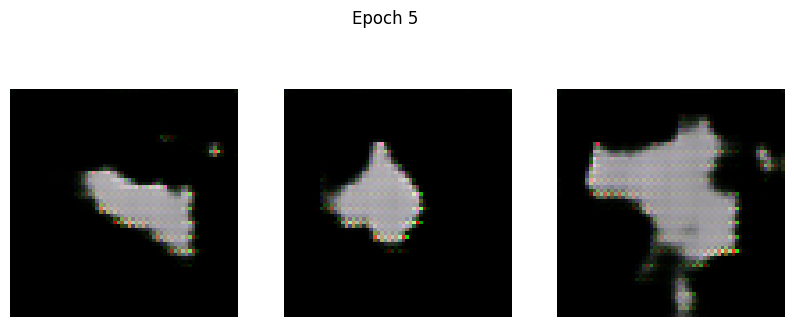

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.6560 - g_loss: 0.8218
Epoch 6/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.6469 - g_loss: 0.7686

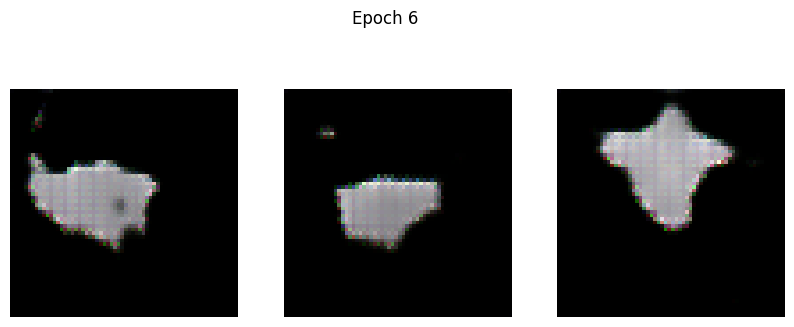

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.6469 - g_loss: 0.7690
Epoch 7/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6588 - g_loss: 0.8121

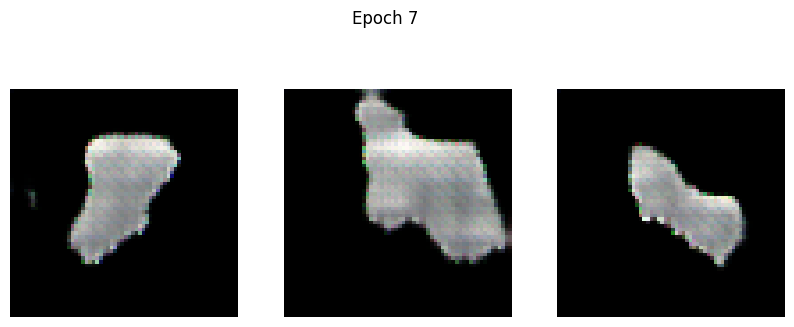

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6588 - g_loss: 0.8119
Epoch 8/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6624 - g_loss: 0.7596

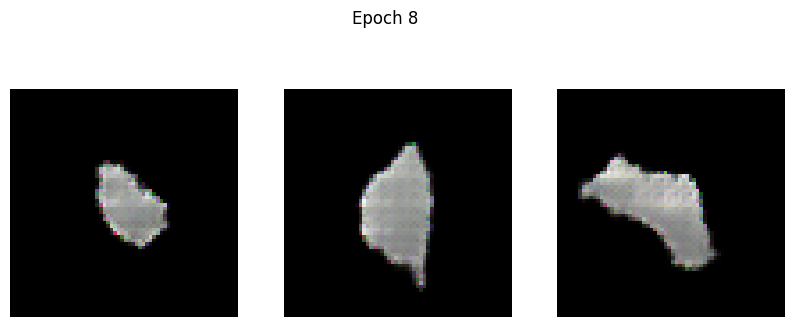

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.6624 - g_loss: 0.7595
Epoch 9/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6531 - g_loss: 0.7405

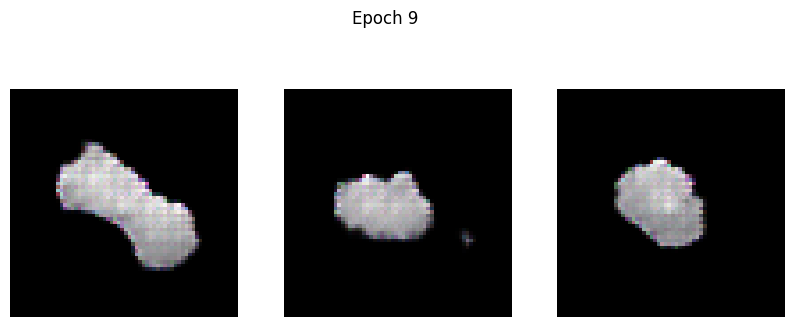

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6531 - g_loss: 0.7407
Epoch 10/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6527 - g_loss: 0.7548

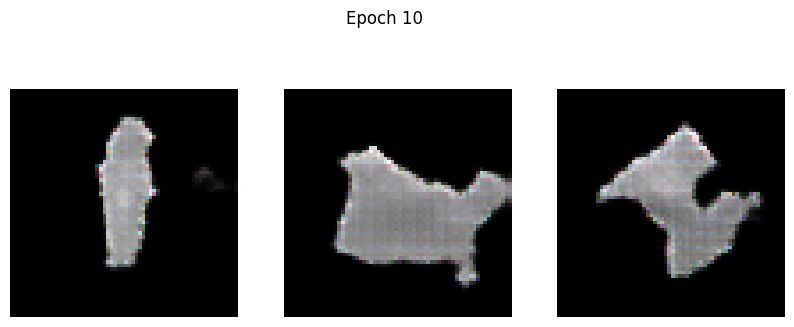

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6527 - g_loss: 0.7548
Epoch 11/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.6597 - g_loss: 0.7575

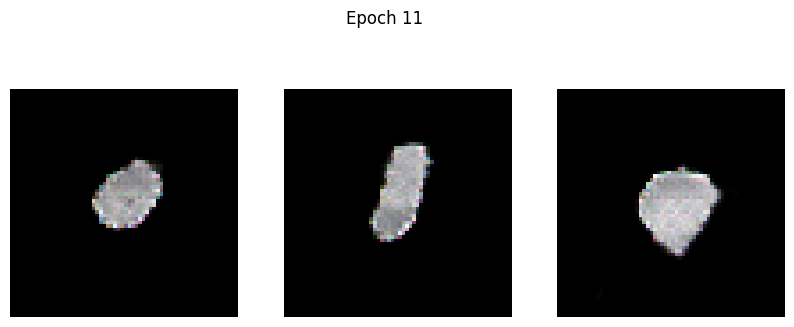

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6596 - g_loss: 0.7576
Epoch 12/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.6411 - g_loss: 0.7769

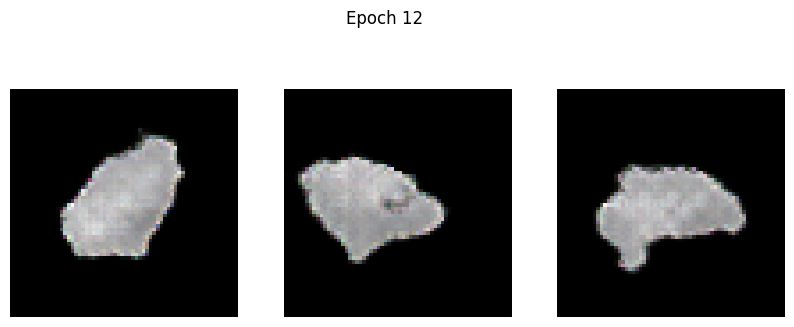

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6411 - g_loss: 0.7770
Epoch 13/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6247 - g_loss: 0.8536

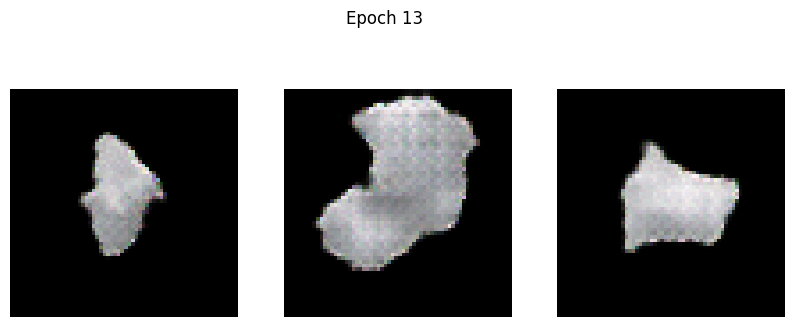

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6247 - g_loss: 0.8536
Epoch 14/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6173 - g_loss: 0.8533

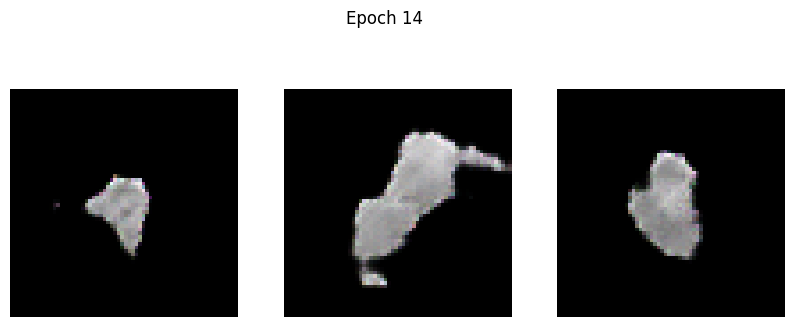

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6172 - g_loss: 0.8535
Epoch 15/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6170 - g_loss: 0.9001

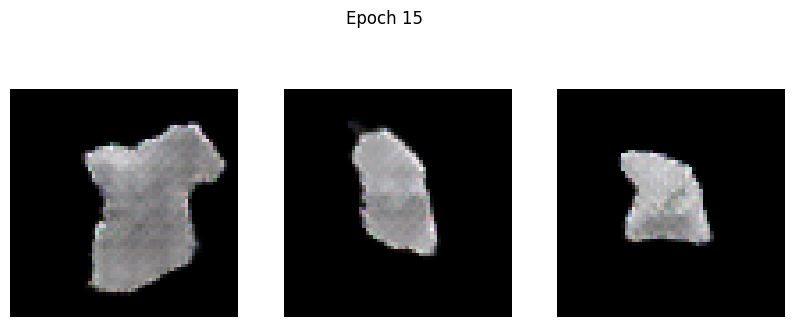

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6169 - g_loss: 0.8999
Epoch 16/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5908 - g_loss: 0.8648

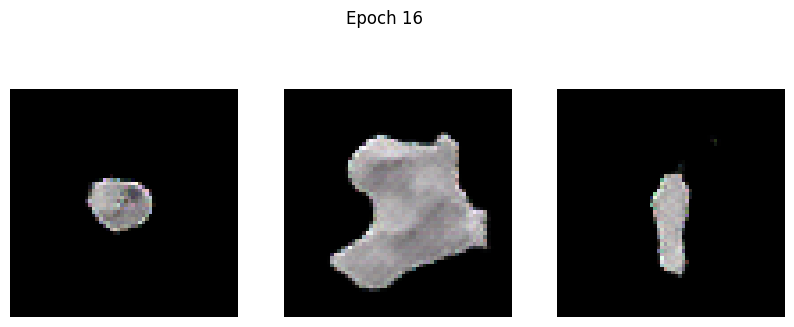

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5909 - g_loss: 0.8649
Epoch 17/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5950 - g_loss: 0.8949

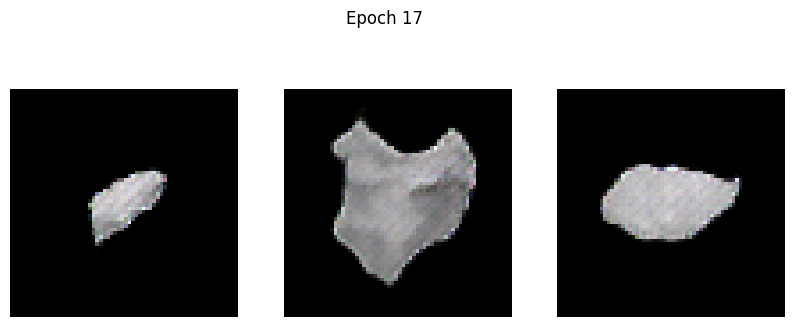

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5950 - g_loss: 0.8950
Epoch 18/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5733 - g_loss: 0.9198

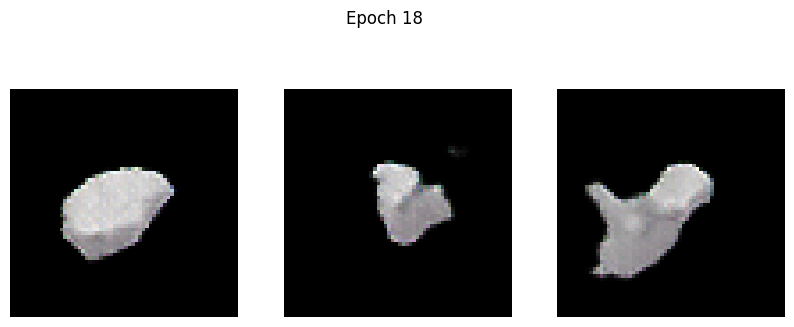

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5734 - g_loss: 0.9199
Epoch 19/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5931 - g_loss: 1.0582

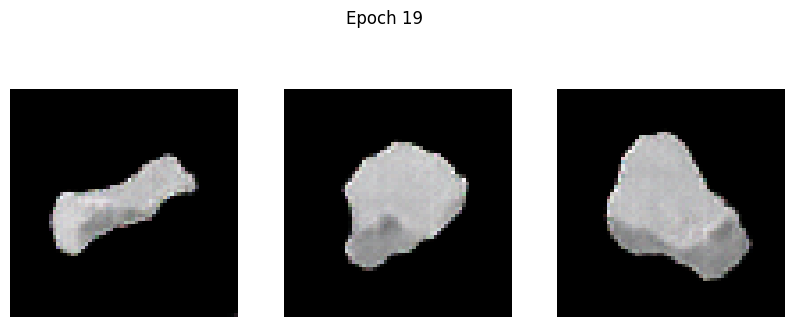

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5931 - g_loss: 1.0579
Epoch 20/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5409 - g_loss: 0.9550

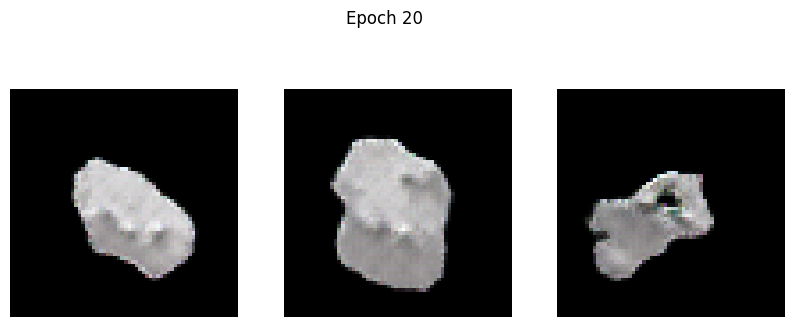

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5409 - g_loss: 0.9552
Epoch 21/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5250 - g_loss: 1.0202

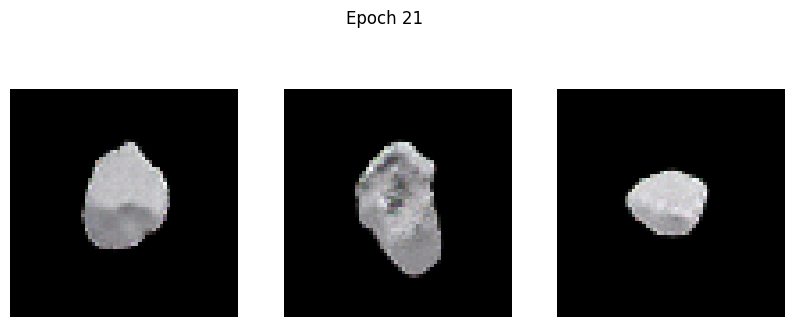

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5251 - g_loss: 1.0205
Epoch 22/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5114 - g_loss: 1.0934

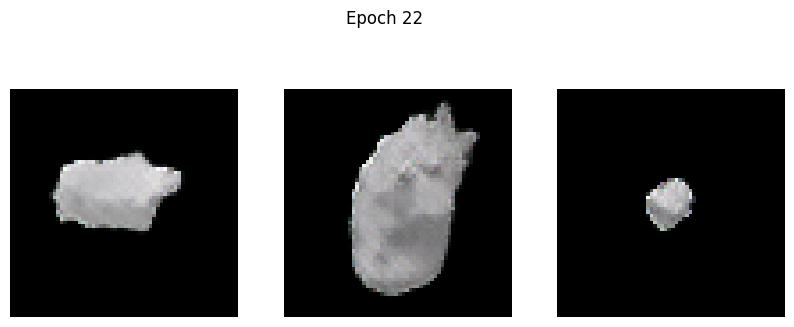

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5116 - g_loss: 1.0936
Epoch 23/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5023 - g_loss: 1.1202

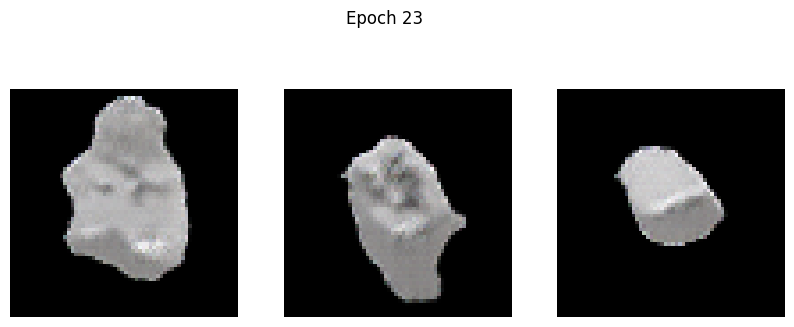

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5023 - g_loss: 1.1202
Epoch 24/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4969 - g_loss: 1.1752

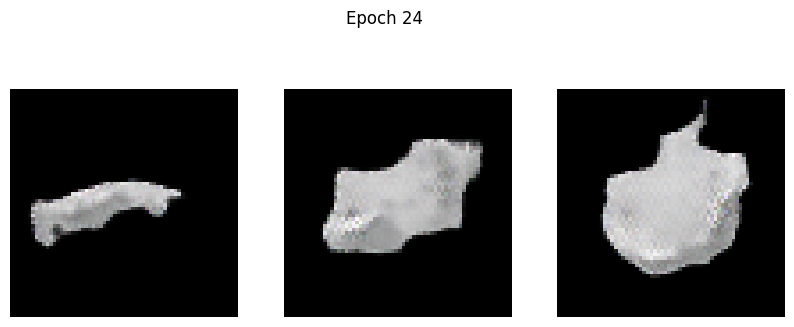

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4969 - g_loss: 1.1753
Epoch 25/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.6414 - g_loss: 1.4535

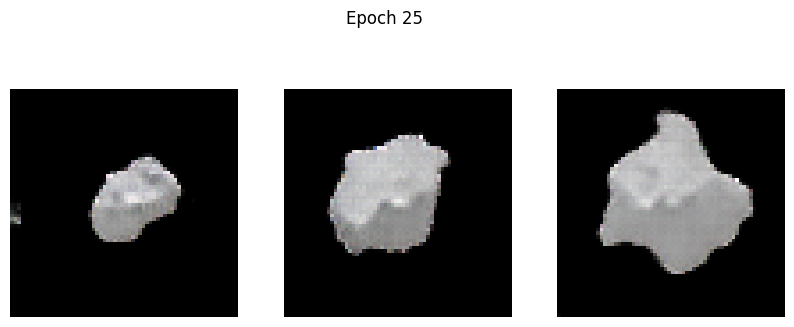

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.6416 - g_loss: 1.4528
Epoch 26/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4786 - g_loss: 1.0833

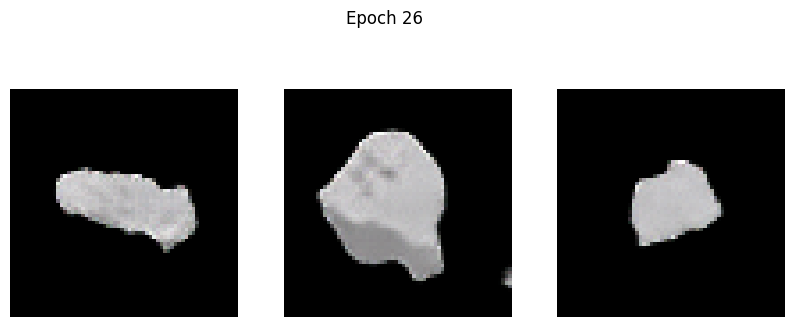

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4785 - g_loss: 1.0833
Epoch 27/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4642 - g_loss: 1.1375

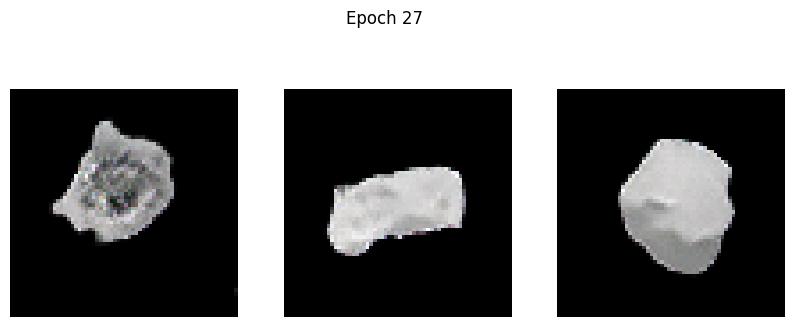

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4642 - g_loss: 1.1378
Epoch 28/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4523 - g_loss: 1.2370

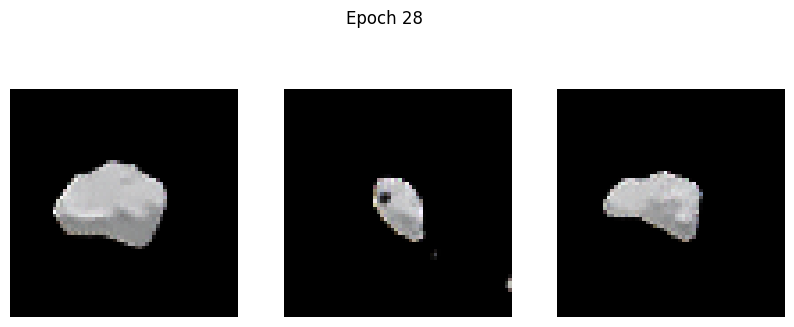

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4523 - g_loss: 1.2370
Epoch 29/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4504 - g_loss: 1.3006

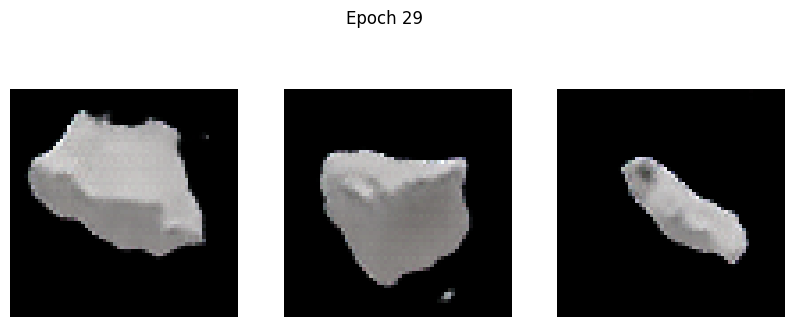

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4504 - g_loss: 1.3005
Epoch 30/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4448 - g_loss: 1.3466

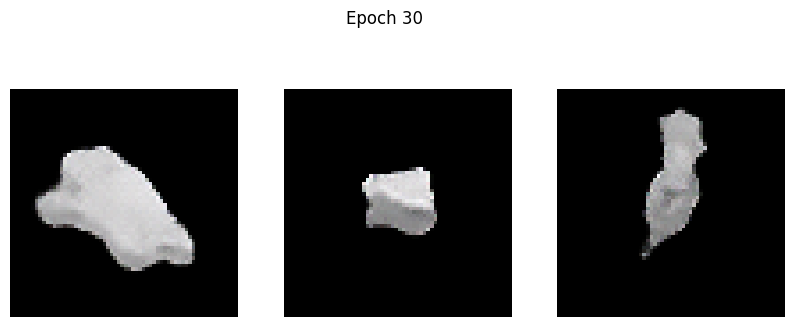

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4448 - g_loss: 1.3464
Epoch 31/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.5104 - g_loss: 1.5498

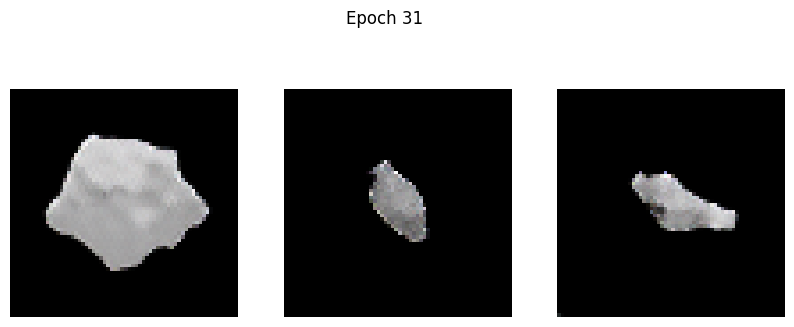

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5098 - g_loss: 1.5486
Epoch 32/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4106 - g_loss: 1.3569

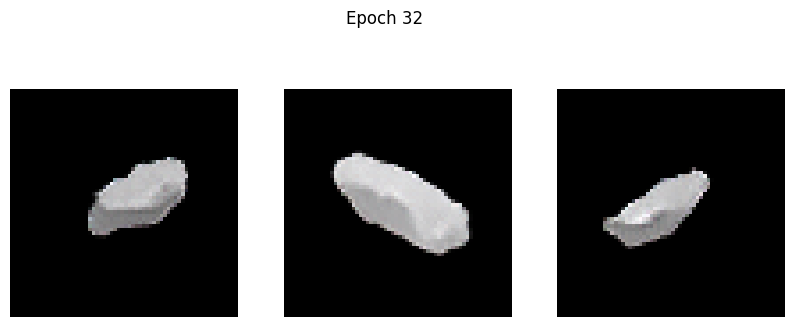

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4107 - g_loss: 1.3572
Epoch 33/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4154 - g_loss: 1.4075

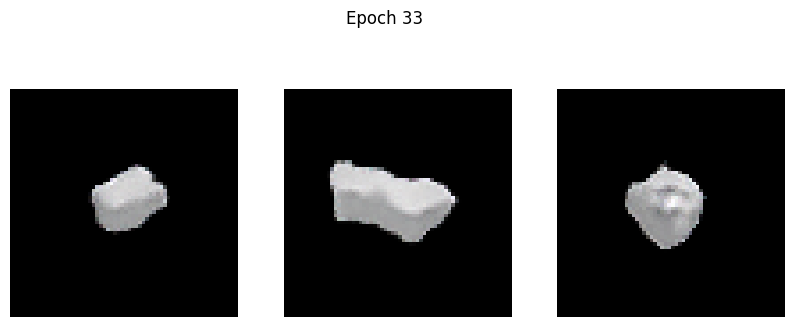

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4154 - g_loss: 1.4075
Epoch 34/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3930 - g_loss: 1.4316

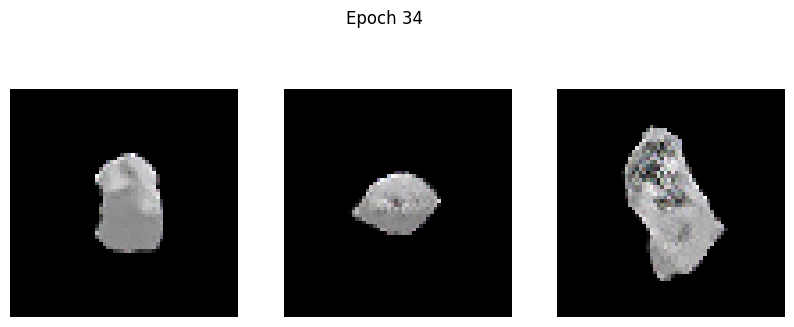

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3931 - g_loss: 1.4319
Epoch 35/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4002 - g_loss: 1.4754

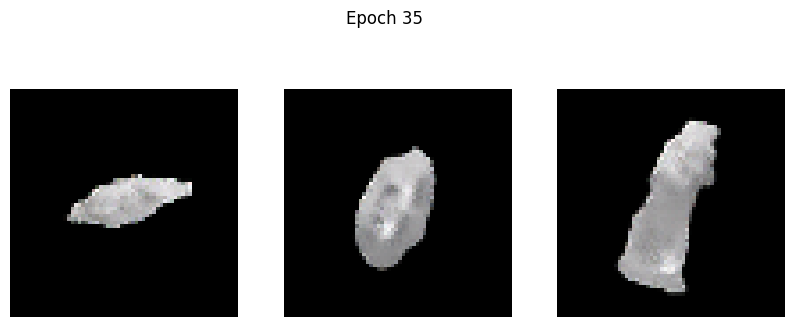

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4002 - g_loss: 1.4756
Epoch 36/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4117 - g_loss: 1.5382

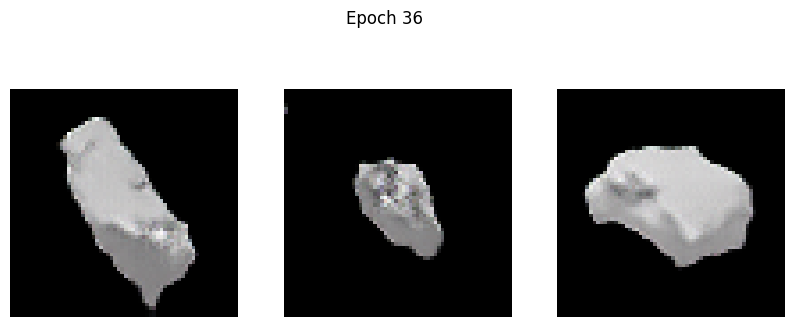

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4119 - g_loss: 1.5380
Epoch 37/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3595 - g_loss: 1.4740

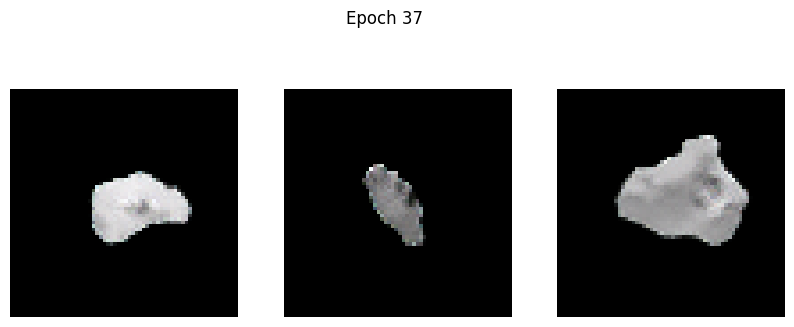

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.3596 - g_loss: 1.4742
Epoch 38/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4392 - g_loss: 1.6562

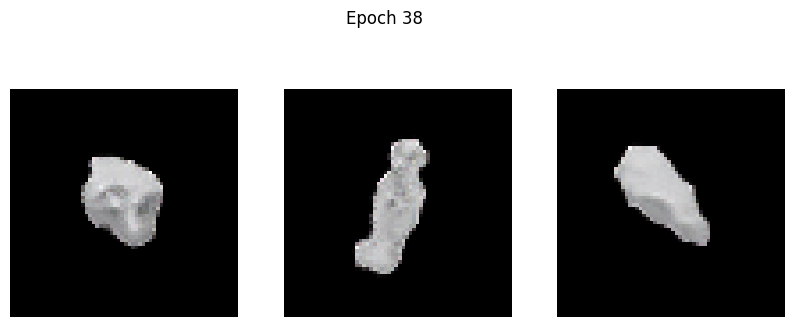

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4390 - g_loss: 1.6558
Epoch 39/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3679 - g_loss: 1.5741

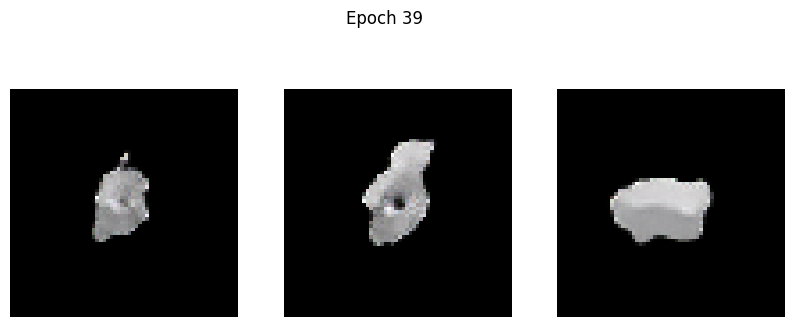

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3678 - g_loss: 1.5741
Epoch 40/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3726 - g_loss: 1.6506

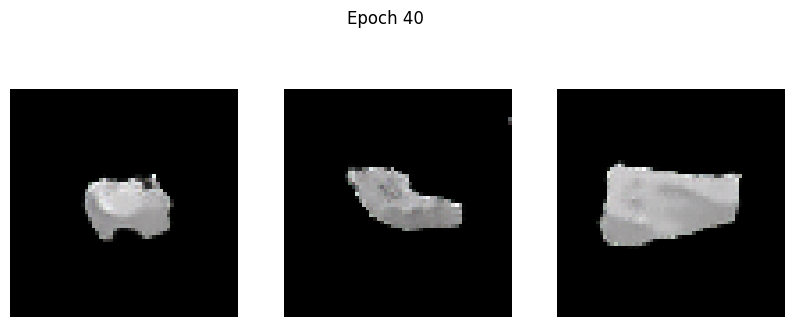

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.3728 - g_loss: 1.6510
Epoch 41/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3436 - g_loss: 1.6628

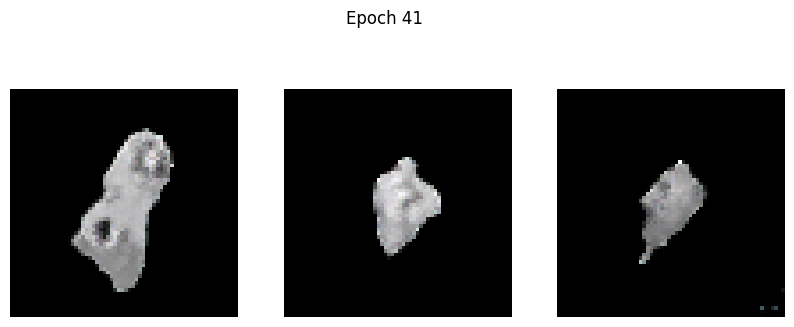

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 121ms/step - d_loss: 0.3437 - g_loss: 1.6627
Epoch 42/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3730 - g_loss: 1.6793

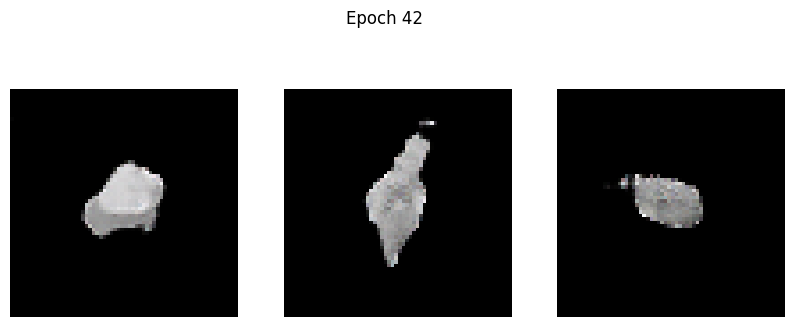

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3731 - g_loss: 1.6796
Epoch 43/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3552 - g_loss: 1.6701

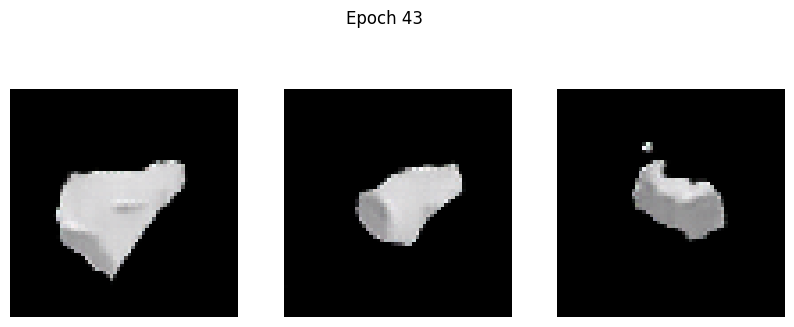

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3552 - g_loss: 1.6703
Epoch 44/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3224 - g_loss: 1.6754

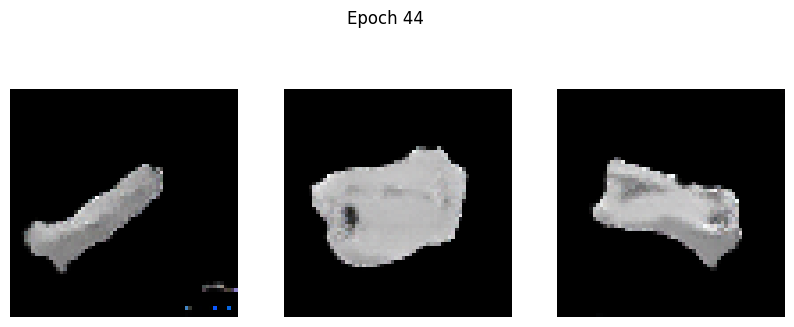

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3224 - g_loss: 1.6758
Epoch 45/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3435 - g_loss: 1.8403

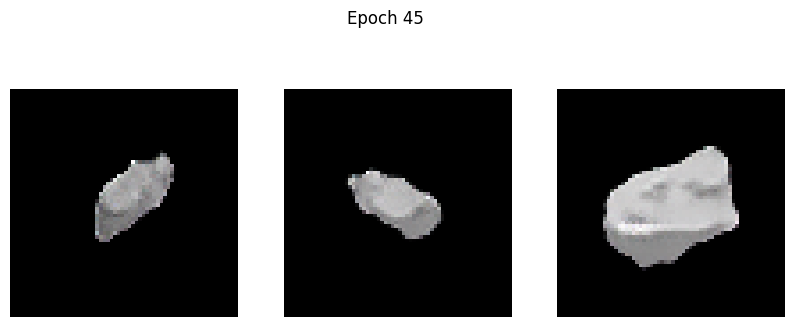

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3435 - g_loss: 1.8400
Epoch 46/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3322 - g_loss: 1.8034

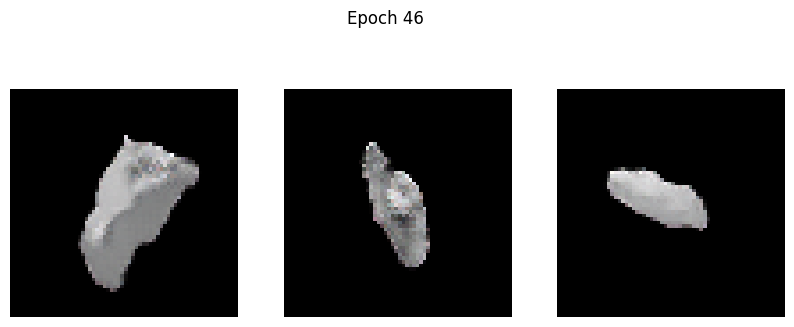

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3322 - g_loss: 1.8036
Epoch 47/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4409 - g_loss: 1.8937

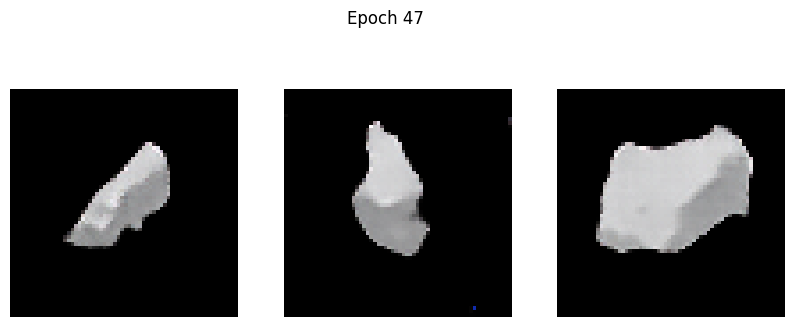

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4402 - g_loss: 1.8927
Epoch 48/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3416 - g_loss: 1.8455

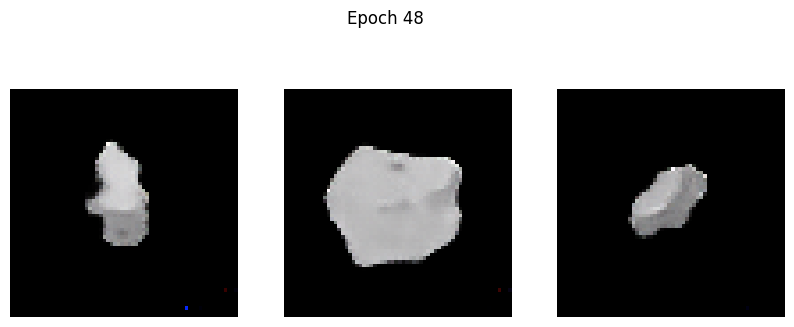

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3416 - g_loss: 1.8456
Epoch 49/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3054 - g_loss: 1.8473

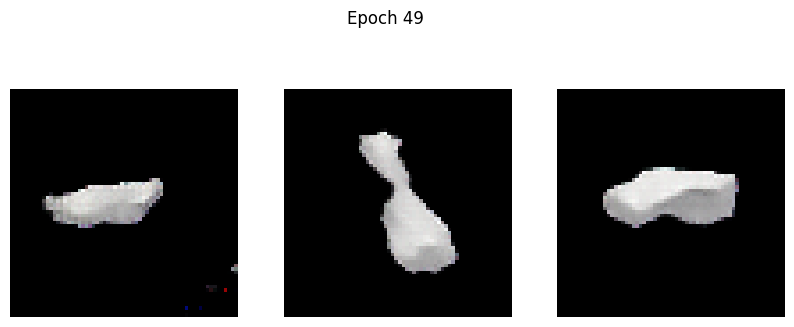

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3059 - g_loss: 1.8482
Epoch 50/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4055 - g_loss: 2.0491

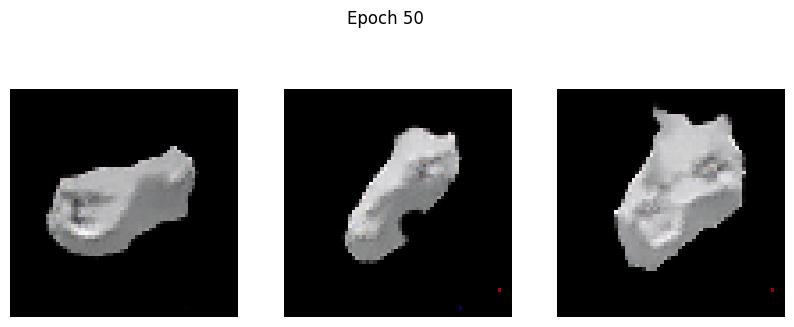

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4048 - g_loss: 2.0472
Epoch 51/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2877 - g_loss: 1.8568

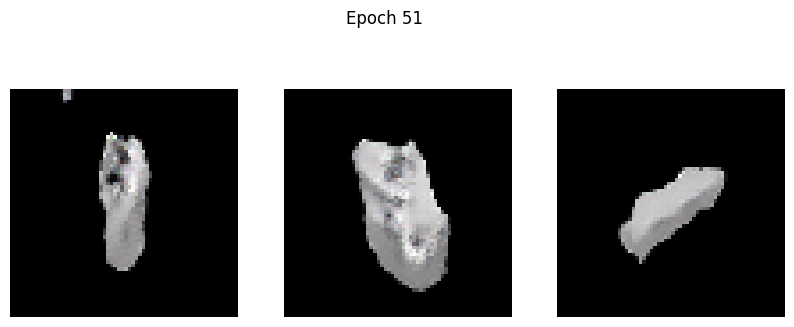

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2879 - g_loss: 1.8571
Epoch 52/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2943 - g_loss: 1.9396

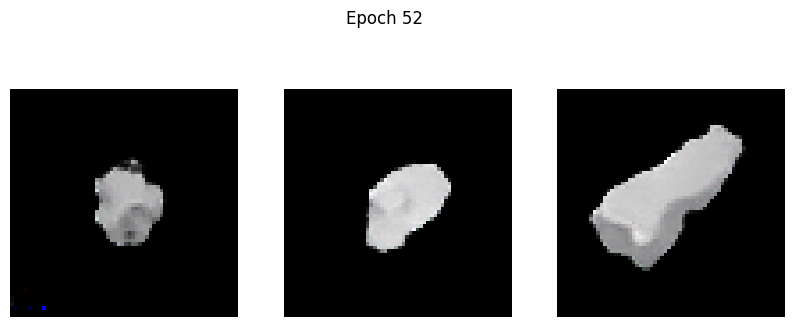

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2943 - g_loss: 1.9398
Epoch 53/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2984 - g_loss: 1.9365

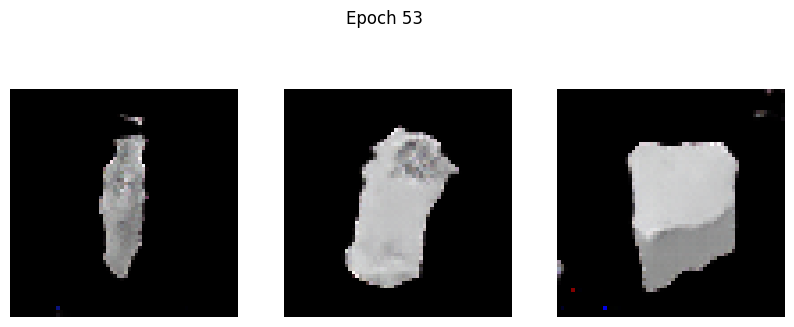

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2984 - g_loss: 1.9366
Epoch 54/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4863 - g_loss: 2.1770

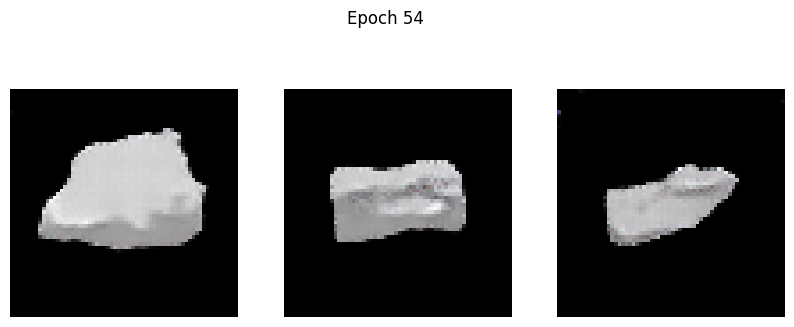

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4865 - g_loss: 2.1758
Epoch 55/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3076 - g_loss: 1.7250

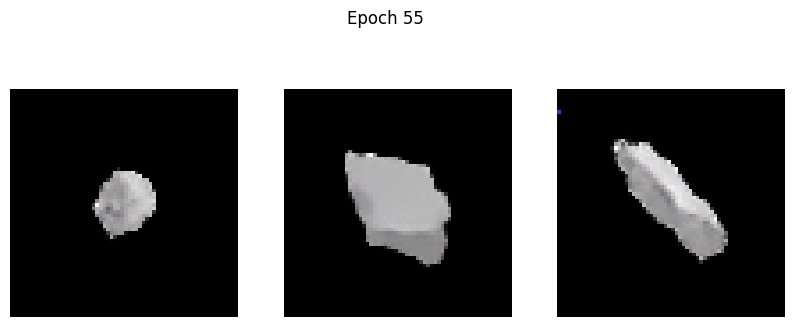

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3075 - g_loss: 1.7251
Epoch 56/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2748 - g_loss: 1.8840

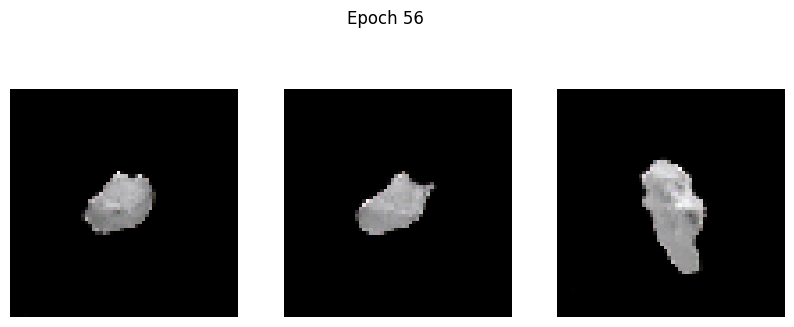

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2750 - g_loss: 1.8843
Epoch 57/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3567 - g_loss: 1.8961

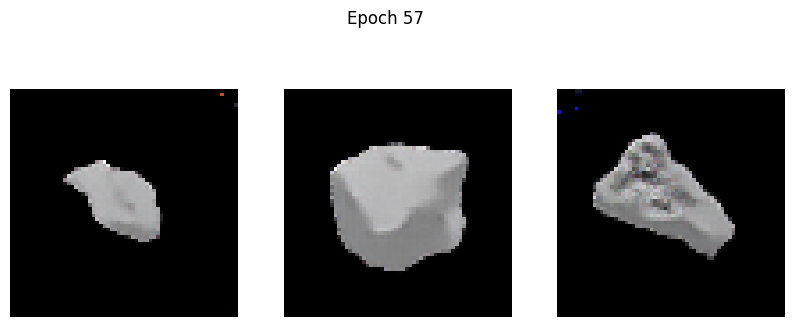

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3562 - g_loss: 1.8960
Epoch 58/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3369 - g_loss: 2.0107

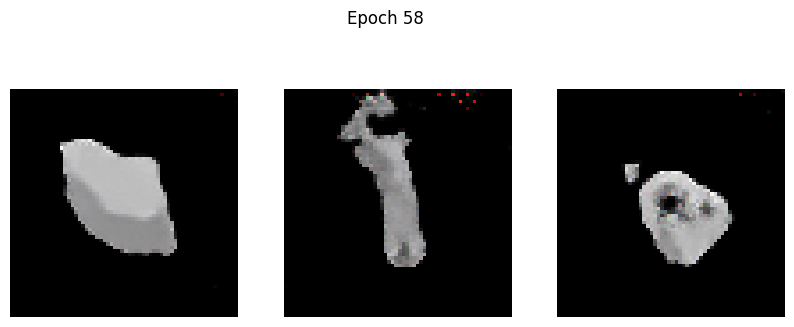

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3368 - g_loss: 2.0102
Epoch 59/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3521 - g_loss: 2.0042

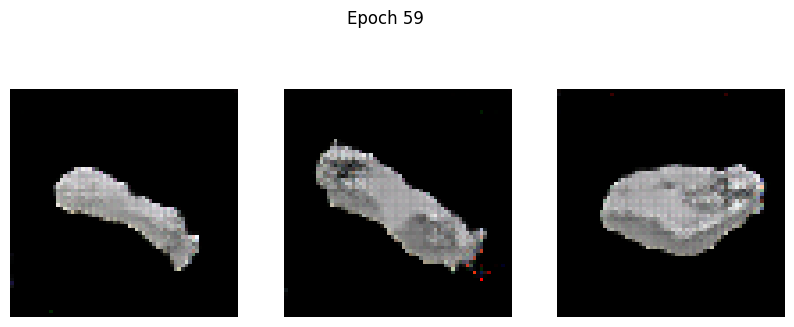

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3535 - g_loss: 2.0073
Epoch 60/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4427 - g_loss: 1.7965

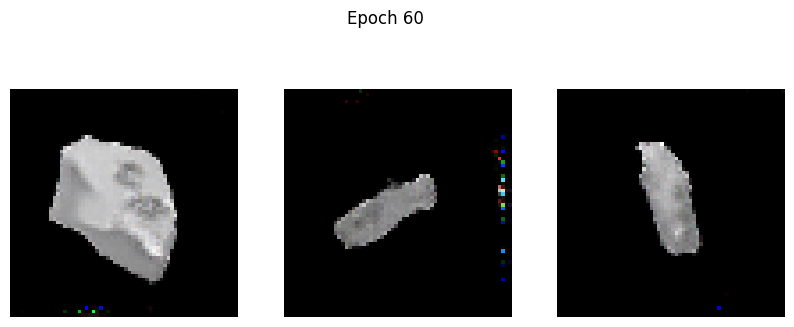

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.4419 - g_loss: 1.7961
Epoch 61/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3737 - g_loss: 1.8716

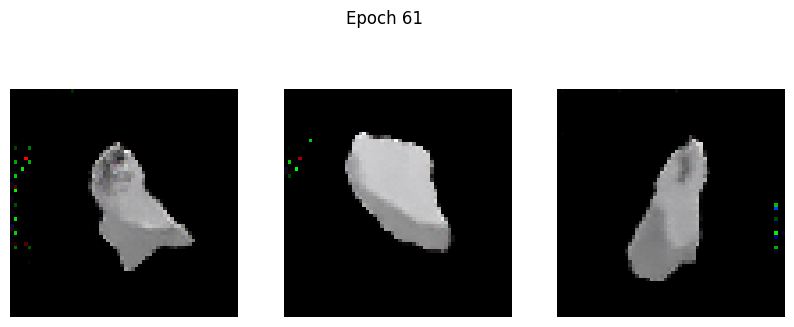

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3738 - g_loss: 1.8714
Epoch 62/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2904 - g_loss: 1.8208

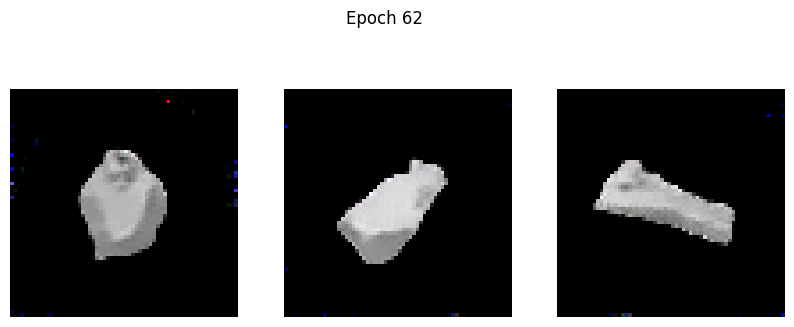

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2904 - g_loss: 1.8209
Epoch 63/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3052 - g_loss: 1.8661

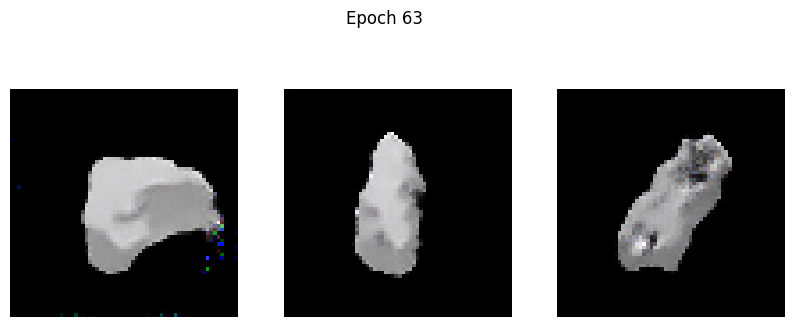

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.3052 - g_loss: 1.8659
Epoch 64/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3261 - g_loss: 1.9572

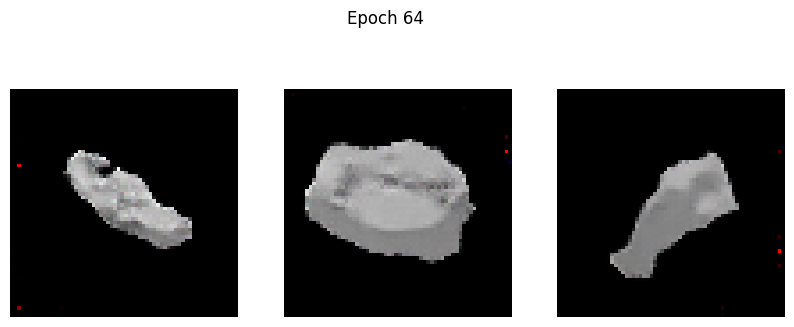

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3260 - g_loss: 1.9567
Epoch 65/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.5063 - g_loss: 2.2843

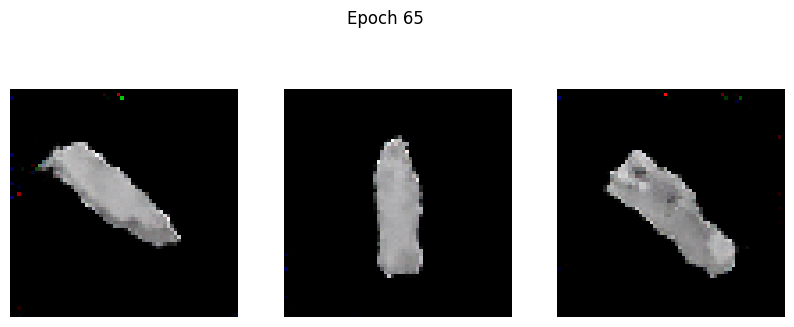

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5056 - g_loss: 2.2820
Epoch 66/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2649 - g_loss: 1.8191

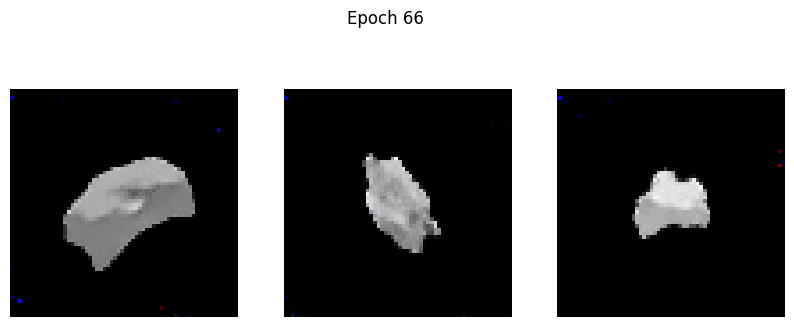

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2650 - g_loss: 1.8192
Epoch 67/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2902 - g_loss: 1.9472

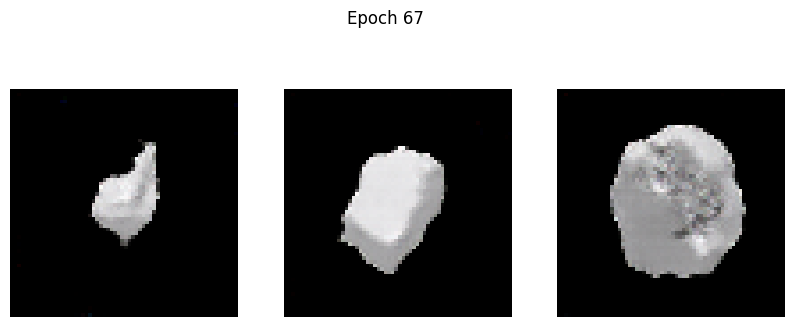

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2901 - g_loss: 1.9472
Epoch 68/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2863 - g_loss: 2.0036

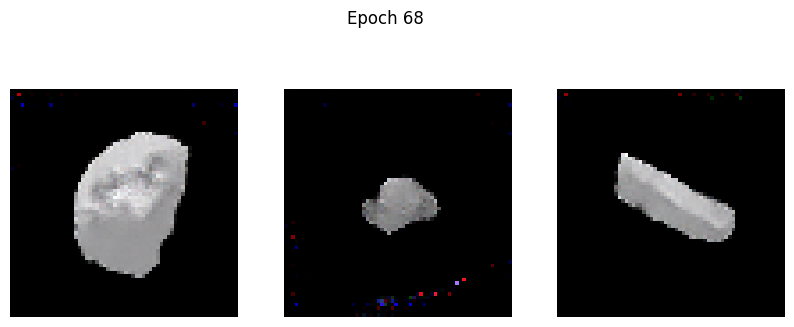

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2866 - g_loss: 2.0037
Epoch 69/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2795 - g_loss: 1.9448

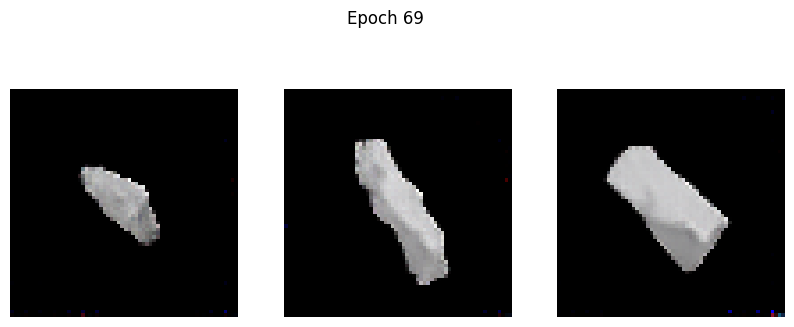

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2798 - g_loss: 1.9447
Epoch 70/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2754 - g_loss: 1.9582

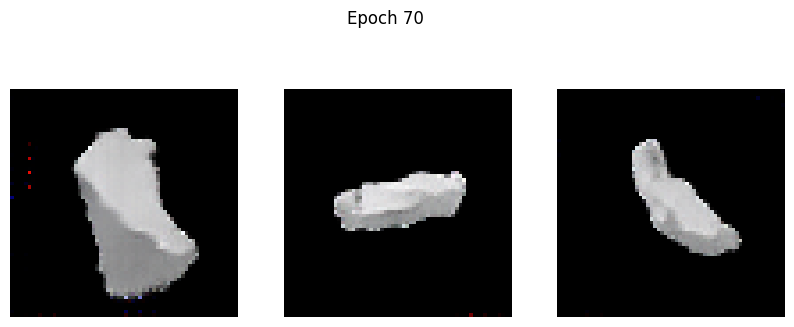

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2755 - g_loss: 1.9585
Epoch 71/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2711 - g_loss: 2.0374

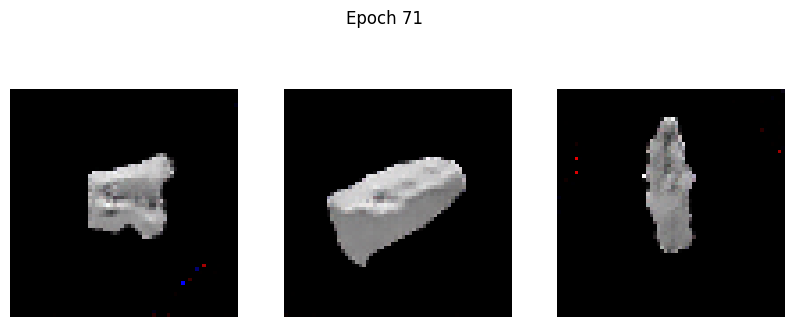

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2712 - g_loss: 2.0373
Epoch 72/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2837 - g_loss: 2.0298

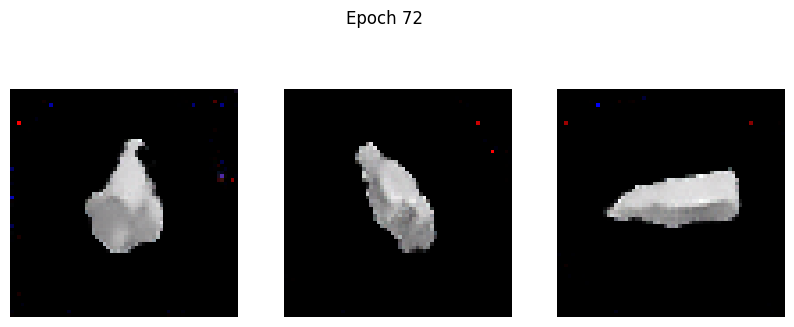

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2837 - g_loss: 2.0298
Epoch 73/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2834 - g_loss: 2.0998

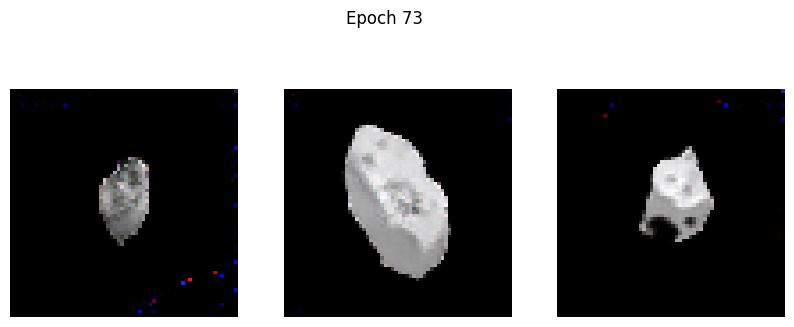

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2835 - g_loss: 2.1000
Epoch 74/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2499 - g_loss: 2.0669

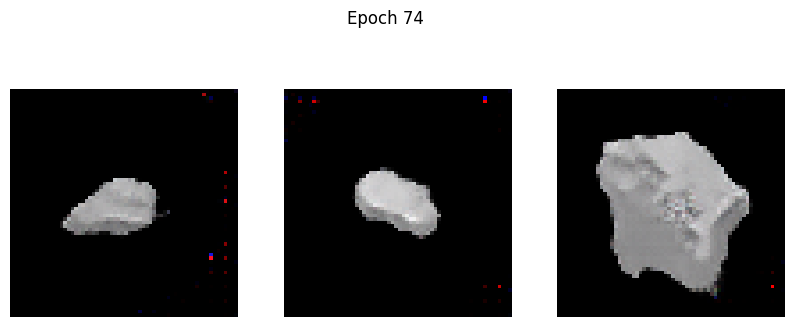

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.2502 - g_loss: 2.0672
Epoch 75/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2400 - g_loss: 2.0938

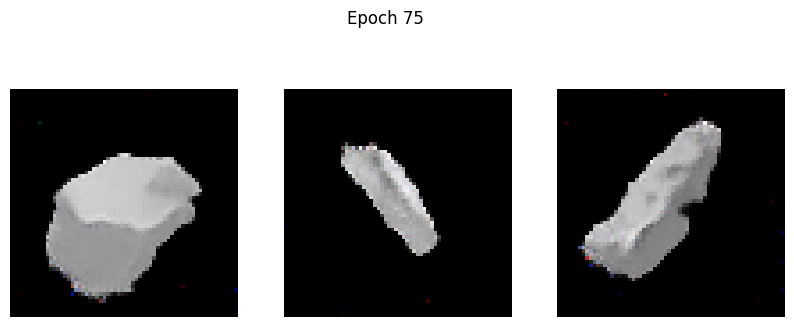

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2400 - g_loss: 2.0935
Epoch 76/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3154 - g_loss: 2.2069

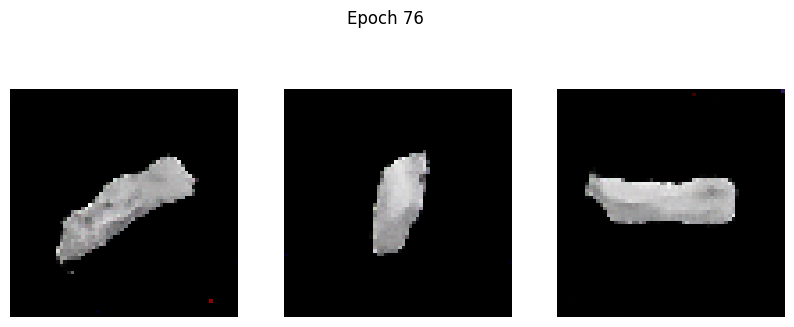

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3152 - g_loss: 2.2064
Epoch 77/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2740 - g_loss: 2.1163

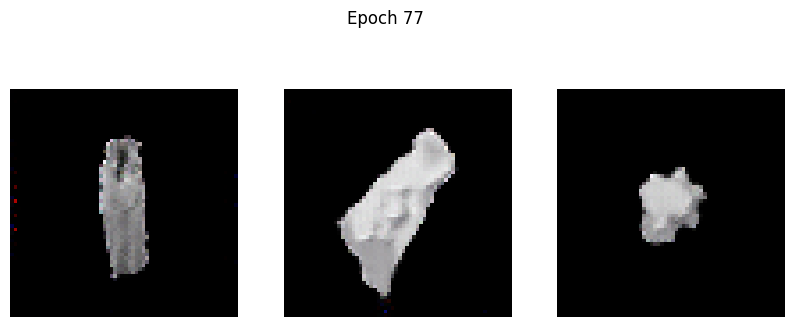

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2745 - g_loss: 2.1178
Epoch 78/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4766 - g_loss: 2.0841

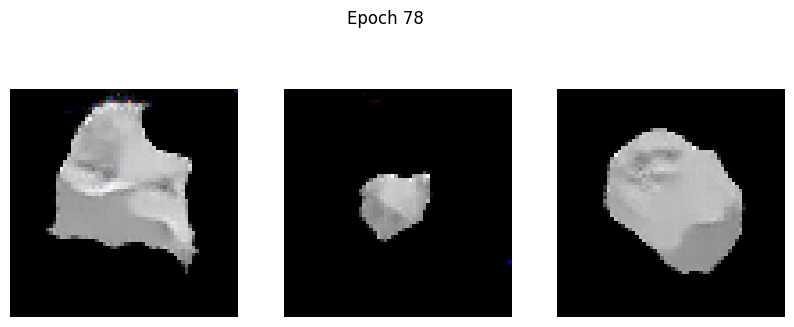

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4750 - g_loss: 2.0835
Epoch 79/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2283 - g_loss: 2.1038

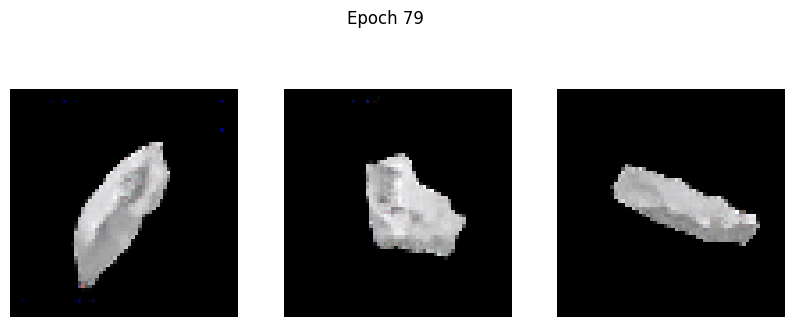

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2285 - g_loss: 2.1037
Epoch 80/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2689 - g_loss: 2.1489

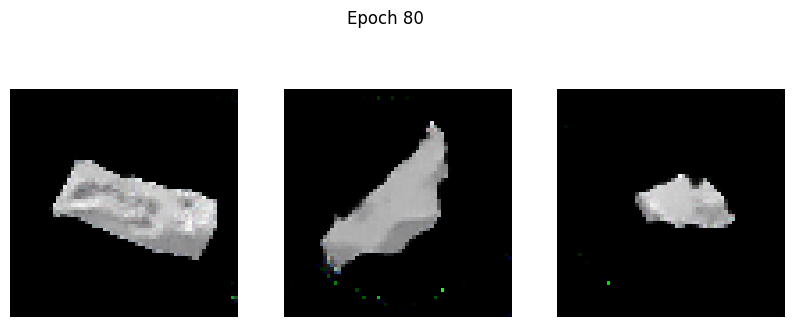

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2690 - g_loss: 2.1488
Epoch 81/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2612 - g_loss: 2.1853

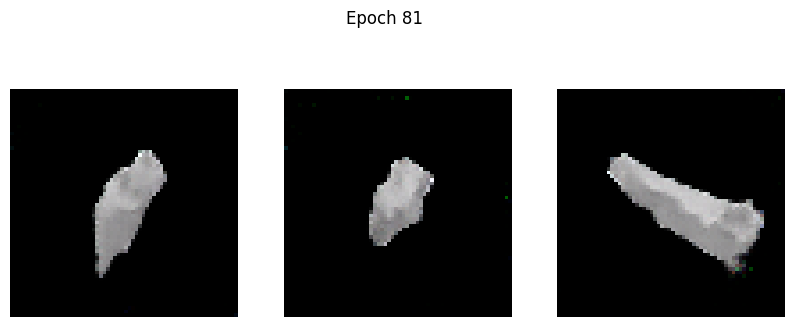

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2611 - g_loss: 2.1848
Epoch 82/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2654 - g_loss: 2.2797

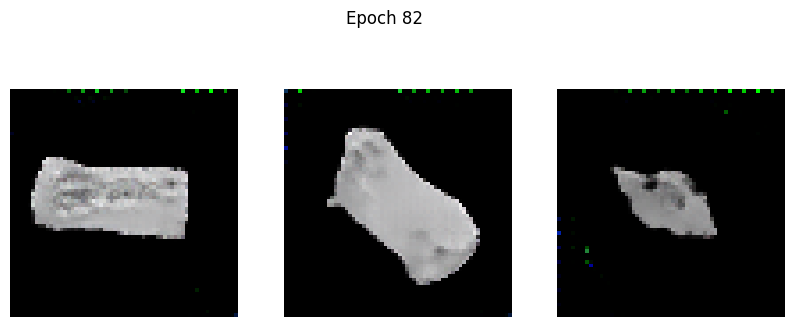

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2655 - g_loss: 2.2795
Epoch 83/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2417 - g_loss: 2.1540

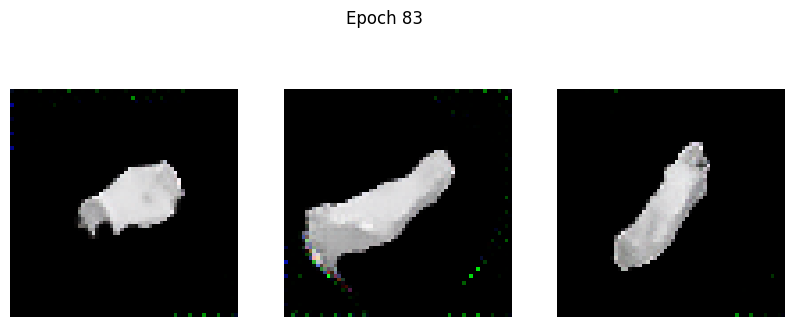

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2418 - g_loss: 2.1544
Epoch 84/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3290 - g_loss: 2.2641

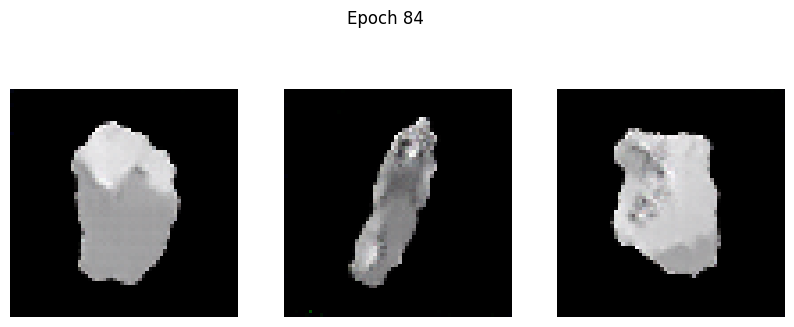

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3285 - g_loss: 2.2634
Epoch 85/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2225 - g_loss: 2.2180

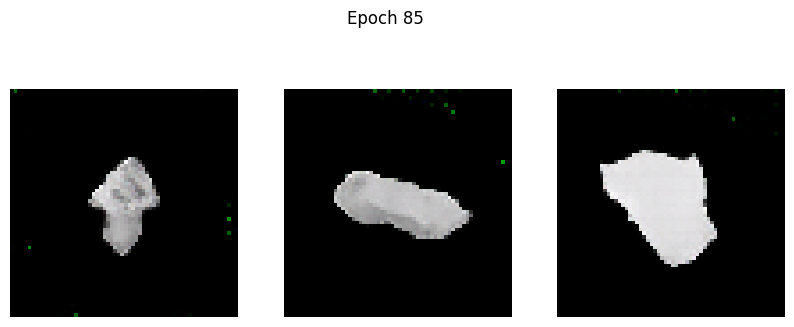

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2226 - g_loss: 2.2178
Epoch 86/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2404 - g_loss: 2.2106

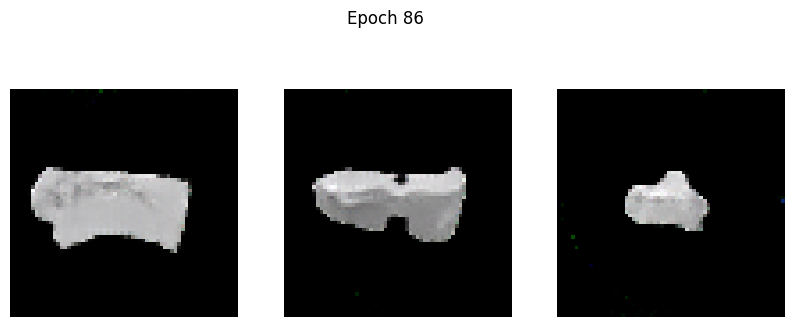

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2405 - g_loss: 2.2108
Epoch 87/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2390 - g_loss: 2.2627

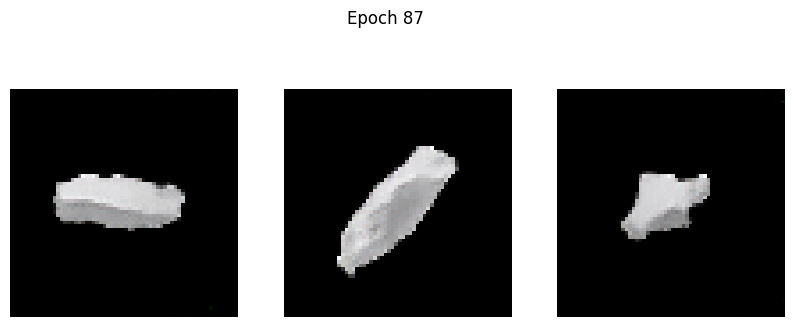

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2390 - g_loss: 2.2629
Epoch 88/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4900 - g_loss: 2.7471

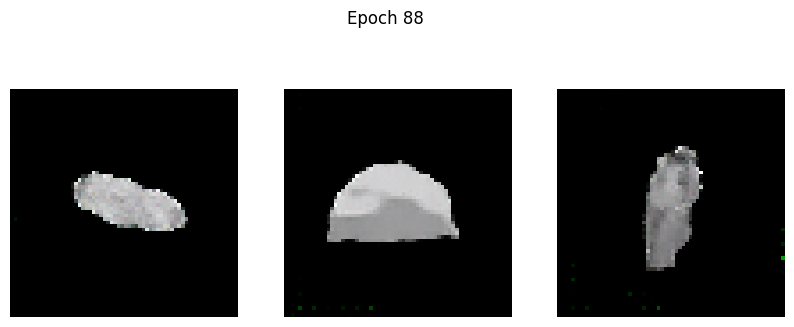

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4886 - g_loss: 2.7435
Epoch 89/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2092 - g_loss: 2.1671

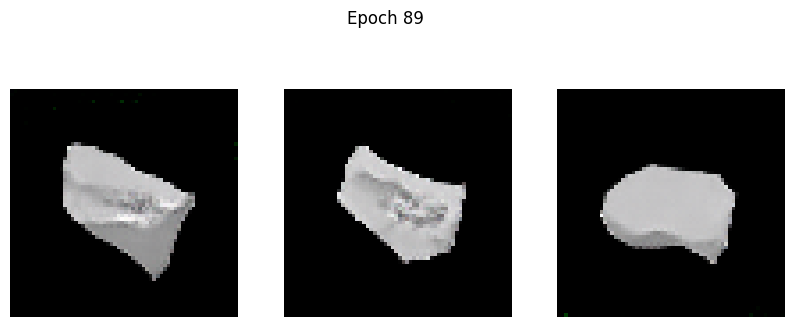

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2092 - g_loss: 2.1675
Epoch 90/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2500 - g_loss: 2.3209

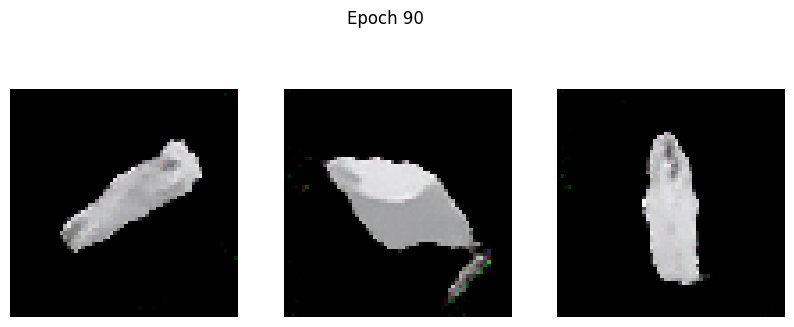

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2499 - g_loss: 2.3207
Epoch 91/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2332 - g_loss: 2.2912

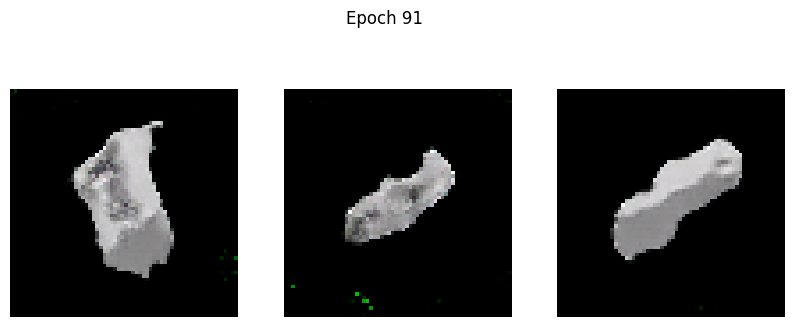

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2333 - g_loss: 2.2911
Epoch 92/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2703 - g_loss: 2.3516

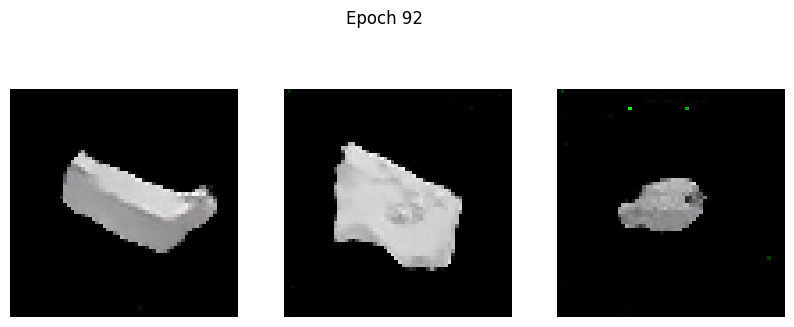

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2701 - g_loss: 2.3513
Epoch 93/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2276 - g_loss: 2.3632

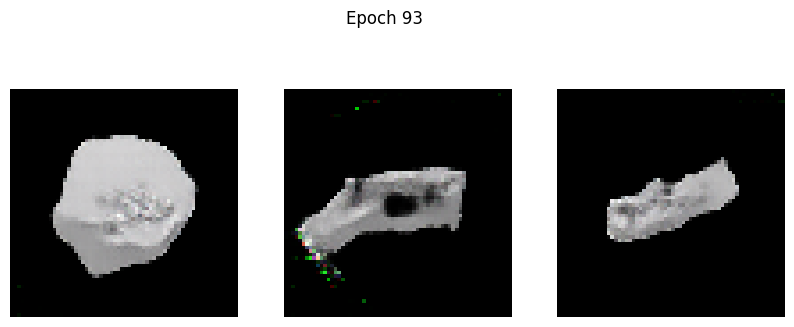

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2276 - g_loss: 2.3631
Epoch 94/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2305 - g_loss: 2.4135

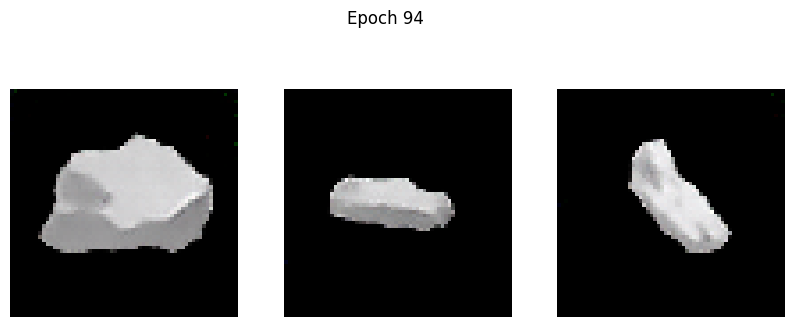

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2307 - g_loss: 2.4136
Epoch 95/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2126 - g_loss: 2.3526

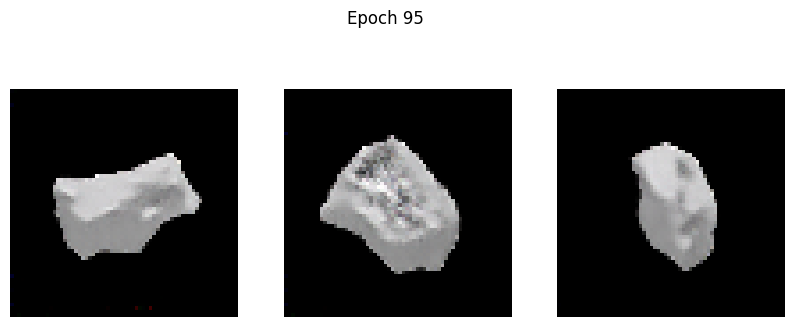

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2128 - g_loss: 2.3528
Epoch 96/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2638 - g_loss: 2.5235

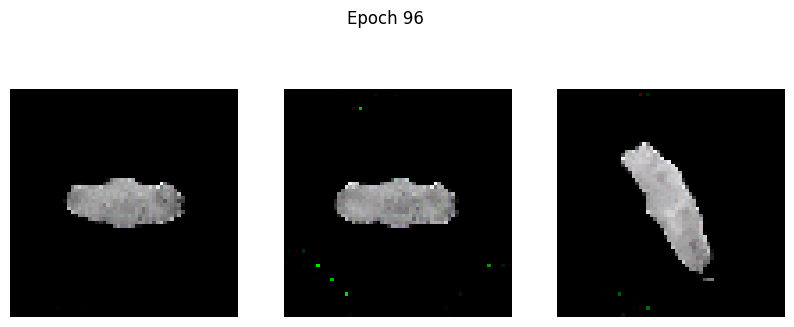

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2641 - g_loss: 2.5233
Epoch 97/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2351 - g_loss: 2.3378

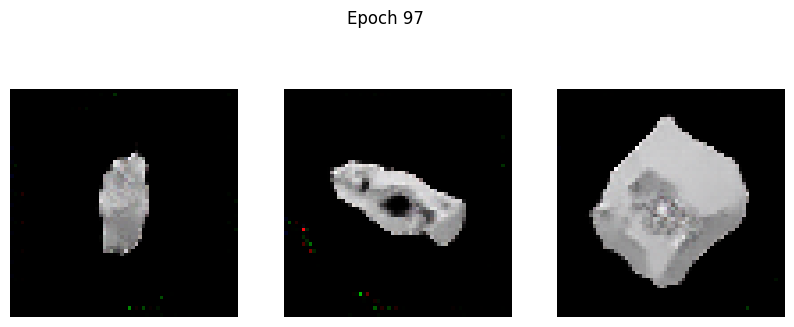

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2352 - g_loss: 2.3379
Epoch 98/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2079 - g_loss: 2.3521

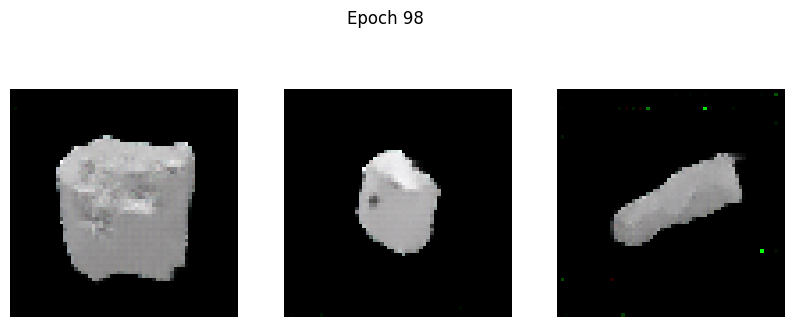

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2082 - g_loss: 2.3526
Epoch 99/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2285 - g_loss: 2.3804

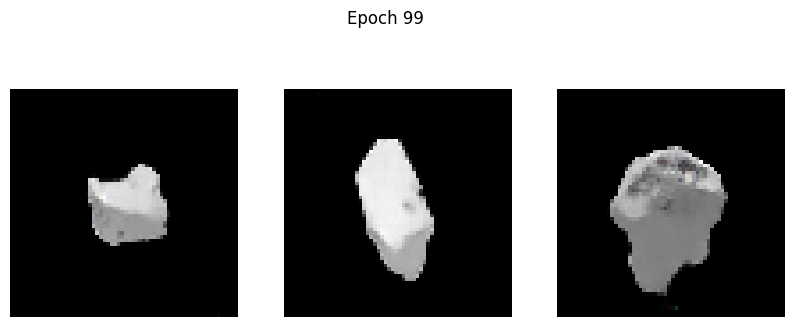

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2284 - g_loss: 2.3804
Epoch 100/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1886 - g_loss: 2.4405

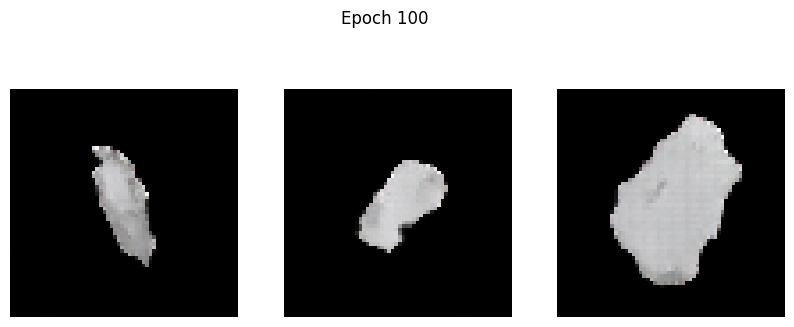

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1888 - g_loss: 2.4410
Epoch 101/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.3125 - g_loss: 2.5810

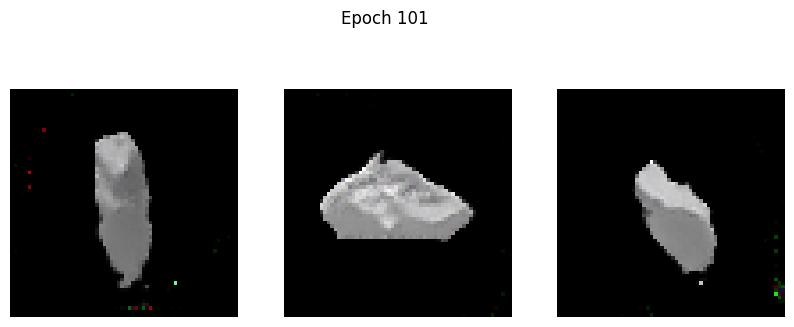

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.3120 - g_loss: 2.5803
Epoch 102/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1869 - g_loss: 2.4766

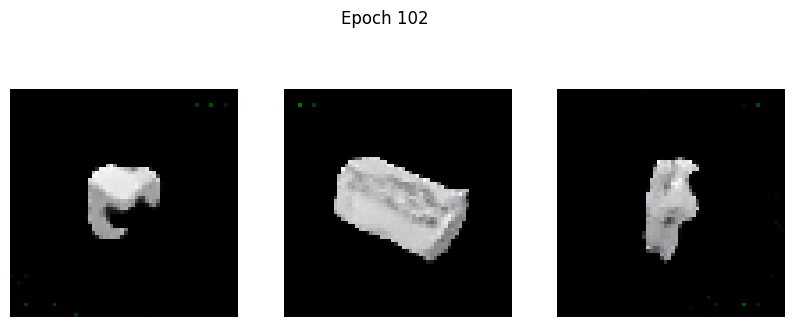

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1870 - g_loss: 2.4764
Epoch 103/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4876 - g_loss: 2.8409

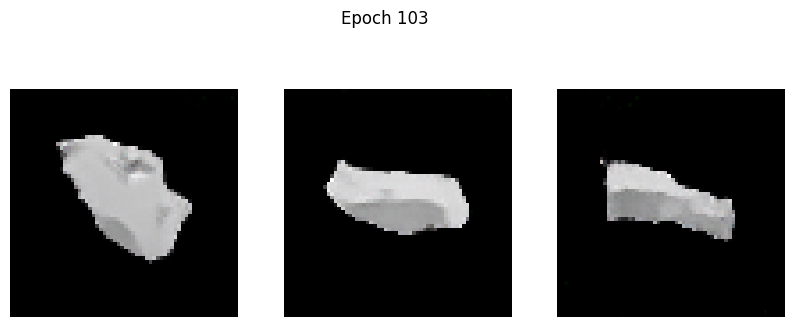

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4863 - g_loss: 2.8381
Epoch 104/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1885 - g_loss: 2.4169

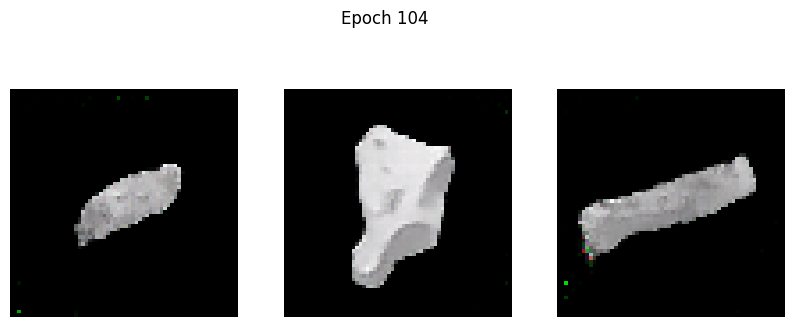

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1885 - g_loss: 2.4171
Epoch 105/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1856 - g_loss: 2.4822

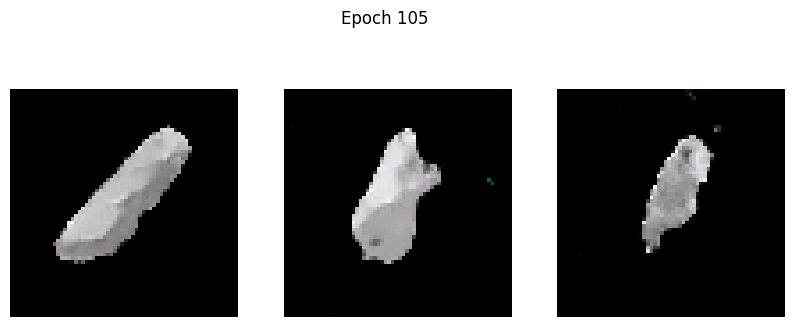

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1855 - g_loss: 2.4822
Epoch 106/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2215 - g_loss: 2.5904

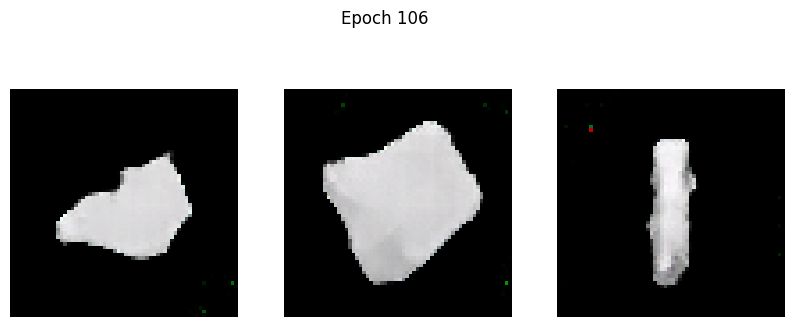

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2217 - g_loss: 2.5907
Epoch 107/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1902 - g_loss: 2.5011

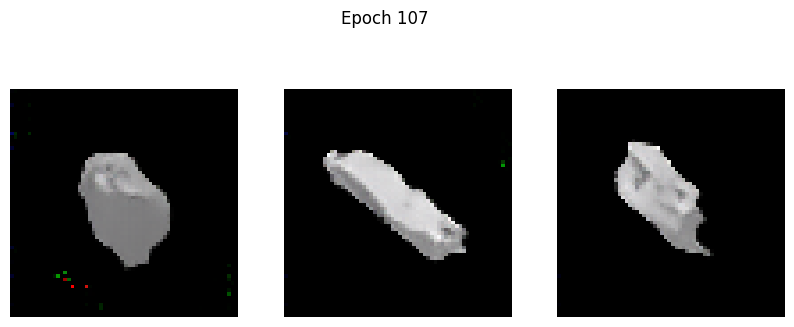

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1908 - g_loss: 2.5025
Epoch 108/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2048 - g_loss: 2.5122

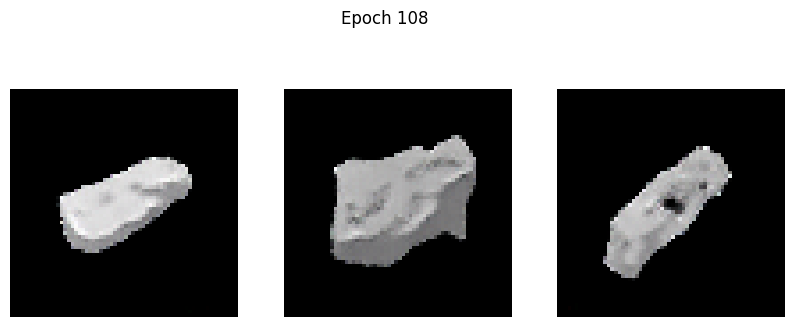

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2049 - g_loss: 2.5123
Epoch 109/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2281 - g_loss: 2.6158

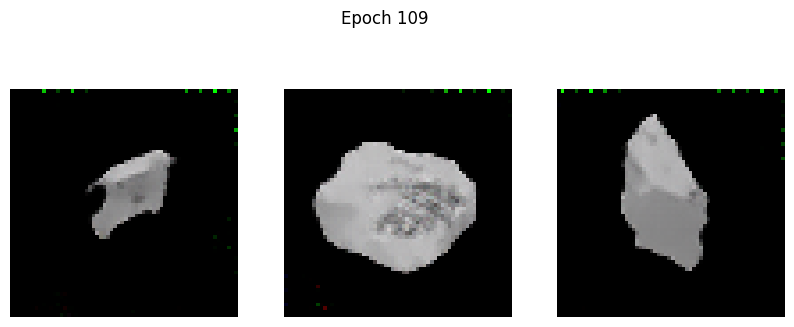

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2279 - g_loss: 2.6156
Epoch 110/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2131 - g_loss: 2.6295

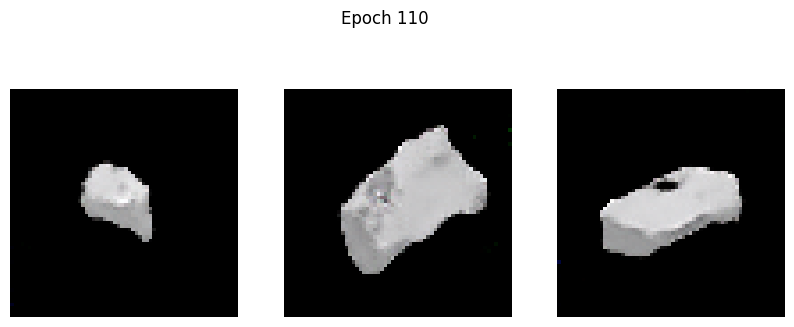

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2137 - g_loss: 2.6301
Epoch 111/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1858 - g_loss: 2.4842

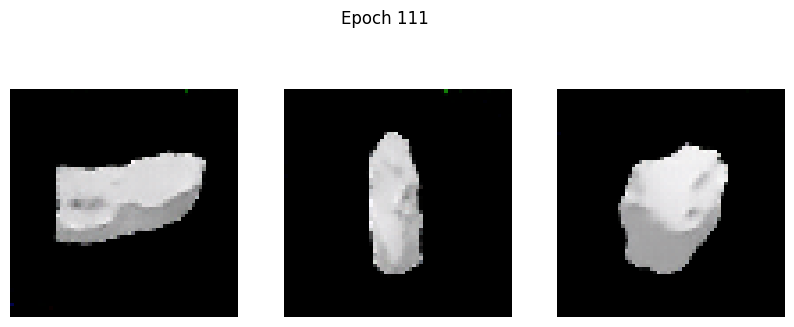

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1858 - g_loss: 2.4845
Epoch 112/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1899 - g_loss: 2.6276

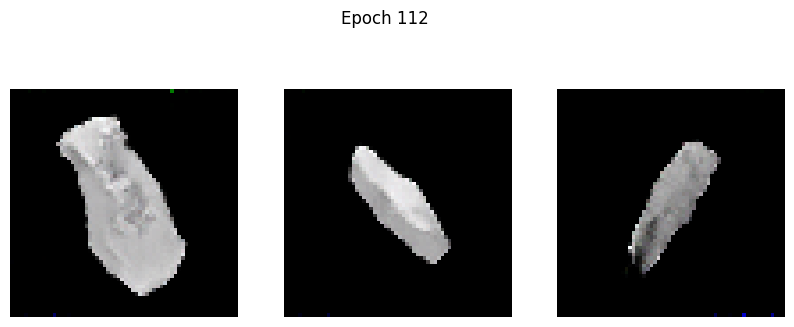

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1899 - g_loss: 2.6276
Epoch 113/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2128 - g_loss: 2.6670

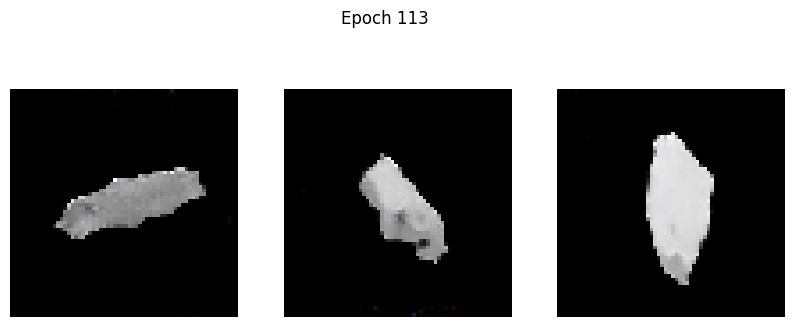

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2127 - g_loss: 2.6667
Epoch 114/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1896 - g_loss: 2.6575

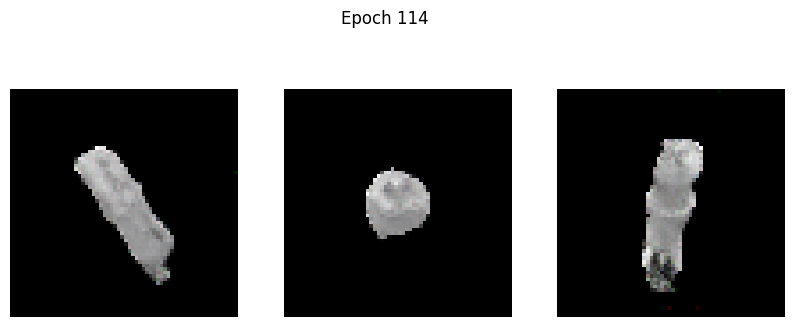

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1900 - g_loss: 2.6578
Epoch 115/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2258 - g_loss: 2.7361

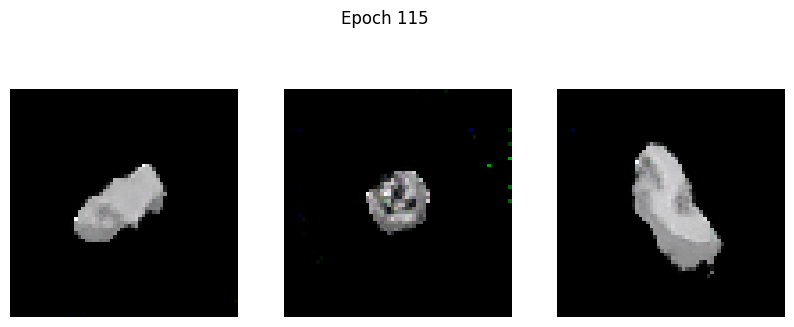

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2258 - g_loss: 2.7355
Epoch 116/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2190 - g_loss: 2.7266

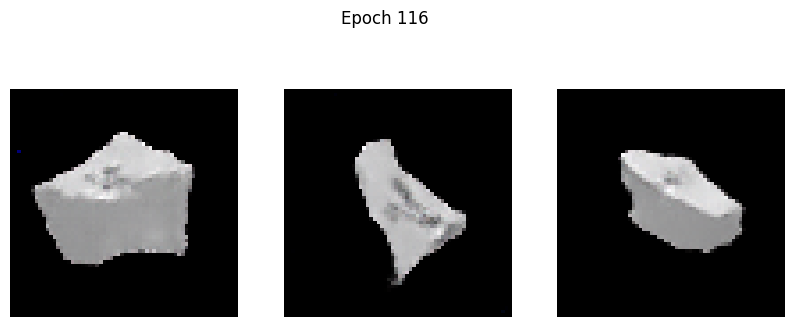

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2187 - g_loss: 2.7259
Epoch 117/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1719 - g_loss: 2.6814

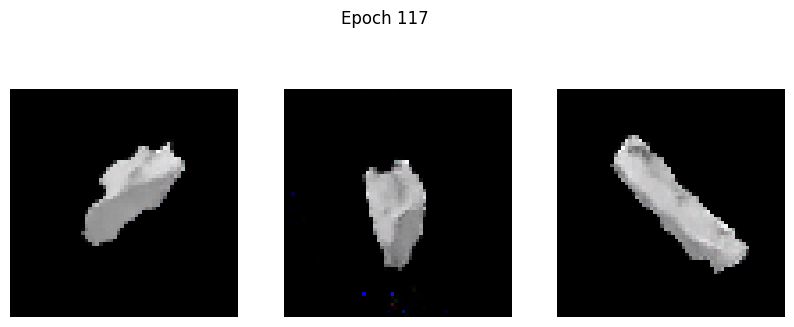

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1720 - g_loss: 2.6813
Epoch 118/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.7736 - g_loss: 3.0841

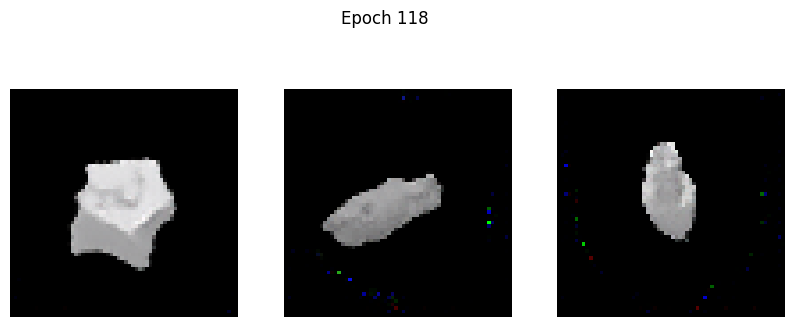

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.7710 - g_loss: 3.0803
Epoch 119/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1678 - g_loss: 2.5291

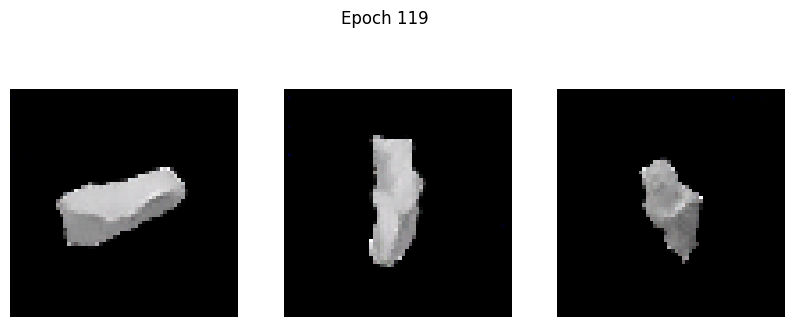

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1678 - g_loss: 2.5293
Epoch 120/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1626 - g_loss: 2.6083

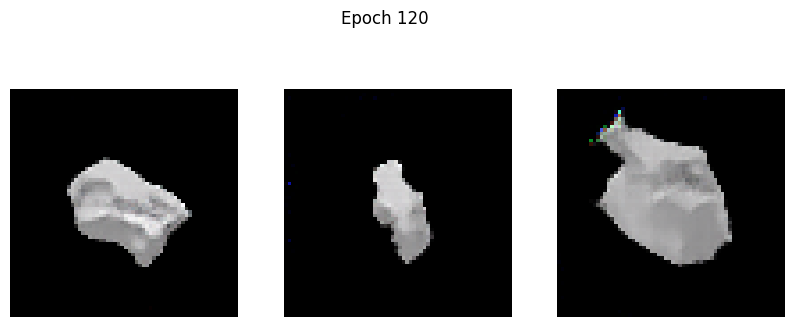

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1627 - g_loss: 2.6087
Epoch 121/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1594 - g_loss: 2.6892

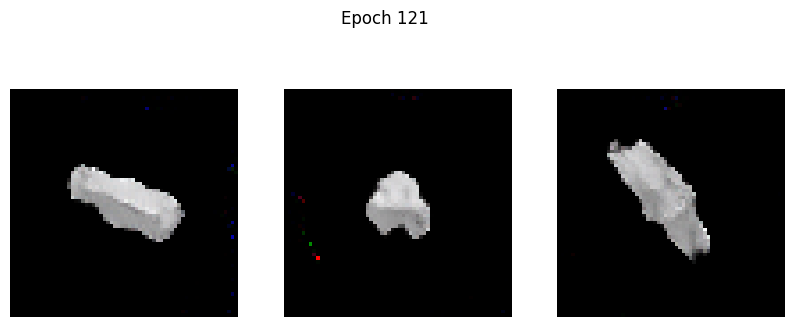

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1594 - g_loss: 2.6893
Epoch 122/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1986 - g_loss: 2.7744

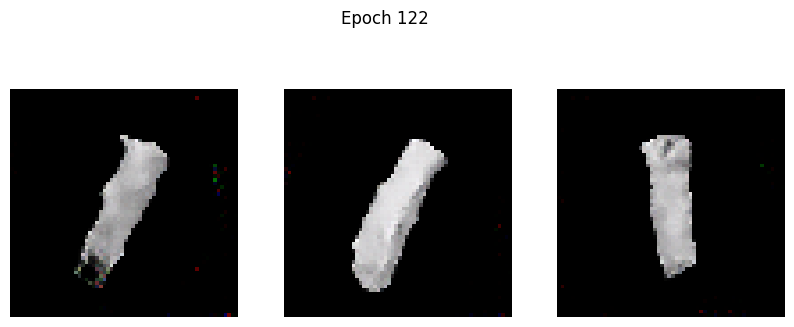

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1988 - g_loss: 2.7744
Epoch 123/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1604 - g_loss: 2.6383

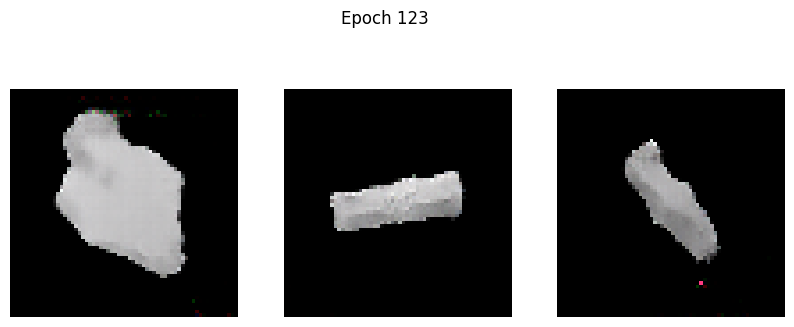

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - d_loss: 0.1604 - g_loss: 2.6389
Epoch 124/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2123 - g_loss: 2.8595

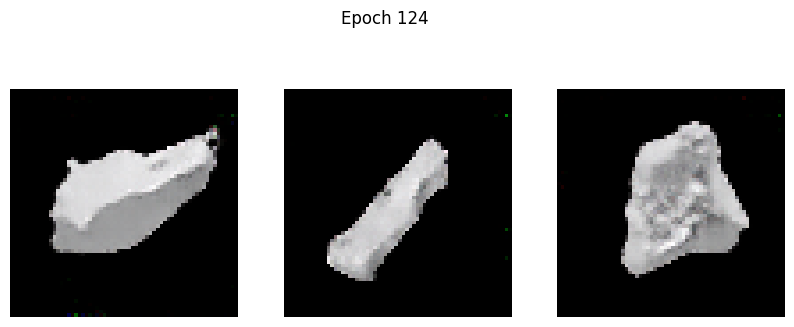

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2122 - g_loss: 2.8589
Epoch 125/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1963 - g_loss: 2.7594

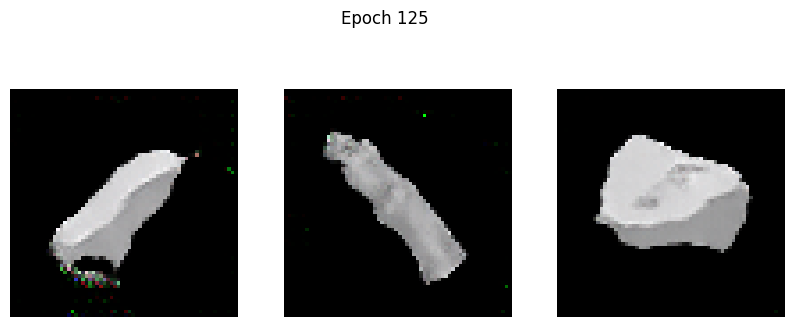

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1963 - g_loss: 2.7595
Epoch 126/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1896 - g_loss: 2.9237

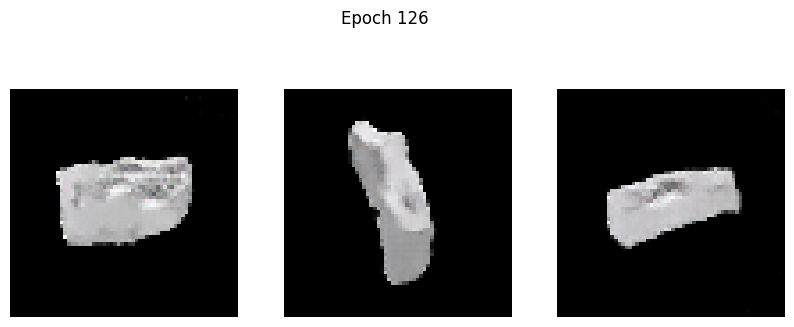

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1896 - g_loss: 2.9231
Epoch 127/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1650 - g_loss: 2.8374

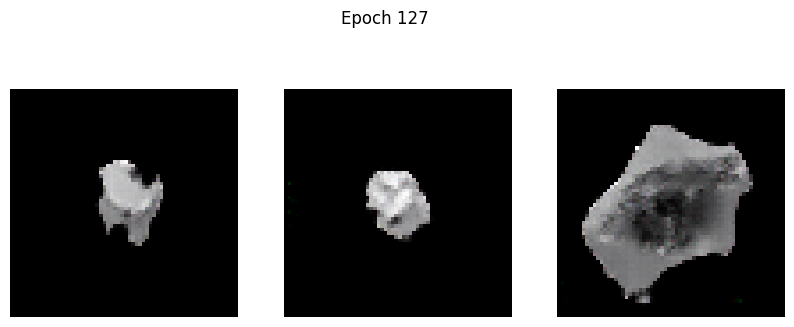

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1656 - g_loss: 2.8382
Epoch 128/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2185 - g_loss: 2.8273

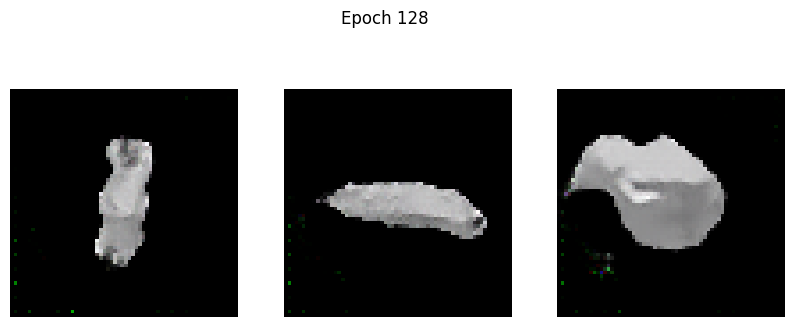

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2182 - g_loss: 2.8270
Epoch 129/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - d_loss: 0.2037 - g_loss: 2.8478

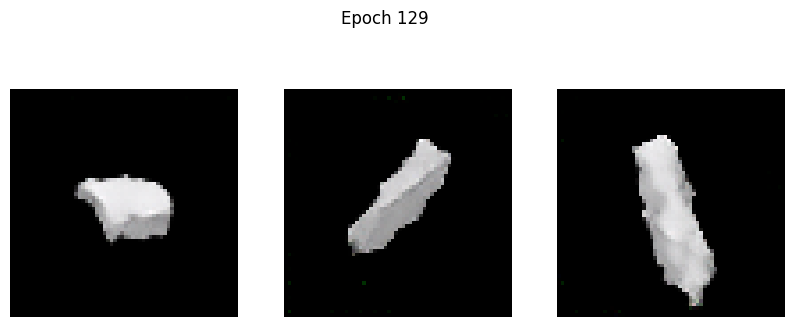

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 121ms/step - d_loss: 0.2039 - g_loss: 2.8481
Epoch 130/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1466 - g_loss: 2.7809

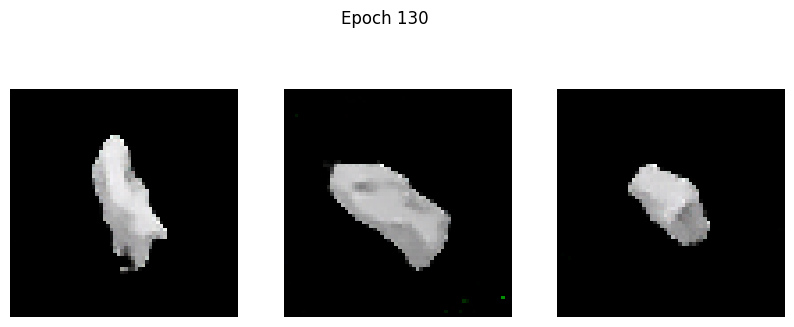

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1467 - g_loss: 2.7813
Epoch 131/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.1589 - g_loss: 2.8423

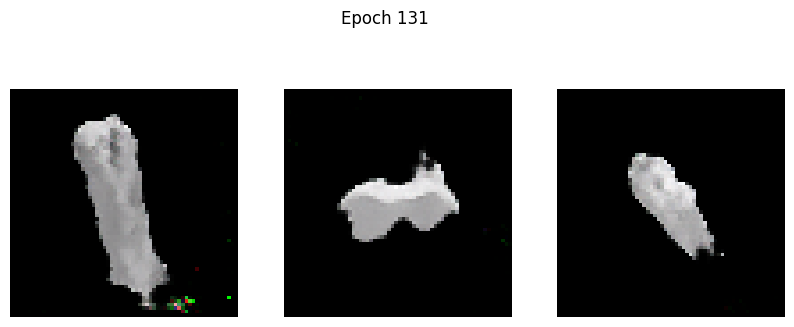

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.1588 - g_loss: 2.8425
Epoch 132/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2733 - g_loss: 3.0025

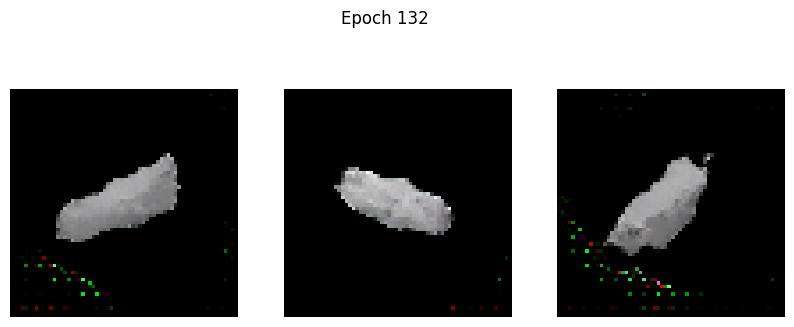

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2741 - g_loss: 3.0028
Epoch 133/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1554 - g_loss: 2.7108

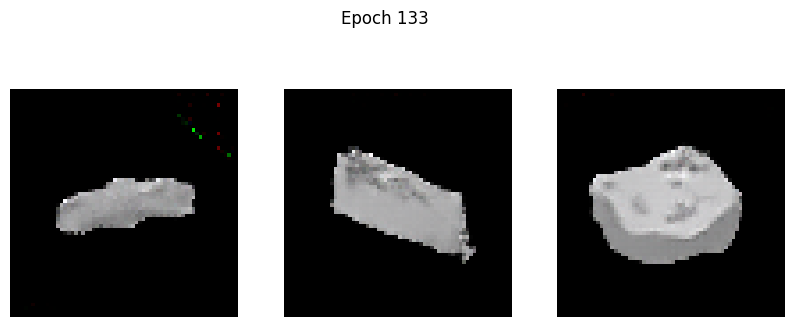

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1554 - g_loss: 2.7111
Epoch 134/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1422 - g_loss: 2.8068

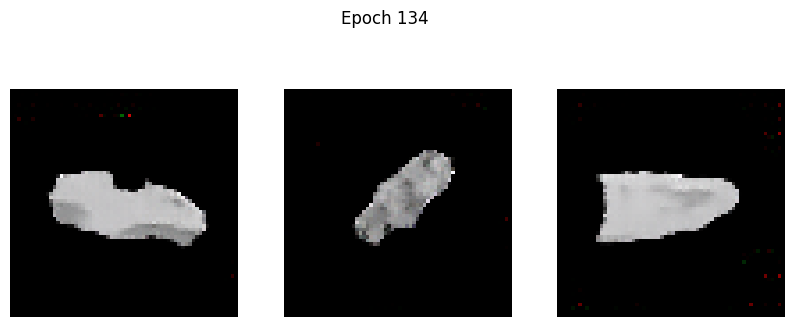

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1424 - g_loss: 2.8067
Epoch 135/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1506 - g_loss: 2.8861

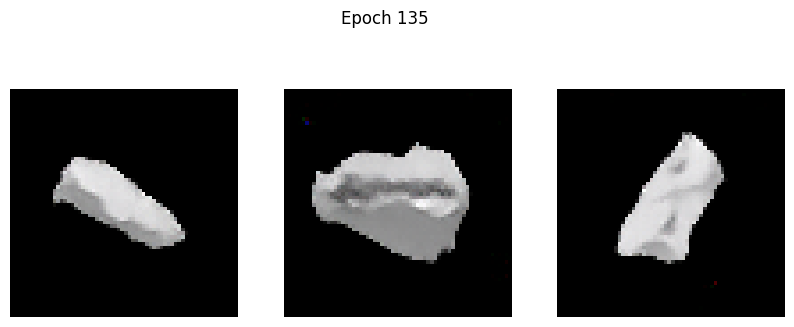

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1508 - g_loss: 2.8862
Epoch 136/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1900 - g_loss: 2.9590

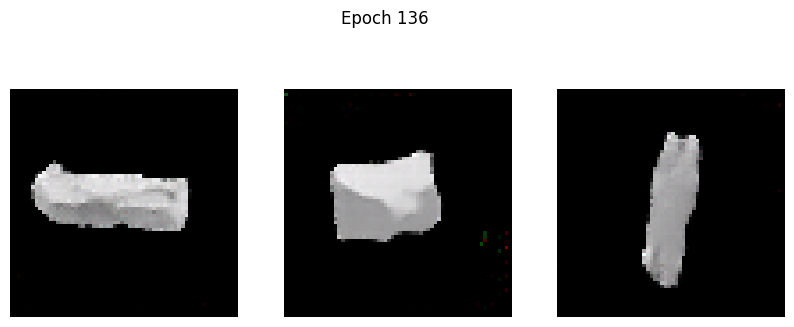

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.1896 - g_loss: 2.9586
Epoch 137/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1387 - g_loss: 3.0040

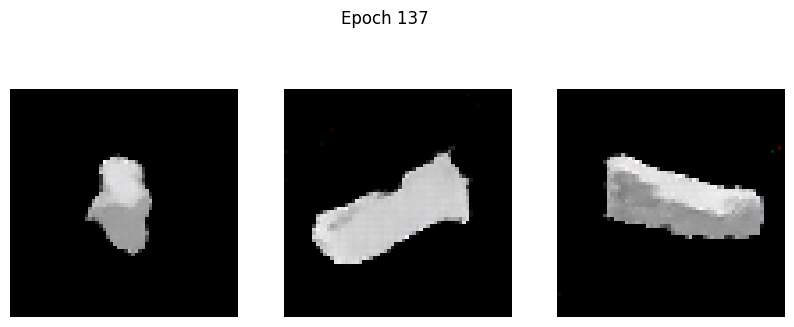

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1388 - g_loss: 3.0037
Epoch 138/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2165 - g_loss: 3.0417

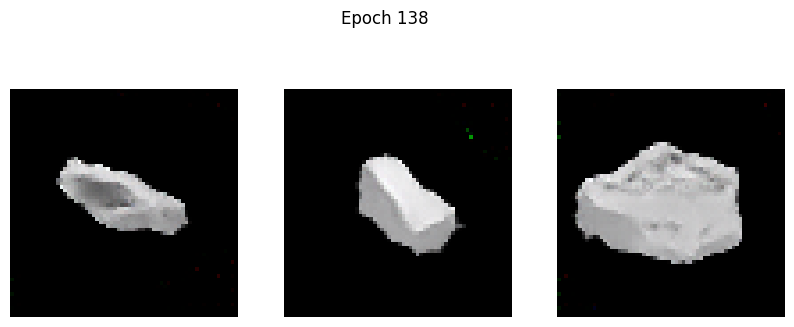

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2167 - g_loss: 3.0415
Epoch 139/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1473 - g_loss: 2.9038

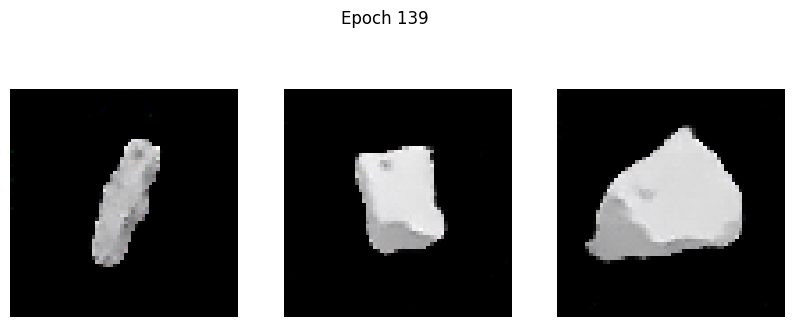

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1475 - g_loss: 2.9040
Epoch 140/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1832 - g_loss: 3.0384

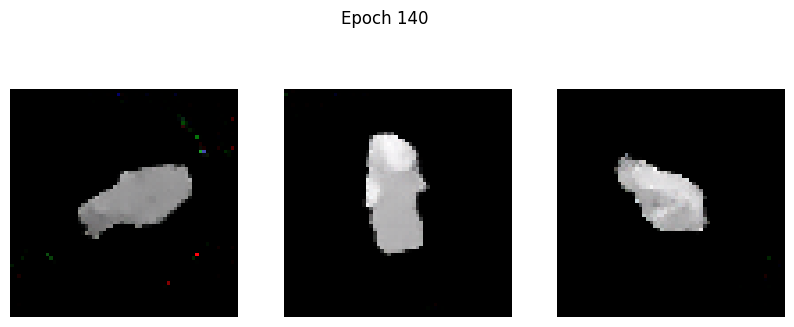

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1830 - g_loss: 3.0382
Epoch 141/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1355 - g_loss: 3.0248

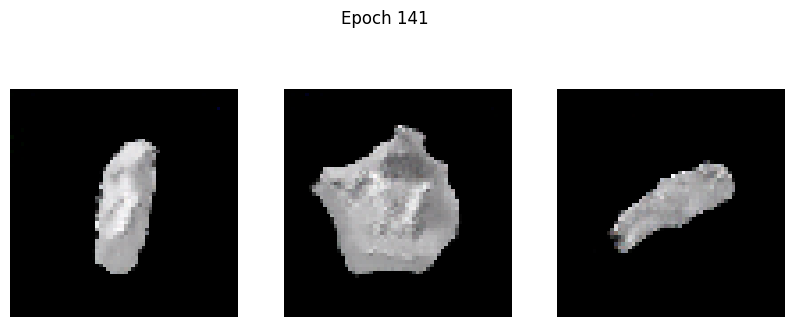

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1357 - g_loss: 3.0247
Epoch 142/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1427 - g_loss: 3.0270

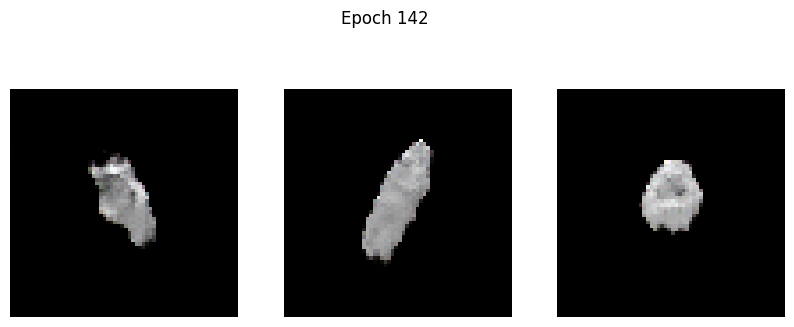

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1436 - g_loss: 3.0280
Epoch 143/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 1.4272 - g_loss: 4.3862

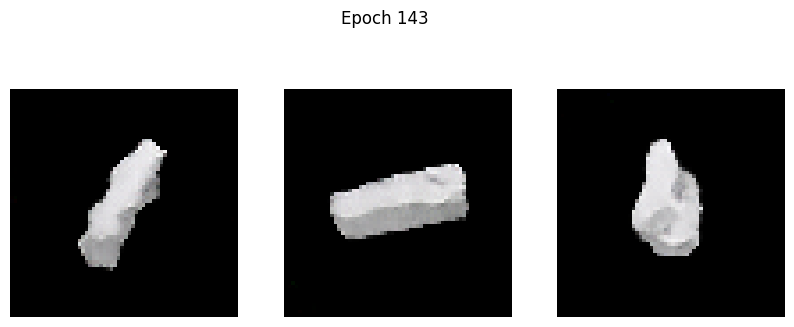

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 1.4192 - g_loss: 4.3722
Epoch 144/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1715 - g_loss: 2.6026

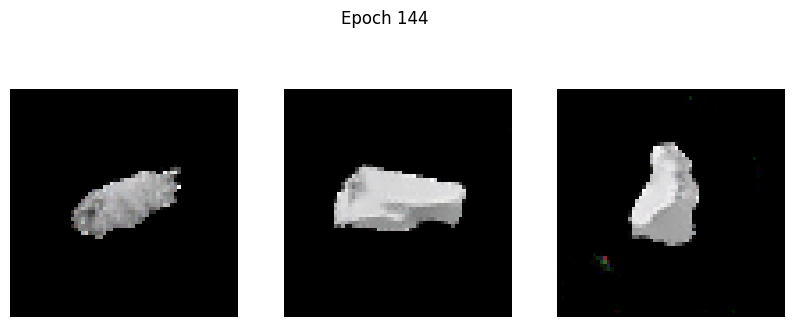

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1714 - g_loss: 2.6027
Epoch 145/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1502 - g_loss: 2.7619

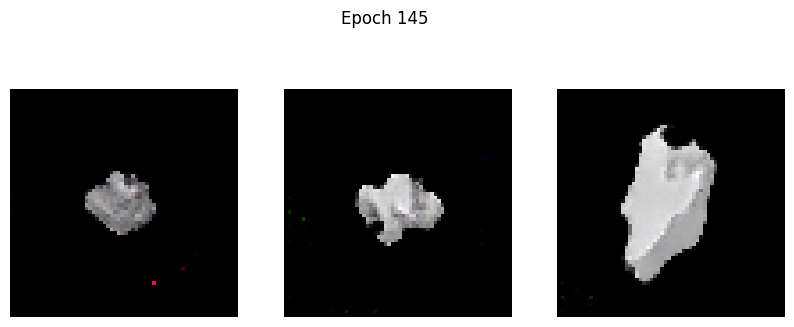

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1502 - g_loss: 2.7619
Epoch 146/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1474 - g_loss: 2.8483

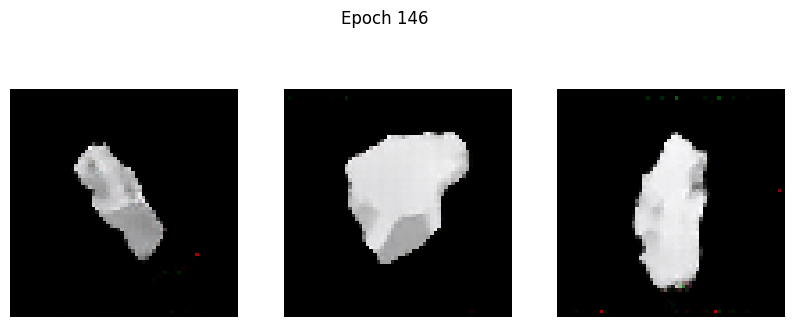

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1476 - g_loss: 2.8486
Epoch 147/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1444 - g_loss: 2.9521

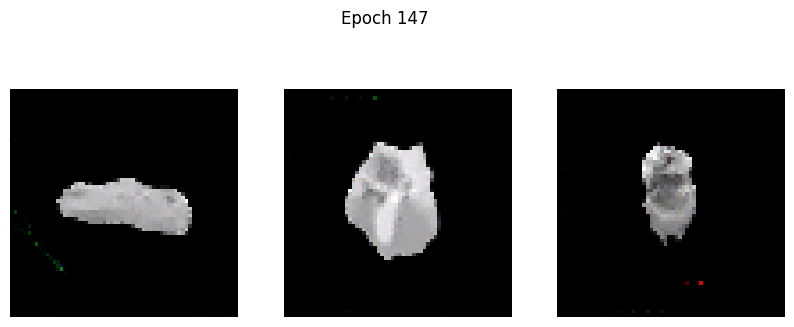

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1443 - g_loss: 2.9517
Epoch 148/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2227 - g_loss: 3.0422

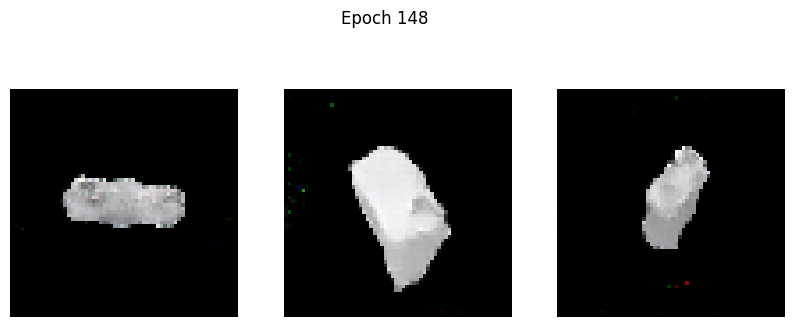

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2226 - g_loss: 3.0421
Epoch 149/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1398 - g_loss: 2.9331

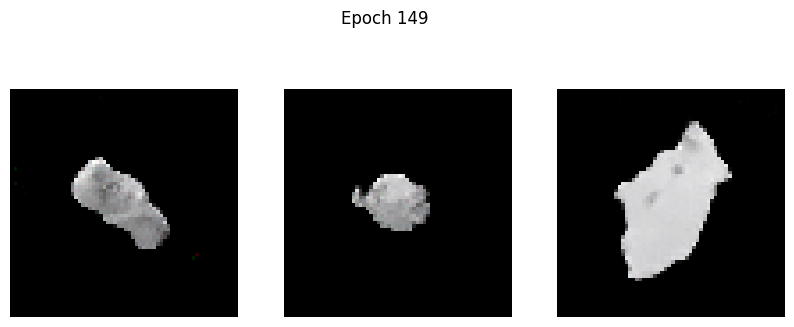

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1397 - g_loss: 2.9332
Epoch 150/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1373 - g_loss: 3.0822

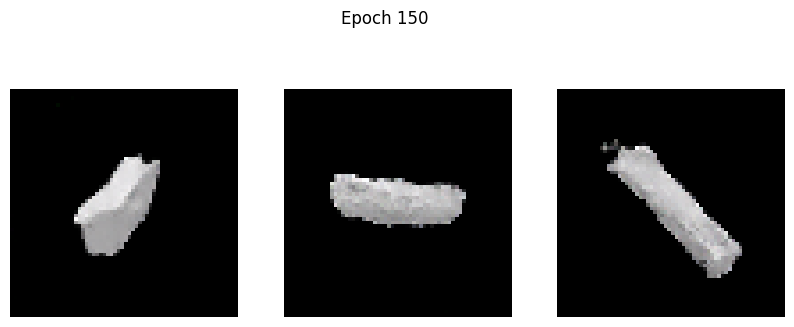

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1372 - g_loss: 3.0818
Epoch 151/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1703 - g_loss: 3.1293

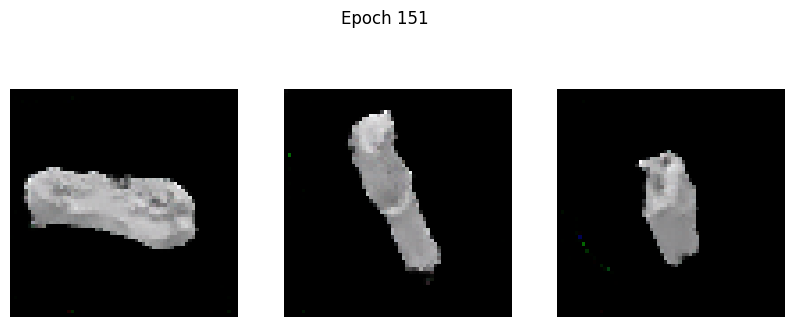

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1707 - g_loss: 3.1295
Epoch 152/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1307 - g_loss: 3.0474

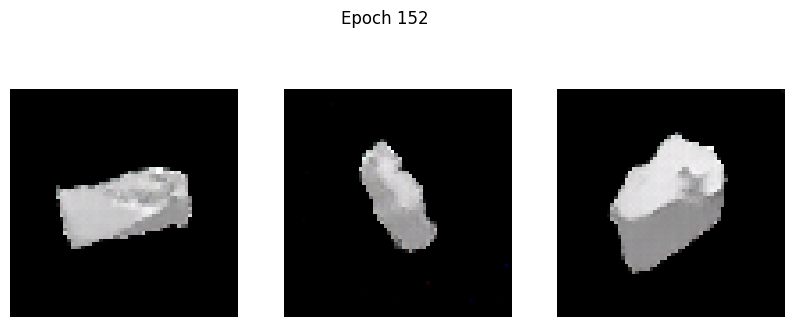

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1307 - g_loss: 3.0478
Epoch 153/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1725 - g_loss: 3.0779

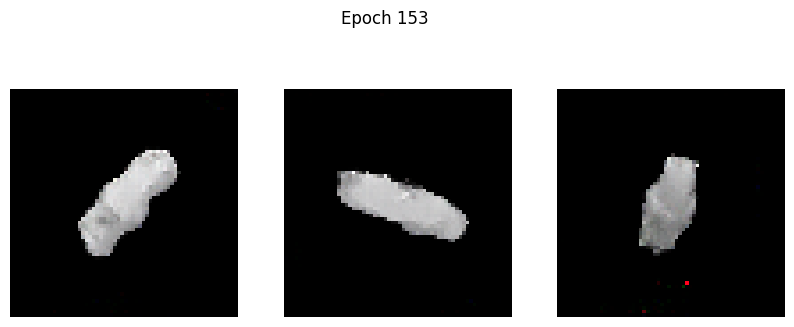

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1725 - g_loss: 3.0778
Epoch 154/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1708 - g_loss: 3.2495

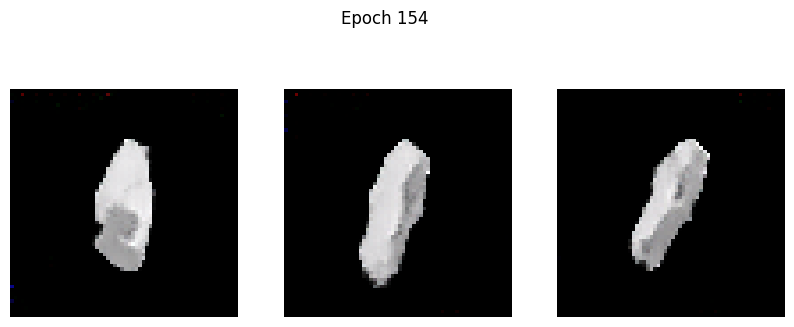

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1710 - g_loss: 3.2490
Epoch 155/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1286 - g_loss: 3.0188

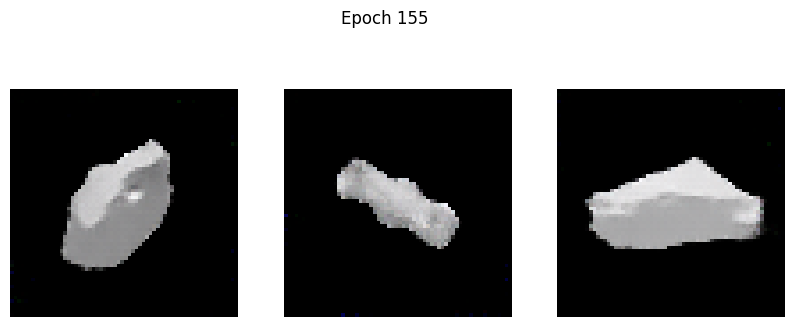

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1286 - g_loss: 3.0192
Epoch 156/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1816 - g_loss: 3.3265

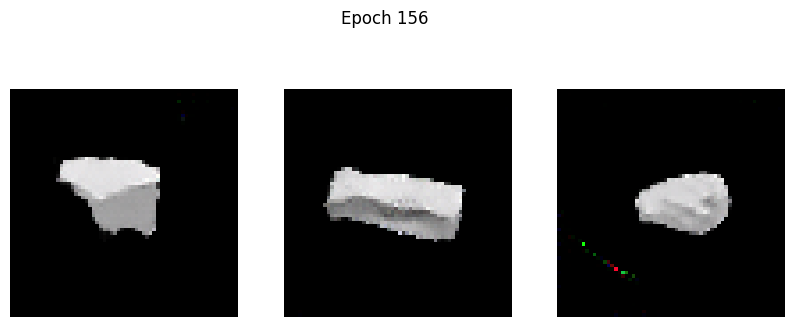

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1815 - g_loss: 3.3256
Epoch 157/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1279 - g_loss: 3.1788

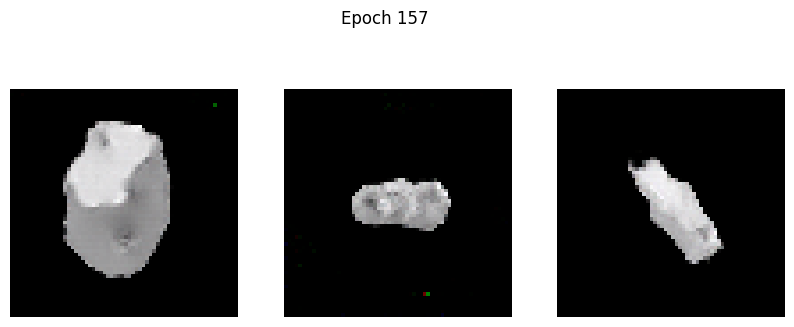

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1280 - g_loss: 3.1787
Epoch 158/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1453 - g_loss: 3.1387

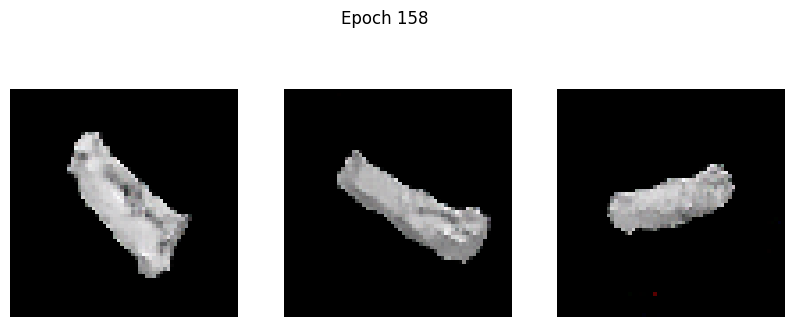

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1456 - g_loss: 3.1394
Epoch 159/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1800 - g_loss: 3.2058

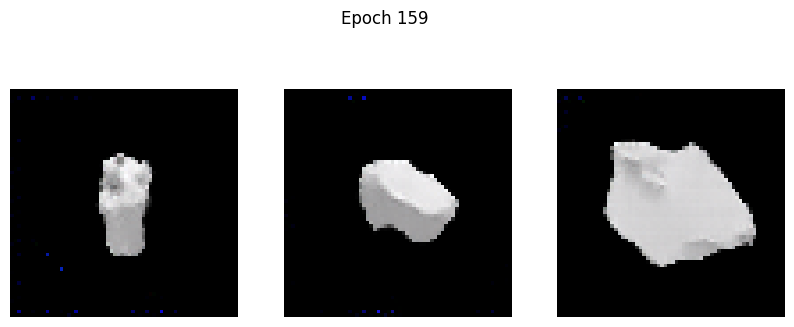

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1798 - g_loss: 3.2051
Epoch 160/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2486 - g_loss: 3.2984

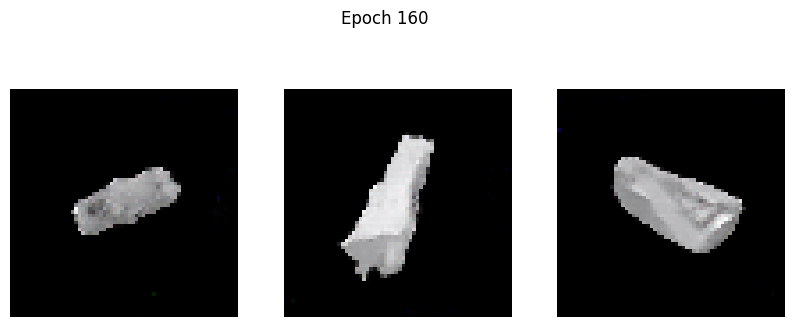

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2482 - g_loss: 3.2972
Epoch 161/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1213 - g_loss: 3.1419

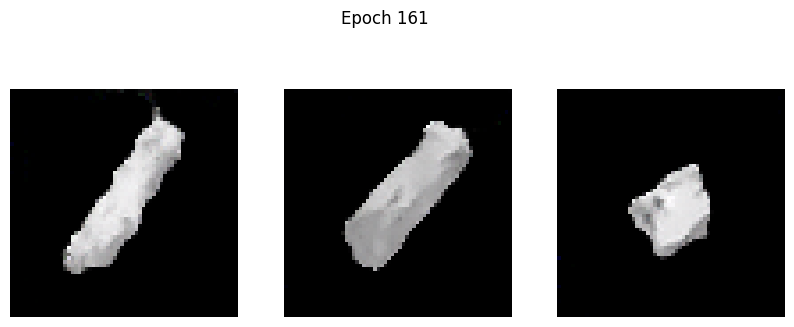

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1214 - g_loss: 3.1421
Epoch 162/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1372 - g_loss: 3.1779

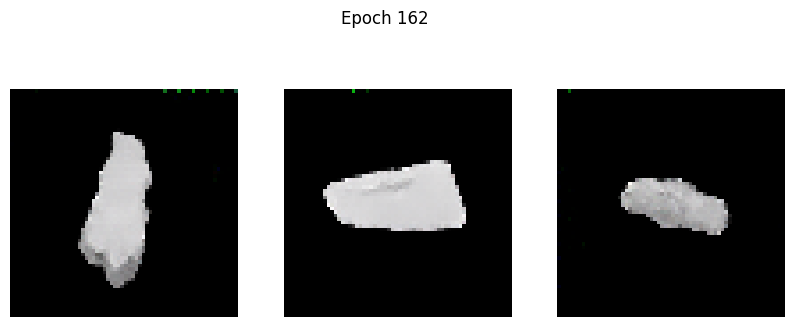

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1372 - g_loss: 3.1778
Epoch 163/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2126 - g_loss: 3.3956

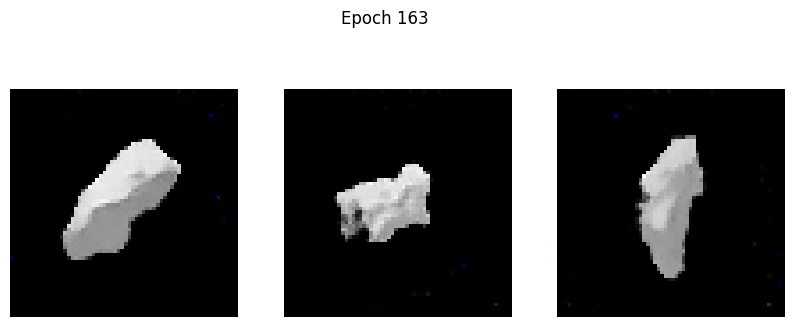

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2125 - g_loss: 3.3951
Epoch 164/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1252 - g_loss: 3.2372

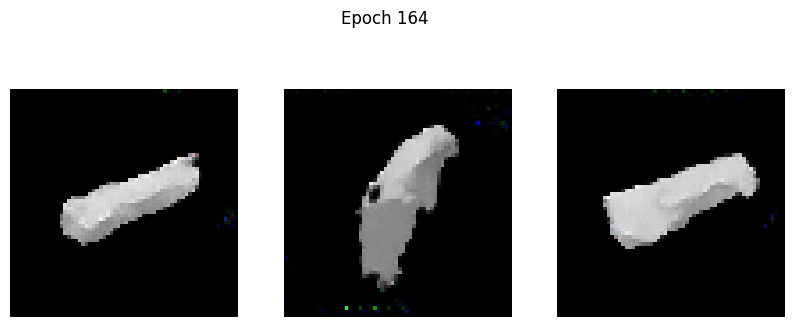

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1256 - g_loss: 3.2377
Epoch 165/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1661 - g_loss: 3.2364

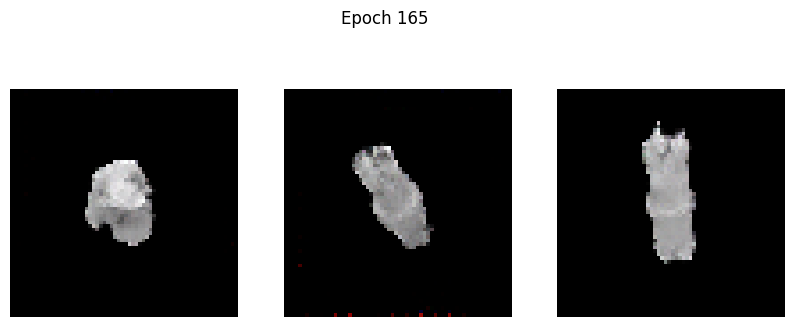

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1658 - g_loss: 3.2360
Epoch 166/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1319 - g_loss: 3.3193

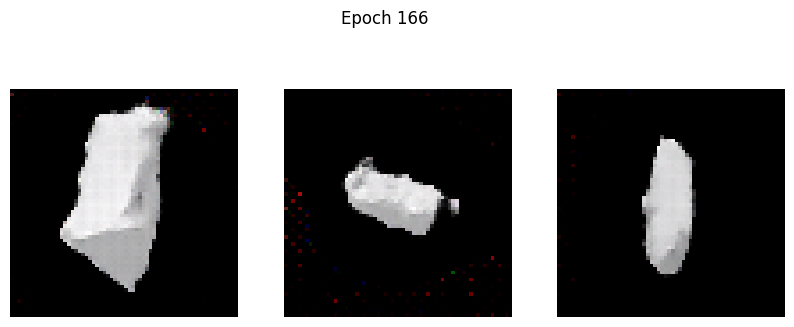

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1322 - g_loss: 3.3188
Epoch 167/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1696 - g_loss: 3.2831

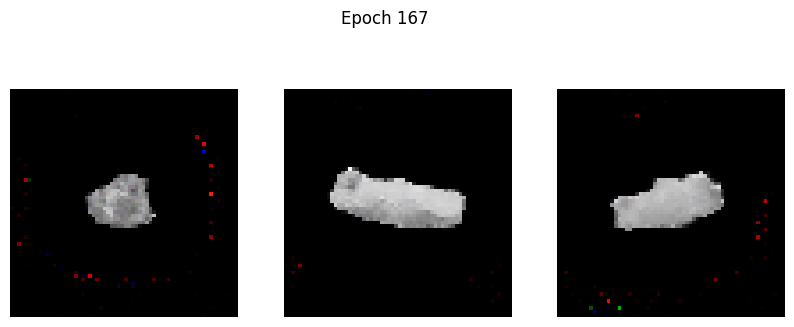

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1696 - g_loss: 3.2832
Epoch 168/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1135 - g_loss: 3.2542

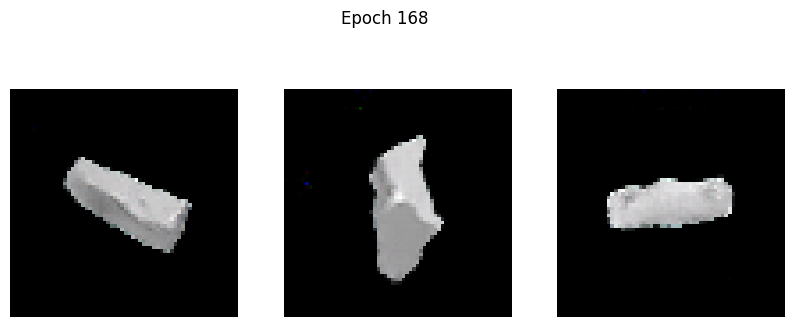

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1137 - g_loss: 3.2547
Epoch 169/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1692 - g_loss: 3.2662

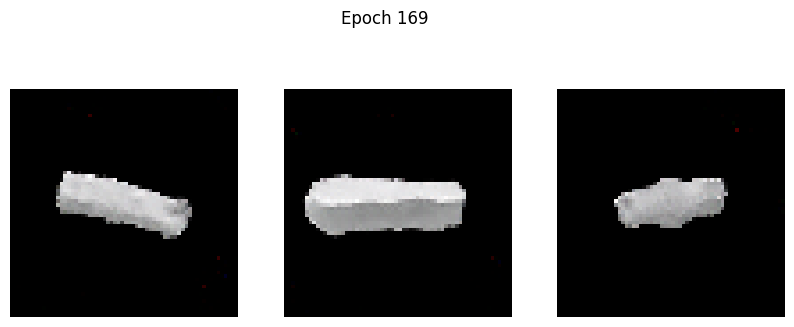

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1693 - g_loss: 3.2667
Epoch 170/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1188 - g_loss: 3.2957

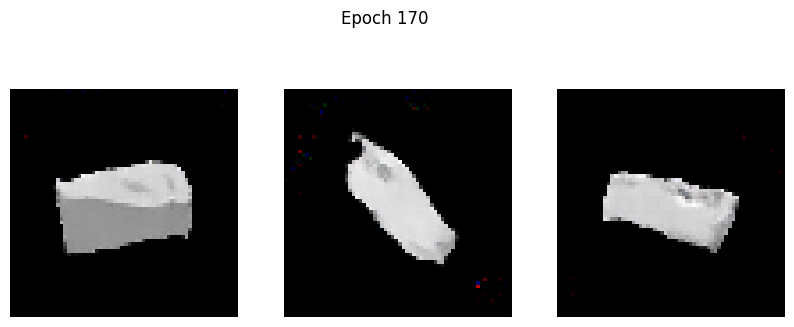

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1189 - g_loss: 3.2956
Epoch 171/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1108 - g_loss: 3.3178

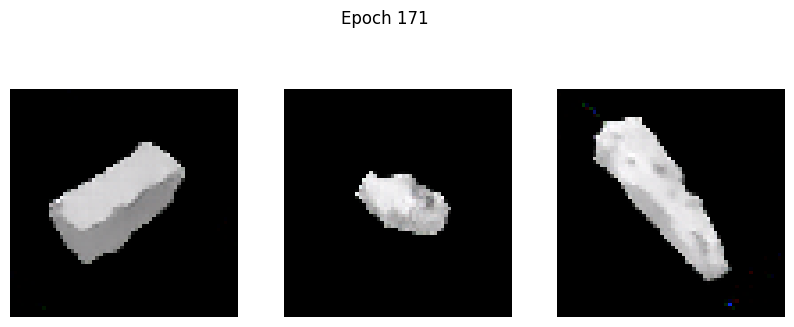

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1110 - g_loss: 3.3178
Epoch 172/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1460 - g_loss: 3.3117

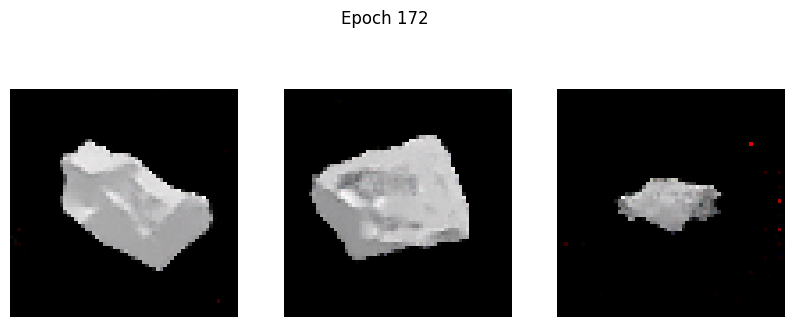

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1459 - g_loss: 3.3117
Epoch 173/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1957 - g_loss: 3.5833

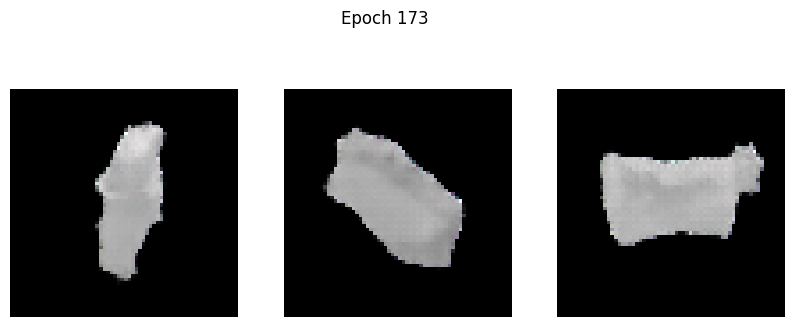

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1970 - g_loss: 3.5863
Epoch 174/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4780 - g_loss: 3.9257

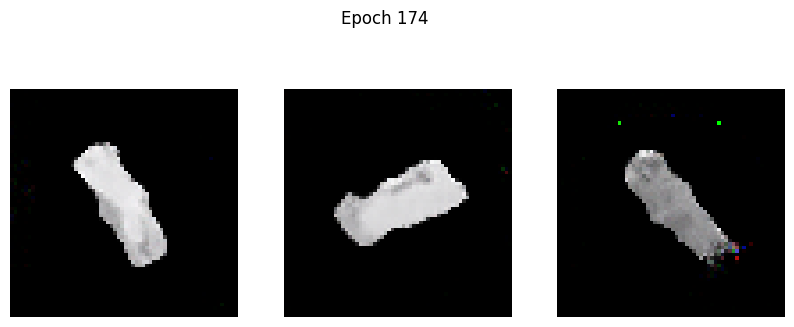

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4758 - g_loss: 3.9196
Epoch 175/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1172 - g_loss: 3.1717

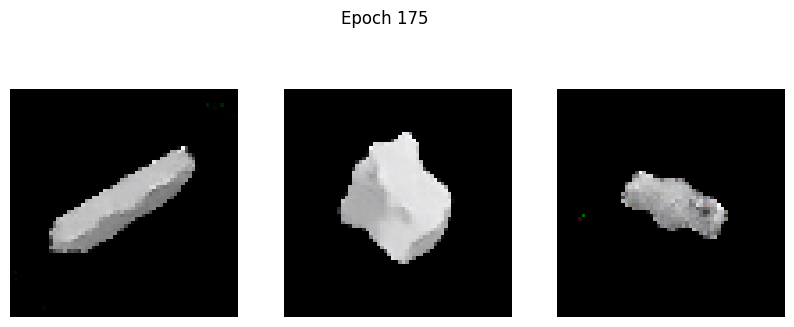

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1171 - g_loss: 3.1719
Epoch 176/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1015 - g_loss: 3.1781

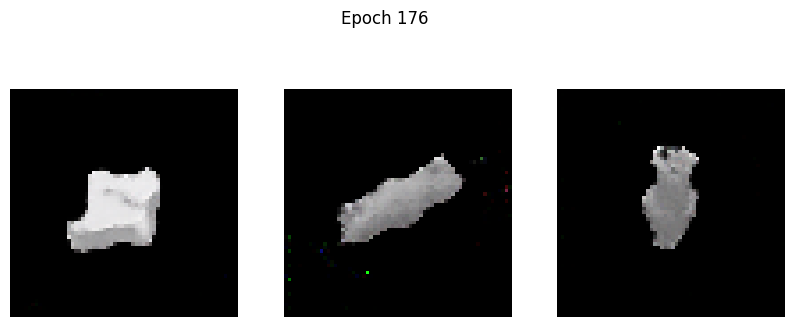

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1015 - g_loss: 3.1785
Epoch 177/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1086 - g_loss: 3.3328

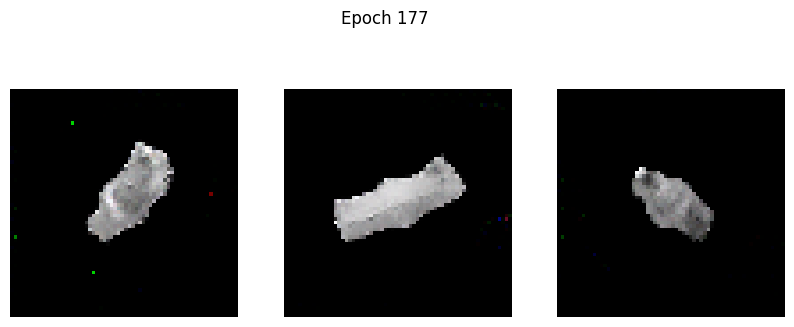

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1086 - g_loss: 3.3328
Epoch 178/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1435 - g_loss: 3.3693

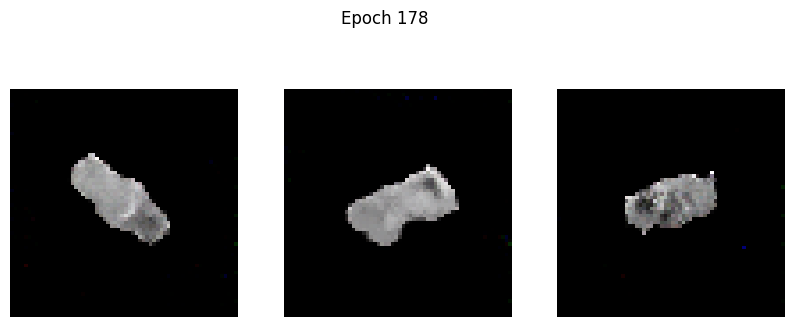

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1433 - g_loss: 3.3690
Epoch 179/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1149 - g_loss: 3.3851

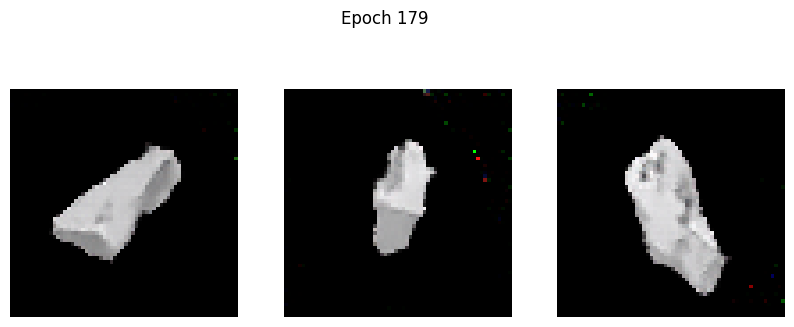

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1151 - g_loss: 3.3854
Epoch 180/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1736 - g_loss: 3.4522

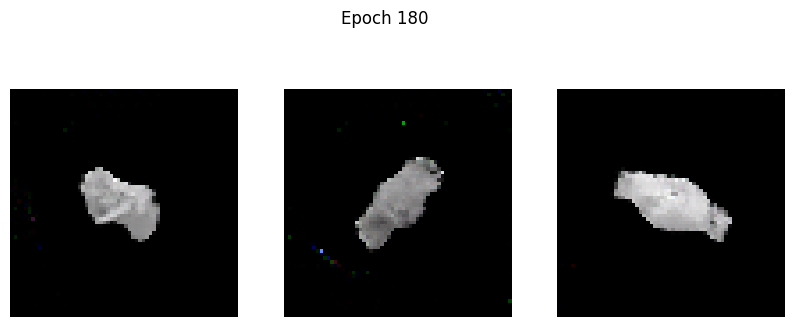

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1732 - g_loss: 3.4520
Epoch 181/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1113 - g_loss: 3.3978

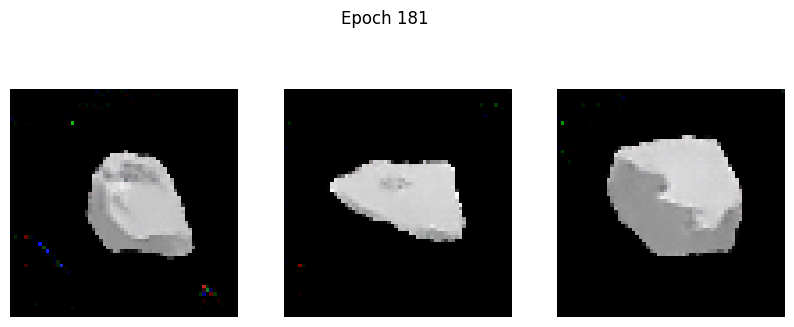

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1114 - g_loss: 3.3985
Epoch 182/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1324 - g_loss: 3.4367

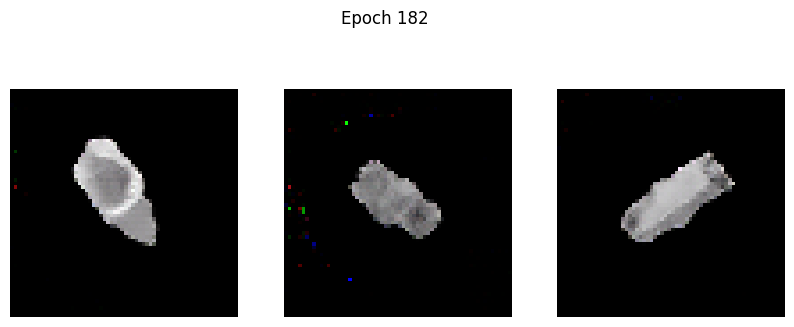

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1331 - g_loss: 3.4382
Epoch 183/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1910 - g_loss: 3.4558

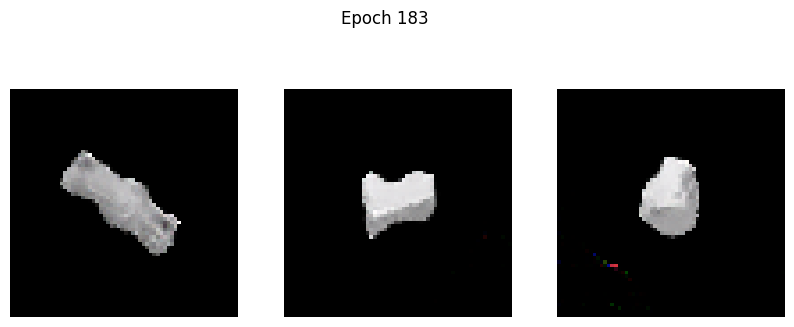

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1909 - g_loss: 3.4557
Epoch 184/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1037 - g_loss: 3.3347

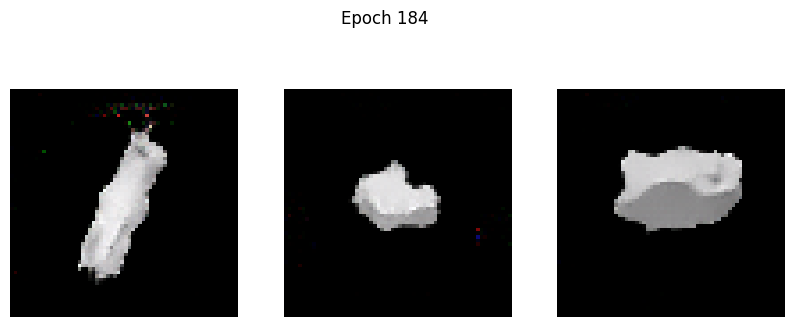

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1038 - g_loss: 3.3354
Epoch 185/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1009 - g_loss: 3.4415

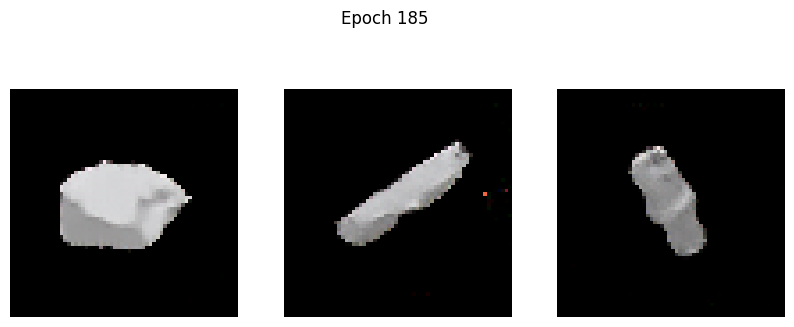

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1012 - g_loss: 3.4420
Epoch 186/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1847 - g_loss: 3.4106

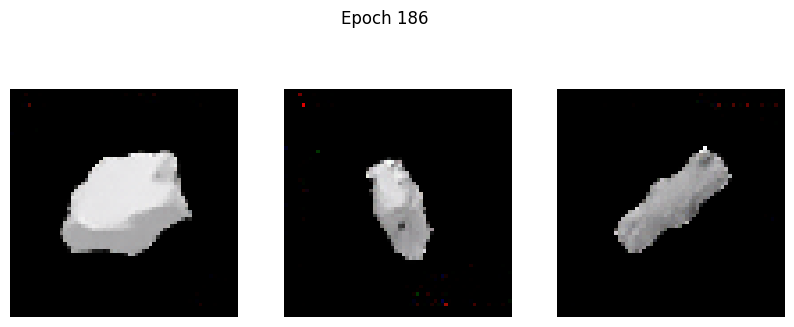

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1843 - g_loss: 3.4113
Epoch 187/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1061 - g_loss: 3.4492

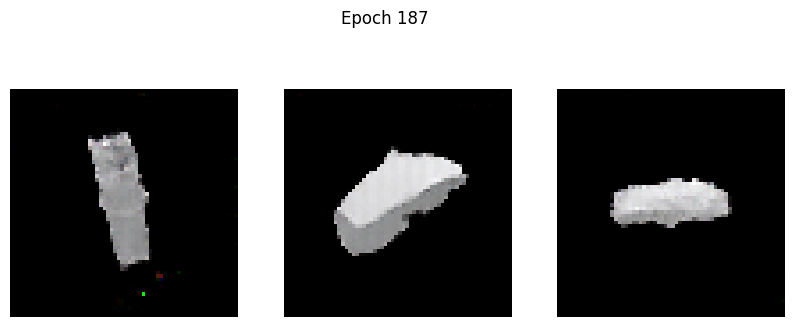

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1062 - g_loss: 3.4494
Epoch 188/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.4086 - g_loss: 3.8340

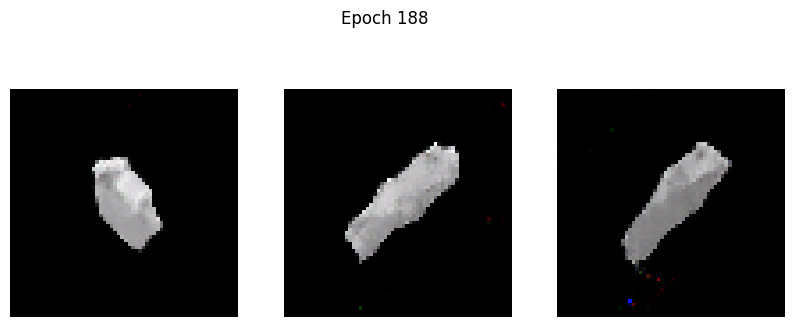

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.4069 - g_loss: 3.8315
Epoch 189/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0972 - g_loss: 3.4384

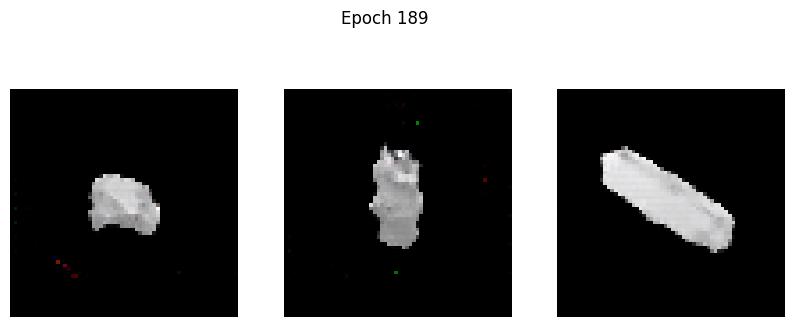

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0972 - g_loss: 3.4389
Epoch 190/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1000 - g_loss: 3.5012

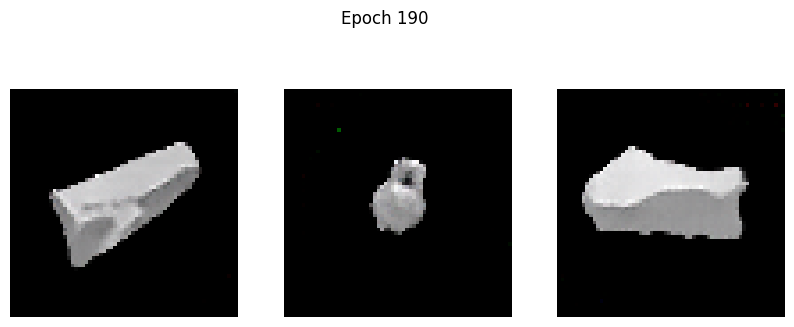

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1001 - g_loss: 3.5013
Epoch 191/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1029 - g_loss: 3.4849

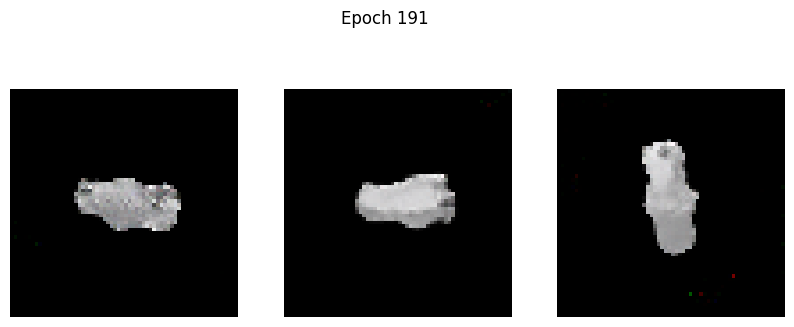

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1030 - g_loss: 3.4849
Epoch 192/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1190 - g_loss: 3.5886

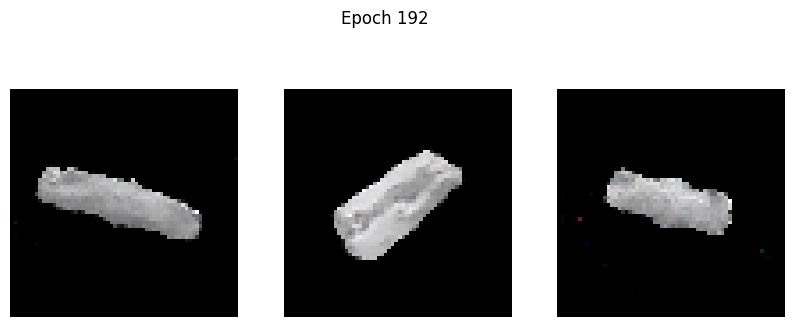

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1189 - g_loss: 3.5887
Epoch 193/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1412 - g_loss: 3.5511

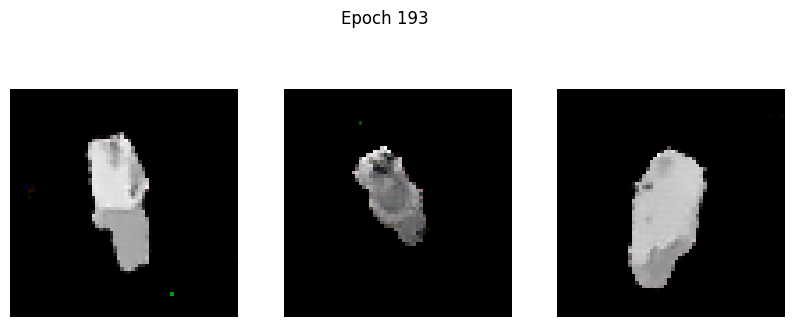

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1413 - g_loss: 3.5516
Epoch 194/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1464 - g_loss: 3.5516

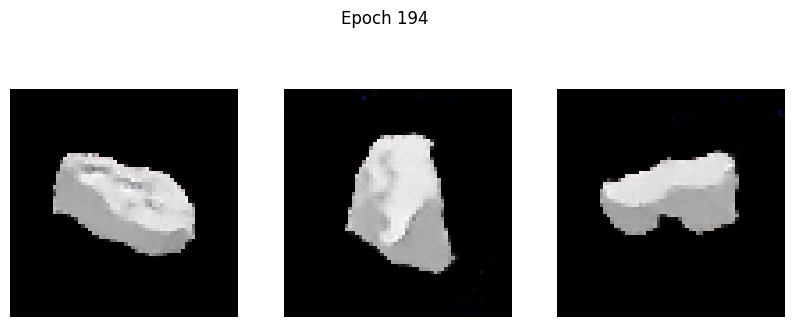

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1463 - g_loss: 3.5523
Epoch 195/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1137 - g_loss: 3.5773

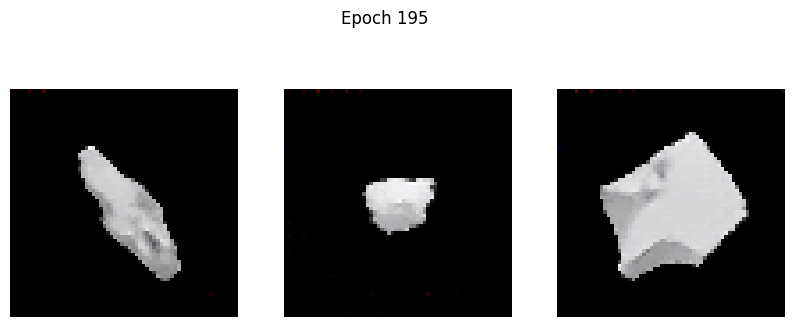

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1136 - g_loss: 3.5776
Epoch 196/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2018 - g_loss: 3.8280

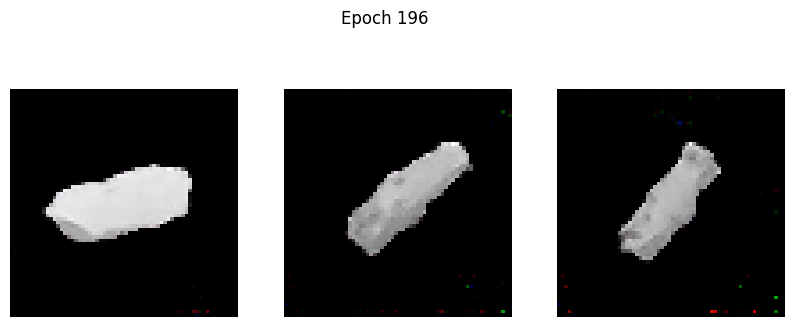

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2015 - g_loss: 3.8269
Epoch 197/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1066 - g_loss: 3.6435

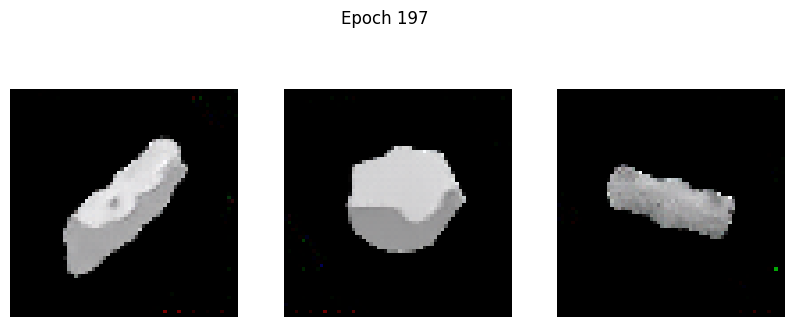

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1067 - g_loss: 3.6433
Epoch 198/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1521 - g_loss: 3.6952

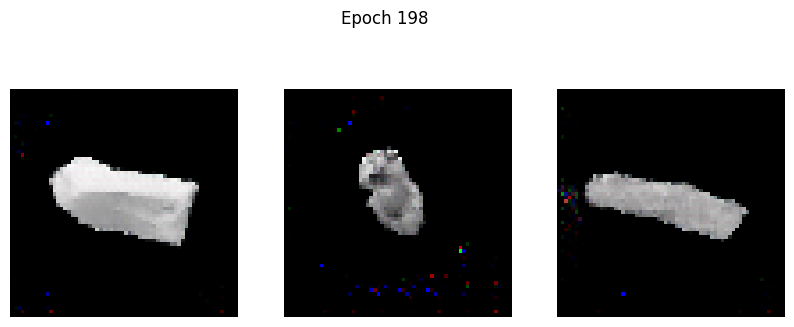

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.1545 - g_loss: 3.6990
Epoch 199/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1688 - g_loss: 3.4477

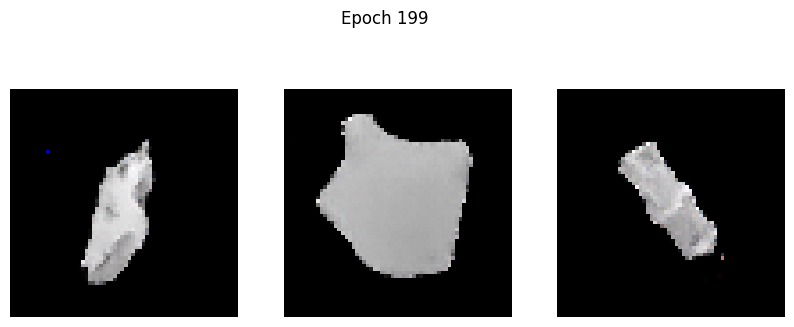

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1686 - g_loss: 3.4477
Epoch 200/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1032 - g_loss: 3.4277

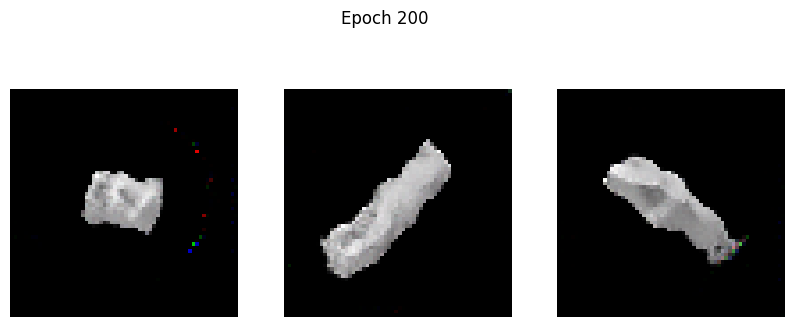

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1031 - g_loss: 3.4279
Epoch 201/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0949 - g_loss: 3.4913

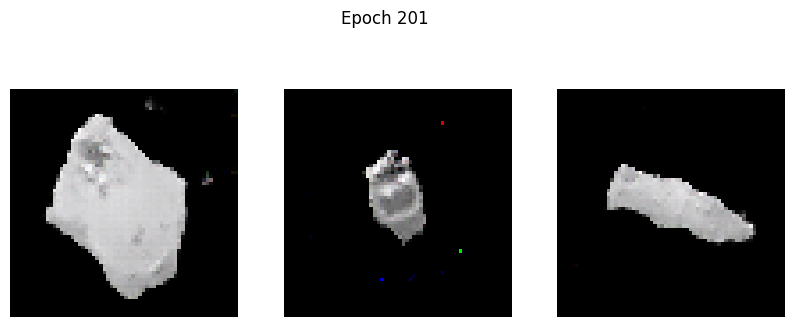

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0949 - g_loss: 3.4920
Epoch 202/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0887 - g_loss: 3.6218

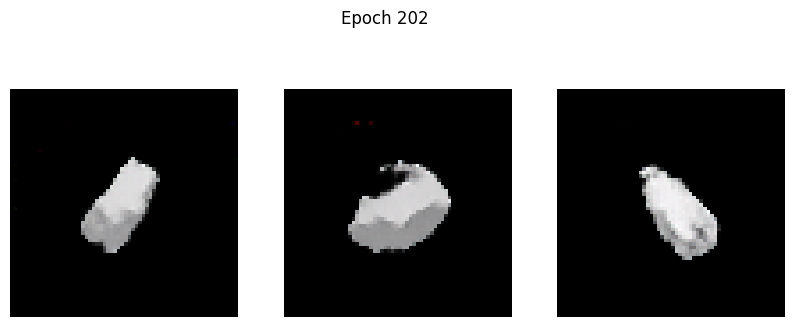

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0888 - g_loss: 3.6218
Epoch 203/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1105 - g_loss: 3.7006

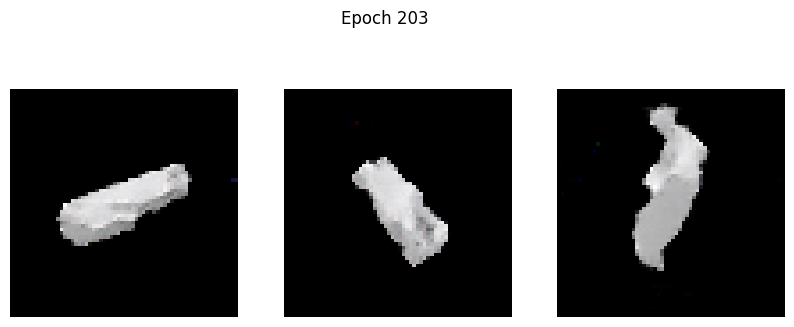

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1107 - g_loss: 3.7002
Epoch 204/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0965 - g_loss: 3.6152

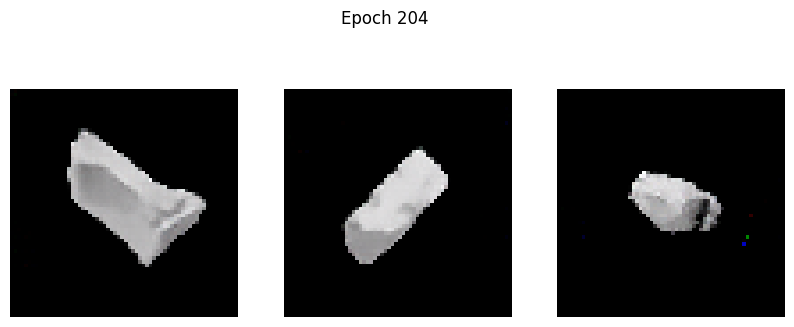

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0964 - g_loss: 3.6153
Epoch 205/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0969 - g_loss: 3.7327

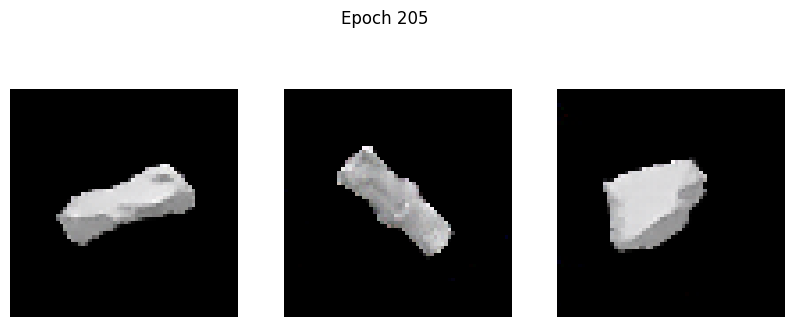

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0969 - g_loss: 3.7325
Epoch 206/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1208 - g_loss: 3.8433

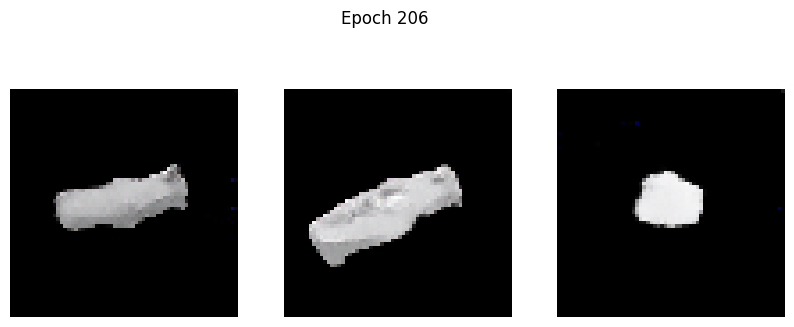

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1208 - g_loss: 3.8427
Epoch 207/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0776 - g_loss: 3.6709

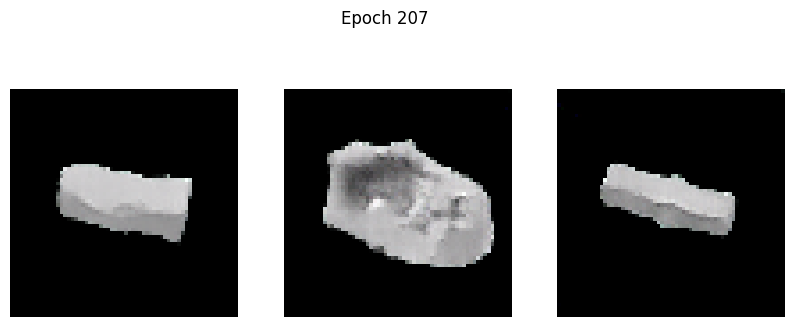

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0777 - g_loss: 3.6708
Epoch 208/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1116 - g_loss: 3.7862

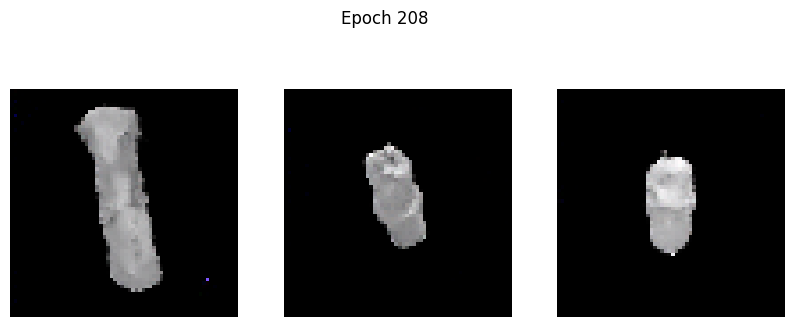

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1116 - g_loss: 3.7864
Epoch 209/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2366 - g_loss: 3.9410

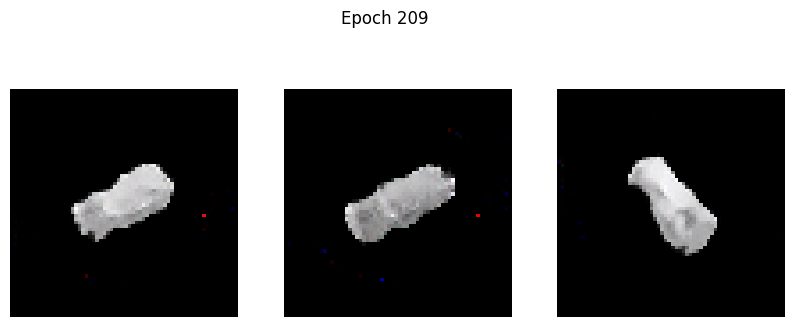

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.2363 - g_loss: 3.9404
Epoch 210/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0970 - g_loss: 3.7031

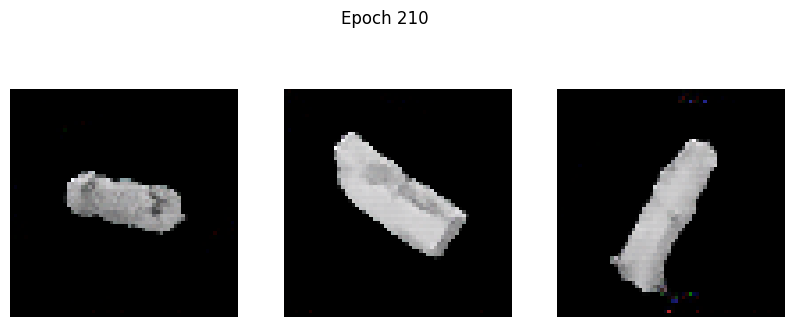

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0970 - g_loss: 3.7037
Epoch 211/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0993 - g_loss: 3.8044

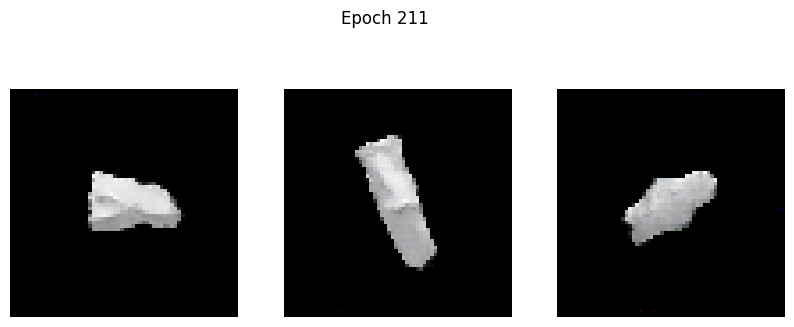

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0994 - g_loss: 3.8044
Epoch 212/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0987 - g_loss: 3.7391

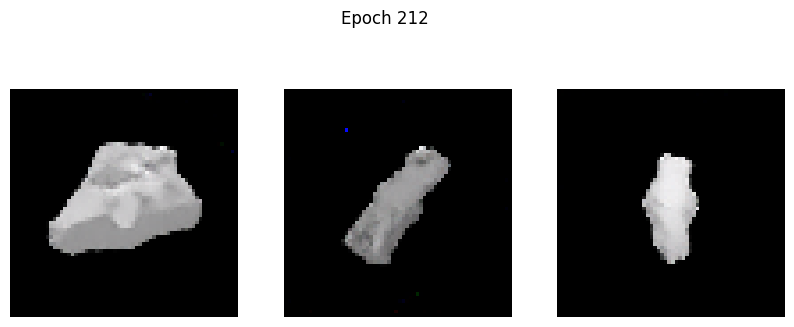

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0986 - g_loss: 3.7387
Epoch 213/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0937 - g_loss: 3.8640

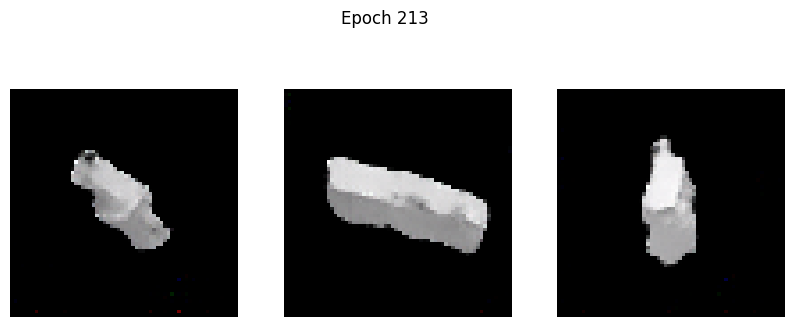

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0938 - g_loss: 3.8638
Epoch 214/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1362 - g_loss: 3.9970

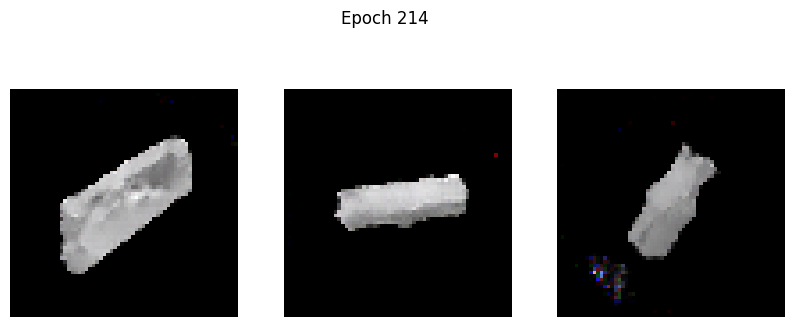

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1361 - g_loss: 3.9962
Epoch 215/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1022 - g_loss: 3.8329

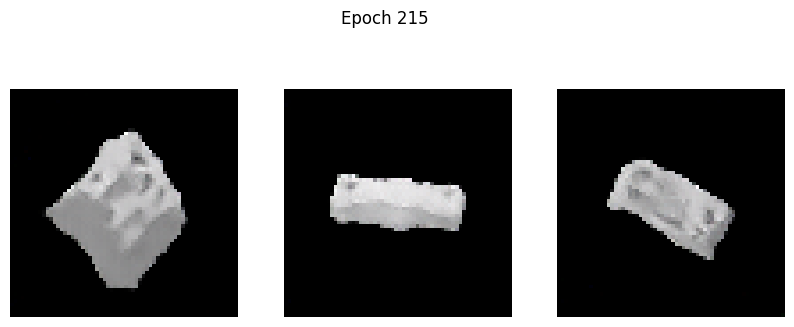

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1022 - g_loss: 3.8329
Epoch 216/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0882 - g_loss: 3.8052

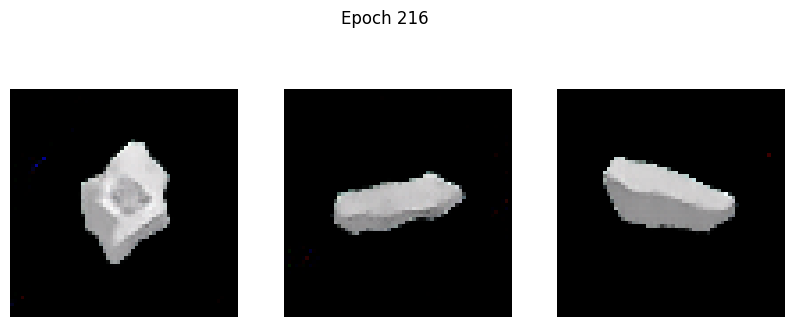

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0883 - g_loss: 3.8051
Epoch 217/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2846 - g_loss: 4.2303

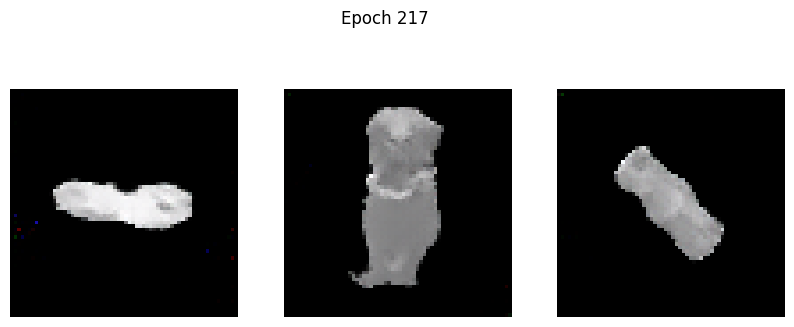

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2835 - g_loss: 4.2276
Epoch 218/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1247 - g_loss: 3.8853

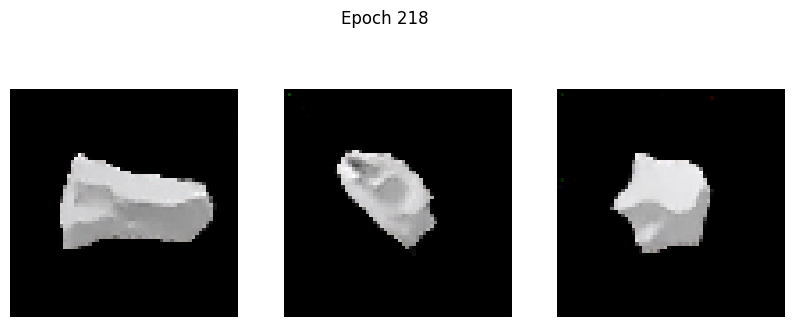

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1255 - g_loss: 3.8862
Epoch 219/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0920 - g_loss: 3.7614

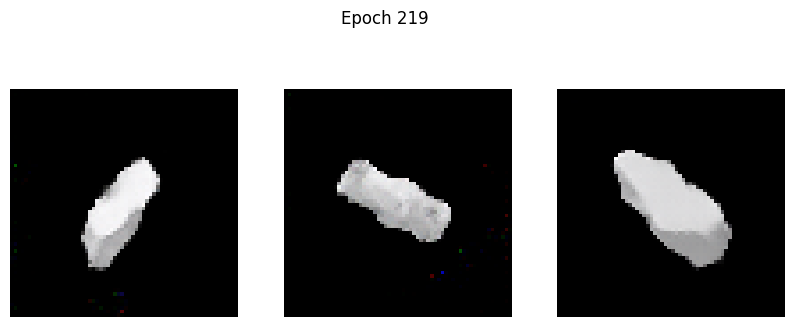

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0921 - g_loss: 3.7615
Epoch 220/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0877 - g_loss: 3.7680

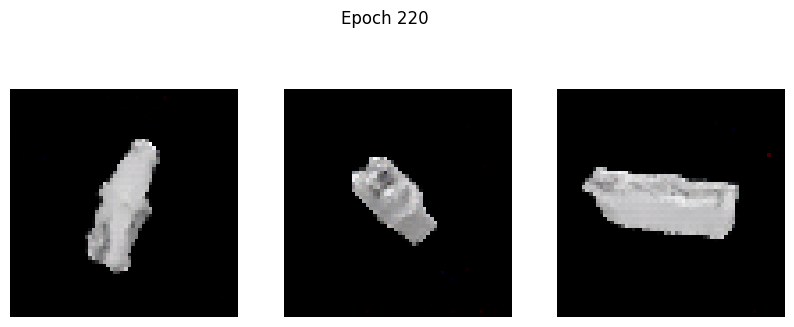

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0877 - g_loss: 3.7683
Epoch 221/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0714 - g_loss: 3.7927

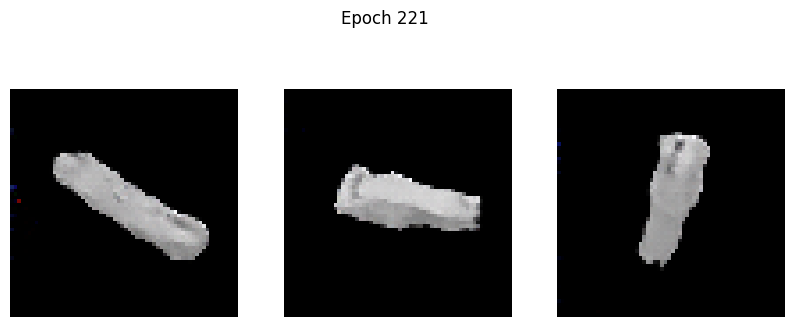

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0714 - g_loss: 3.7927
Epoch 222/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0858 - g_loss: 3.8605

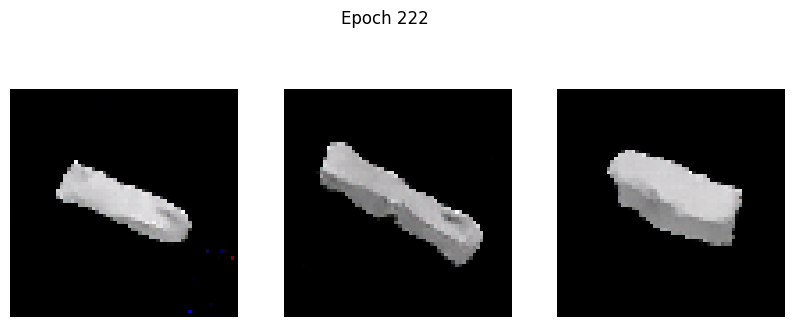

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0859 - g_loss: 3.8610
Epoch 223/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1098 - g_loss: 3.8761

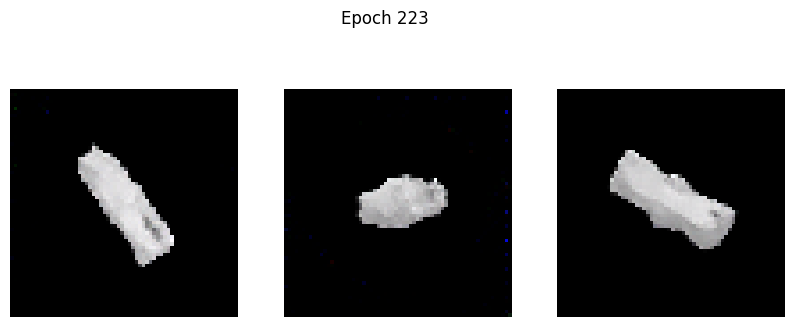

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1095 - g_loss: 3.8765
Epoch 224/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1215 - g_loss: 3.9221

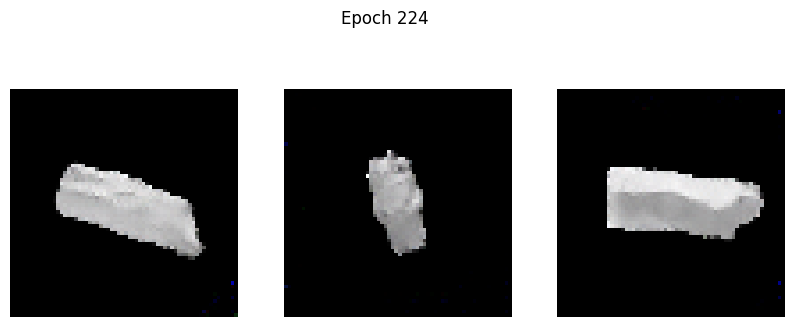

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1214 - g_loss: 3.9220
Epoch 225/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1324 - g_loss: 4.1321

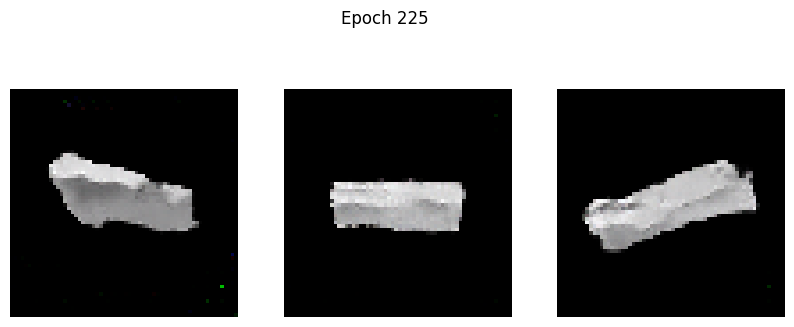

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1326 - g_loss: 4.1312
Epoch 226/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0830 - g_loss: 3.8561

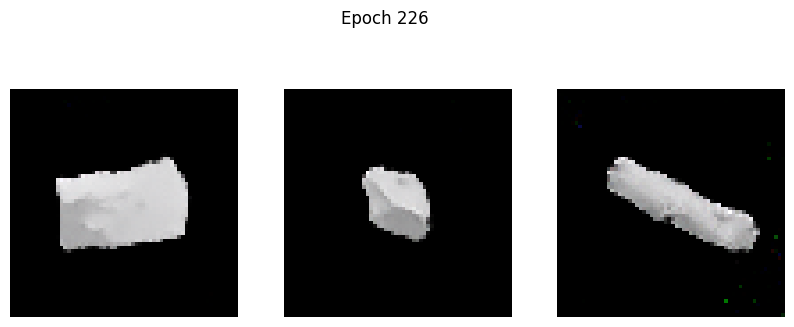

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0831 - g_loss: 3.8566
Epoch 227/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1192 - g_loss: 4.0340

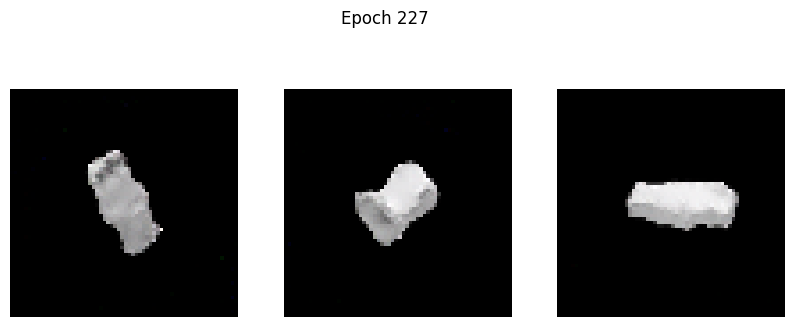

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1193 - g_loss: 4.0337
Epoch 228/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0748 - g_loss: 3.9750

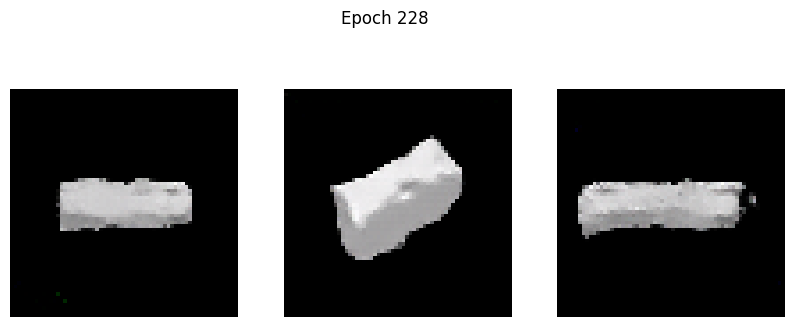

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0748 - g_loss: 3.9750
Epoch 229/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0803 - g_loss: 4.0235

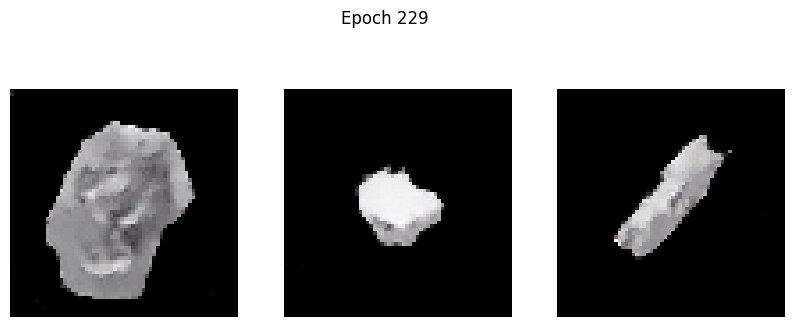

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0804 - g_loss: 4.0232
Epoch 230/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.2339 - g_loss: 4.2514

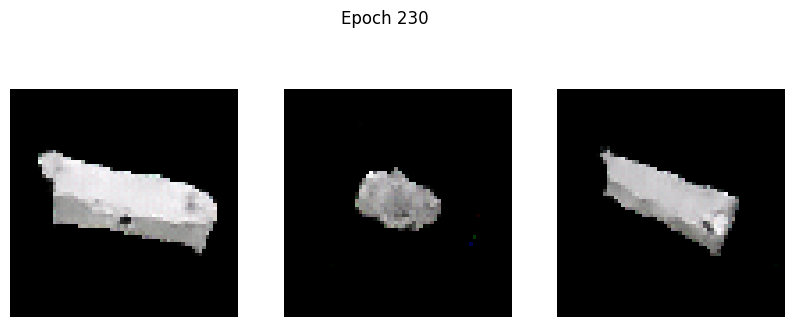

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - d_loss: 0.2361 - g_loss: 4.2541
Epoch 231/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.1301 - g_loss: 3.5372

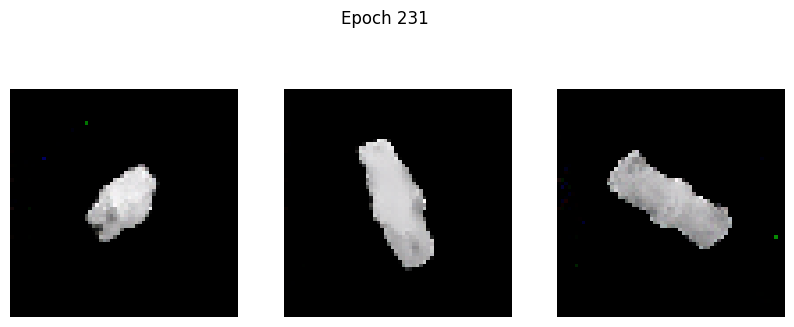

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1299 - g_loss: 3.5377
Epoch 232/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.0685 - g_loss: 3.7245

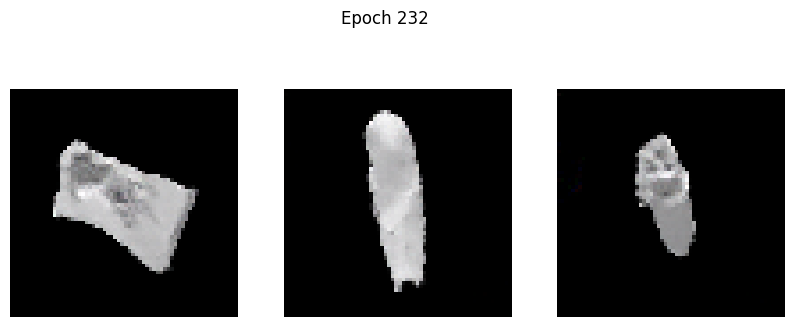

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.0685 - g_loss: 3.7250
Epoch 233/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0668 - g_loss: 3.8677

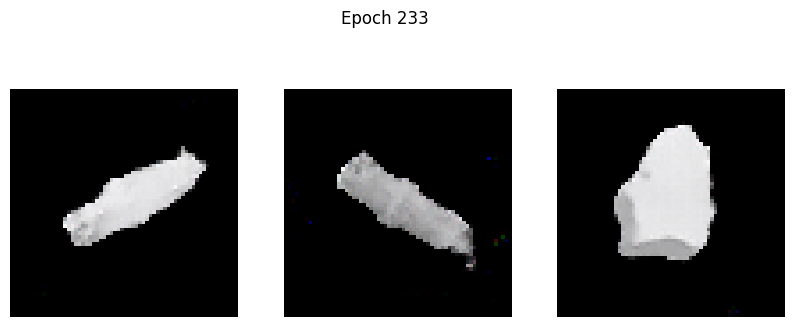

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0668 - g_loss: 3.8676
Epoch 234/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0628 - g_loss: 3.7815

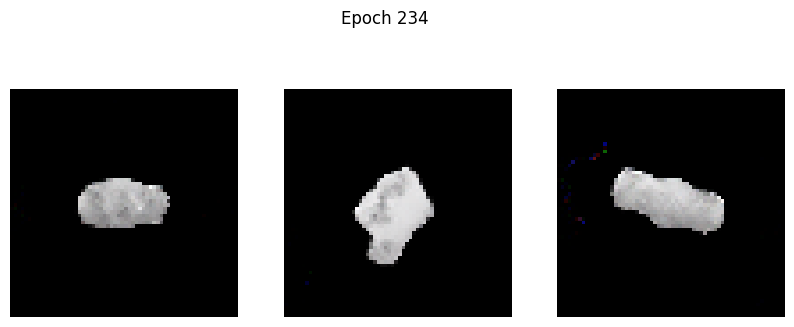

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0630 - g_loss: 3.7822
Epoch 235/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0620 - g_loss: 3.9243

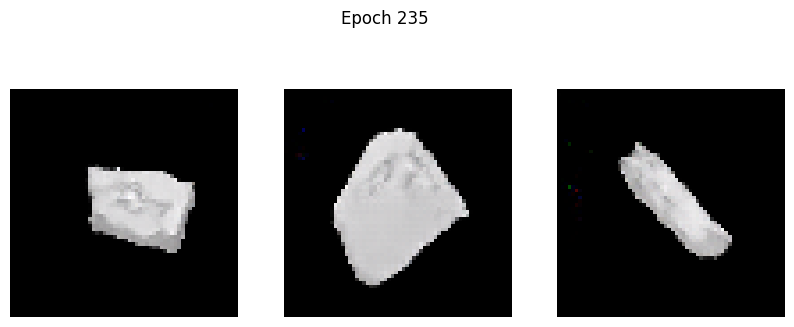

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0621 - g_loss: 3.9243
Epoch 236/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1058 - g_loss: 4.0259

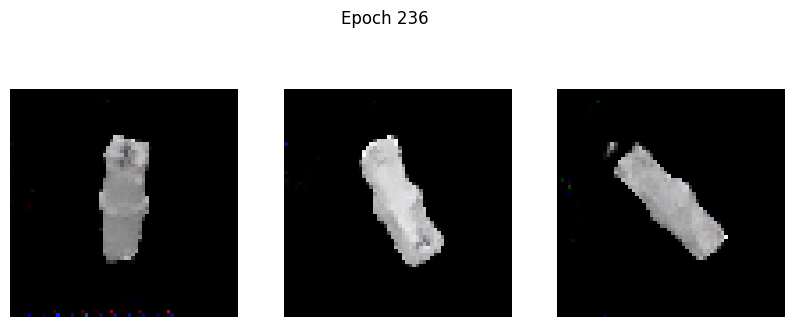

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1059 - g_loss: 4.0257
Epoch 237/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0830 - g_loss: 4.1077

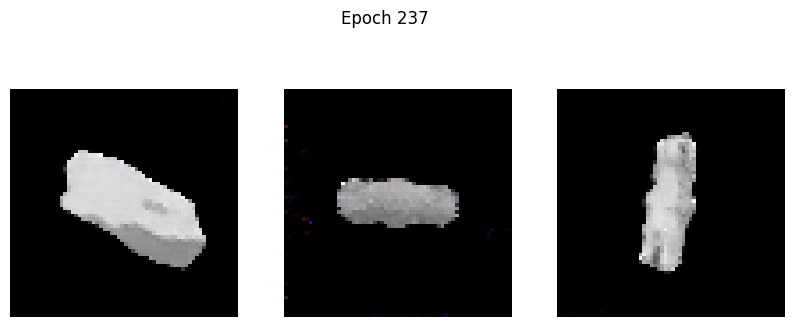

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0830 - g_loss: 4.1072
Epoch 238/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0957 - g_loss: 3.9236

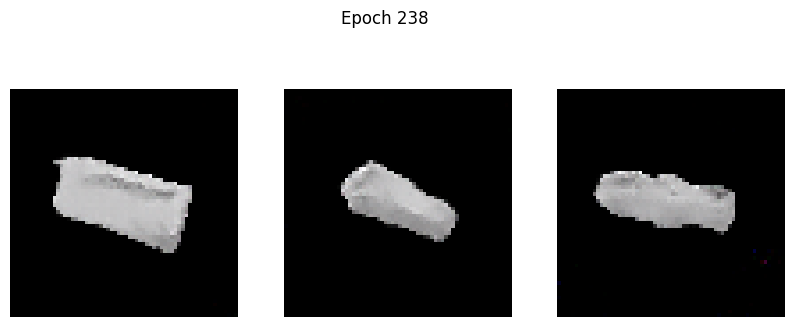

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0958 - g_loss: 3.9243
Epoch 239/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0933 - g_loss: 4.0953

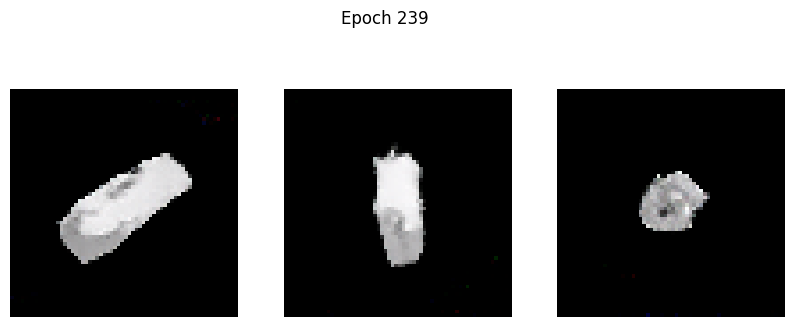

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0933 - g_loss: 4.0948
Epoch 240/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0724 - g_loss: 4.0907

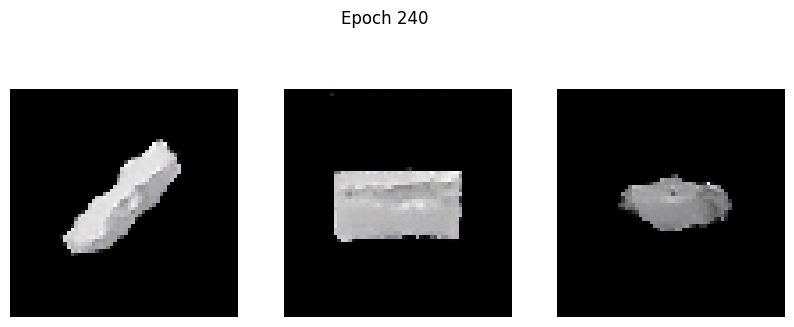

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0728 - g_loss: 4.0912
Epoch 241/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1805 - g_loss: 4.1473

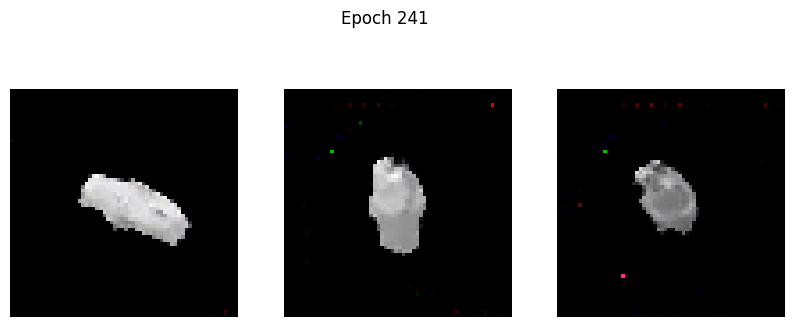

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1799 - g_loss: 4.1471
Epoch 242/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1119 - g_loss: 4.1478

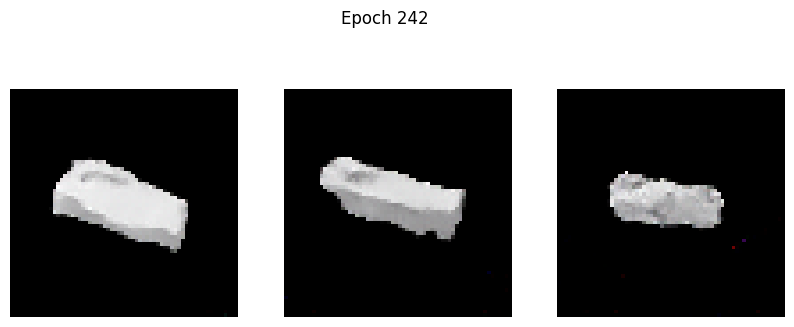

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1124 - g_loss: 4.1485
Epoch 243/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1038 - g_loss: 4.0078

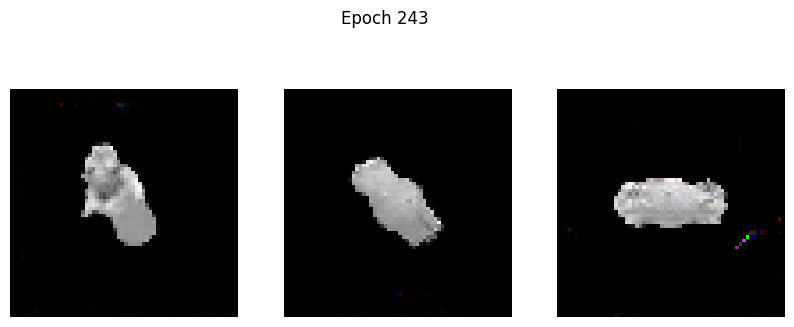

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1036 - g_loss: 4.0074
Epoch 244/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0651 - g_loss: 4.0332

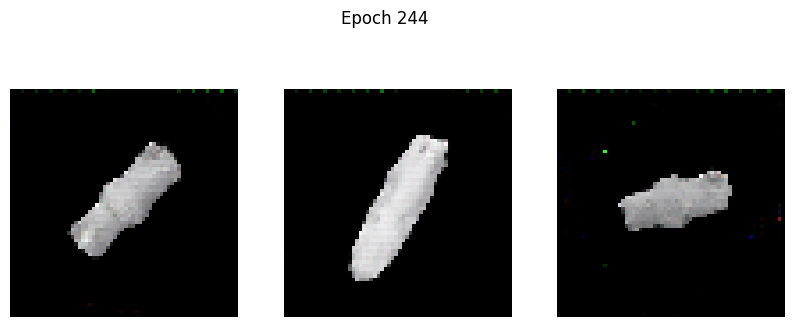

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0651 - g_loss: 4.0329
Epoch 245/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0736 - g_loss: 4.0775

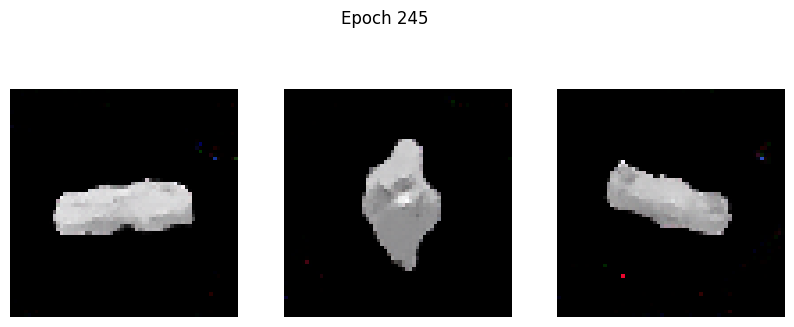

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0738 - g_loss: 4.0777
Epoch 246/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1615 - g_loss: 4.2441

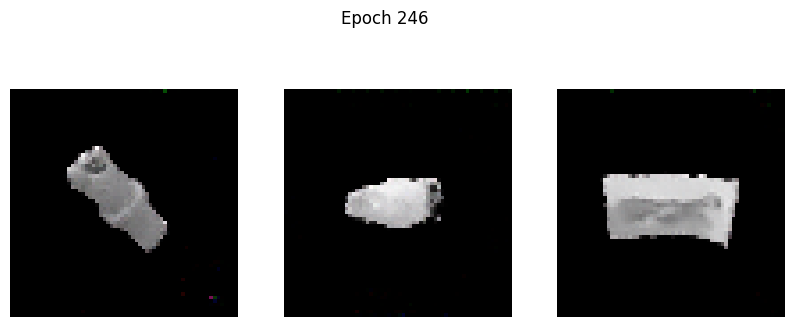

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1610 - g_loss: 4.2434
Epoch 247/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0631 - g_loss: 4.1338

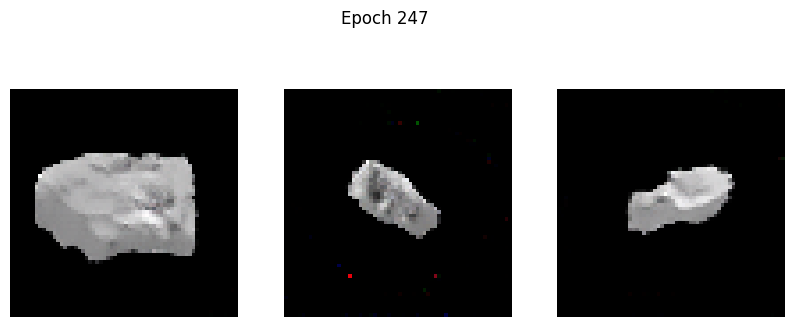

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0630 - g_loss: 4.1332
Epoch 248/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.5590 - g_loss: 5.4318

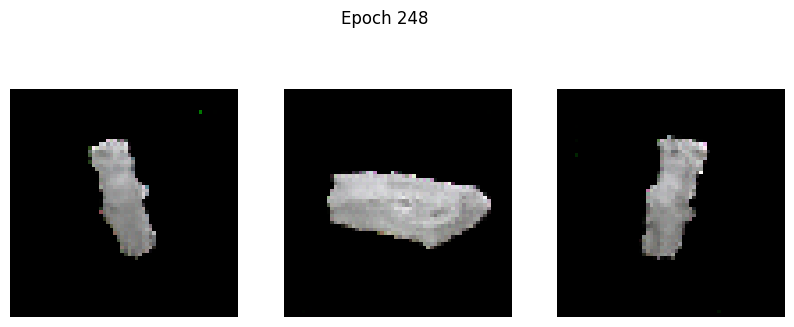

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.5627 - g_loss: 5.4408
Epoch 249/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1906 - g_loss: 3.5724

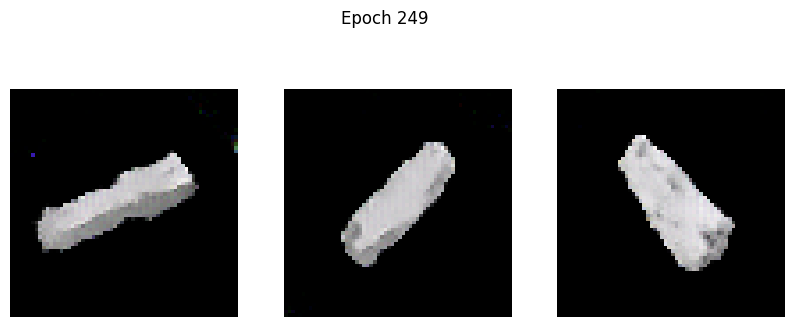

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1905 - g_loss: 3.5720
Epoch 250/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1027 - g_loss: 3.5812

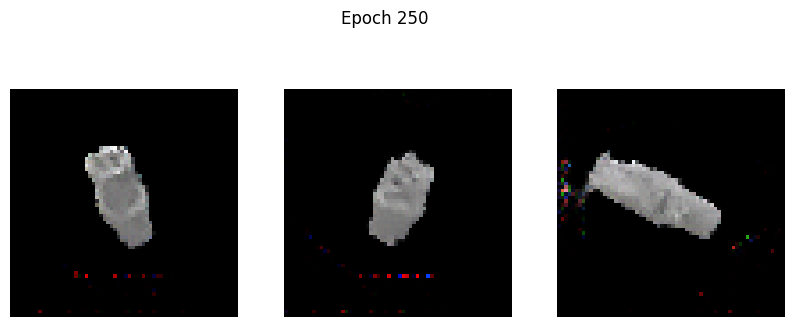

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1027 - g_loss: 3.5814
Epoch 251/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0783 - g_loss: 3.7689

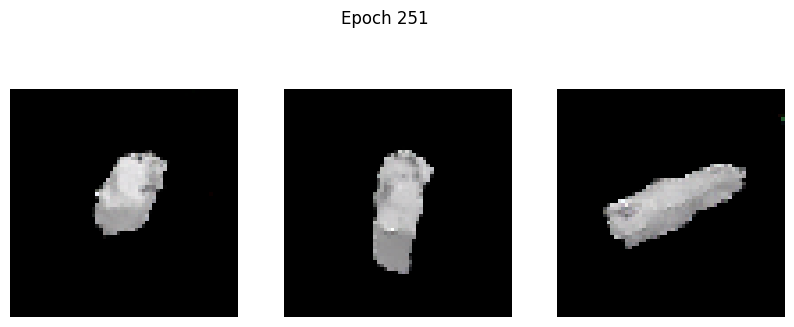

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0783 - g_loss: 3.7690
Epoch 252/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0735 - g_loss: 3.8824

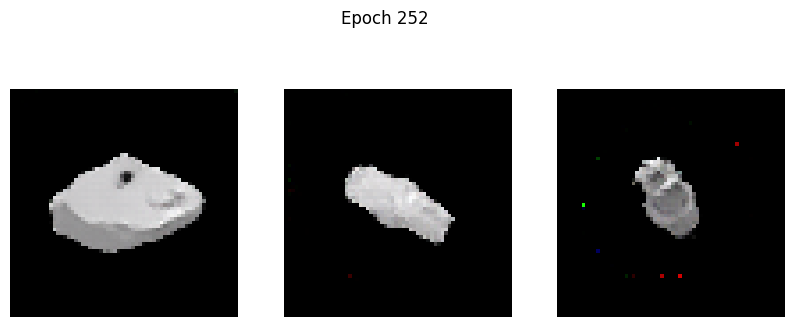

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0736 - g_loss: 3.8827
Epoch 253/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0648 - g_loss: 3.9087

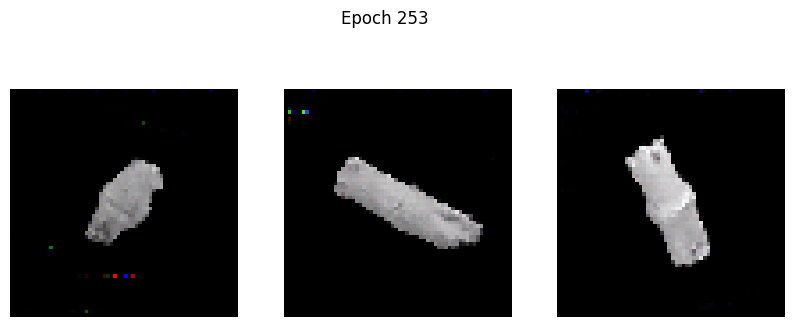

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0649 - g_loss: 3.9085
Epoch 254/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0565 - g_loss: 4.0239

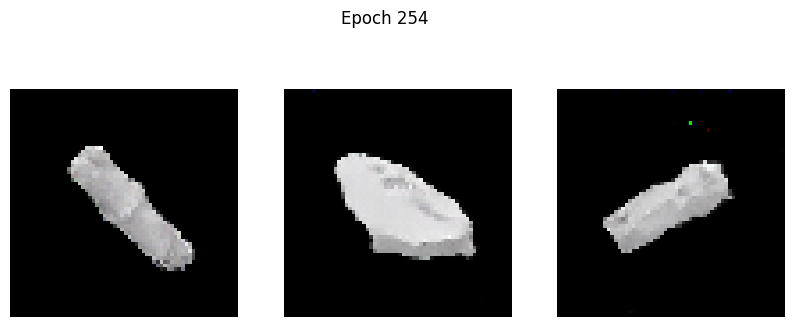

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0565 - g_loss: 4.0240
Epoch 255/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0569 - g_loss: 3.9806

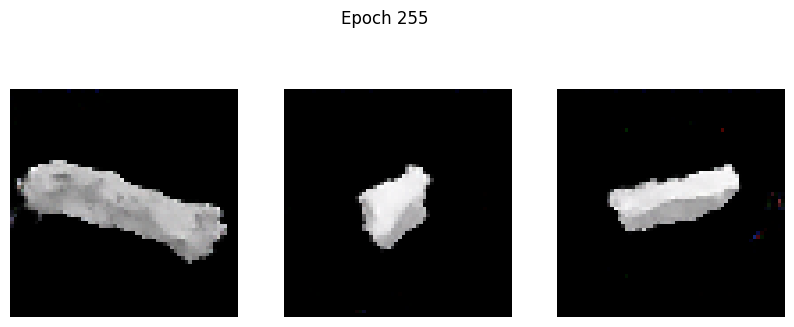

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0571 - g_loss: 3.9814
Epoch 256/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0746 - g_loss: 4.0185

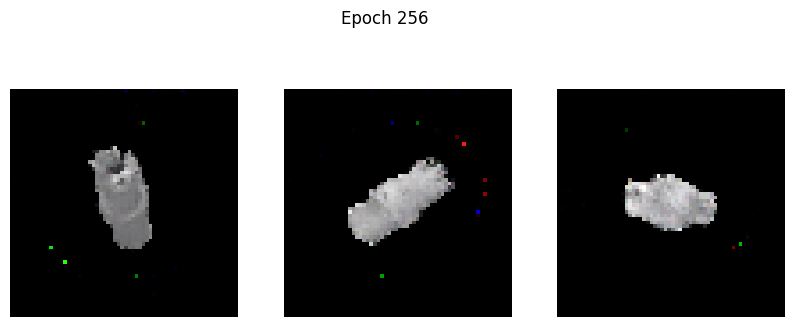

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0747 - g_loss: 4.0186
Epoch 257/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0586 - g_loss: 4.0831

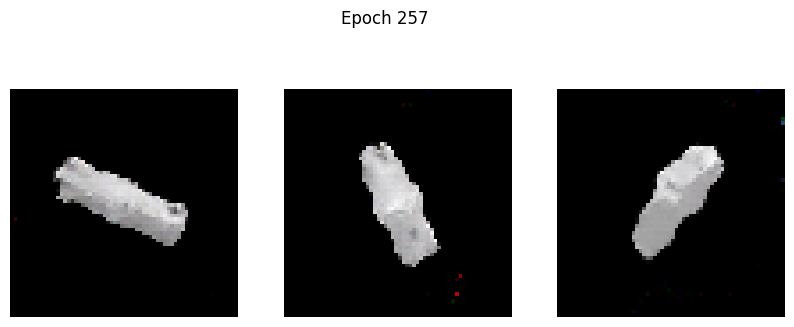

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0586 - g_loss: 4.0830
Epoch 258/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0600 - g_loss: 4.1099

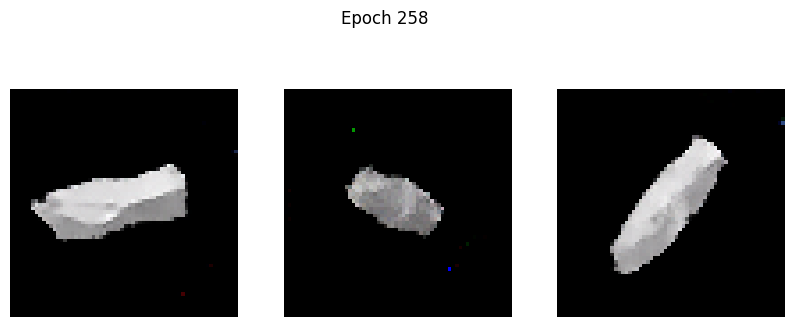

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0601 - g_loss: 4.1104
Epoch 259/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0970 - g_loss: 4.0644

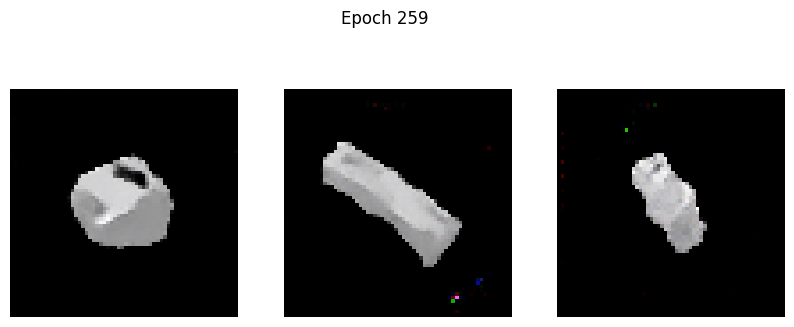

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0969 - g_loss: 4.0649
Epoch 260/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0572 - g_loss: 4.2179

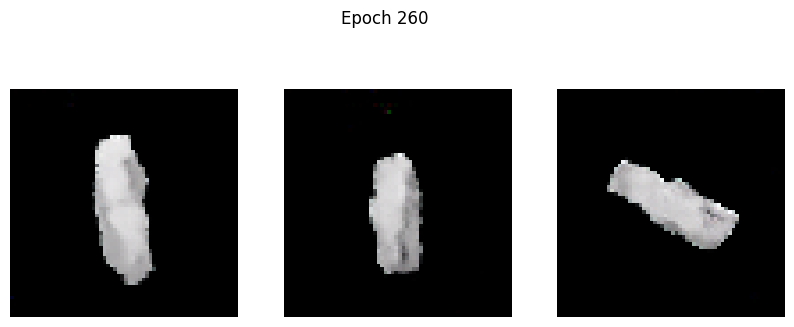

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - d_loss: 0.0572 - g_loss: 4.2176
Epoch 261/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0868 - g_loss: 4.2138

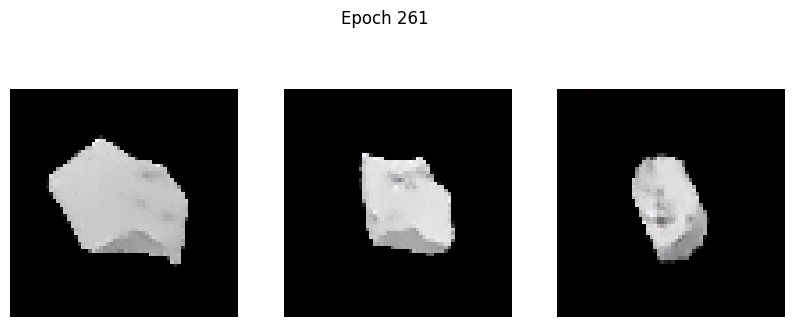

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0868 - g_loss: 4.2140
Epoch 262/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0736 - g_loss: 4.2594

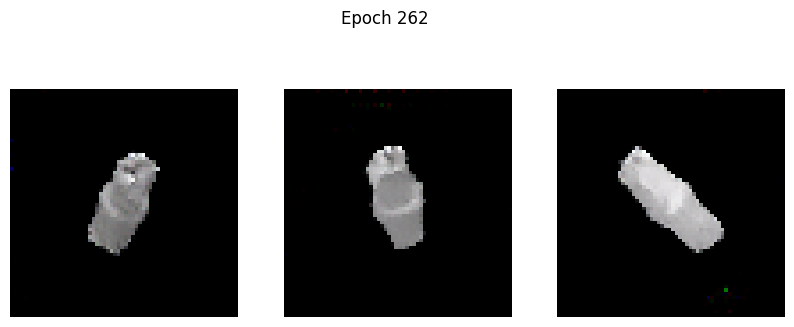

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0735 - g_loss: 4.2595
Epoch 263/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0830 - g_loss: 4.1921

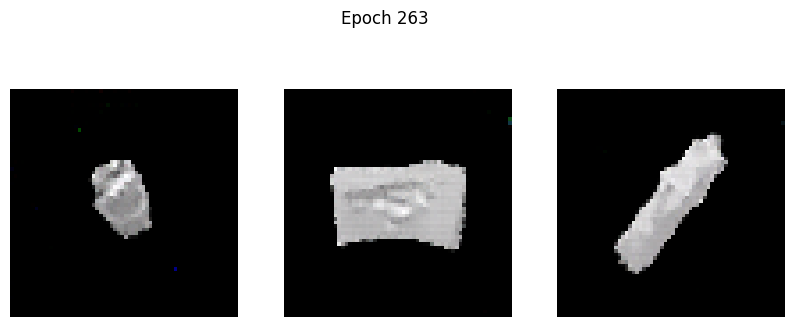

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0829 - g_loss: 4.1927
Epoch 264/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1341 - g_loss: 4.2303

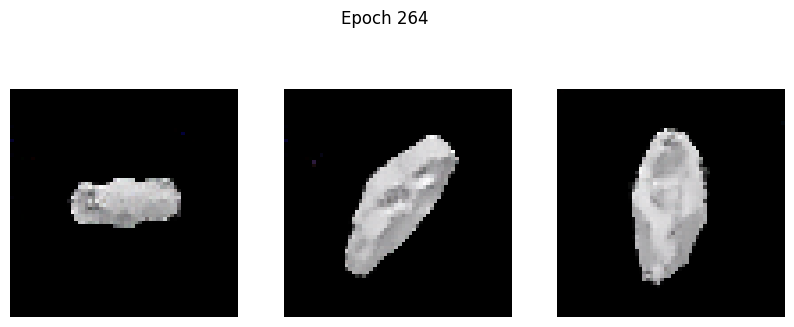

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1349 - g_loss: 4.2324
Epoch 265/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0739 - g_loss: 4.1105

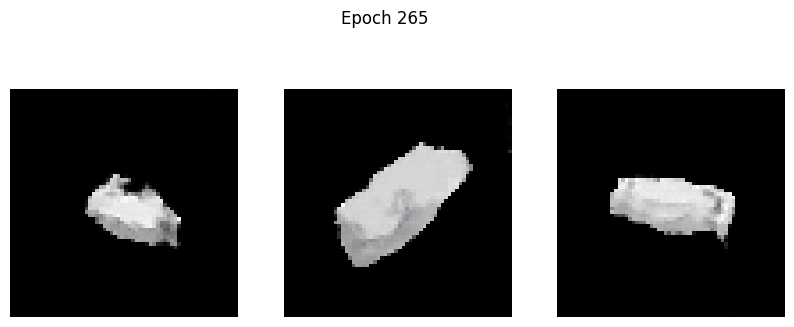

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0738 - g_loss: 4.1107
Epoch 266/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0748 - g_loss: 4.2650

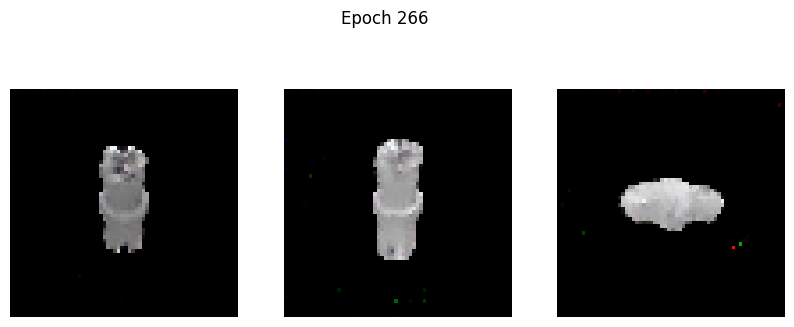

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0748 - g_loss: 4.2651
Epoch 267/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0726 - g_loss: 4.2063

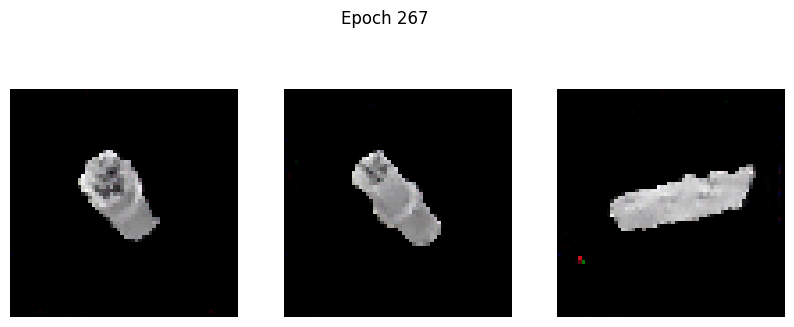

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0728 - g_loss: 4.2071
Epoch 268/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0485 - g_loss: 4.1641

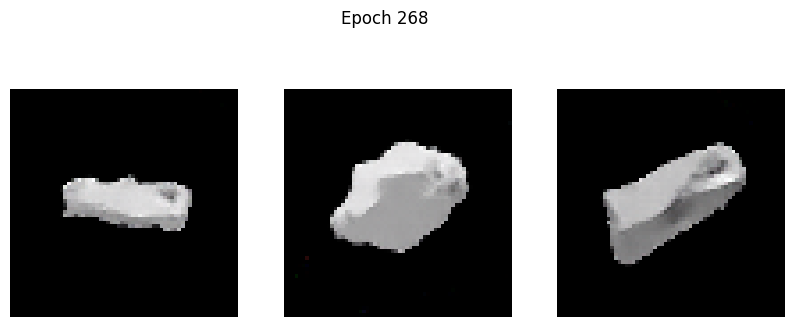

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0486 - g_loss: 4.1645
Epoch 269/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0577 - g_loss: 4.2520

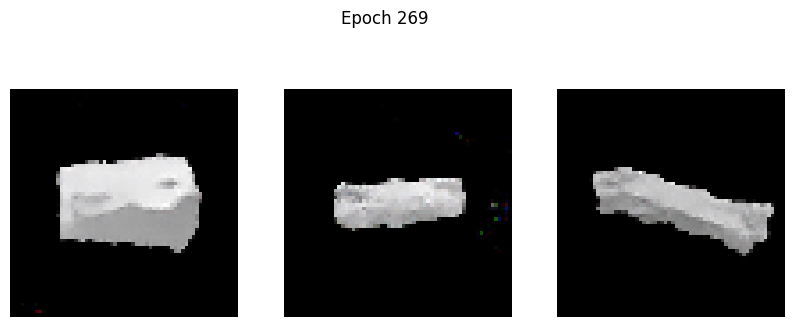

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0578 - g_loss: 4.2518
Epoch 270/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0771 - g_loss: 4.4200

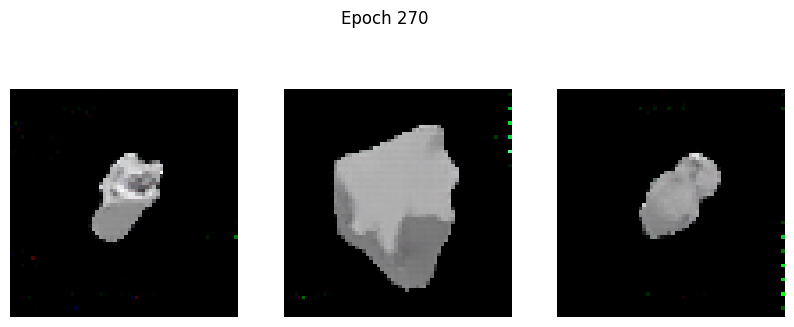

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0774 - g_loss: 4.4194
Epoch 271/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0827 - g_loss: 4.3819

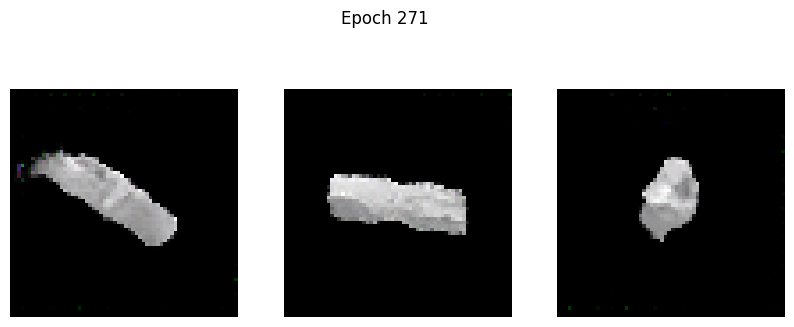

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0825 - g_loss: 4.3807
Epoch 272/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0734 - g_loss: 4.4614

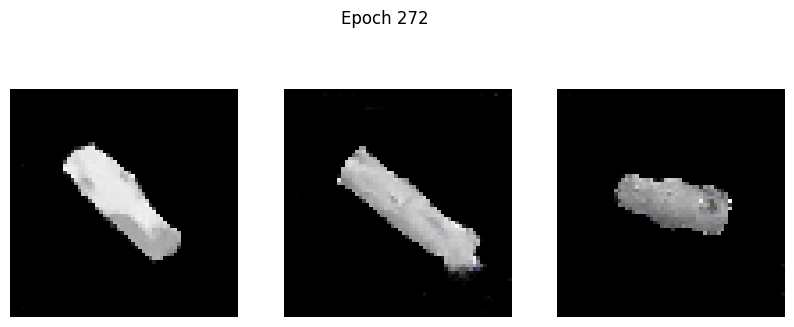

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0733 - g_loss: 4.4605
Epoch 273/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1363 - g_loss: 4.3528

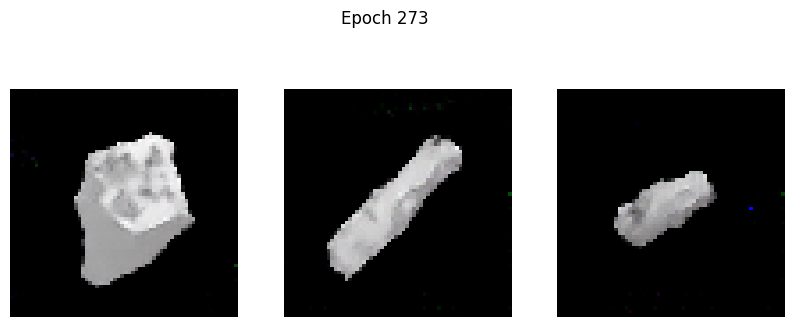

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1359 - g_loss: 4.3530
Epoch 274/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0844 - g_loss: 4.3108

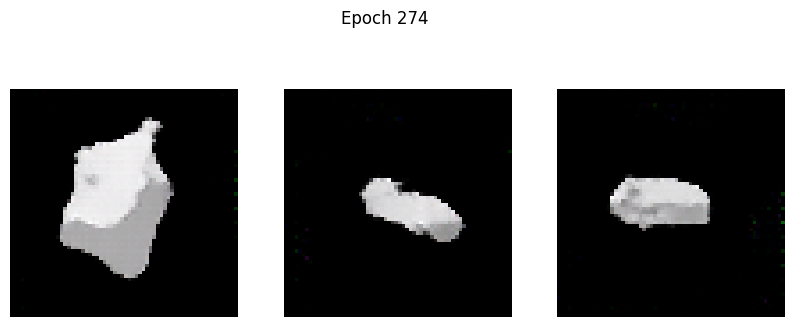

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0845 - g_loss: 4.3112
Epoch 275/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0460 - g_loss: 4.2185

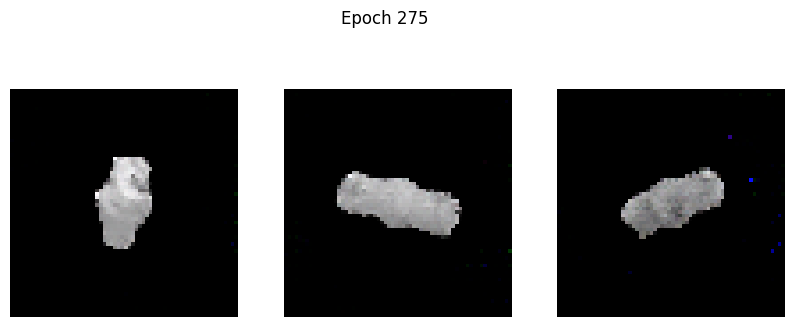

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0461 - g_loss: 4.2193
Epoch 276/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0870 - g_loss: 4.3159

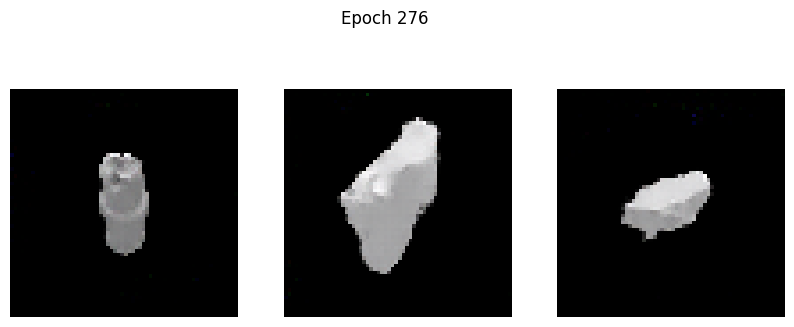

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0870 - g_loss: 4.3165
Epoch 277/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1798 - g_loss: 4.5561

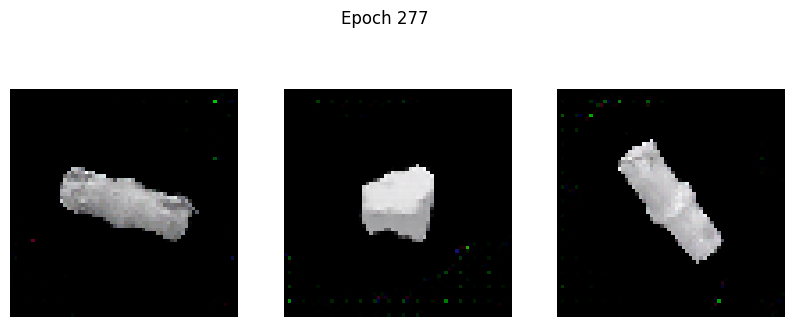

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1795 - g_loss: 4.5553
Epoch 278/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0725 - g_loss: 4.2598

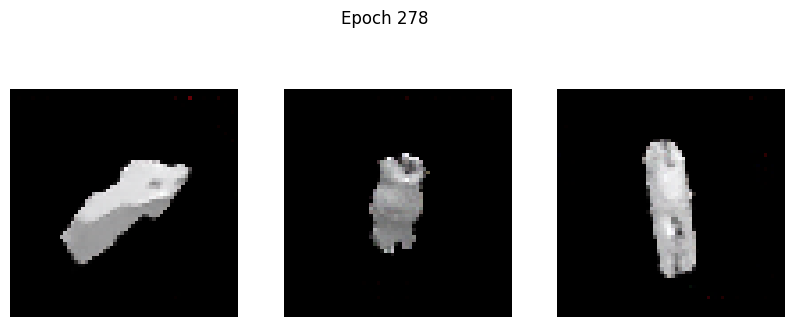

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0724 - g_loss: 4.2603
Epoch 279/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0603 - g_loss: 4.4052

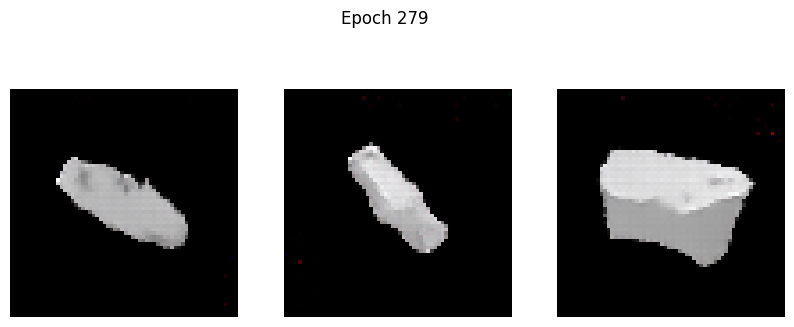

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0604 - g_loss: 4.4044
Epoch 280/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0548 - g_loss: 4.3759

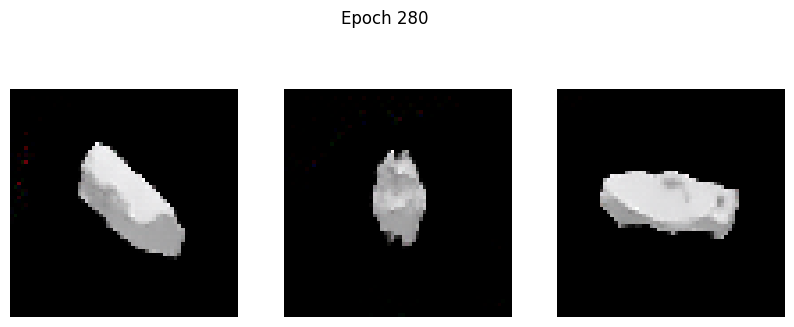

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0549 - g_loss: 4.3759
Epoch 281/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.8837 - g_loss: 6.0237

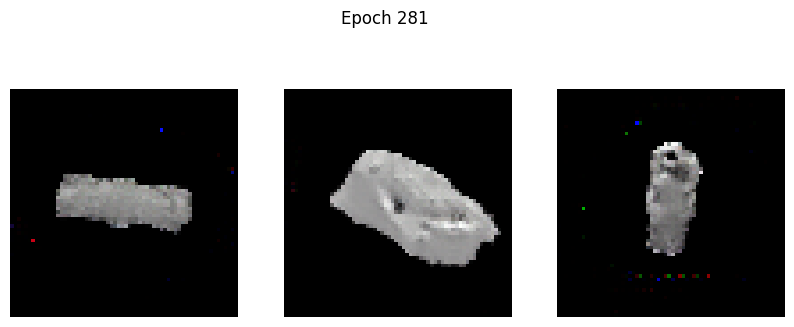

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.8828 - g_loss: 6.0184
Epoch 282/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0917 - g_loss: 3.8261

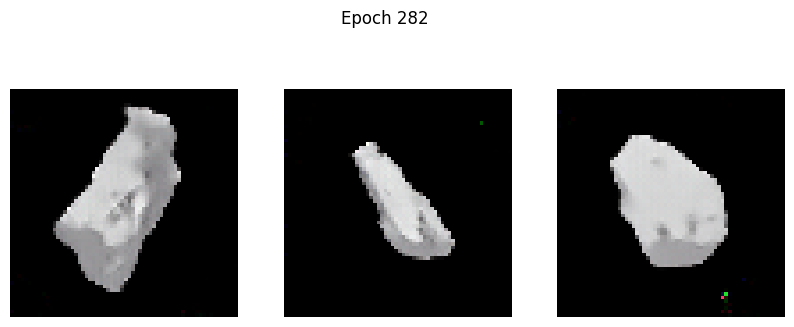

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0917 - g_loss: 3.8259
Epoch 283/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0837 - g_loss: 4.0306

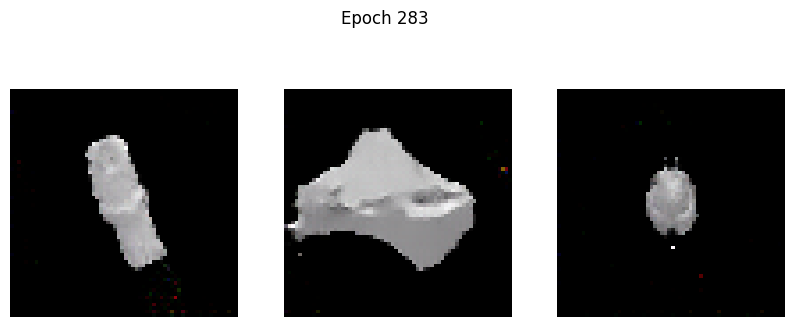

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0837 - g_loss: 4.0303
Epoch 284/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0698 - g_loss: 4.1418

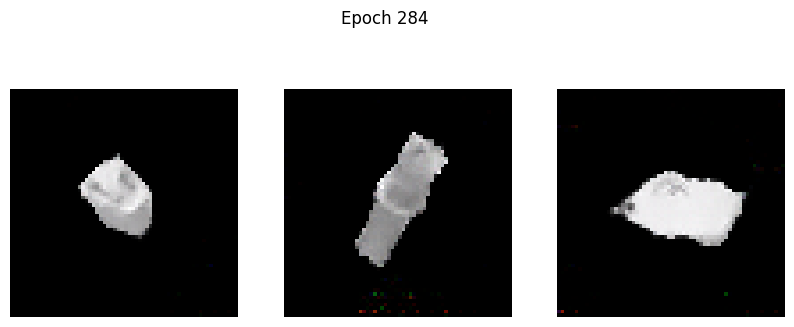

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0698 - g_loss: 4.1414
Epoch 285/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0454 - g_loss: 4.0327

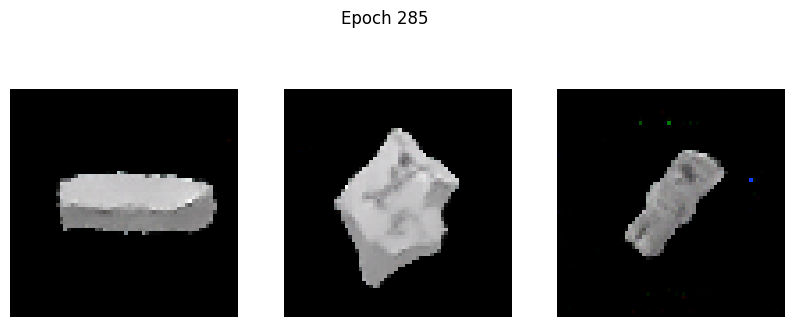

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0454 - g_loss: 4.0327
Epoch 286/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0508 - g_loss: 4.2542

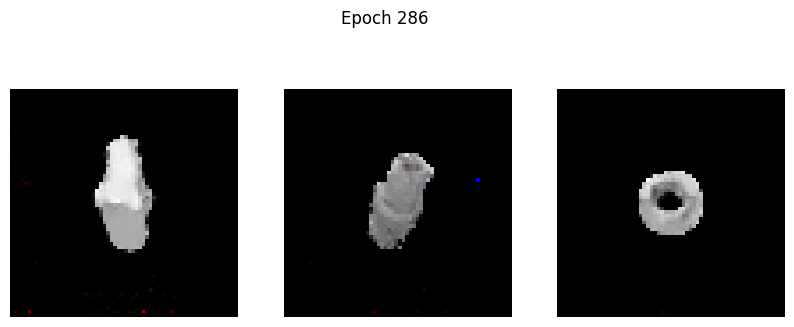

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0508 - g_loss: 4.2539
Epoch 287/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0548 - g_loss: 4.3259

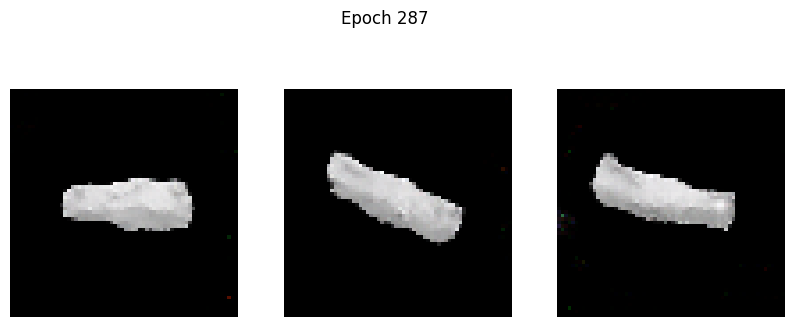

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0548 - g_loss: 4.3253
Epoch 288/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0612 - g_loss: 4.3154

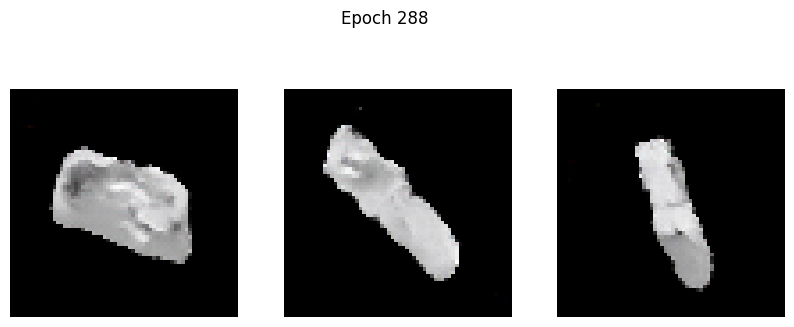

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0612 - g_loss: 4.3152
Epoch 289/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0402 - g_loss: 4.4228

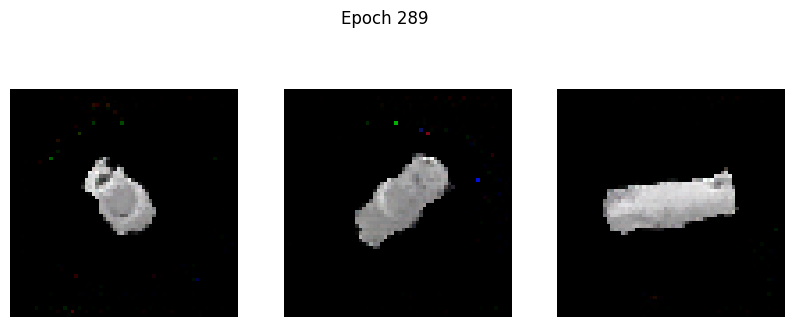

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0403 - g_loss: 4.4223
Epoch 290/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0687 - g_loss: 4.4393

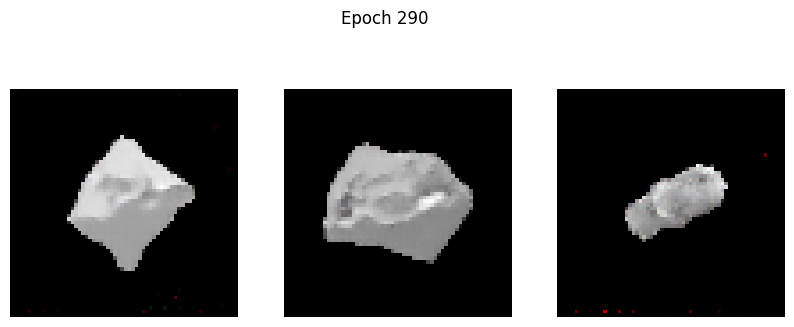

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0692 - g_loss: 4.4398
Epoch 291/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0845 - g_loss: 4.3856

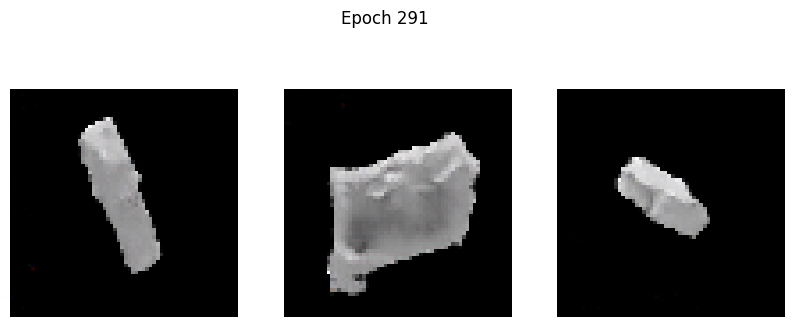

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0843 - g_loss: 4.3853
Epoch 292/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0475 - g_loss: 4.4063

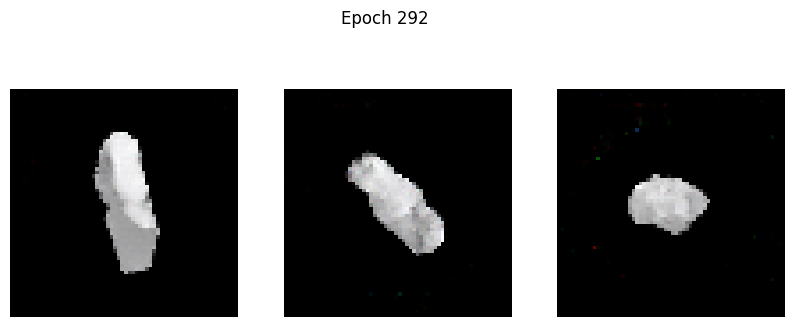

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0475 - g_loss: 4.4060
Epoch 293/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0689 - g_loss: 4.5303

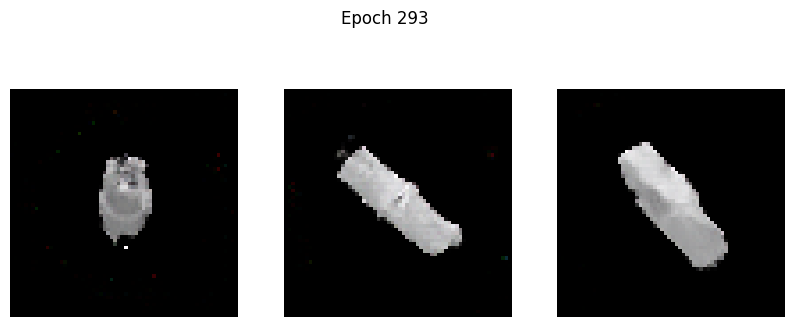

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0689 - g_loss: 4.5296
Epoch 294/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0404 - g_loss: 4.4392

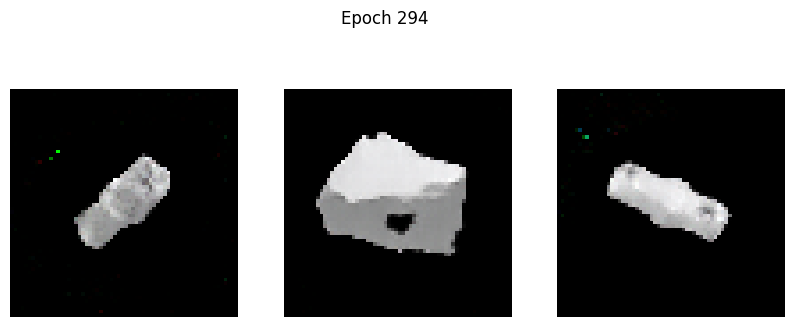

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0404 - g_loss: 4.4393
Epoch 295/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0570 - g_loss: 4.4739

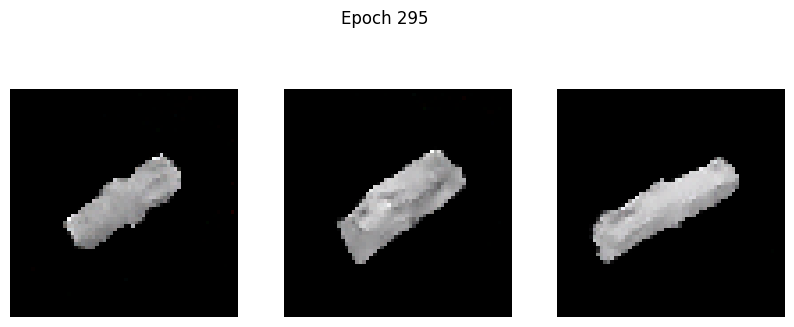

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0570 - g_loss: 4.4741
Epoch 296/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0827 - g_loss: 4.6474

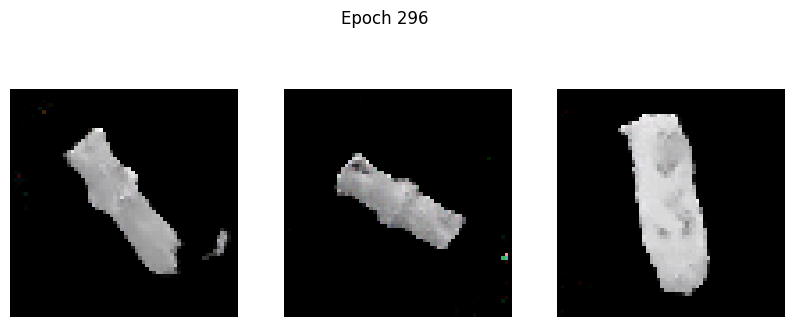

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0828 - g_loss: 4.6469
Epoch 297/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0744 - g_loss: 4.5982

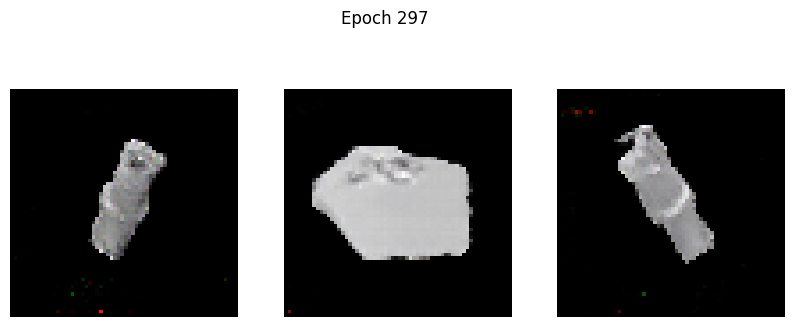

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0744 - g_loss: 4.5975
Epoch 298/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0882 - g_loss: 4.6509

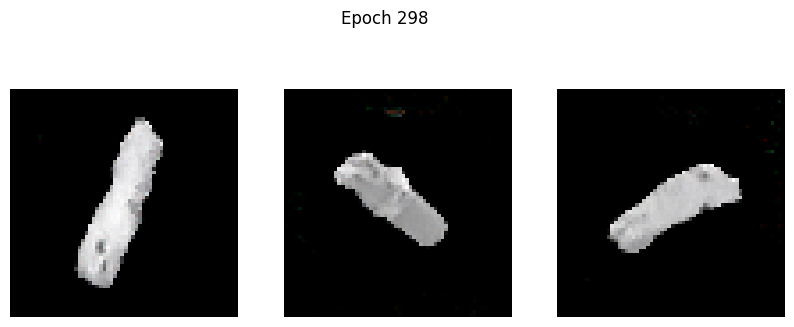

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0881 - g_loss: 4.6495
Epoch 299/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0520 - g_loss: 4.6667

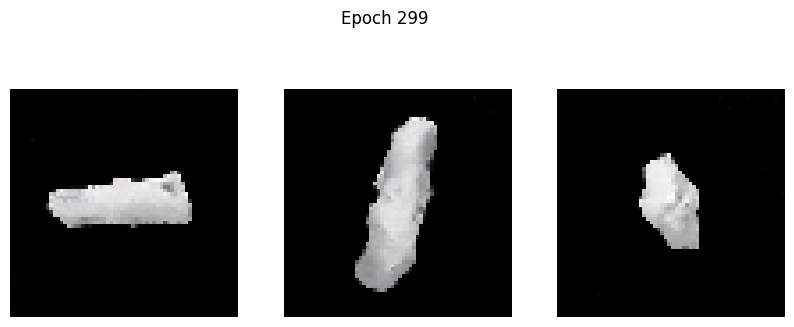

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0521 - g_loss: 4.6660
Epoch 300/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0619 - g_loss: 4.5699

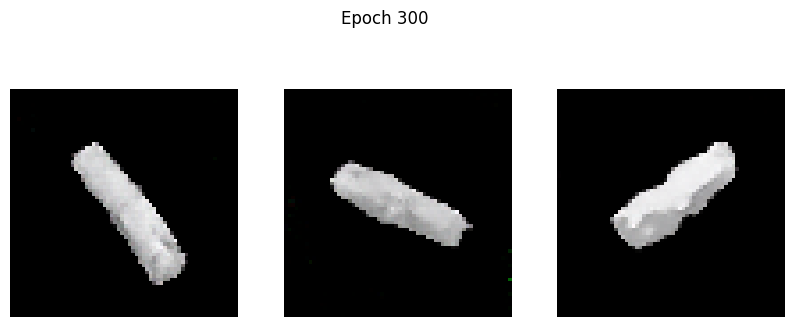

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0618 - g_loss: 4.5694
Epoch 301/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0392 - g_loss: 4.5207

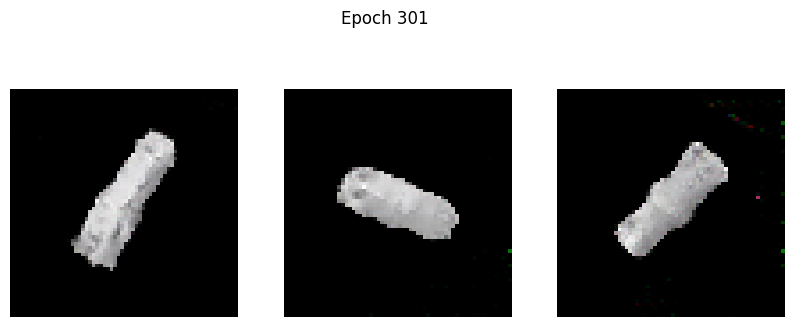

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0397 - g_loss: 4.5219
Epoch 302/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0698 - g_loss: 4.6575

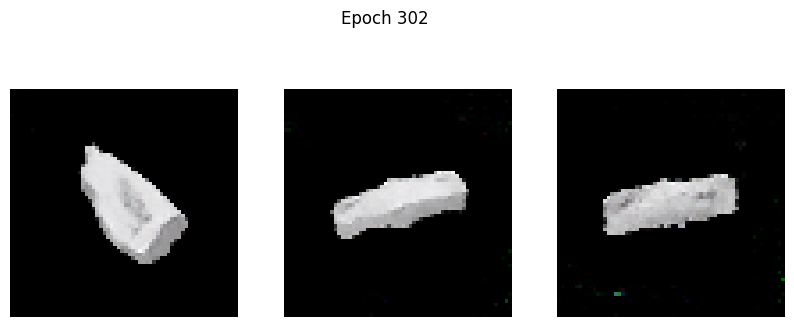

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0697 - g_loss: 4.6563
Epoch 303/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0316 - g_loss: 4.5911

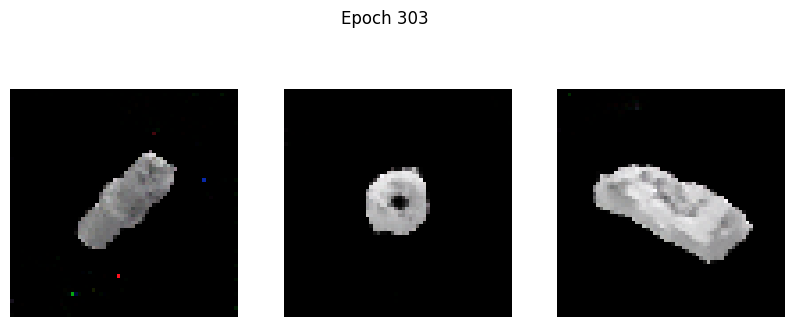

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0317 - g_loss: 4.5909
Epoch 304/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0691 - g_loss: 4.6149

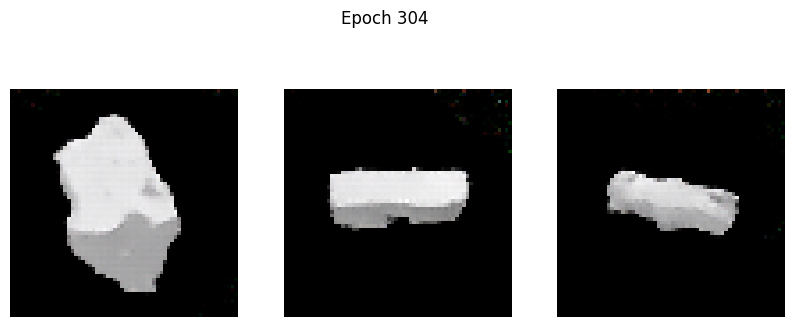

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0690 - g_loss: 4.6145
Epoch 305/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0937 - g_loss: 4.8013

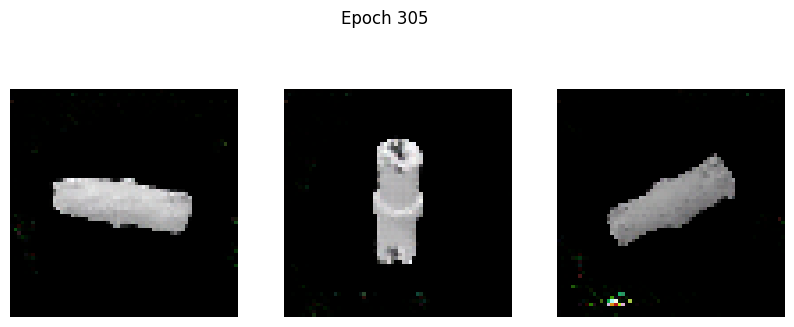

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0937 - g_loss: 4.8010
Epoch 306/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0449 - g_loss: 4.5245

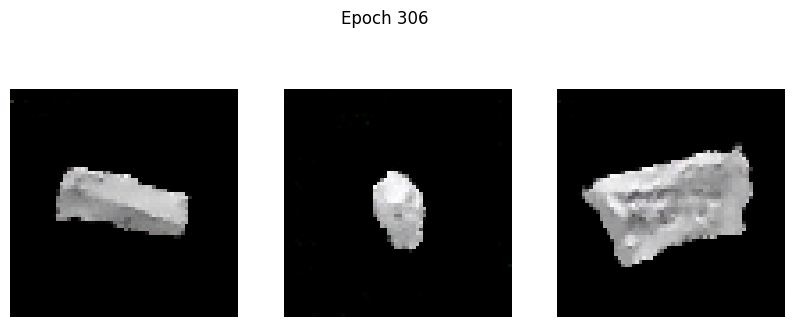

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - d_loss: 0.0450 - g_loss: 4.5248
Epoch 307/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0477 - g_loss: 4.6576

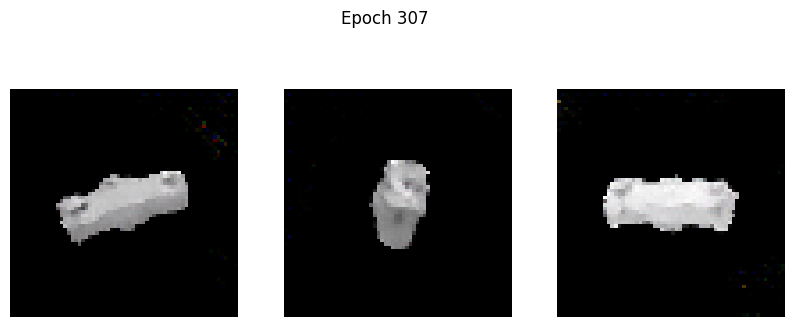

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0479 - g_loss: 4.6582
Epoch 308/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.1111 - g_loss: 4.8946

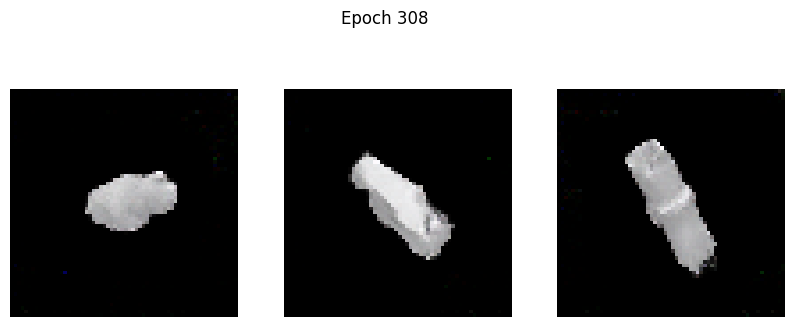

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.1109 - g_loss: 4.8933
Epoch 309/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1081 - g_loss: 4.7053

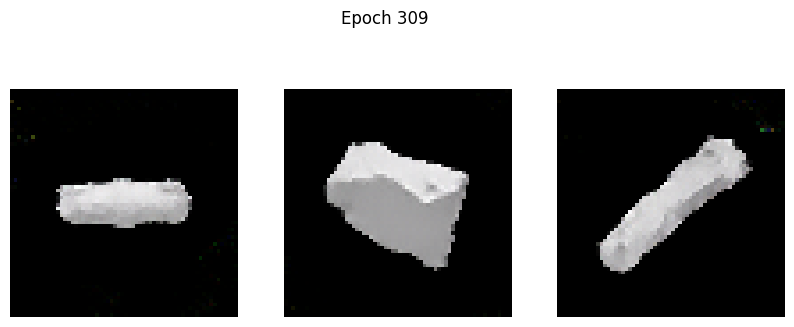

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1081 - g_loss: 4.7056
Epoch 310/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0820 - g_loss: 4.7139

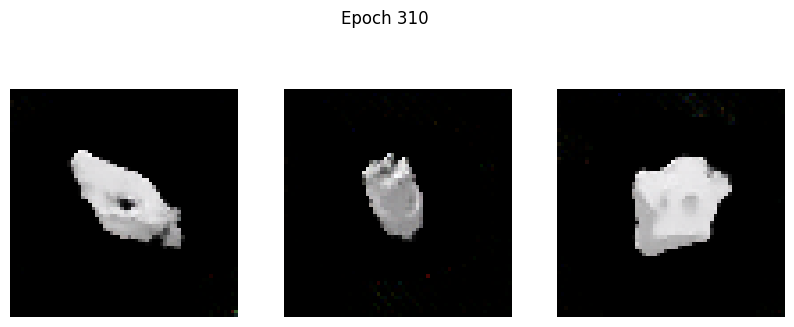

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0819 - g_loss: 4.7130
Epoch 311/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0365 - g_loss: 4.5830

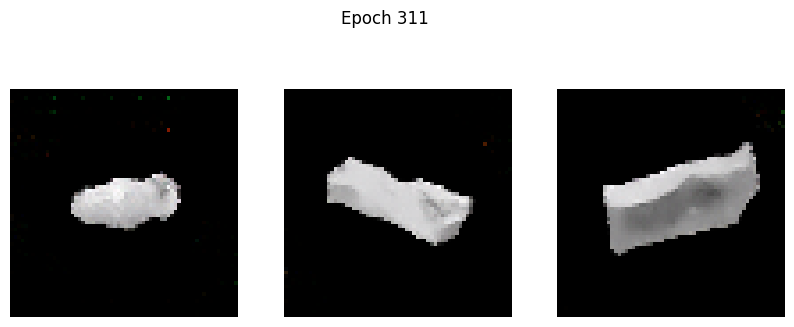

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0366 - g_loss: 4.5832
Epoch 312/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0649 - g_loss: 4.8395

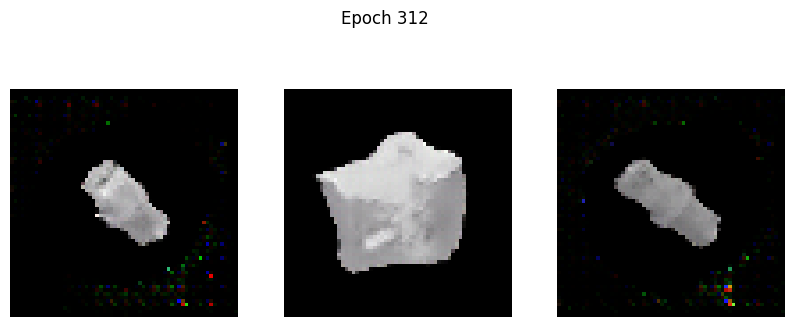

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0658 - g_loss: 4.8401
Epoch 313/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0579 - g_loss: 4.5102

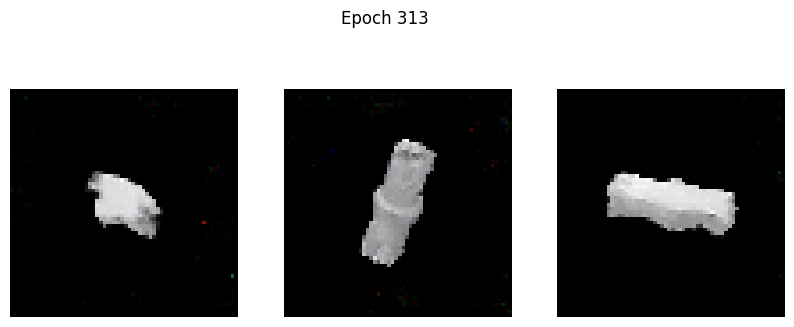

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0578 - g_loss: 4.5099
Epoch 314/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0432 - g_loss: 4.7033

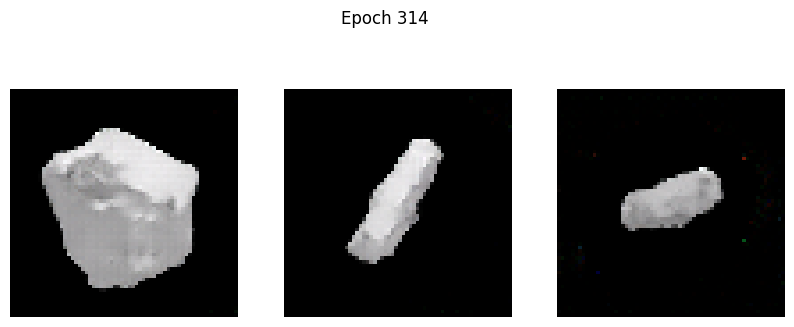

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0433 - g_loss: 4.7035
Epoch 315/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0238 - g_loss: 4.6715

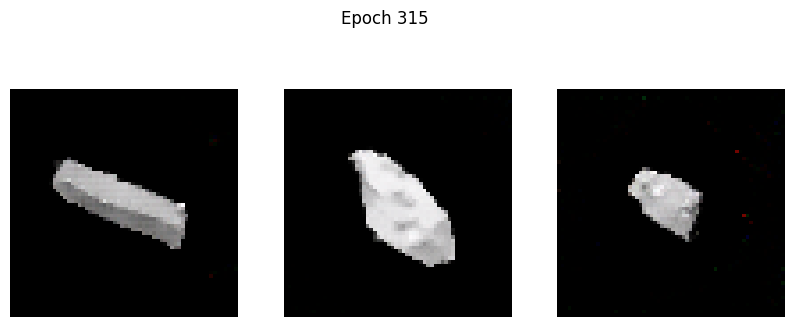

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0238 - g_loss: 4.6711
Epoch 316/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0592 - g_loss: 4.7060

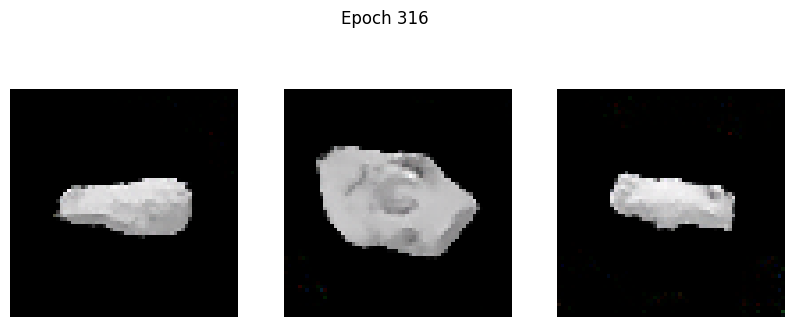

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0593 - g_loss: 4.7067
Epoch 317/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0632 - g_loss: 4.7025

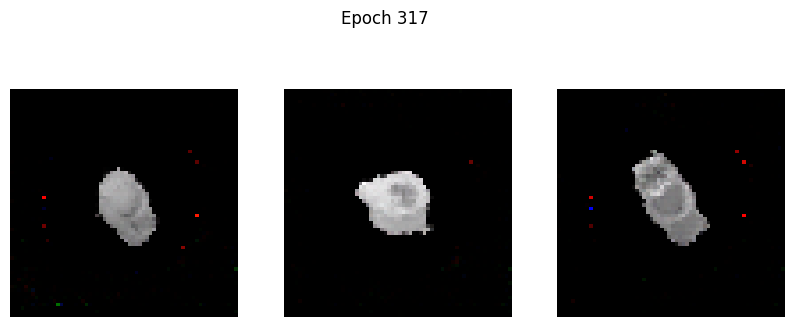

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0631 - g_loss: 4.7026
Epoch 318/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0613 - g_loss: 4.7885

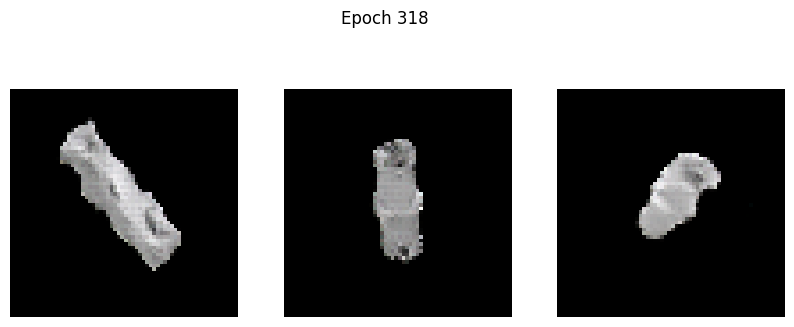

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0626 - g_loss: 4.7931
Epoch 319/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.2609 - g_loss: 4.5489

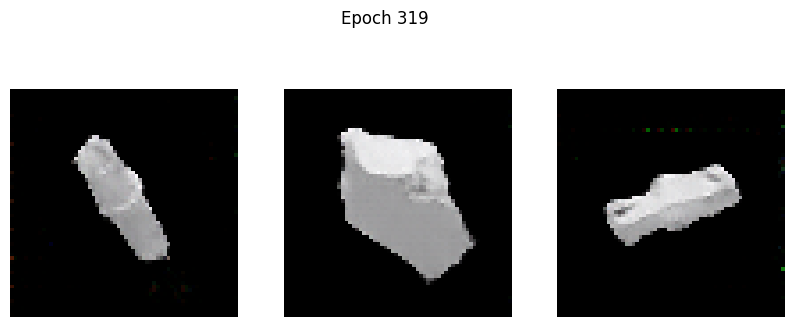

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.2594 - g_loss: 4.5482
Epoch 320/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0364 - g_loss: 4.6060

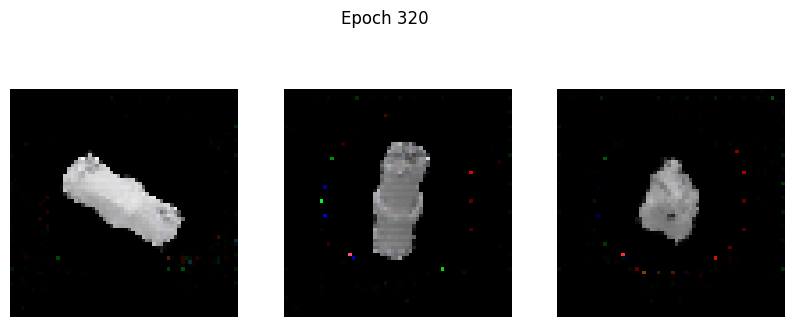

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0364 - g_loss: 4.6062
Epoch 321/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0354 - g_loss: 4.5971

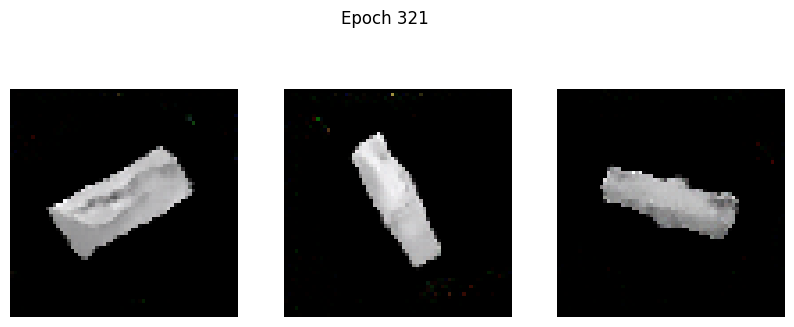

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0354 - g_loss: 4.5974
Epoch 322/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0509 - g_loss: 4.8207

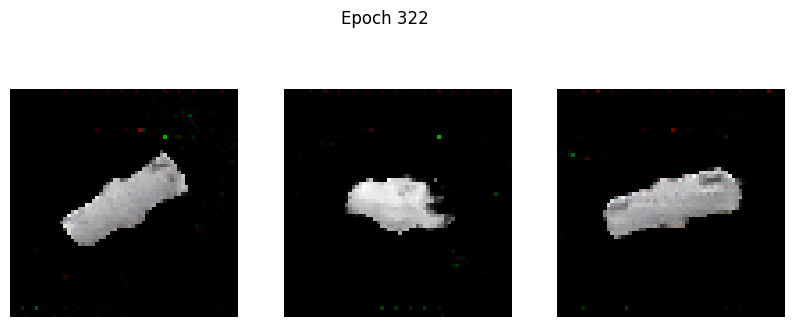

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 125ms/step - d_loss: 0.0511 - g_loss: 4.8214
Epoch 323/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0543 - g_loss: 4.5071

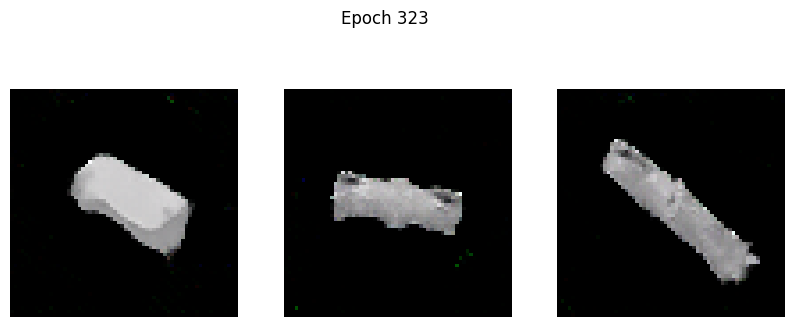

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0544 - g_loss: 4.5100
Epoch 324/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.5198 - g_loss: 5.1983

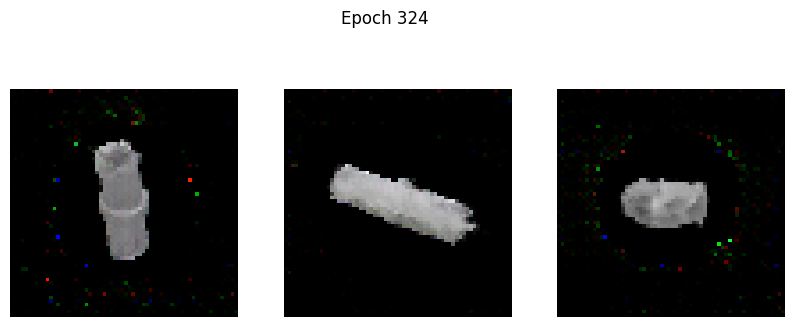

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.5170 - g_loss: 5.1951
Epoch 325/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0733 - g_loss: 4.6423

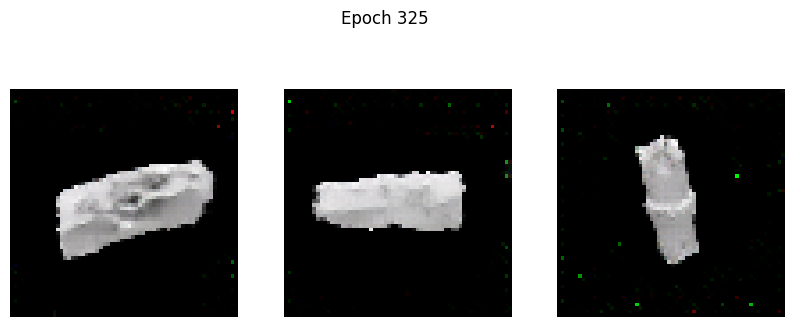

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0732 - g_loss: 4.6419
Epoch 326/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0272 - g_loss: 4.7118

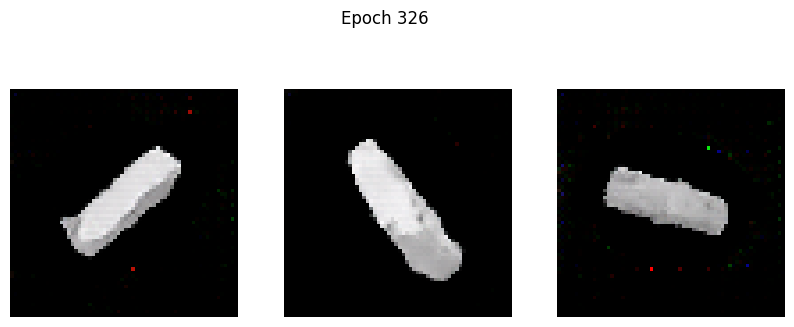

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0271 - g_loss: 4.7117
Epoch 327/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0424 - g_loss: 4.7943

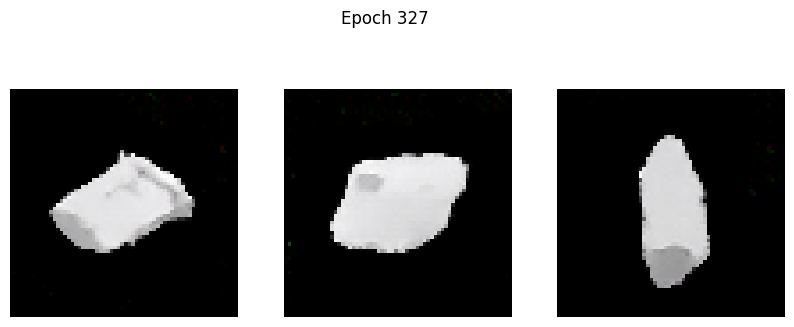

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0424 - g_loss: 4.7945
Epoch 328/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0316 - g_loss: 4.7677

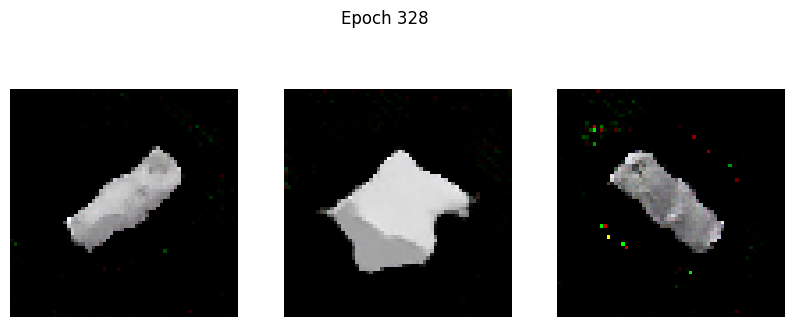

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0318 - g_loss: 4.7686
Epoch 329/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0345 - g_loss: 4.8284

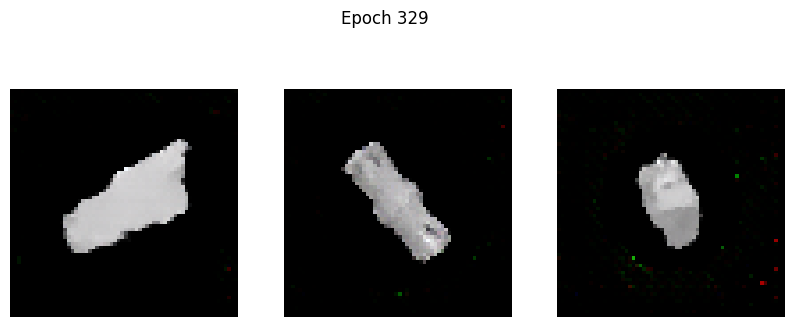

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0344 - g_loss: 4.8276
Epoch 330/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0420 - g_loss: 4.8549

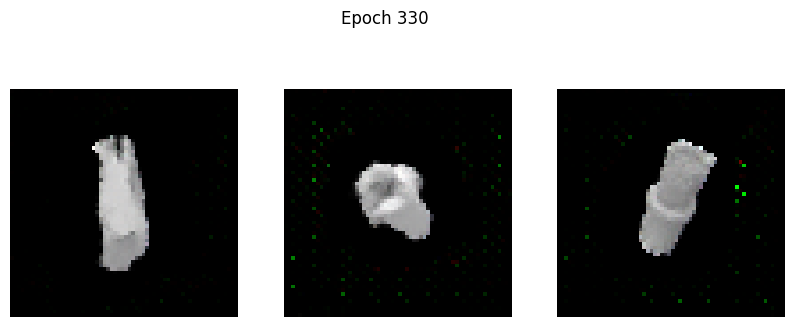

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0422 - g_loss: 4.8550
Epoch 331/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0763 - g_loss: 5.0393

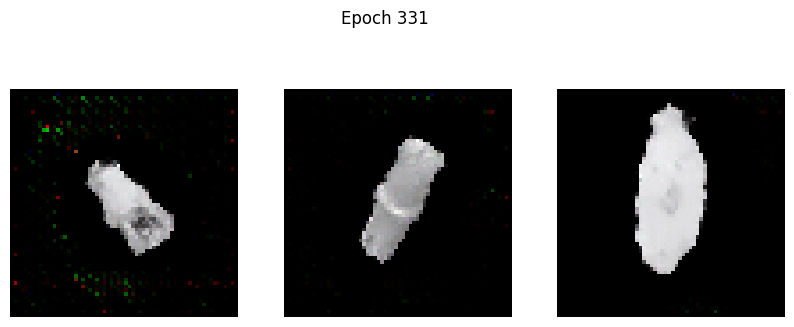

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0760 - g_loss: 5.0381
Epoch 332/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0388 - g_loss: 4.8167

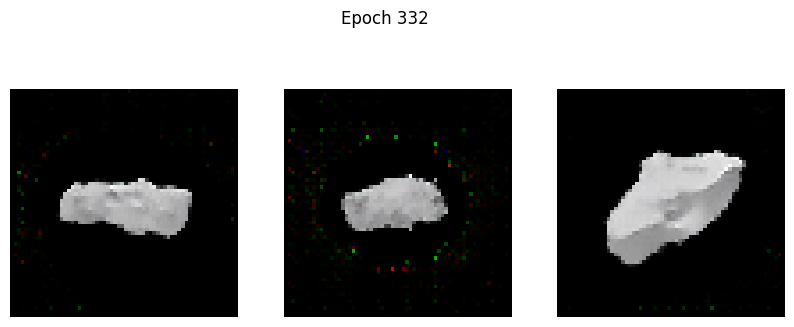

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0391 - g_loss: 4.8175
Epoch 333/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0888 - g_loss: 4.9620

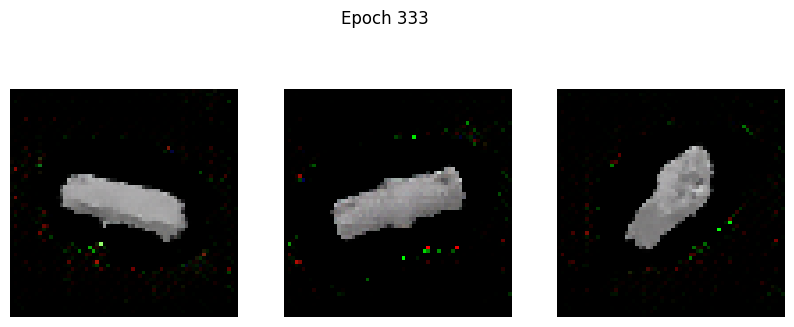

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0885 - g_loss: 4.9619
Epoch 334/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1738 - g_loss: 5.3123

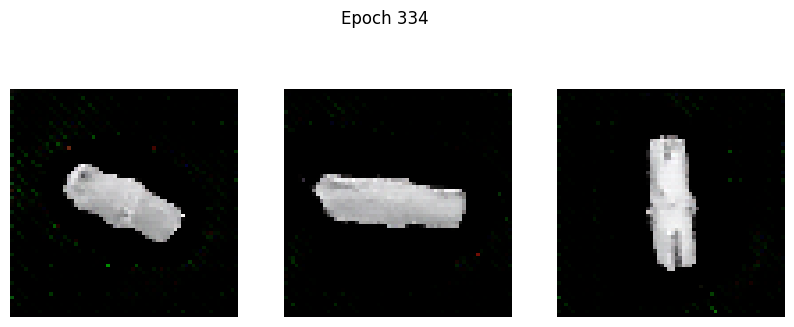

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1732 - g_loss: 5.3097
Epoch 335/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0204 - g_loss: 4.7648

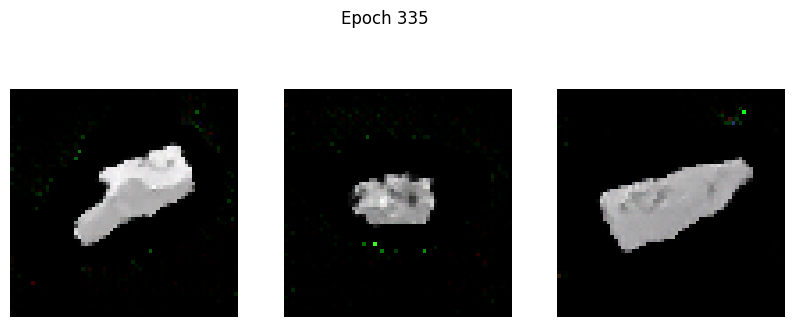

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0205 - g_loss: 4.7651
Epoch 336/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0361 - g_loss: 4.9526

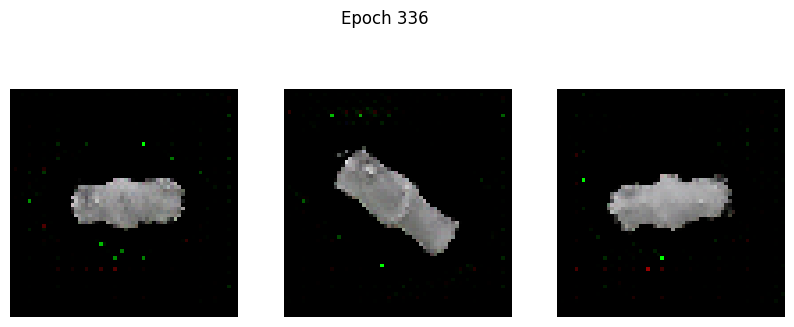

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0369 - g_loss: 4.9553
Epoch 337/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0654 - g_loss: 4.8616

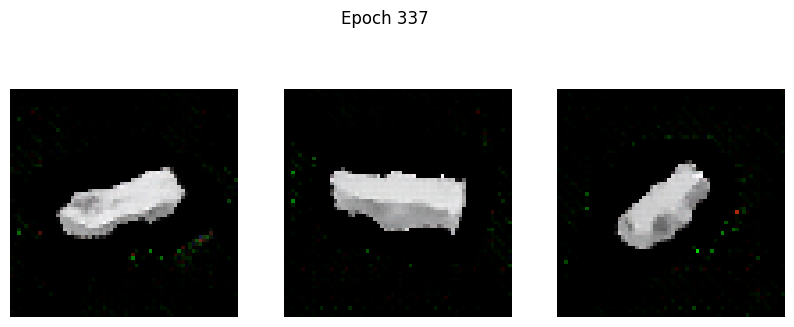

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0651 - g_loss: 4.8613
Epoch 338/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0435 - g_loss: 4.9891

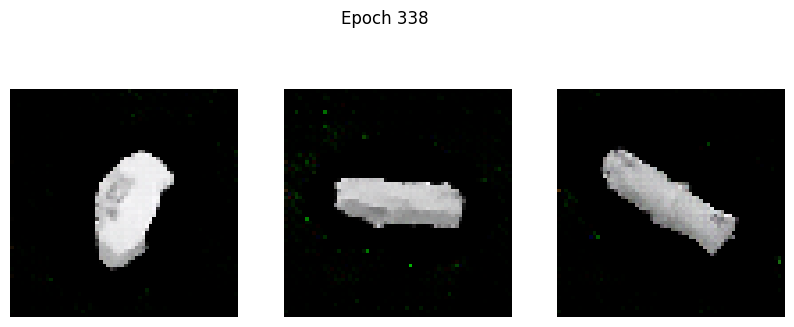

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0437 - g_loss: 4.9896
Epoch 339/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0324 - g_loss: 4.8271

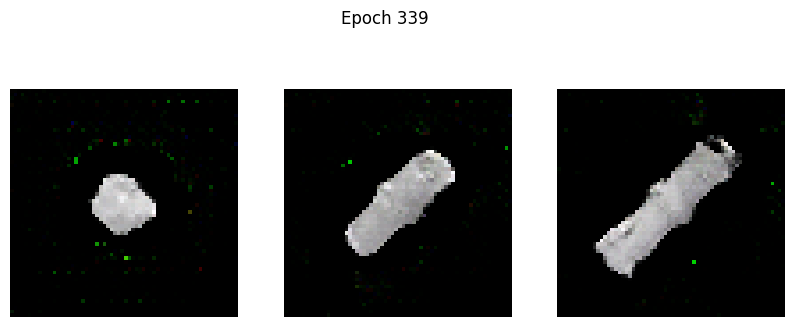

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0326 - g_loss: 4.8278
Epoch 340/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0177 - g_loss: 4.9043

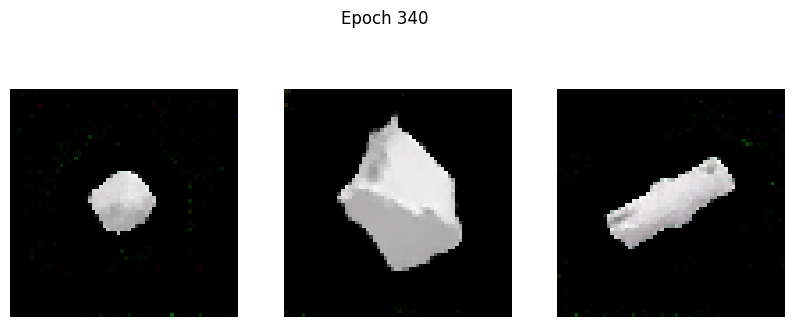

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0177 - g_loss: 4.9047
Epoch 341/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0300 - g_loss: 4.9135

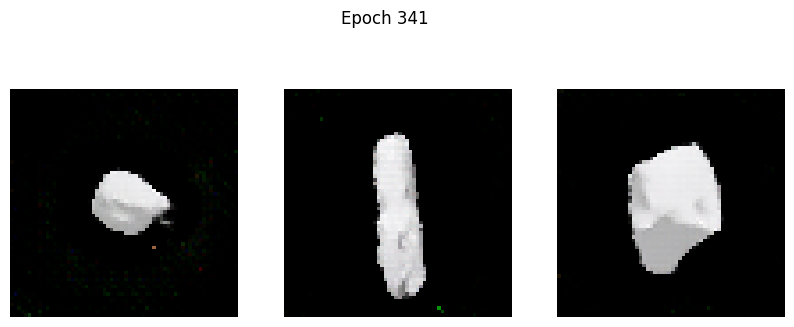

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0301 - g_loss: 4.9141
Epoch 342/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0499 - g_loss: 4.9618

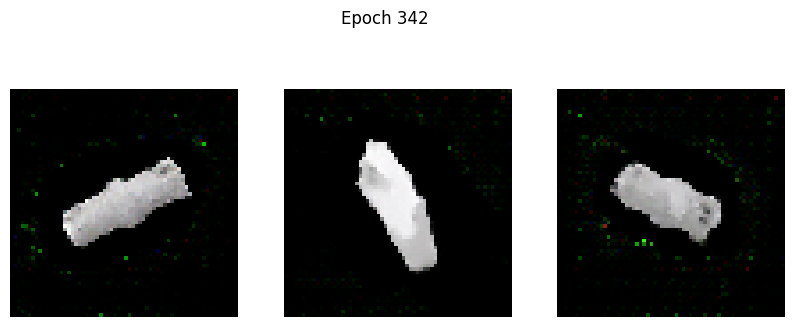

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0501 - g_loss: 4.9627
Epoch 343/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0466 - g_loss: 4.9325

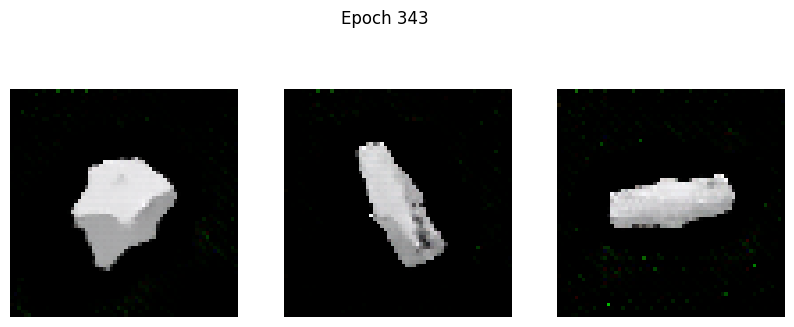

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0465 - g_loss: 4.9321
Epoch 344/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0343 - g_loss: 5.0934

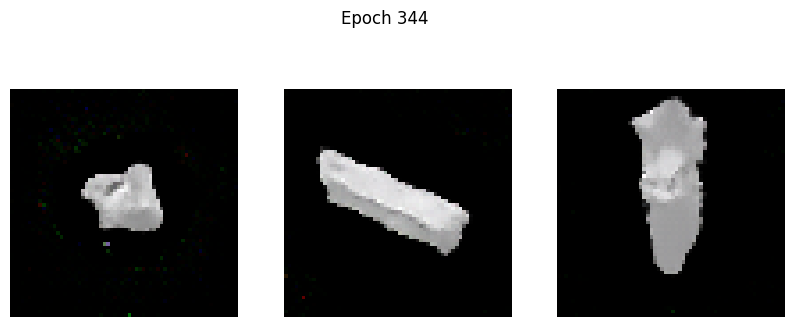

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0343 - g_loss: 5.0929
Epoch 345/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1360 - g_loss: 5.1901

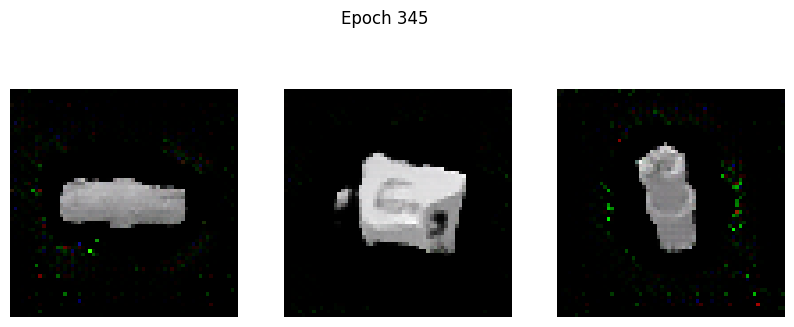

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1357 - g_loss: 5.1888
Epoch 346/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0344 - g_loss: 5.0103

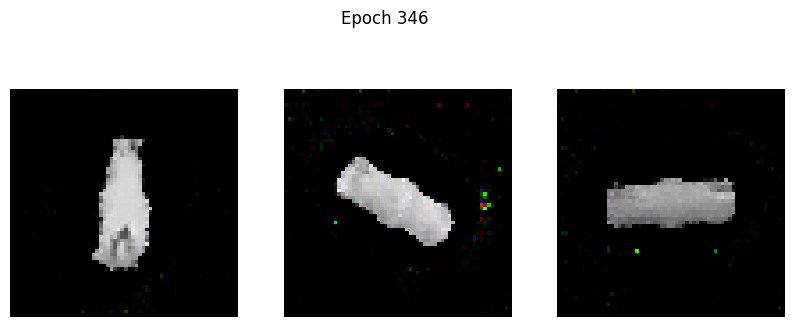

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0345 - g_loss: 5.0099
Epoch 347/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0118 - g_loss: 4.9961

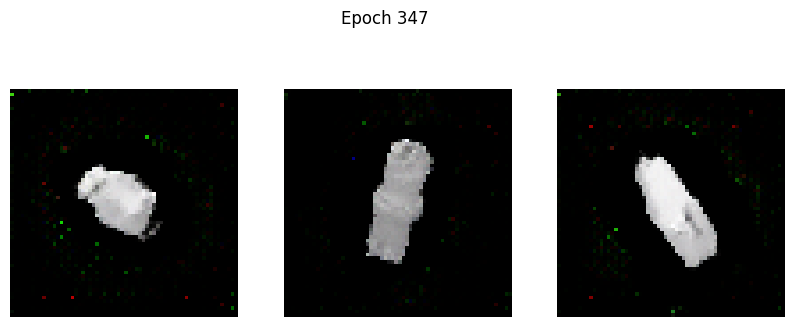

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0123 - g_loss: 4.9968
Epoch 348/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0855 - g_loss: 5.2173

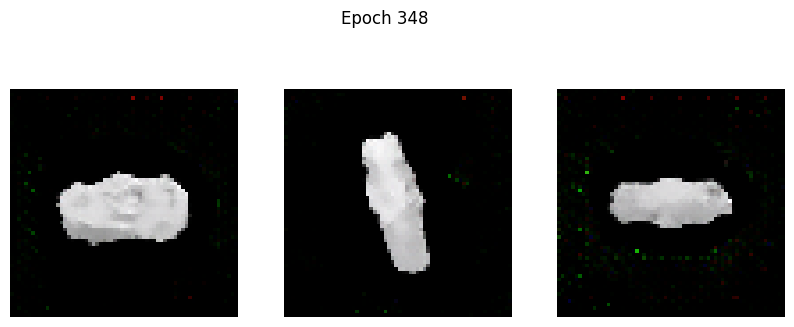

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0850 - g_loss: 5.2157
Epoch 349/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0449 - g_loss: 5.0923

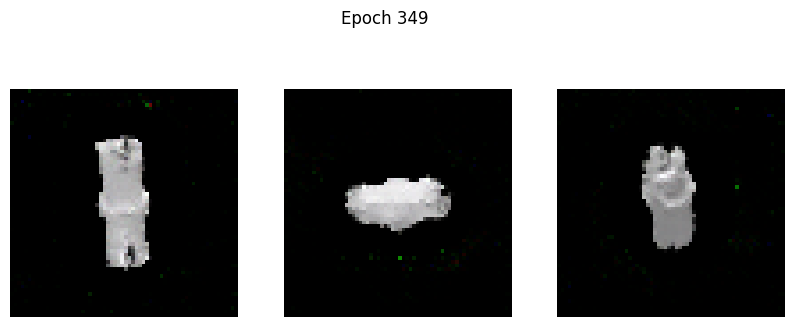

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0448 - g_loss: 5.0920
Epoch 350/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0048 - g_loss: 5.0162

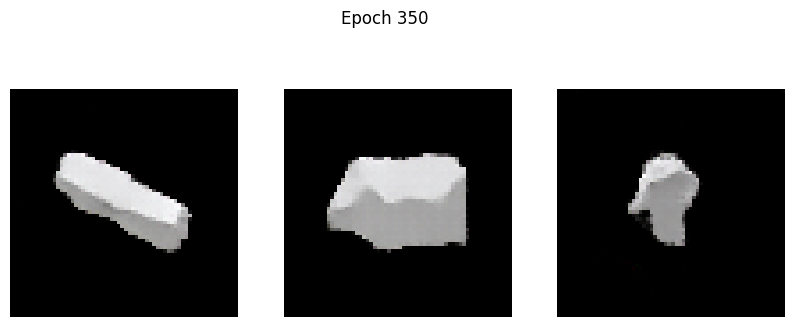

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0052 - g_loss: 5.0163
Epoch 351/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0792 - g_loss: 5.2756

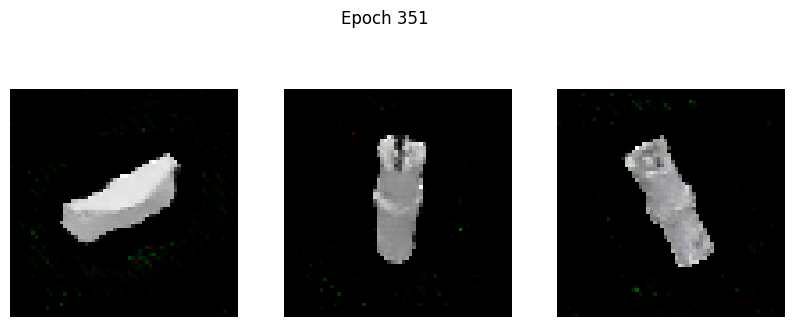

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0791 - g_loss: 5.2750
Epoch 352/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0309 - g_loss: 4.9891

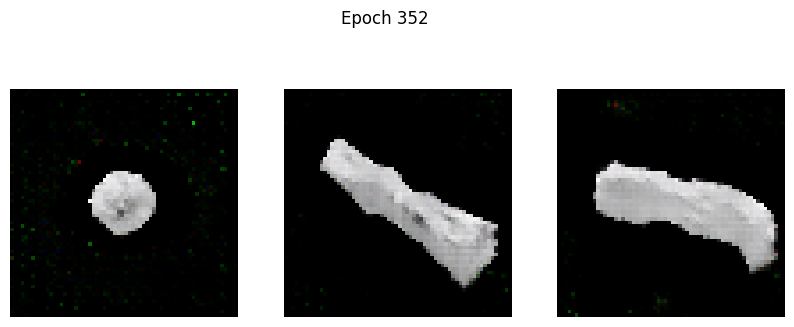

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0311 - g_loss: 4.9900
Epoch 353/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0197 - g_loss: 5.0142

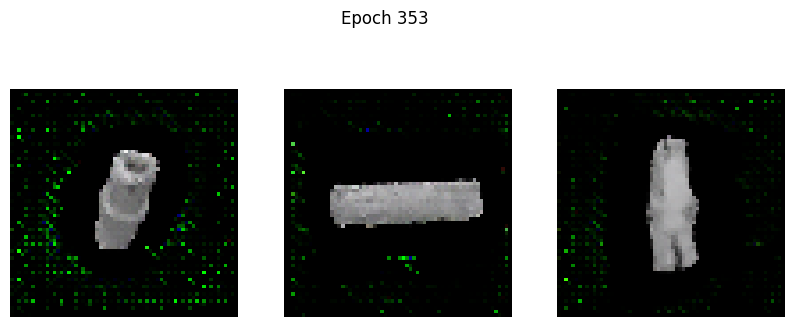

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0199 - g_loss: 5.0150
Epoch 354/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0854 - g_loss: 5.2417

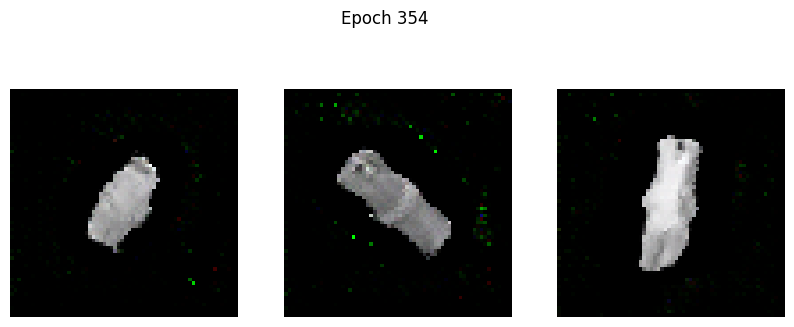

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0851 - g_loss: 5.2408
Epoch 355/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0483 - g_loss: 5.1592

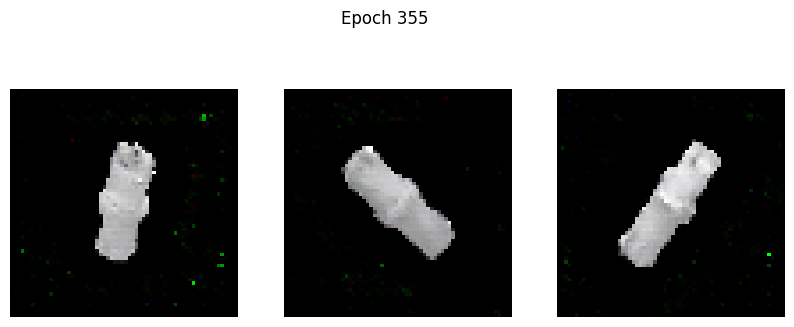

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0482 - g_loss: 5.1586
Epoch 356/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0296 - g_loss: 5.2276

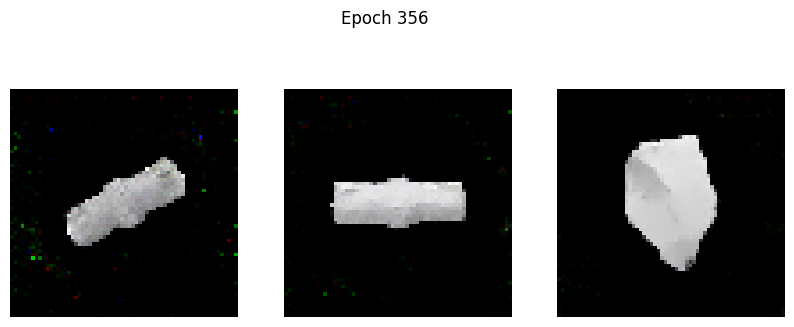

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0299 - g_loss: 5.2285
Epoch 357/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0268 - g_loss: 5.2126

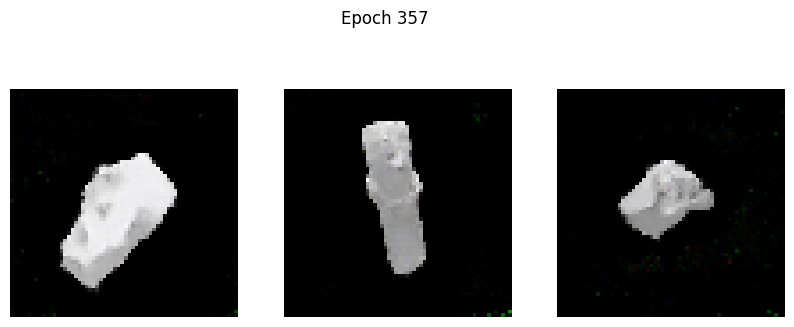

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0267 - g_loss: 5.2113
Epoch 358/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0554 - g_loss: 5.2997

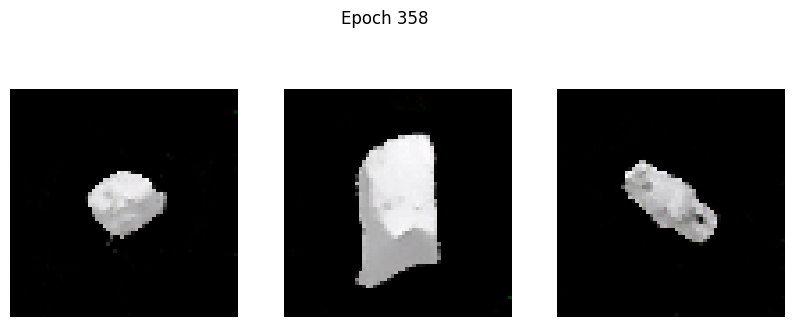

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0559 - g_loss: 5.3012
Epoch 359/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0223 - g_loss: 5.1062

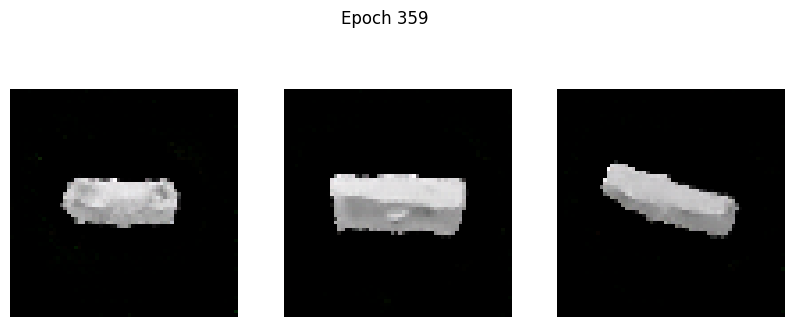

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0224 - g_loss: 5.1076
Epoch 360/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0435 - g_loss: 5.2369

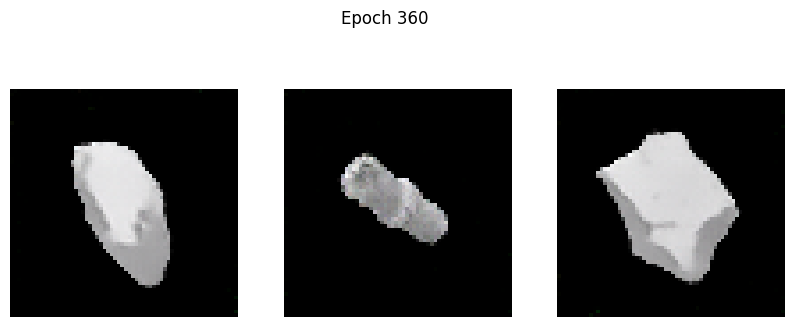

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0435 - g_loss: 5.2367
Epoch 361/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0197 - g_loss: 5.1493

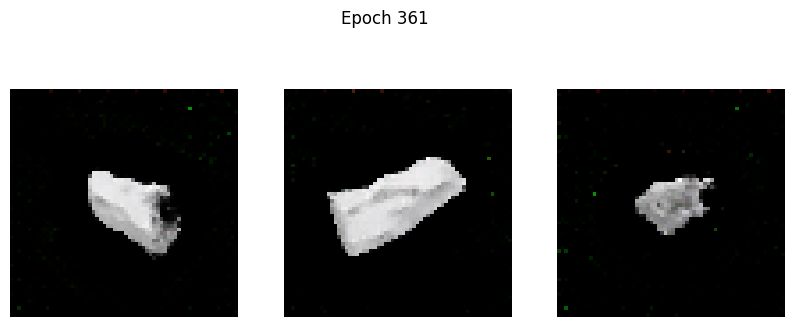

100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - d_loss: 0.0197 - g_loss: 5.1505
Epoch 362/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - d_loss: 0.0708 - g_loss: 5.4690

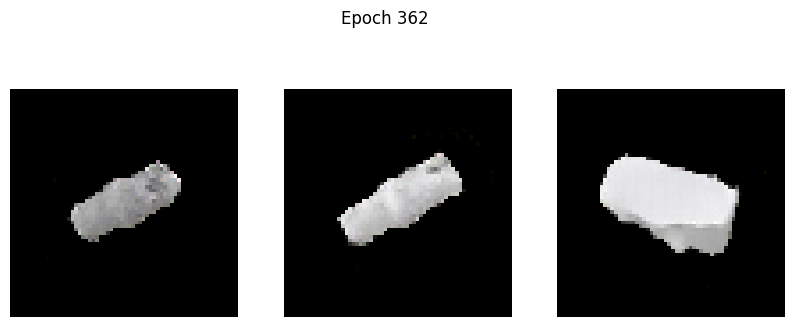

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - d_loss: 0.0711 - g_loss: 5.4691
Epoch 363/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - d_loss: 0.0245 - g_loss: 5.2239

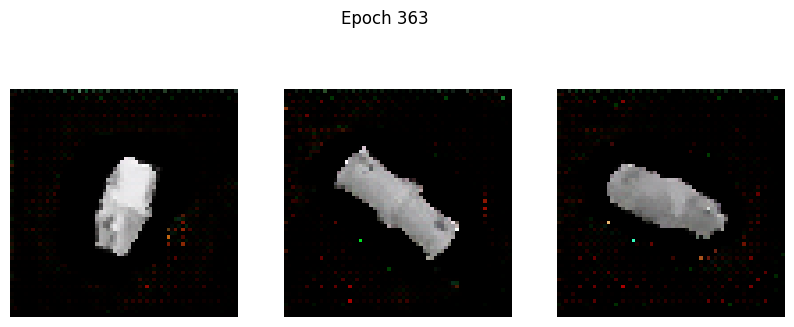

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.0247 - g_loss: 5.2242
Epoch 364/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0486 - g_loss: 5.1647

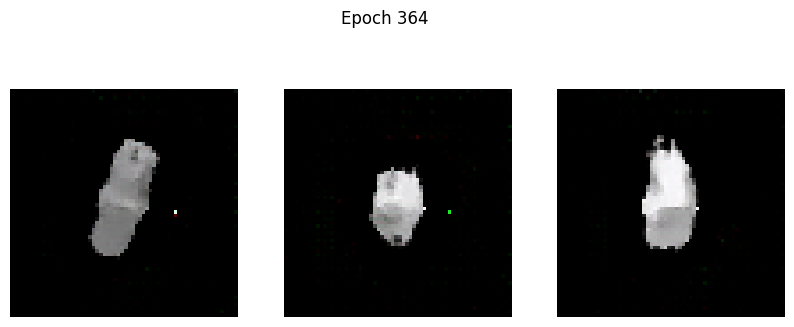

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0486 - g_loss: 5.1641
Epoch 365/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0142 - g_loss: 5.2537

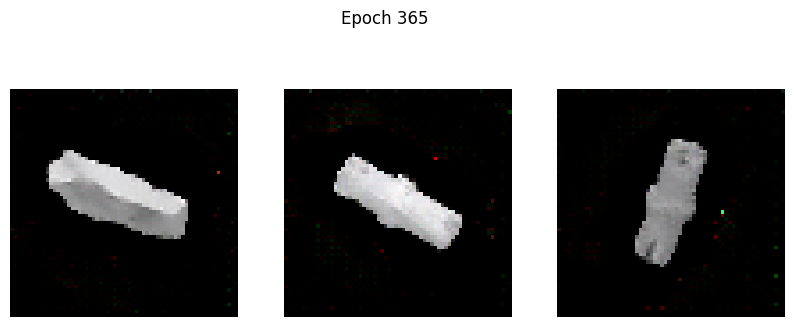

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0143 - g_loss: 5.2534
Epoch 366/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0567 - g_loss: 5.1154

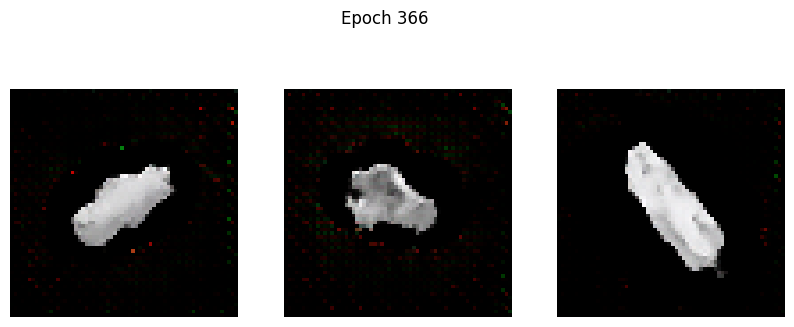

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0569 - g_loss: 5.1163
Epoch 367/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0073 - g_loss: 5.2452

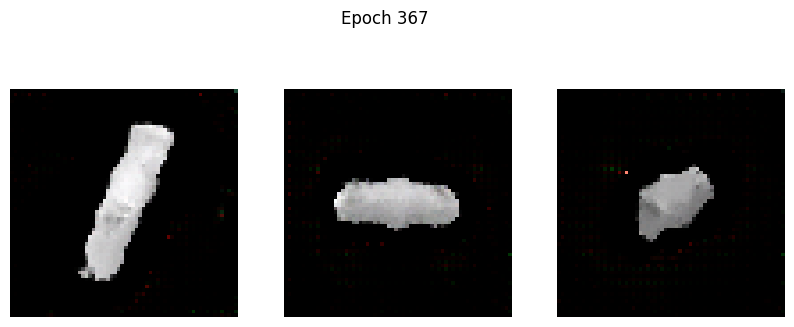

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0075 - g_loss: 5.2469
Epoch 368/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0059 - g_loss: 5.0493

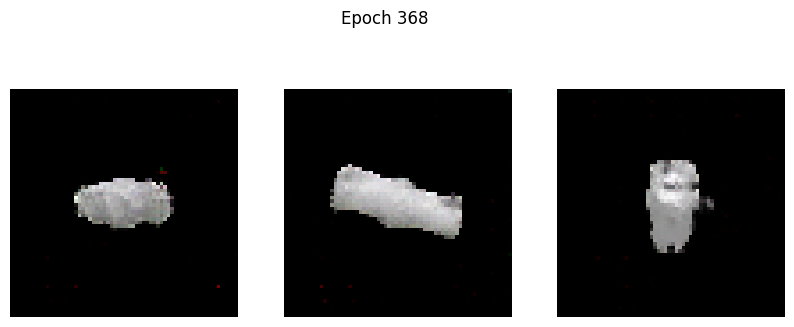

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0056 - g_loss: 5.0512
Epoch 369/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0395 - g_loss: 5.2337

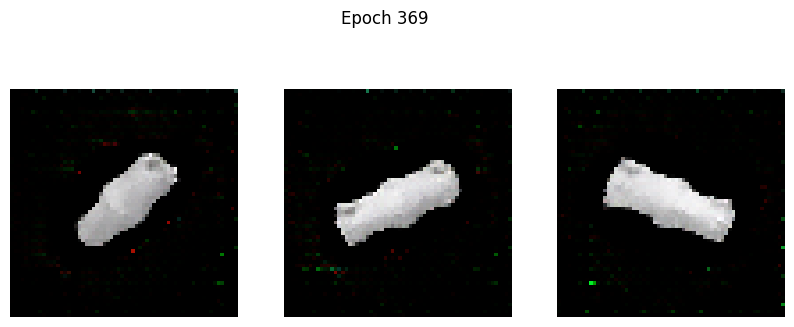

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0394 - g_loss: 5.2340
Epoch 370/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0239 - g_loss: 5.3466

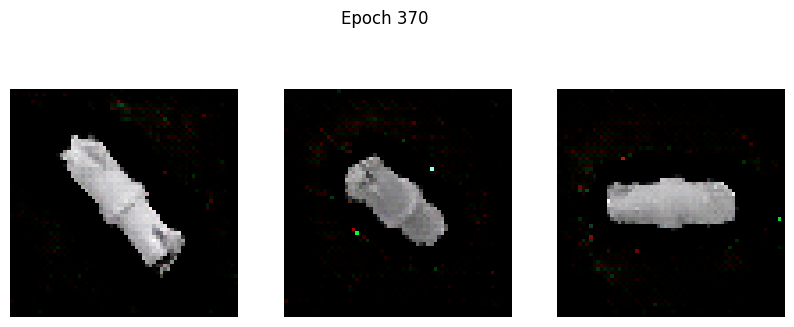

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0241 - g_loss: 5.3472
Epoch 371/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -3.3979e-04 - g_loss: 5.2161

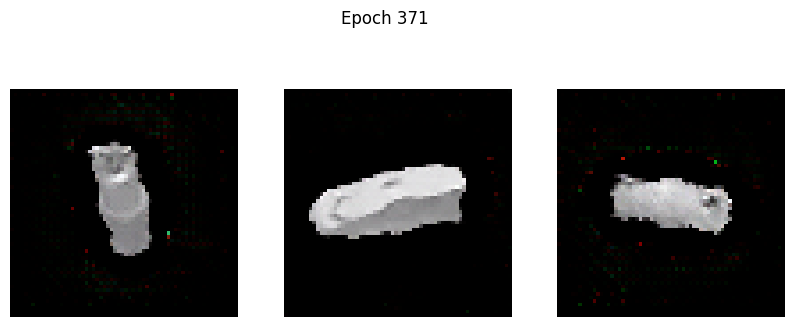

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -7.9849e-05 - g_loss: 5.2187
Epoch 372/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0748 - g_loss: 5.5211

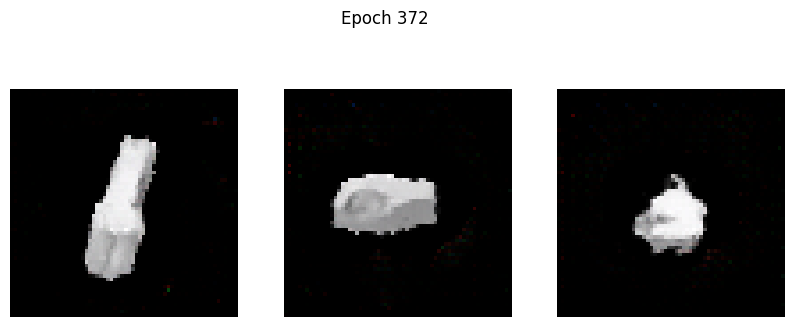

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0744 - g_loss: 5.5196
Epoch 373/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0405 - g_loss: 5.3602

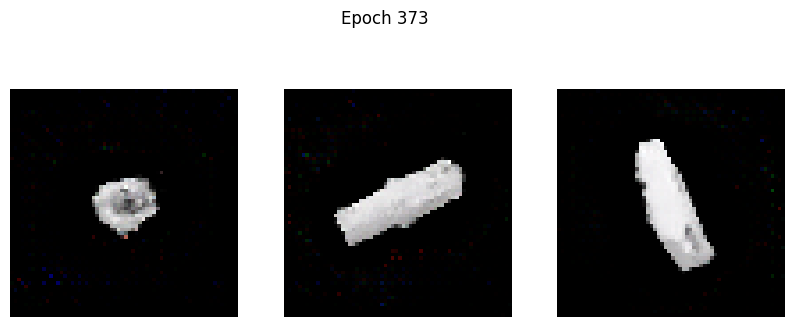

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0407 - g_loss: 5.3610
Epoch 374/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0384 - g_loss: 5.4756

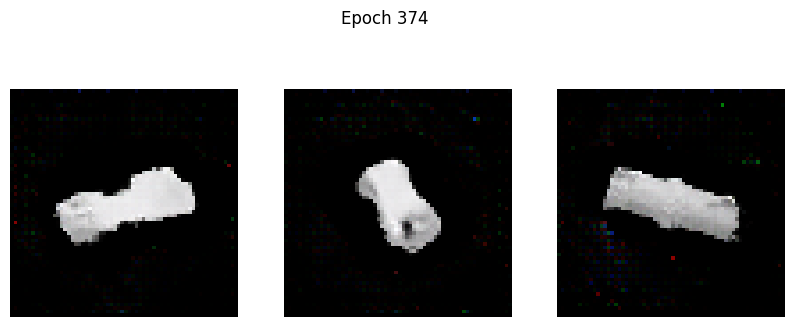

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0383 - g_loss: 5.4746
Epoch 375/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0032 - g_loss: 5.1667

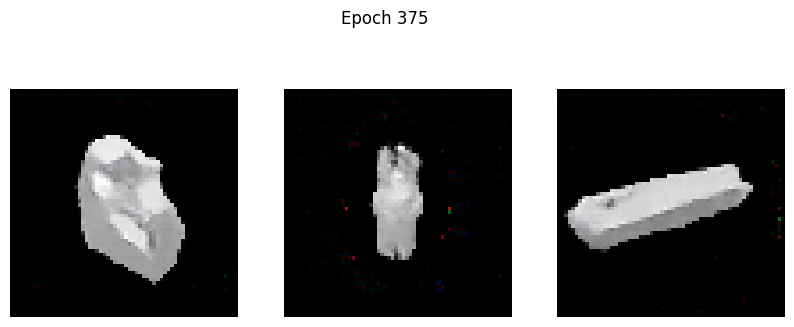

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0033 - g_loss: 5.1676
Epoch 376/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0613 - g_loss: 5.5009

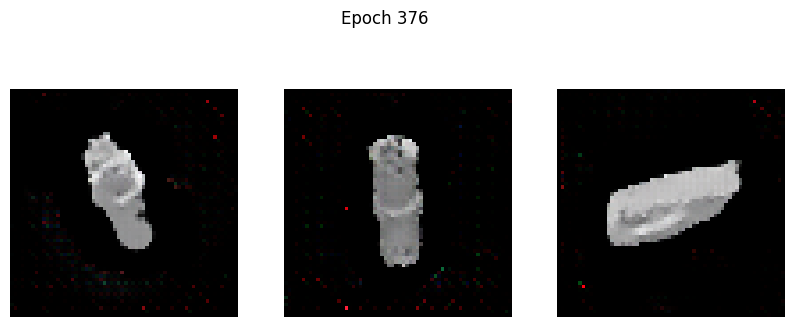

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0614 - g_loss: 5.5001
Epoch 377/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0570 - g_loss: 5.5210

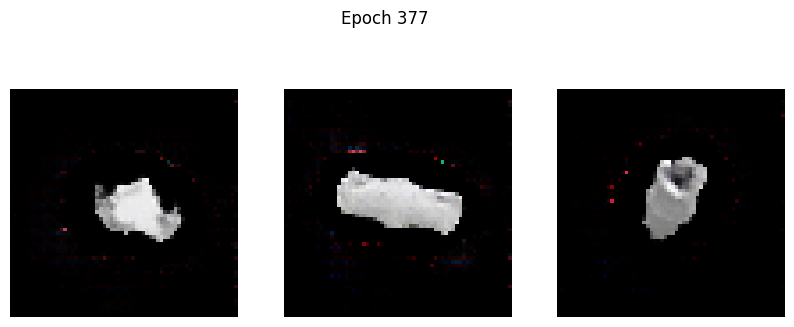

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0569 - g_loss: 5.5195
Epoch 378/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0031 - g_loss: 5.4399

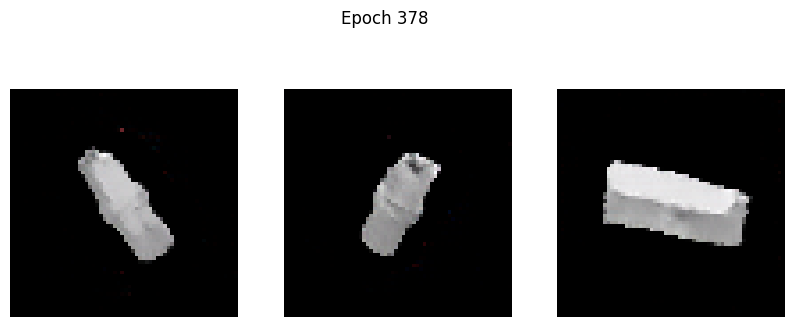

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0030 - g_loss: 5.4394
Epoch 379/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0240 - g_loss: 5.5126

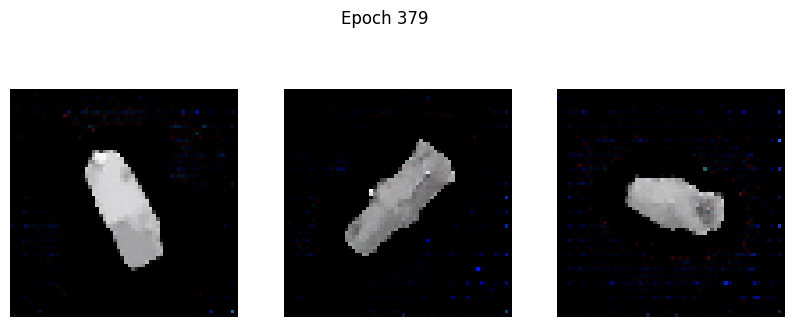

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0240 - g_loss: 5.5136
Epoch 380/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0369 - g_loss: 5.8241

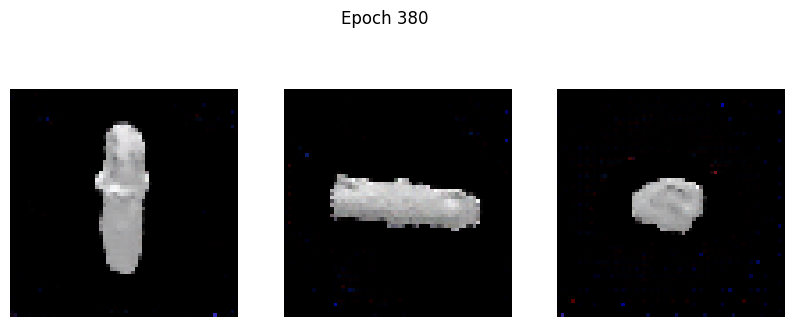

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0369 - g_loss: 5.8219
Epoch 381/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0101 - g_loss: 5.4768

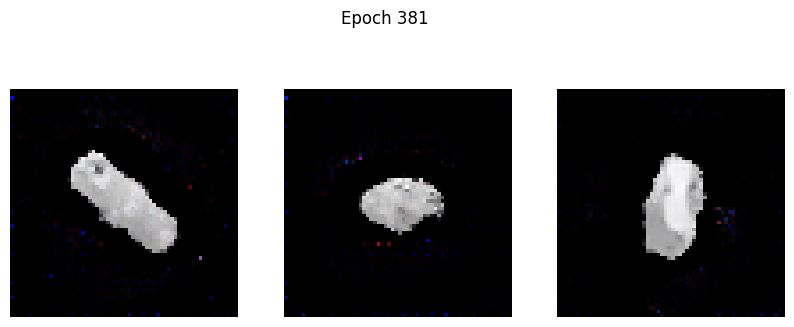

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0102 - g_loss: 5.4772
Epoch 382/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1513 - g_loss: 5.6944

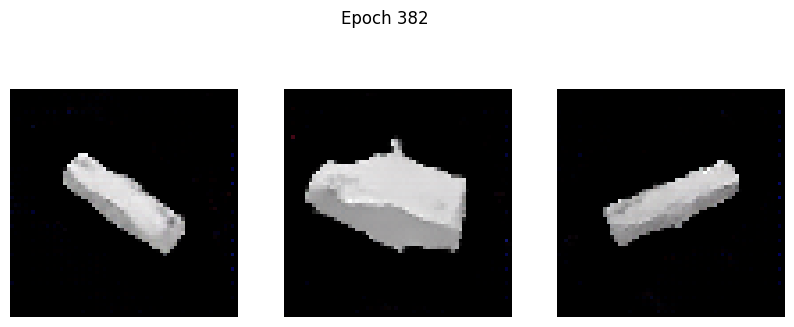

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1506 - g_loss: 5.6928
Epoch 383/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0134 - g_loss: 5.2574

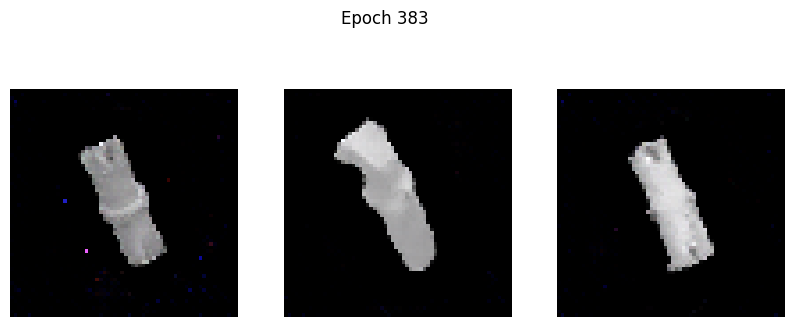

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0132 - g_loss: 5.2596
Epoch 384/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0056 - g_loss: 5.3563

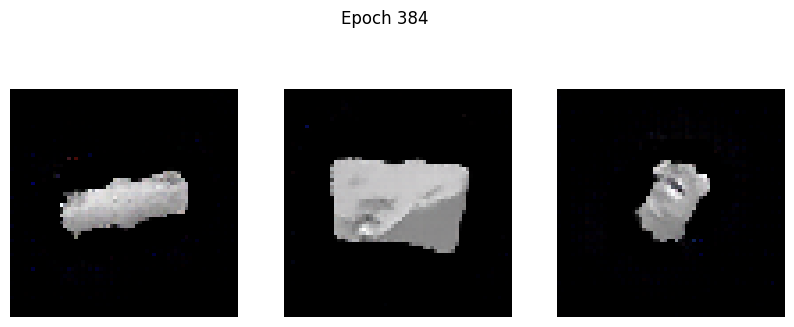

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: 0.0057 - g_loss: 5.3571
Epoch 385/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0714 - g_loss: 5.4773

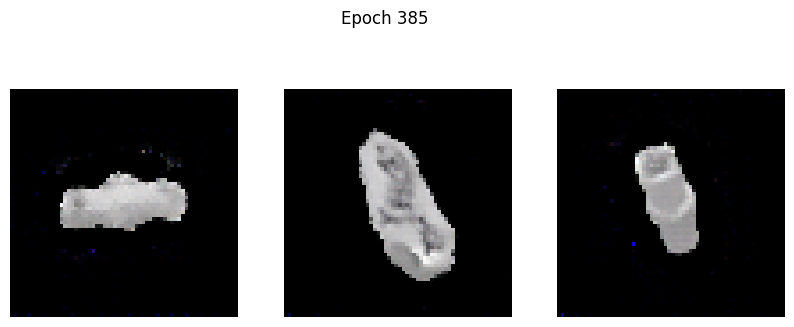

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0711 - g_loss: 5.4770
Epoch 386/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0112 - g_loss: 5.4462

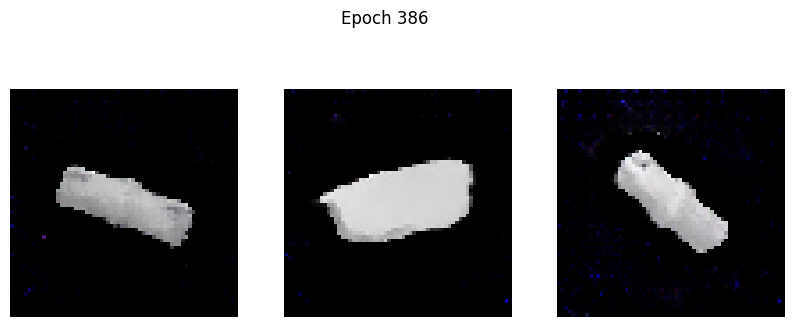

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0115 - g_loss: 5.4467
Epoch 387/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0094 - g_loss: 5.4719

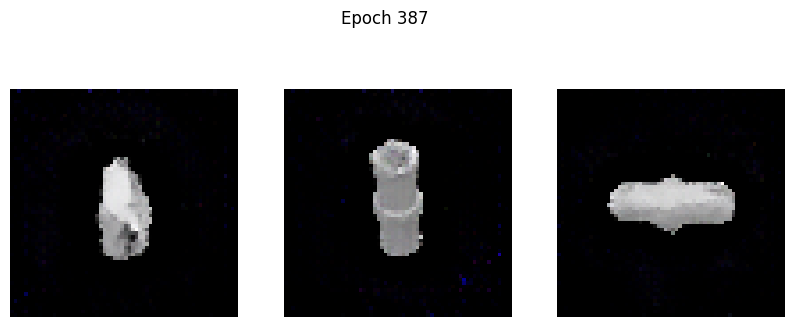

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0092 - g_loss: 5.4720
Epoch 388/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.1471 - g_loss: 6.3248

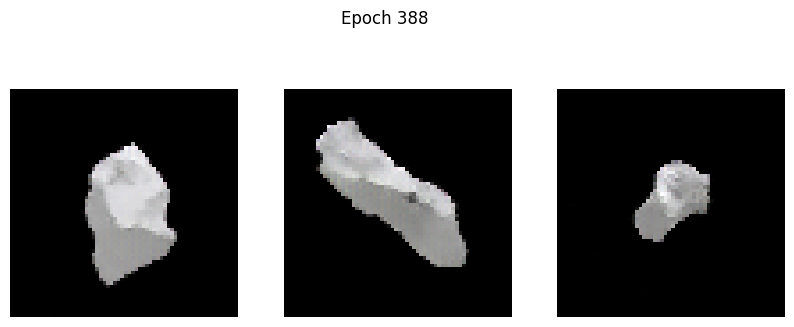

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.1467 - g_loss: 6.3236
Epoch 389/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0048 - g_loss: 5.4755

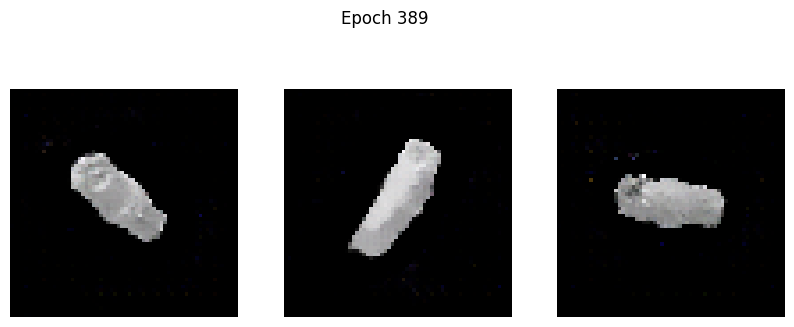

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0047 - g_loss: 5.4745
Epoch 390/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0064 - g_loss: 5.3287

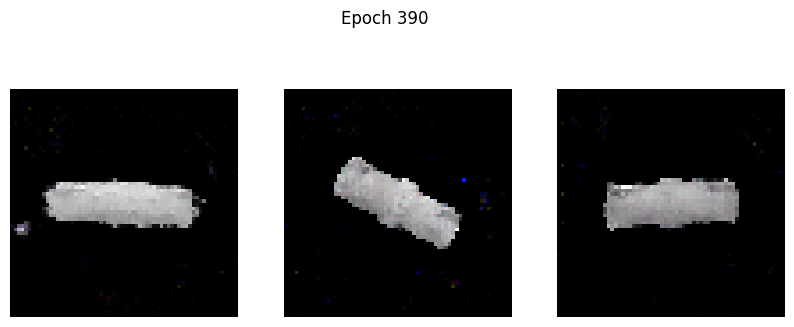

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0064 - g_loss: 5.3294
Epoch 391/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0316 - g_loss: 5.5933

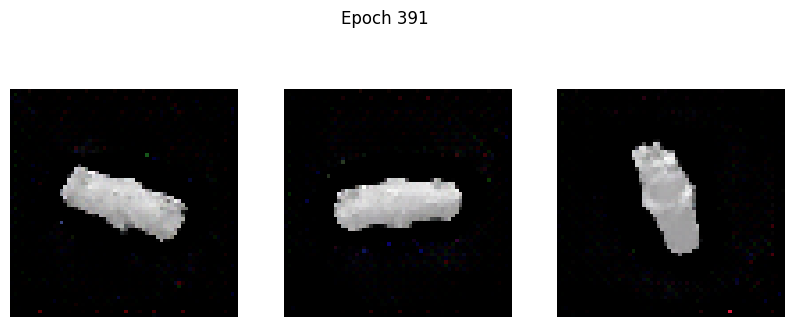

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0314 - g_loss: 5.5933
Epoch 392/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0493 - g_loss: 5.9044

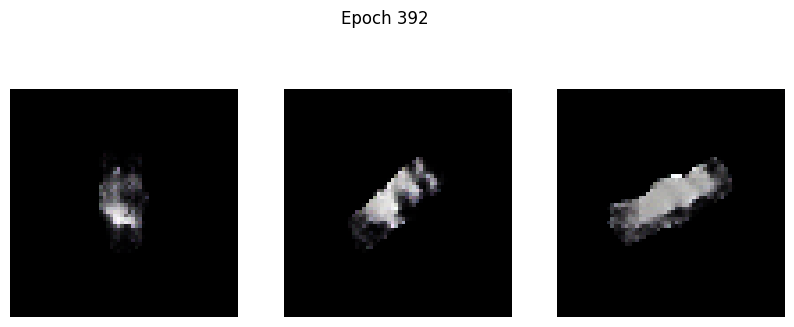

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0498 - g_loss: 5.9102
Epoch 393/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0839 - g_loss: 6.5019

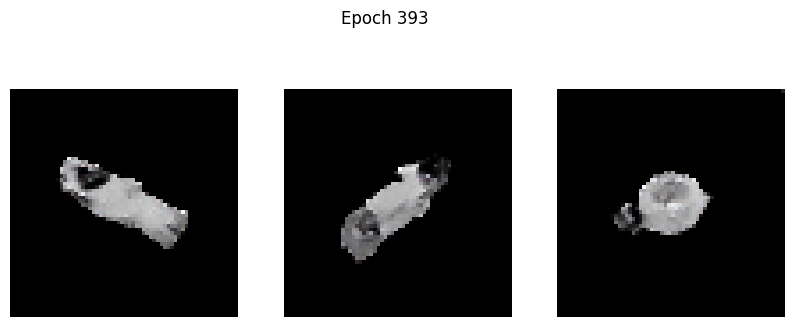

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0838 - g_loss: 6.5038
Epoch 394/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0323 - g_loss: 6.5366

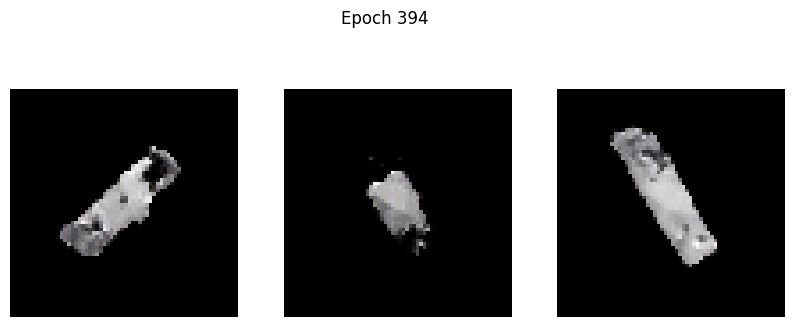

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0323 - g_loss: 6.5360
Epoch 395/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0683 - g_loss: 6.2247

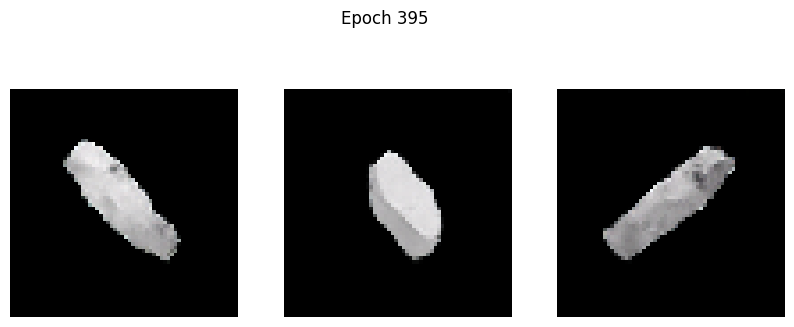

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0681 - g_loss: 6.2253
Epoch 396/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0158 - g_loss: 6.2342

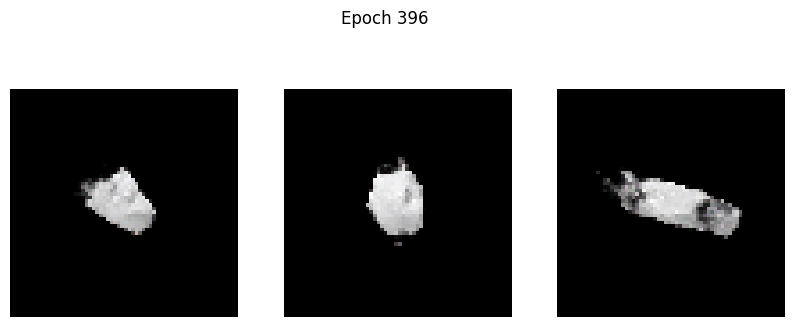

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0158 - g_loss: 6.2362
Epoch 397/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0755 - g_loss: 5.9880

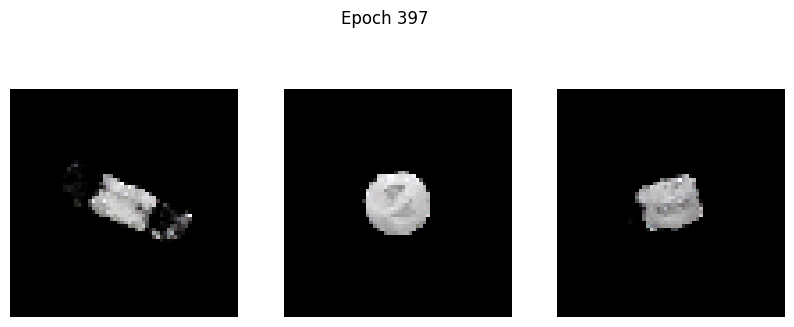

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0751 - g_loss: 5.9914
Epoch 398/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0541 - g_loss: 7.3709

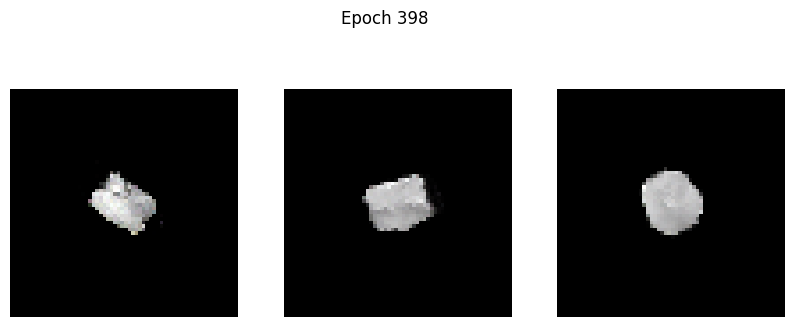

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0540 - g_loss: 7.3670
Epoch 399/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0257 - g_loss: 6.0366

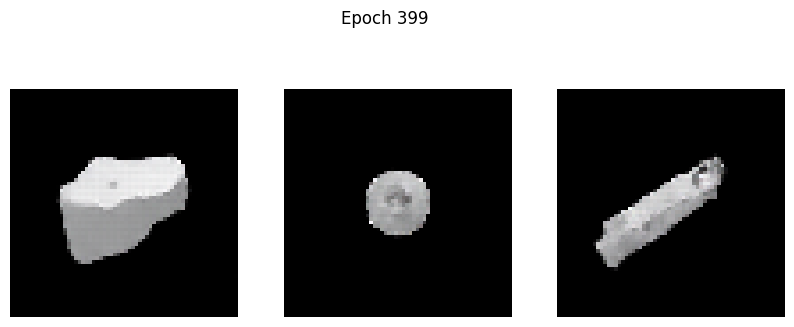

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0258 - g_loss: 6.0356
Epoch 400/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0144 - g_loss: 6.3515

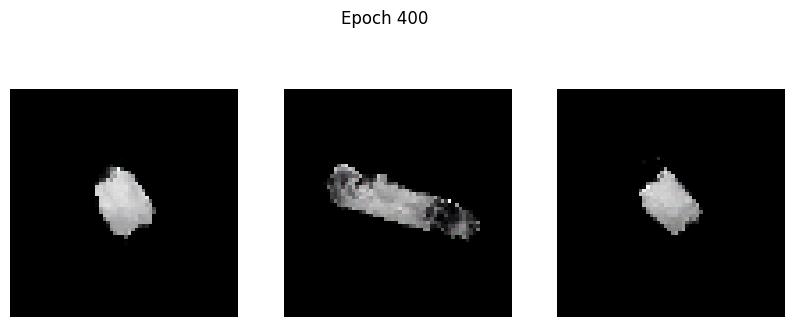

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0144 - g_loss: 6.3516
Epoch 401/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0330 - g_loss: 6.1767

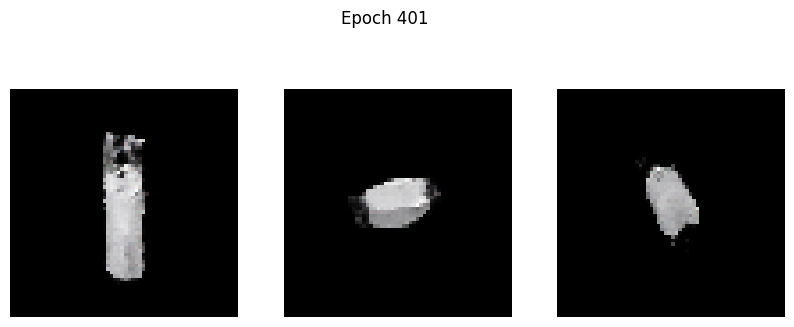

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0329 - g_loss: 6.1762
Epoch 402/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0135 - g_loss: 5.8746

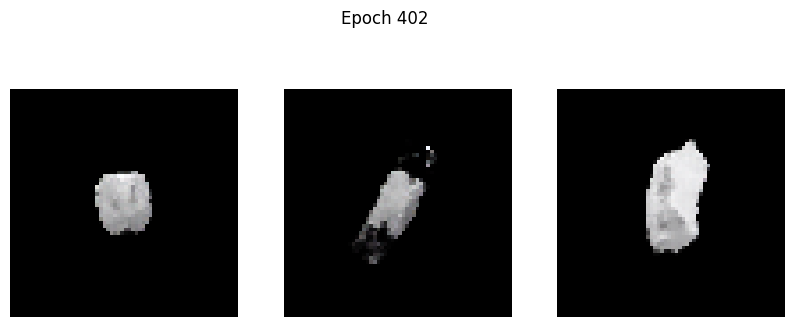

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0133 - g_loss: 5.8765
Epoch 403/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0475 - g_loss: 6.5418

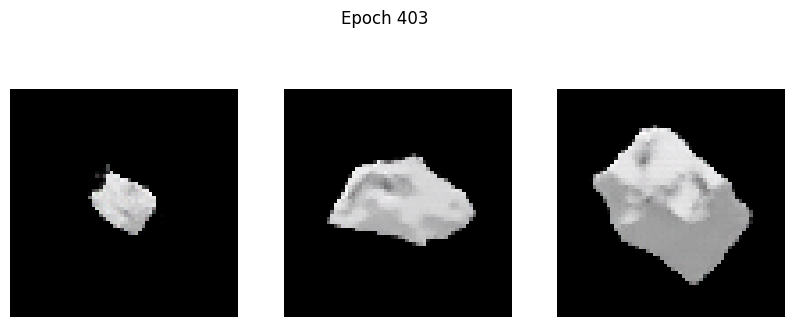

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0474 - g_loss: 6.5417
Epoch 404/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 3.2253e-04 - g_loss: 6.1012

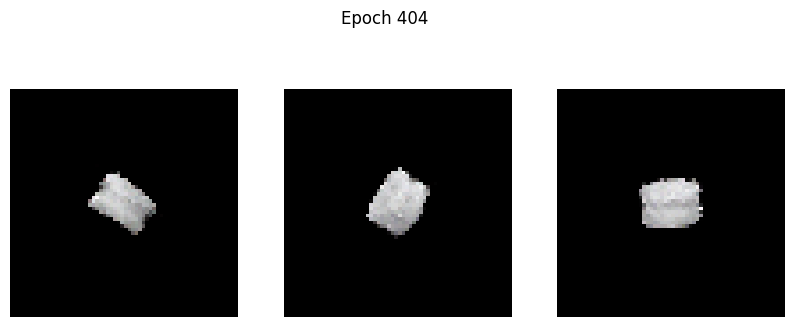

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 3.8252e-04 - g_loss: 6.1014
Epoch 405/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0350 - g_loss: 5.7248

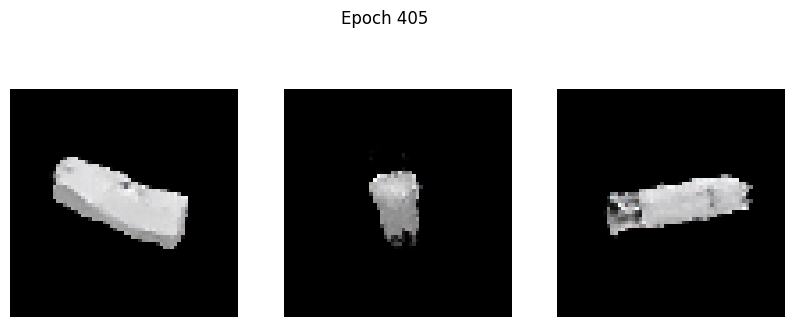

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0349 - g_loss: 5.7250
Epoch 406/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0062 - g_loss: 5.9152

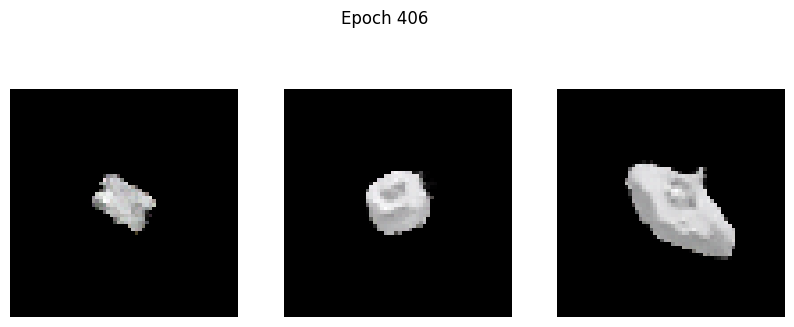

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0059 - g_loss: 5.9169
Epoch 407/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0070 - g_loss: 6.0239

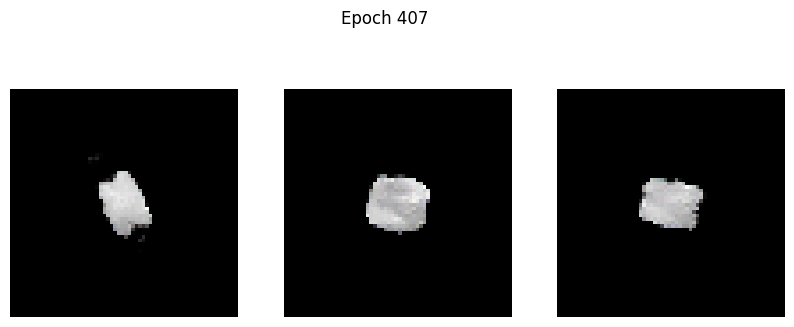

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0069 - g_loss: 6.0251
Epoch 408/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0107 - g_loss: 5.8697

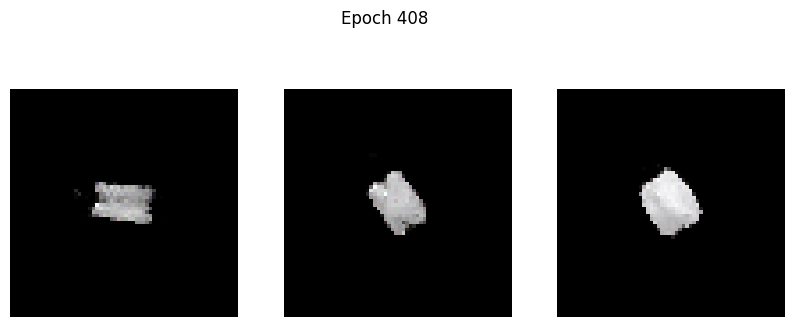

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0106 - g_loss: 5.8707
Epoch 409/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0118 - g_loss: 5.6297

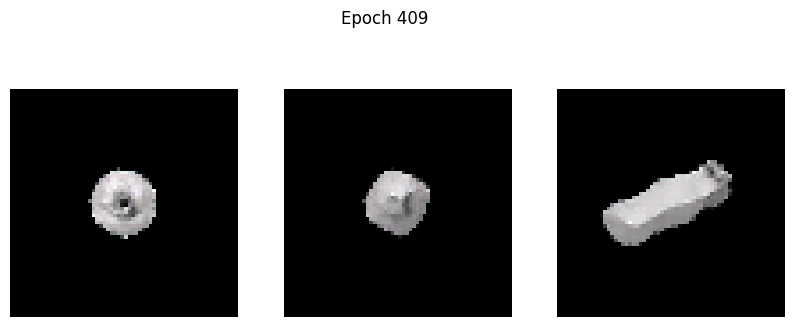

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0114 - g_loss: 5.6343
Epoch 410/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0267 - g_loss: 6.2530

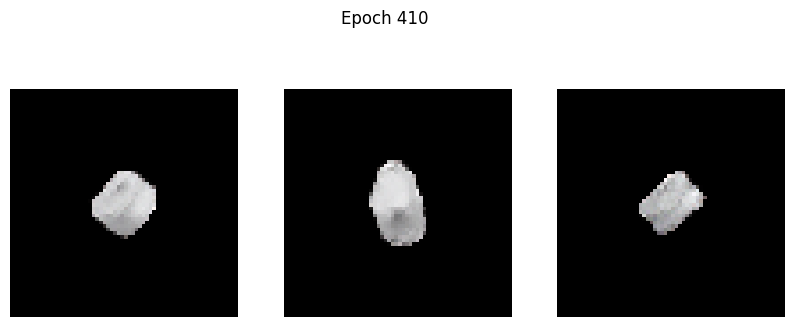

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0266 - g_loss: 6.2528
Epoch 411/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0071 - g_loss: 5.7624

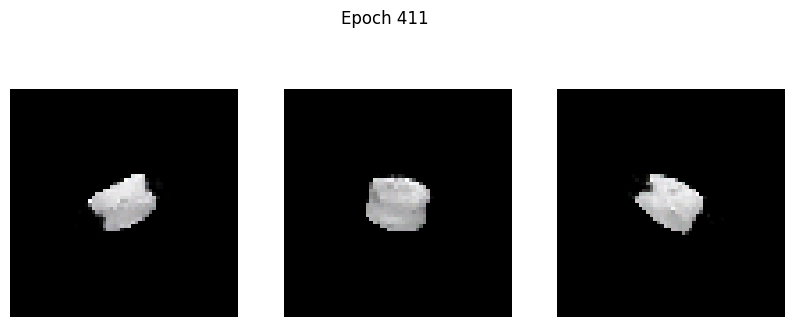

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0070 - g_loss: 5.7632
Epoch 412/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0670 - g_loss: 5.3701

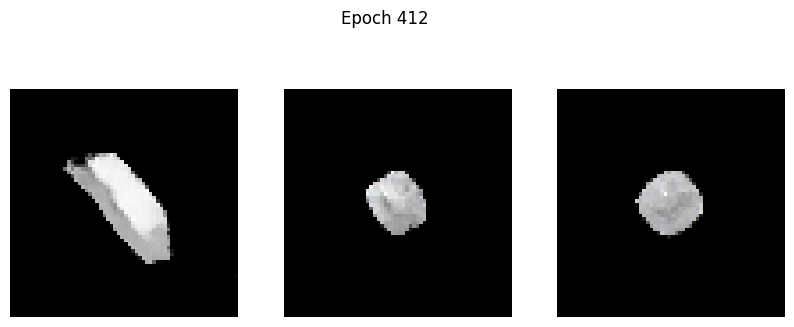

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0669 - g_loss: 5.3708
Epoch 413/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0591 - g_loss: 5.5983

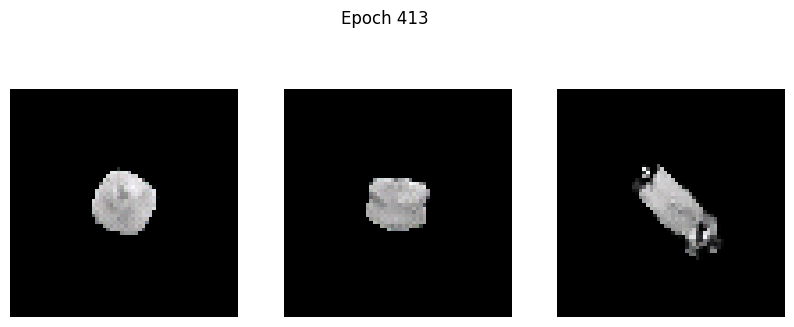

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0589 - g_loss: 5.6003
Epoch 414/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0314 - g_loss: 6.4693

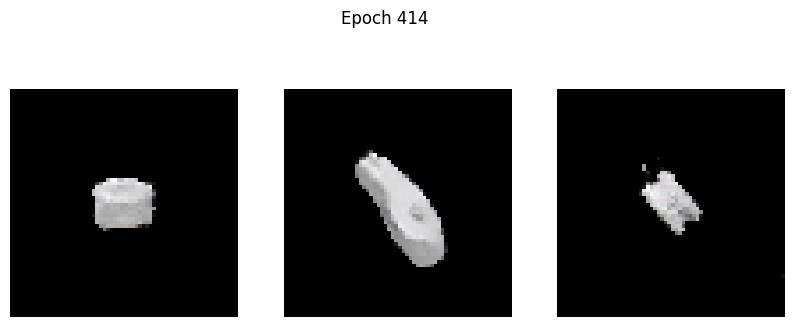

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0314 - g_loss: 6.4701
Epoch 415/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0366 - g_loss: 6.2795

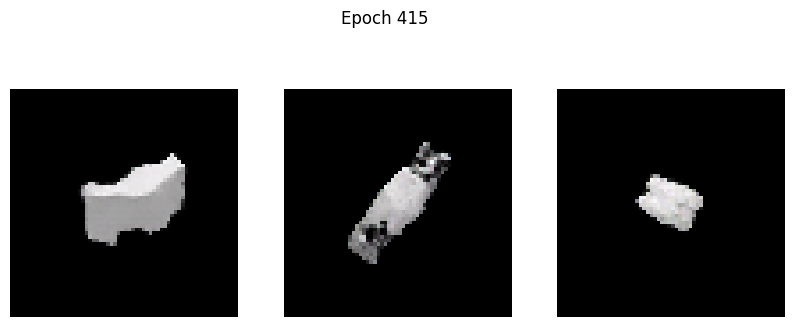

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0364 - g_loss: 6.2792
Epoch 416/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0393 - g_loss: 5.7109

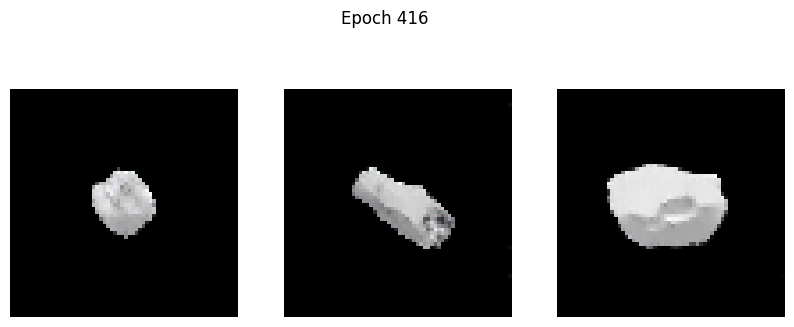

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0389 - g_loss: 5.7148
Epoch 417/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0324 - g_loss: 6.2976

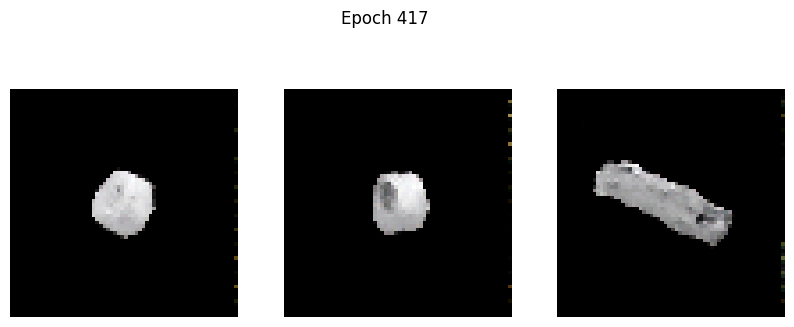

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0322 - g_loss: 6.2967
Epoch 418/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -1.0157e-04 - g_loss: 5.8956

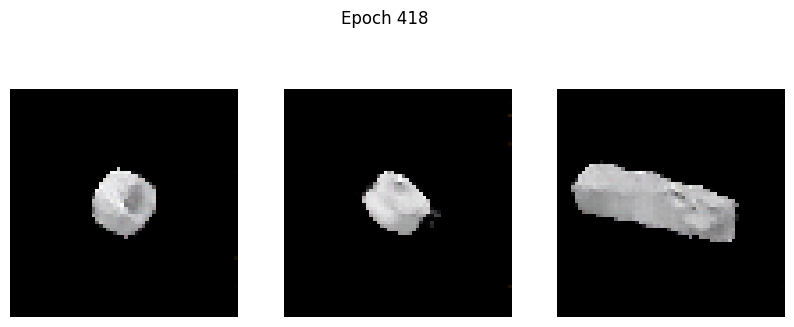

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -2.7677e-05 - g_loss: 5.8983
Epoch 419/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0483 - g_loss: 5.3365

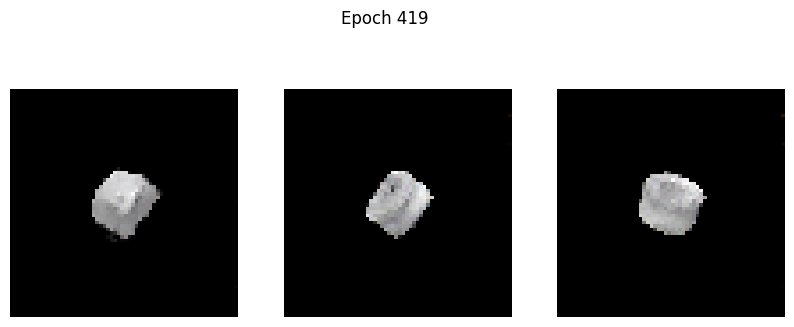

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0480 - g_loss: 5.3374
Epoch 420/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0670 - g_loss: 6.5892

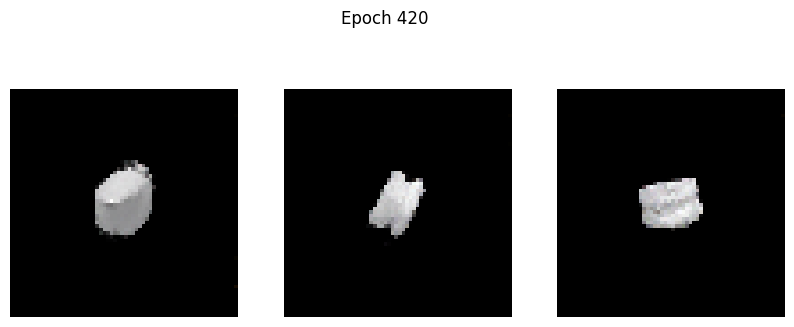

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0666 - g_loss: 6.5855
Epoch 421/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0109 - g_loss: 6.1932

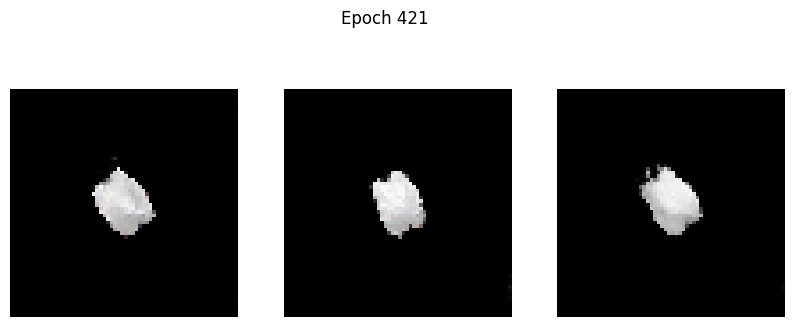

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0110 - g_loss: 6.1903
Epoch 422/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0447 - g_loss: 5.5464

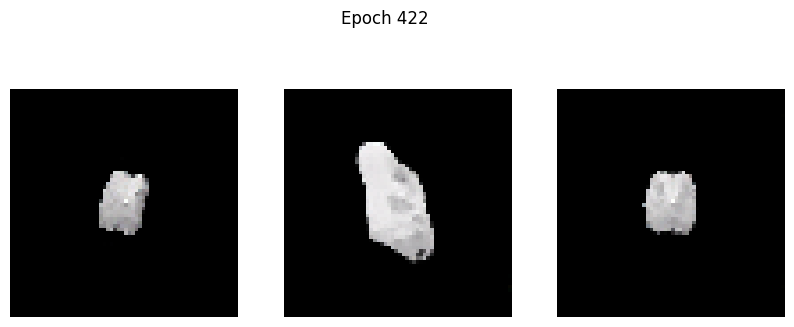

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0447 - g_loss: 5.5472
Epoch 423/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0144 - g_loss: 5.7964

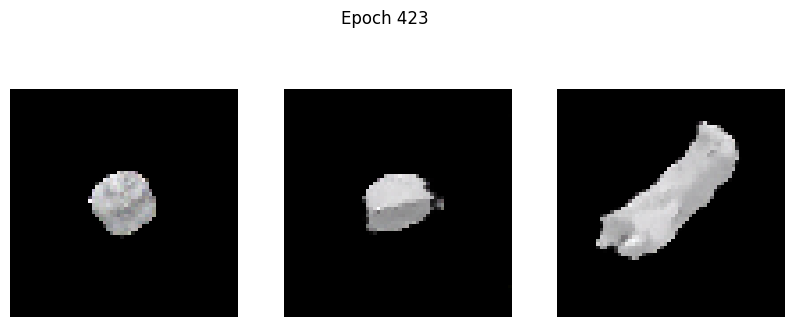

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0145 - g_loss: 5.7957
Epoch 424/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0190 - g_loss: 6.1592

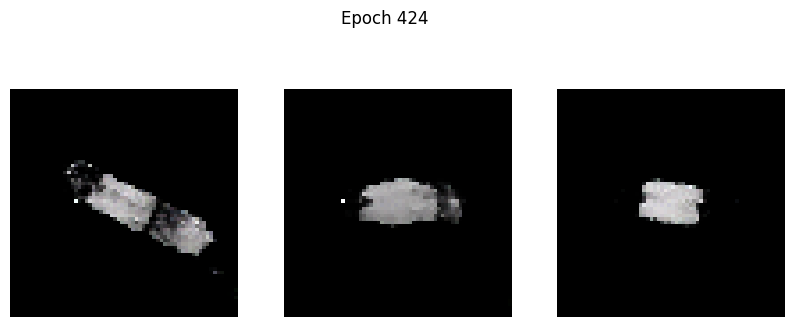

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0190 - g_loss: 6.1573
Epoch 425/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.1268 - g_loss: 7.4794

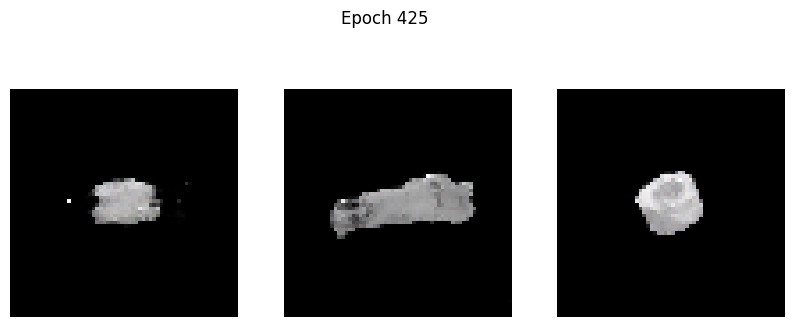

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.1263 - g_loss: 7.4740
Epoch 426/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0297 - g_loss: 6.4183

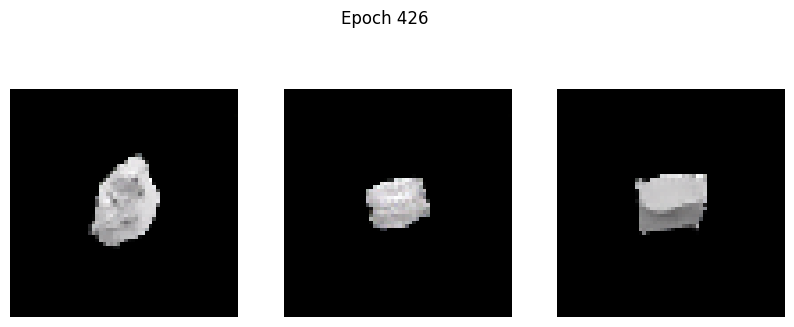

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0297 - g_loss: 6.4180
Epoch 427/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0377 - g_loss: 5.5871

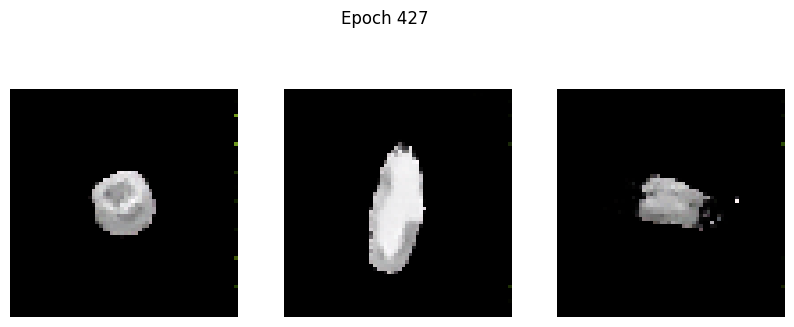

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0378 - g_loss: 5.5879
Epoch 428/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0391 - g_loss: 6.5763

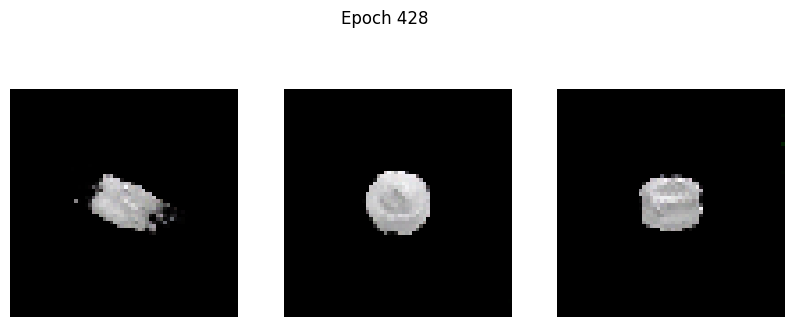

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0389 - g_loss: 6.5742
Epoch 429/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0234 - g_loss: 5.6617

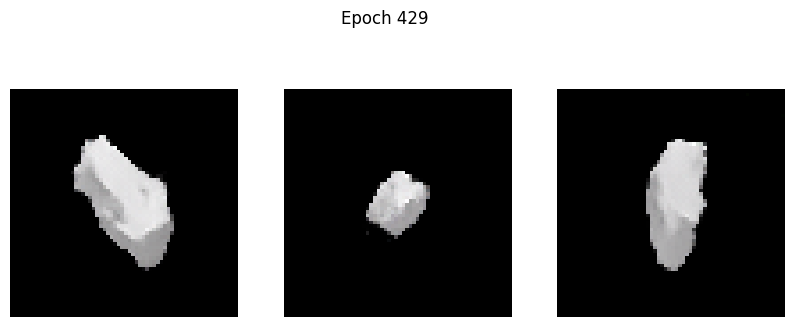

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0235 - g_loss: 5.6624
Epoch 430/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0452 - g_loss: 5.7365

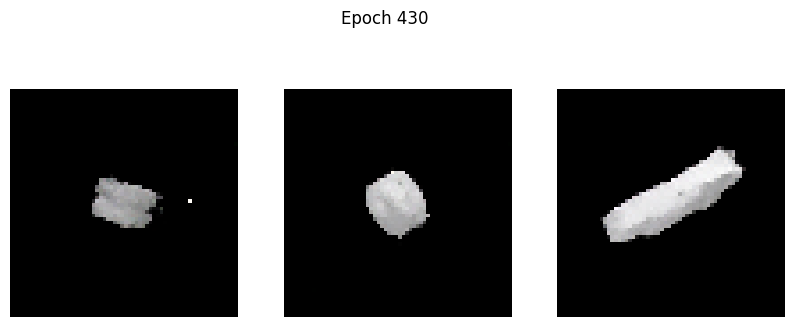

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0452 - g_loss: 5.7385
Epoch 431/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0237 - g_loss: 5.7616

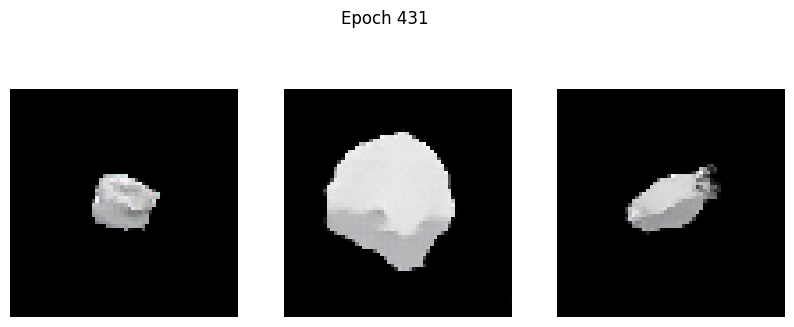

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0236 - g_loss: 5.7623
Epoch 432/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0594 - g_loss: 5.2232

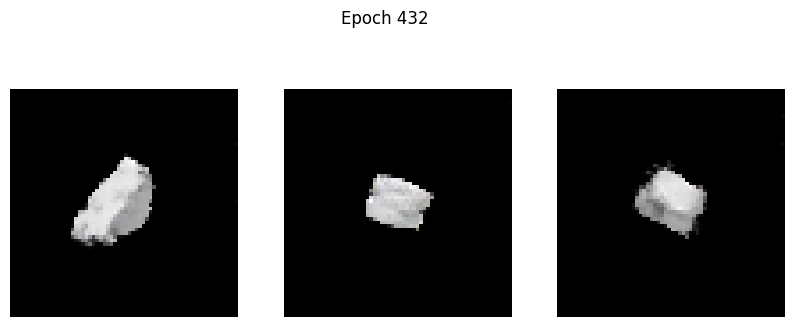

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0597 - g_loss: 5.2237
Epoch 433/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: 0.0139 - g_loss: 6.3471

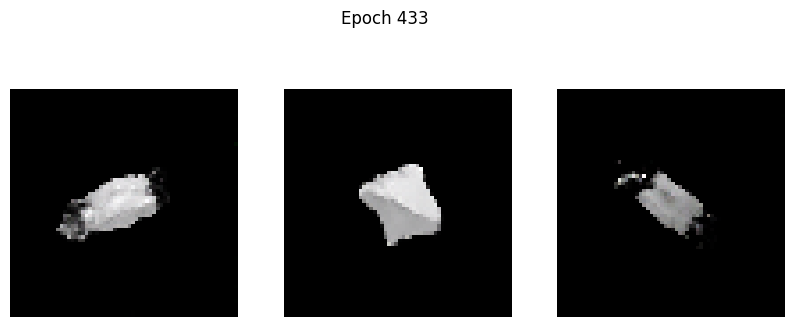

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: 0.0141 - g_loss: 6.3483
Epoch 434/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0194 - g_loss: 6.7878

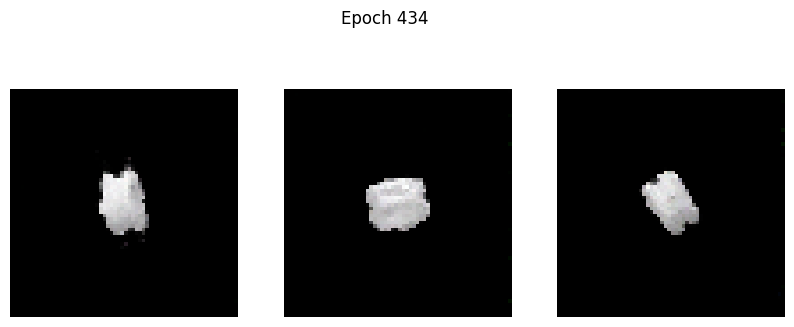

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0192 - g_loss: 6.7827
Epoch 435/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0348 - g_loss: 6.1416

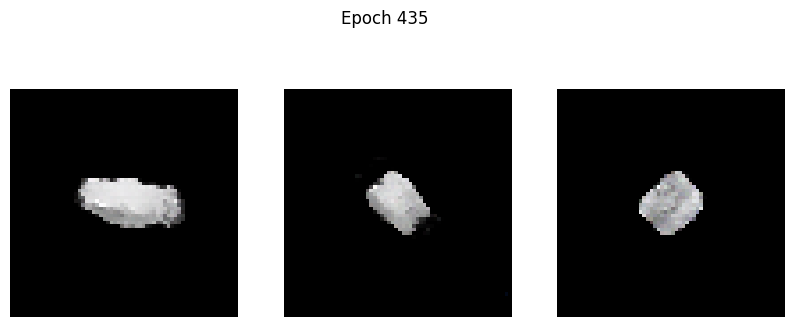

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0342 - g_loss: 6.1447
Epoch 436/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0532 - g_loss: 5.7302

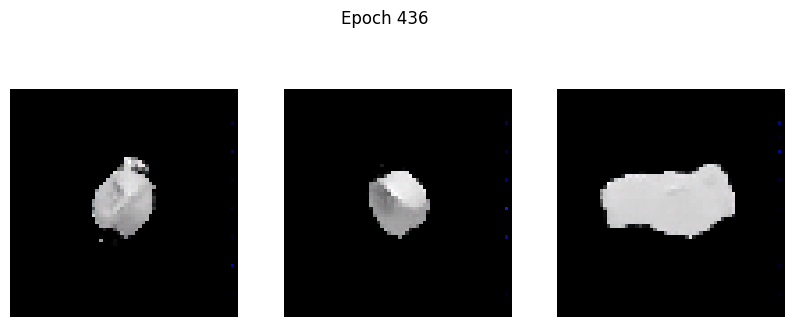

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0531 - g_loss: 5.7316
Epoch 437/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0383 - g_loss: 5.6846

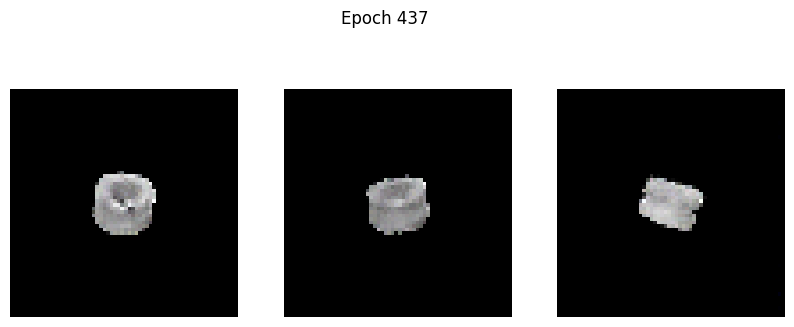

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0375 - g_loss: 5.6902
Epoch 438/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0337 - g_loss: 5.4090

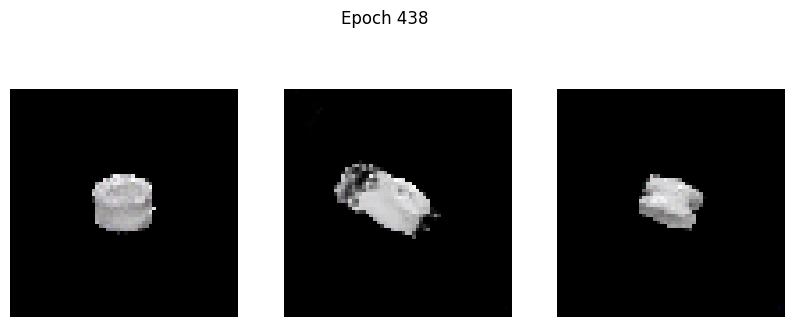

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0339 - g_loss: 5.4118
Epoch 439/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0639 - g_loss: 7.0241

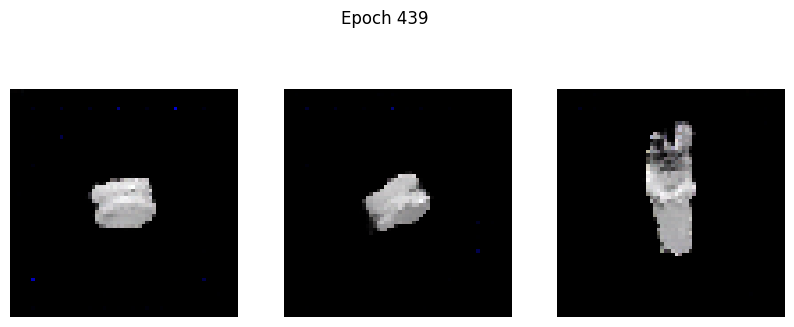

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0635 - g_loss: 7.0211
Epoch 440/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0192 - g_loss: 5.9922

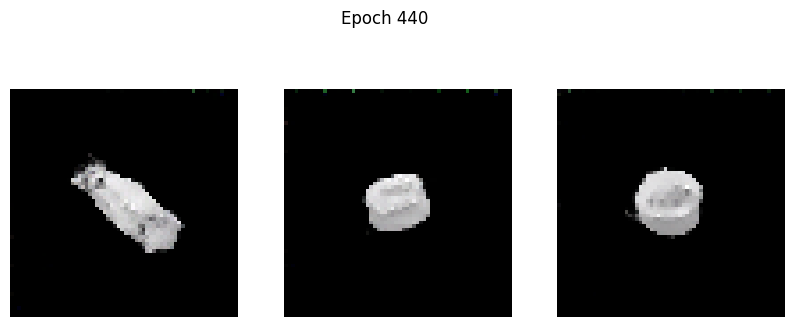

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0195 - g_loss: 5.9917
Epoch 441/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0130 - g_loss: 6.2546

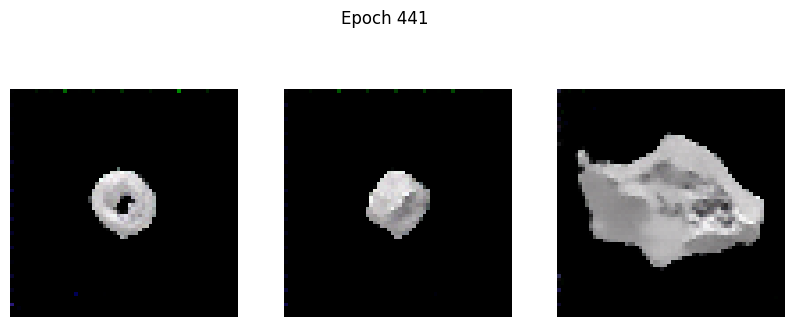

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0128 - g_loss: 6.2570
Epoch 442/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0773 - g_loss: 6.1627

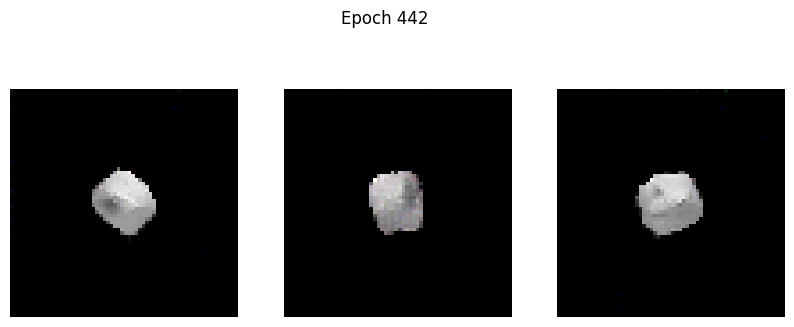

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0772 - g_loss: 6.1607
Epoch 443/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0011 - g_loss: 6.6153

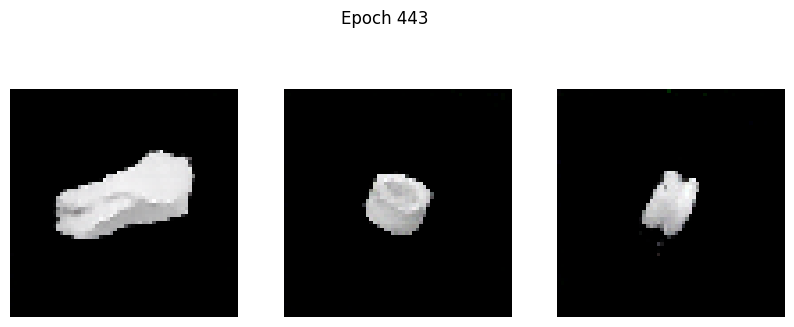

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0012 - g_loss: 6.6135
Epoch 444/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0076 - g_loss: 6.7936

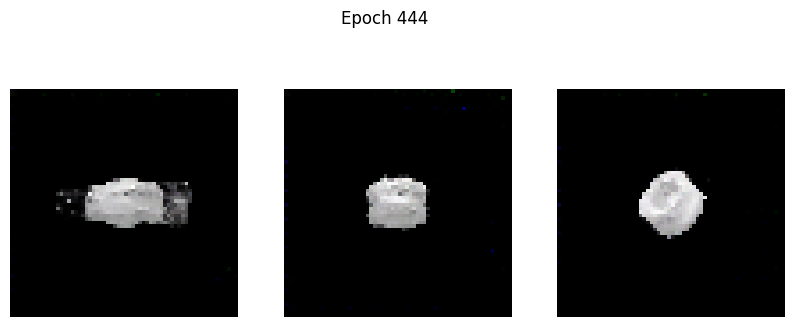

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0070 - g_loss: 6.7867
Epoch 445/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0910 - g_loss: 5.8395

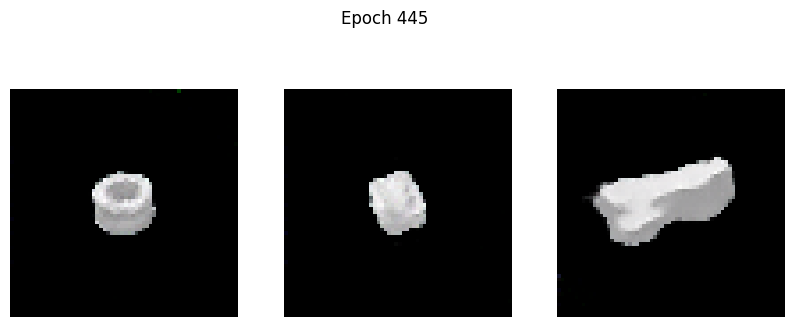

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0909 - g_loss: 5.8422
Epoch 446/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1022 - g_loss: 5.5326

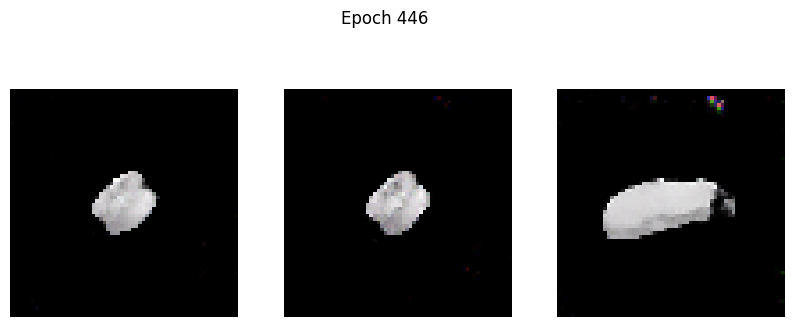

100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 126ms/step - d_loss: -0.1020 - g_loss: 5.5357
Epoch 447/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0798 - g_loss: 6.2567

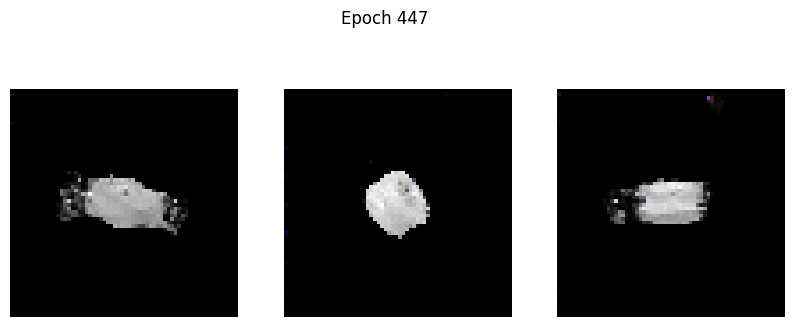

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0793 - g_loss: 6.2623
Epoch 448/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0994 - g_loss: 5.8350

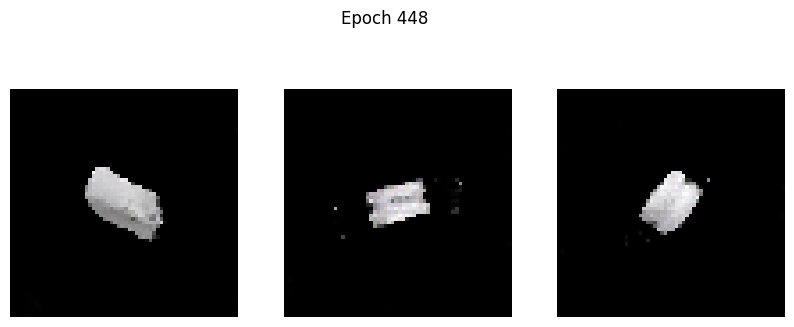

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0991 - g_loss: 5.8376
Epoch 449/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0022 - g_loss: 6.5848

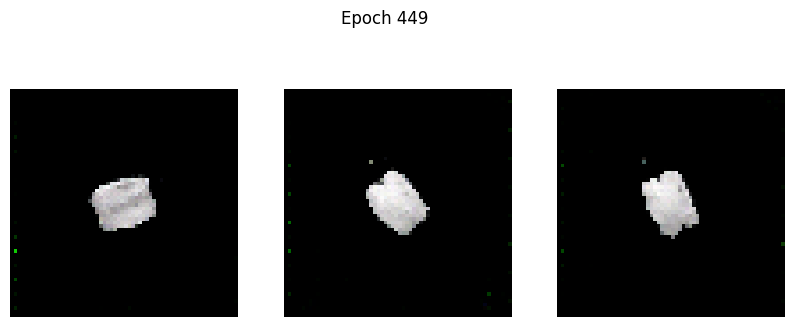

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0023 - g_loss: 6.5870
Epoch 450/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0194 - g_loss: 6.6599

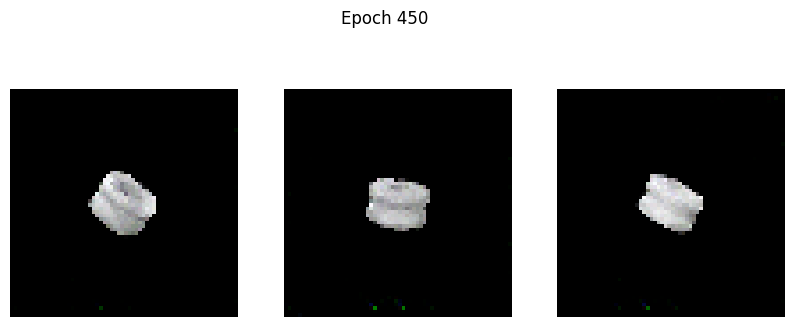

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0195 - g_loss: 6.6564
Epoch 451/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0787 - g_loss: 5.9922

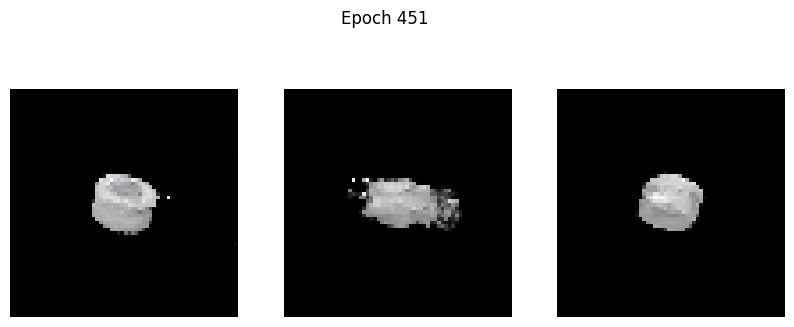

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0786 - g_loss: 5.9948
Epoch 452/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0103 - g_loss: 6.6324

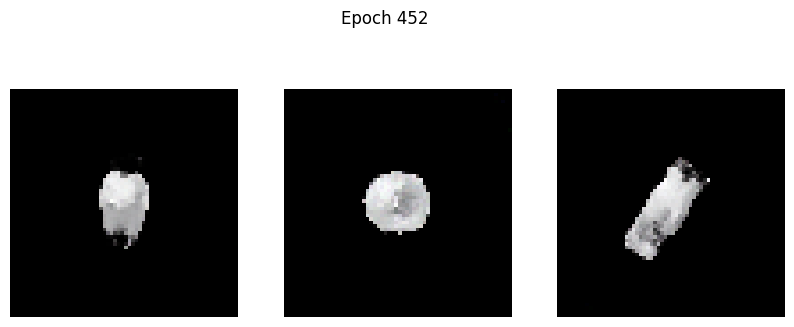

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0110 - g_loss: 6.6269
Epoch 453/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0262 - g_loss: 6.9458

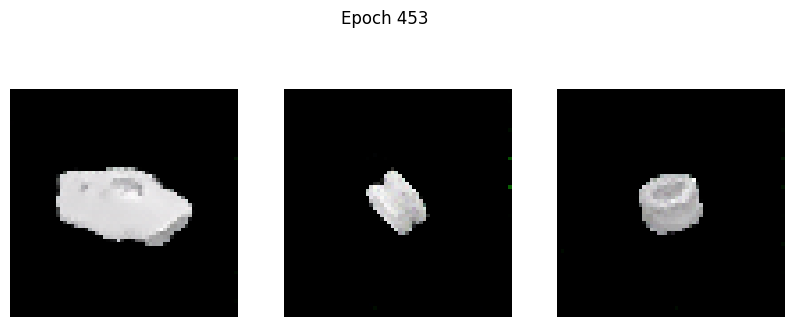

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0259 - g_loss: 6.9474
Epoch 454/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0271 - g_loss: 6.5128

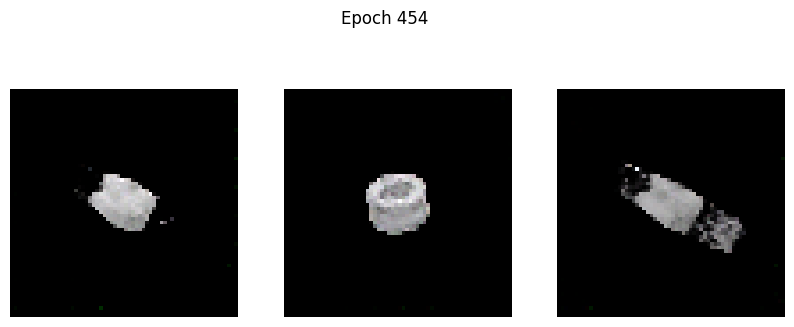

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0275 - g_loss: 6.5108
Epoch 455/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0891 - g_loss: 5.8923

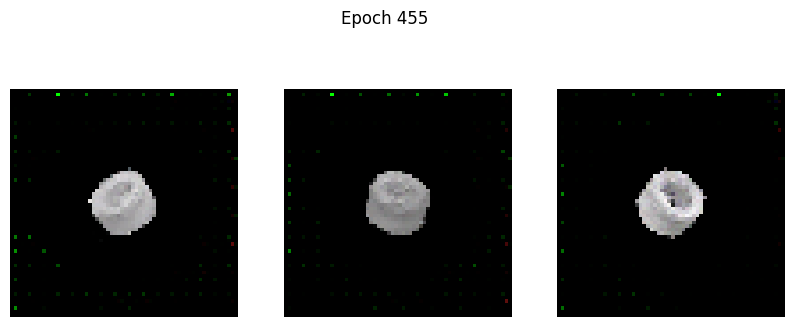

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0891 - g_loss: 5.8937
Epoch 456/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0593 - g_loss: 6.3017

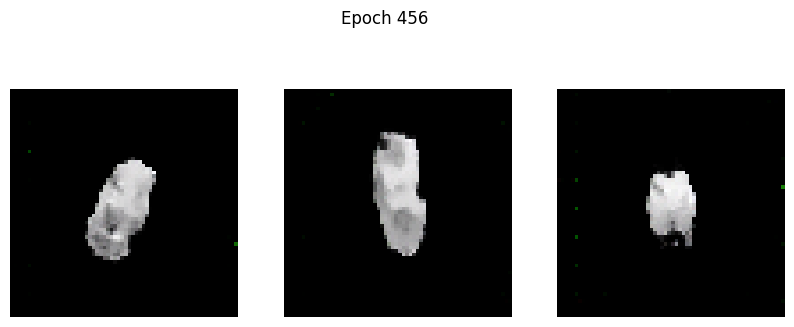

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0591 - g_loss: 6.3025
Epoch 457/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0702 - g_loss: 6.1606

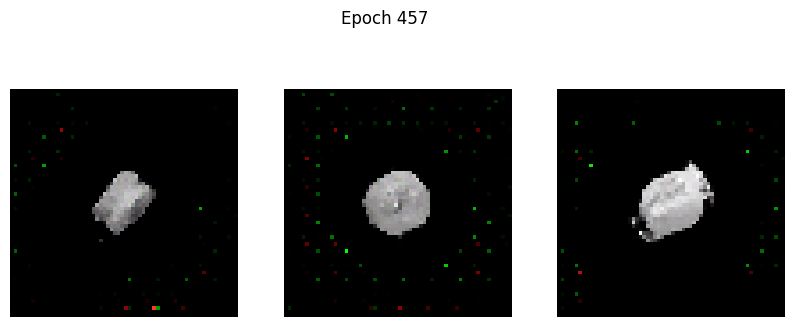

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0701 - g_loss: 6.1644
Epoch 458/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0351 - g_loss: 6.8125

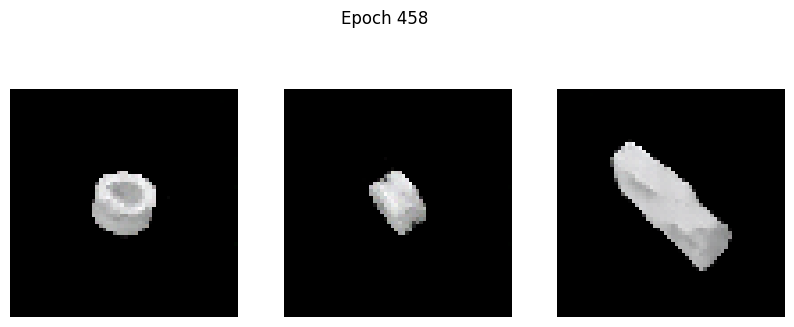

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0349 - g_loss: 6.8111
Epoch 459/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.1139 - g_loss: 5.8638

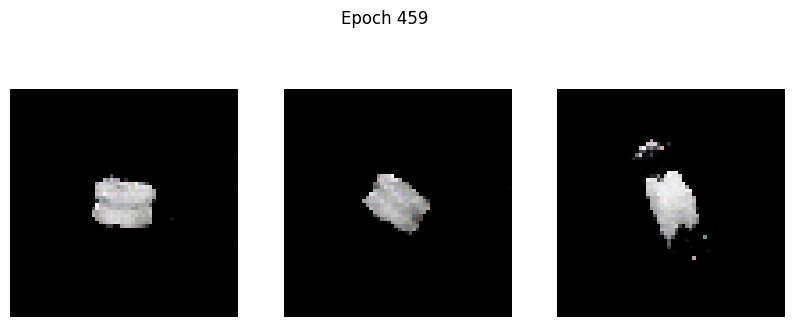

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1135 - g_loss: 5.8672
Epoch 460/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.1312 - g_loss: 5.5443

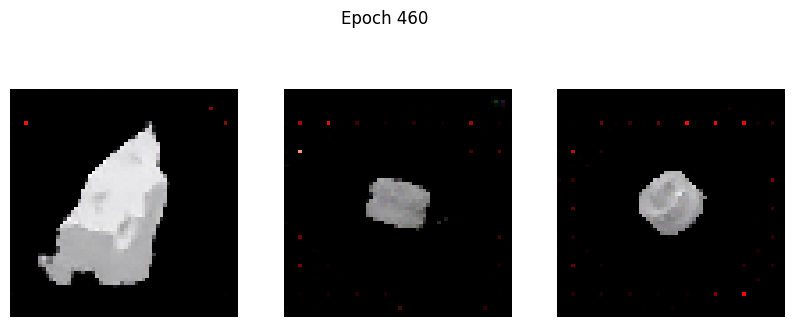

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1308 - g_loss: 5.5484
Epoch 461/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0575 - g_loss: 7.8470

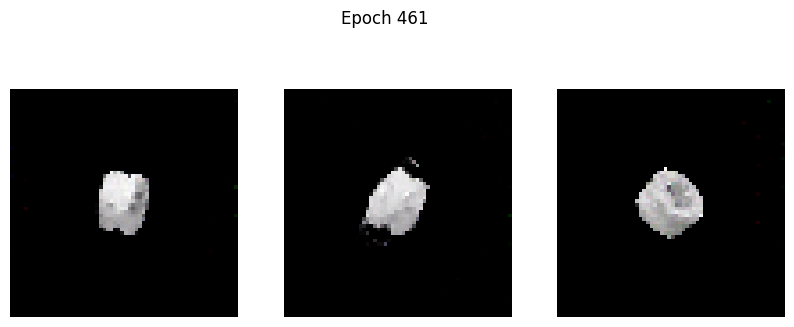

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0567 - g_loss: 7.8357
Epoch 462/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0555 - g_loss: 6.9732

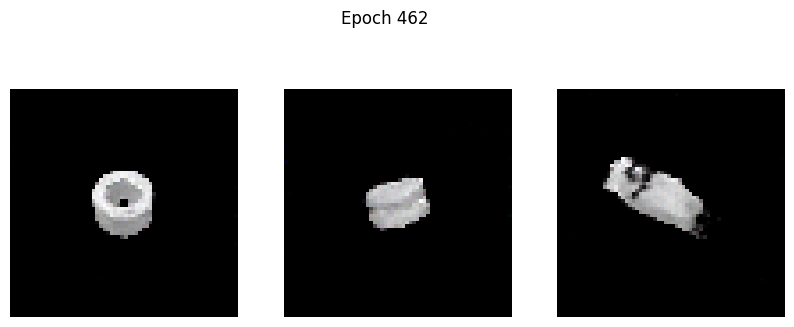

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0553 - g_loss: 6.9727
Epoch 463/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0089 - g_loss: 7.0366

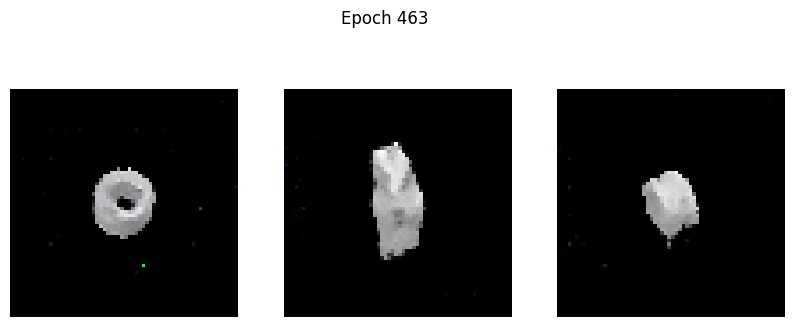

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0089 - g_loss: 7.0348
Epoch 464/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0389 - g_loss: 6.7641

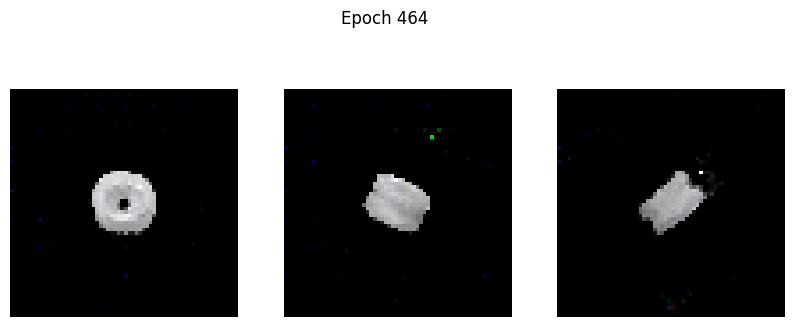

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0391 - g_loss: 6.7634
Epoch 465/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0752 - g_loss: 6.9528

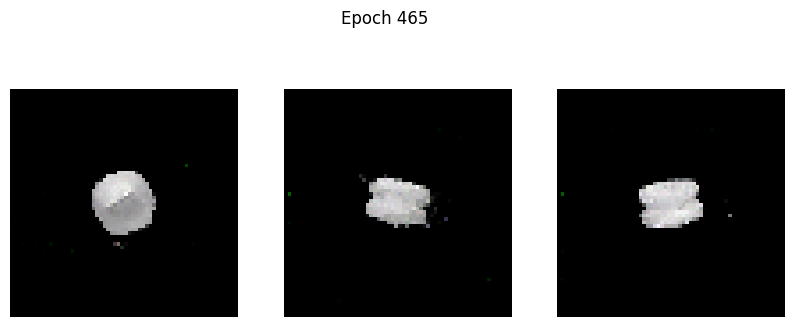

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0756 - g_loss: 6.9443
Epoch 466/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.1224 - g_loss: 5.8610

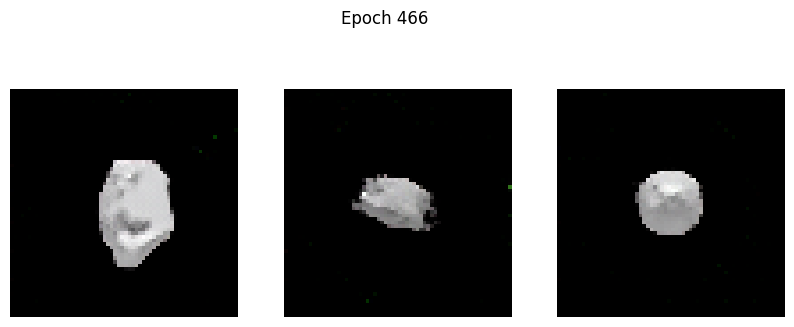

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1217 - g_loss: 5.8683
Epoch 467/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: 0.0511 - g_loss: 7.2372

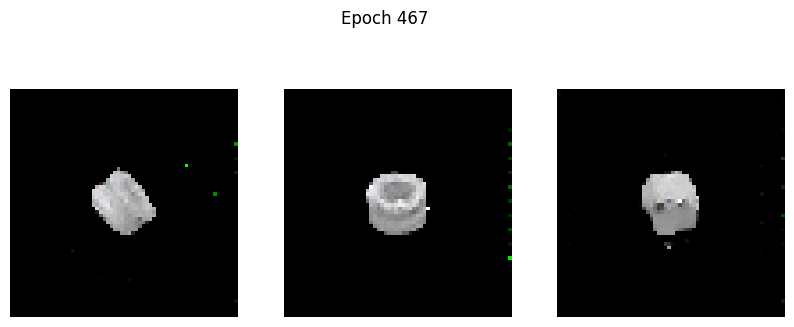

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: 0.0502 - g_loss: 7.2322
Epoch 468/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0105 - g_loss: 7.4406

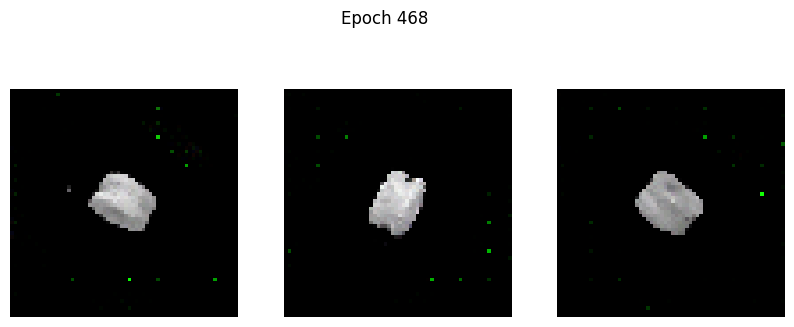

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0108 - g_loss: 7.4370
Epoch 469/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.1669 - g_loss: 6.1262

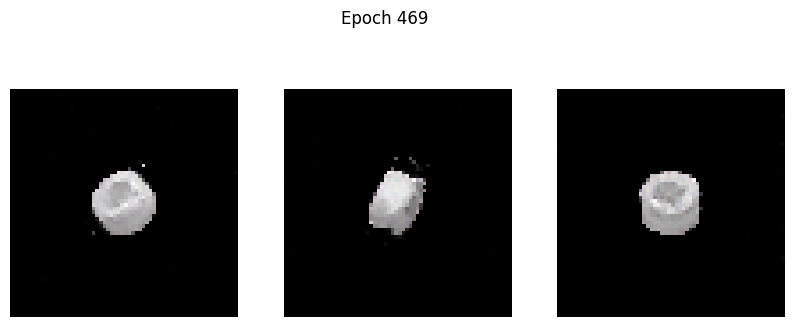

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1663 - g_loss: 6.1302
Epoch 470/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0030 - g_loss: 6.4920

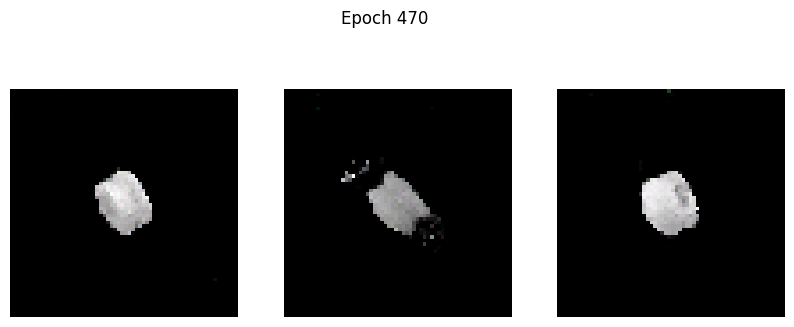

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0039 - g_loss: 6.4893
Epoch 471/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1176 - g_loss: 6.6769

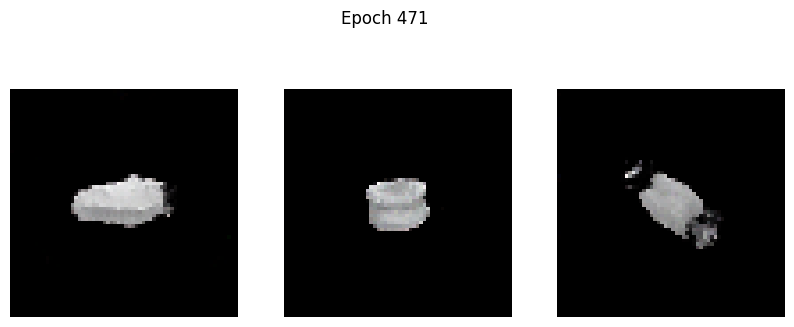

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1176 - g_loss: 6.6750
Epoch 472/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0886 - g_loss: 6.7851

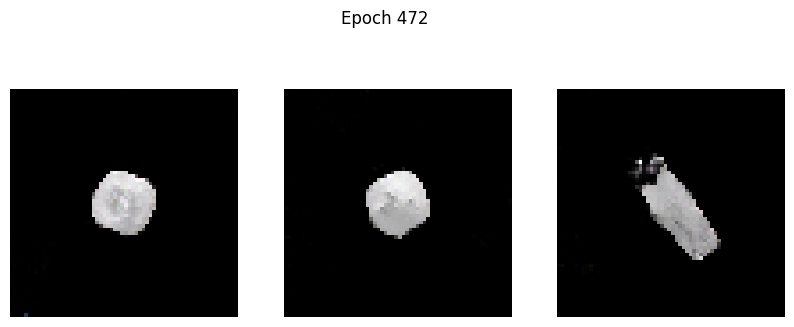

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0884 - g_loss: 6.7869
Epoch 473/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.1056 - g_loss: 6.9967

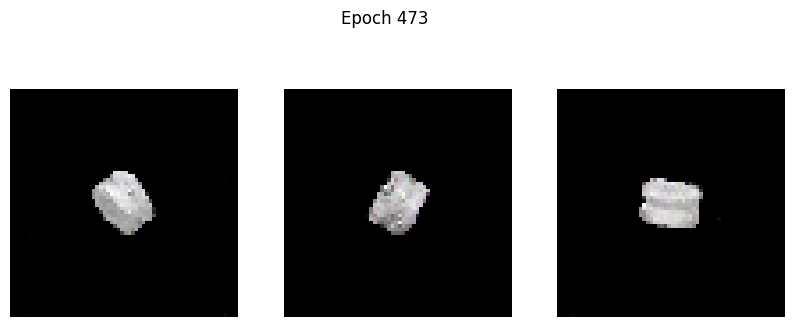

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.1056 - g_loss: 6.9952
Epoch 474/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0788 - g_loss: 6.8361

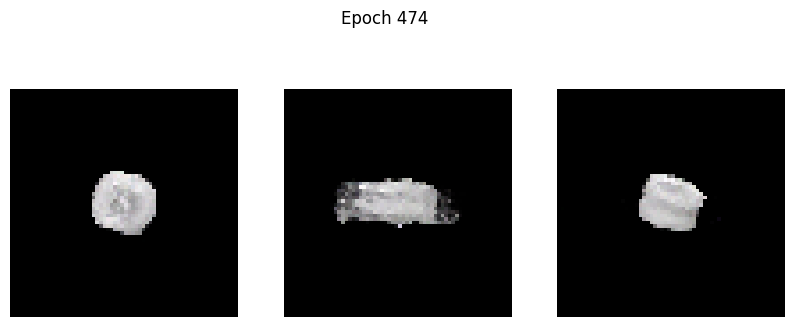

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0788 - g_loss: 6.8365
Epoch 475/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.0900 - g_loss: 6.4549

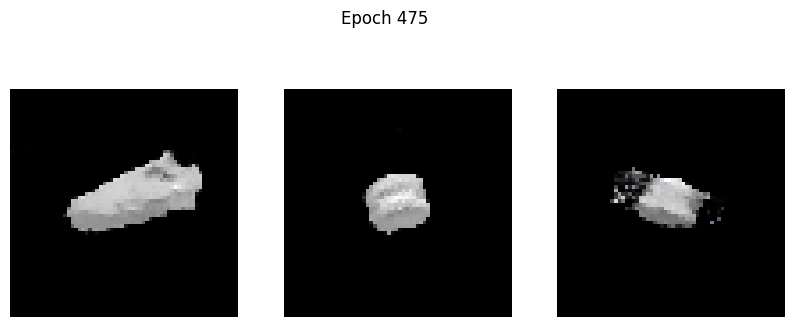

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.0905 - g_loss: 6.4542
Epoch 476/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0643 - g_loss: 6.9338

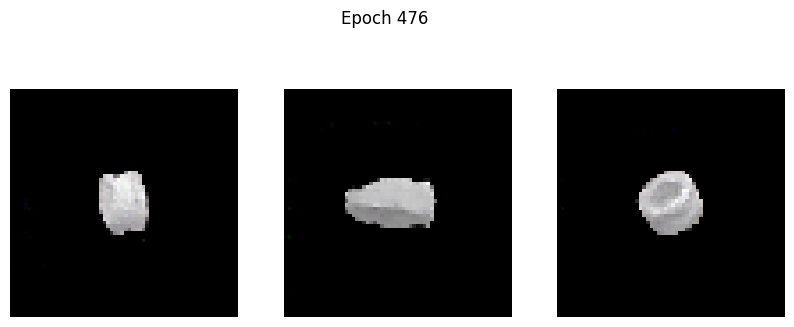

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0648 - g_loss: 6.9291
Epoch 477/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1550 - g_loss: 6.2672

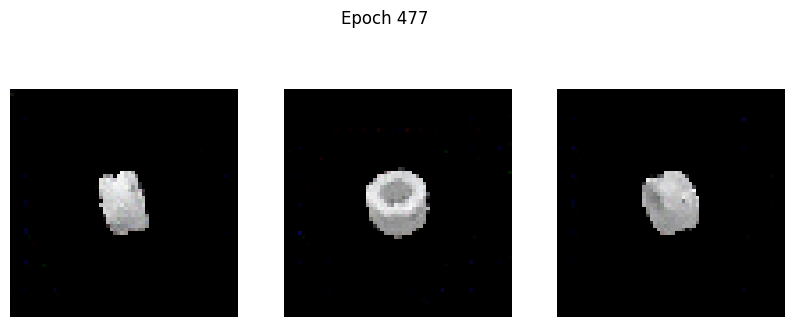

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1545 - g_loss: 6.2737
Epoch 478/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1068 - g_loss: 7.2409

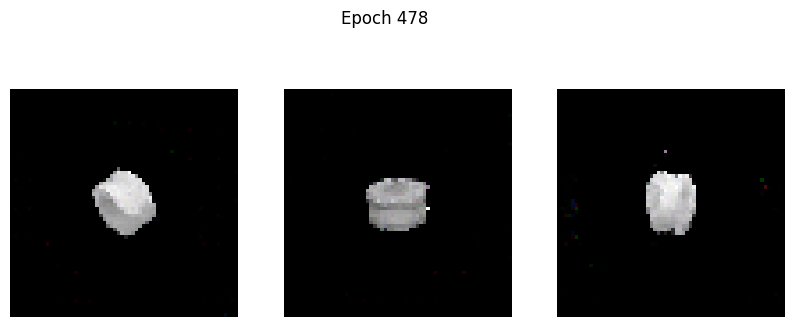

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1068 - g_loss: 7.2399
Epoch 479/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0178 - g_loss: 8.2689

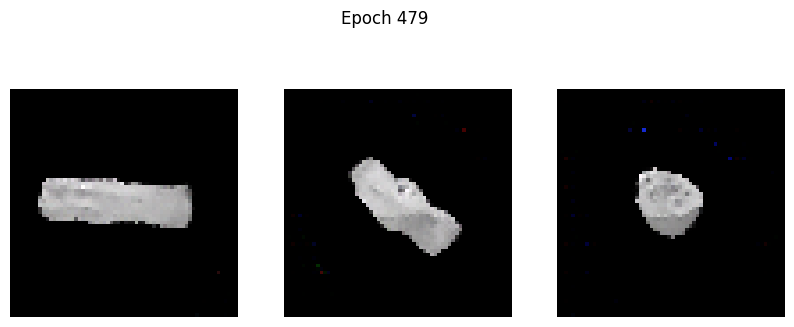

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0172 - g_loss: 8.2621
Epoch 480/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1659 - g_loss: 7.0983

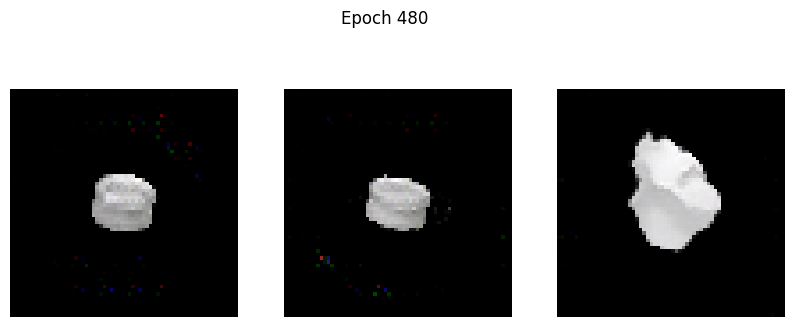

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1658 - g_loss: 7.0967
Epoch 481/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: 0.0068 - g_loss: 7.8141

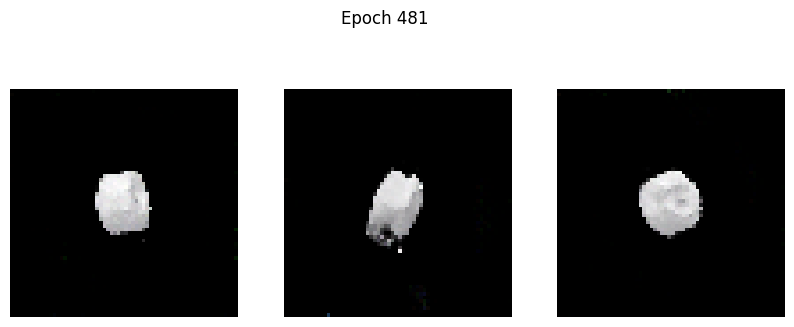

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: 0.0060 - g_loss: 7.8108
Epoch 482/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0324 - g_loss: 6.4460

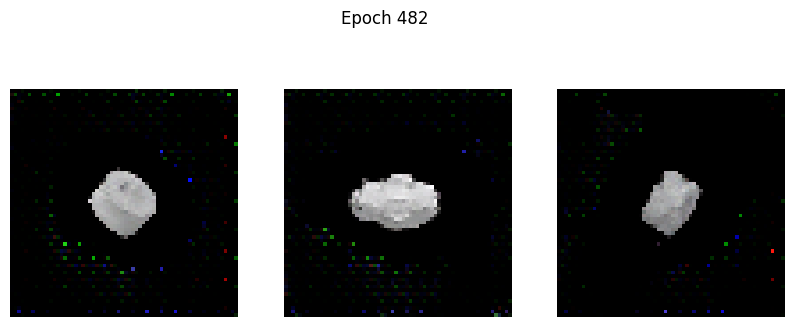

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0332 - g_loss: 6.4474
Epoch 483/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1581 - g_loss: 6.8290

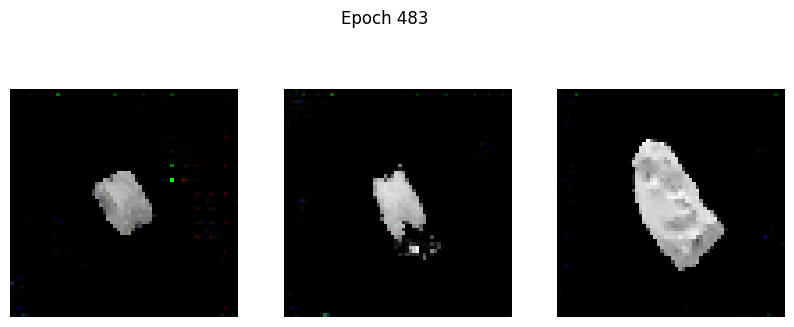

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1576 - g_loss: 6.8299
Epoch 484/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1761 - g_loss: 6.8648

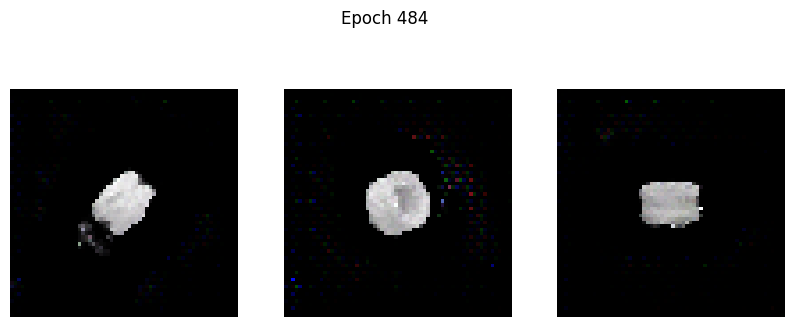

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1759 - g_loss: 6.8660
Epoch 485/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0726 - g_loss: 7.3073

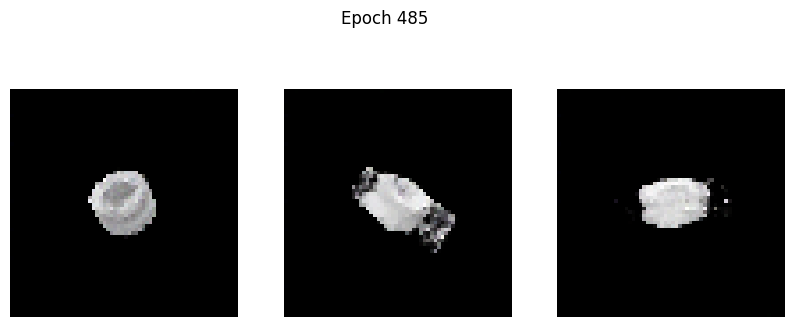

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0731 - g_loss: 7.3064
Epoch 486/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0226 - g_loss: 8.3395

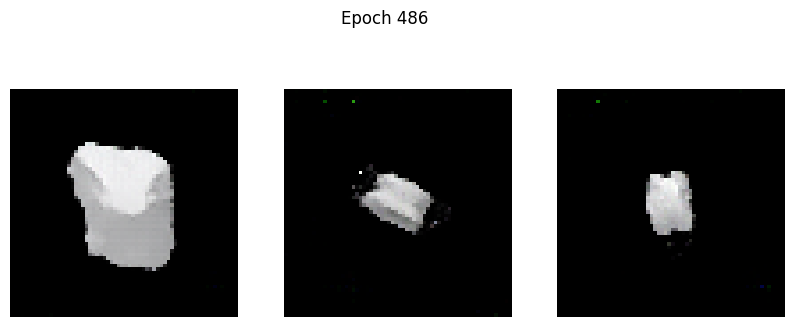

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0230 - g_loss: 8.3359
Epoch 487/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1888 - g_loss: 6.9703

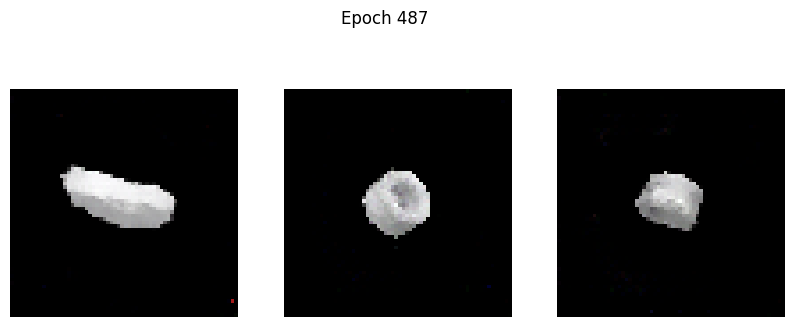

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1880 - g_loss: 6.9770
Epoch 488/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0811 - g_loss: 7.1564

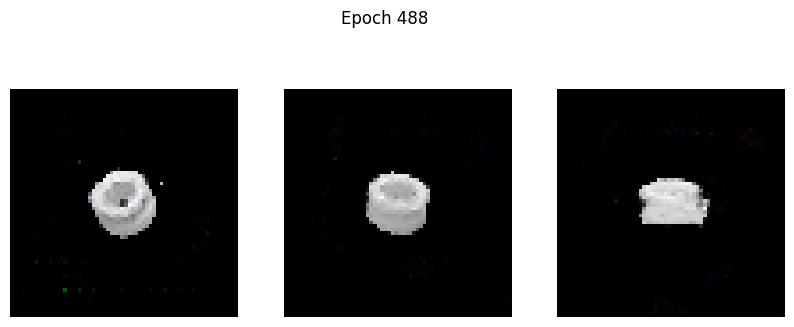

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0820 - g_loss: 7.1520
Epoch 489/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.2199 - g_loss: 6.4603

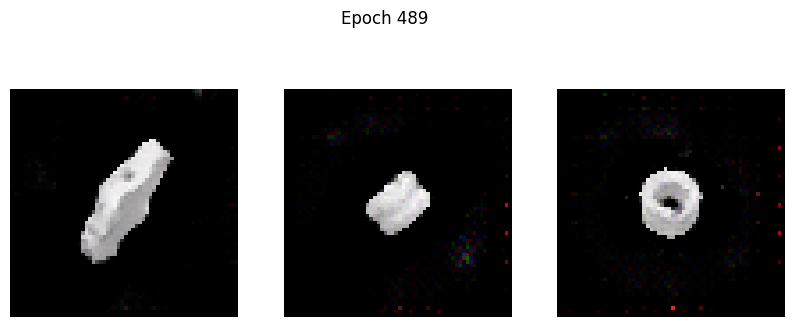

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.2195 - g_loss: 6.4644
Epoch 490/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.0683 - g_loss: 8.0518

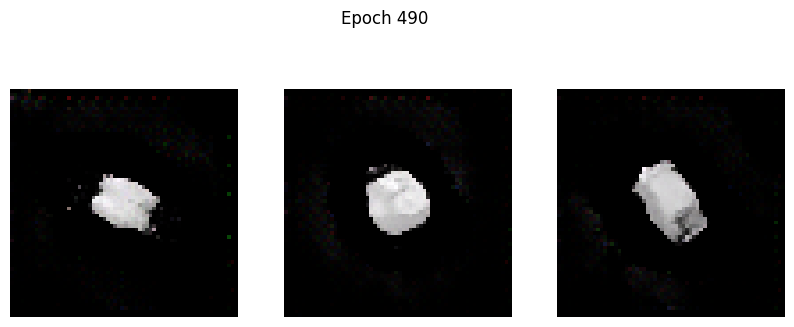

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.0683 - g_loss: 8.0507
Epoch 491/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1833 - g_loss: 6.7785

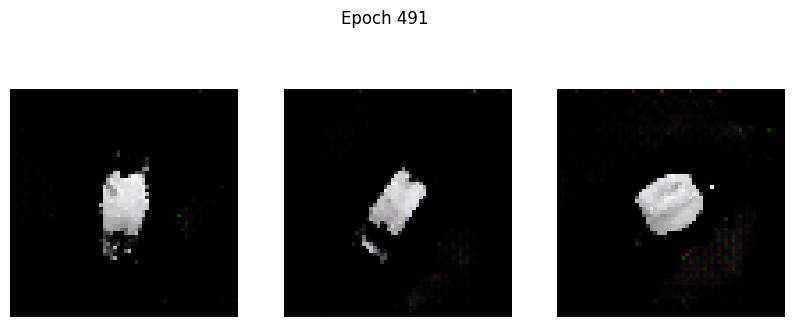

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1832 - g_loss: 6.7796
Epoch 492/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.2057 - g_loss: 7.2061

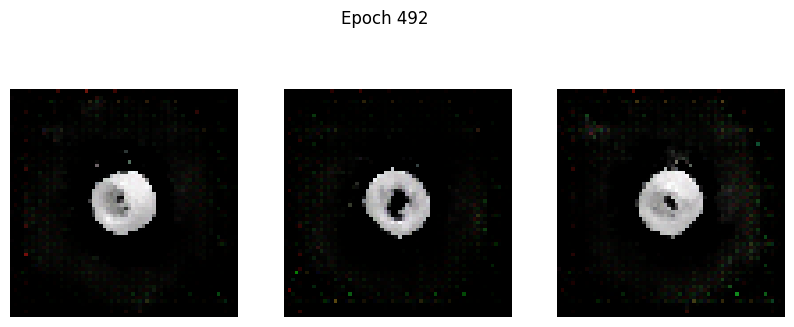

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.2057 - g_loss: 7.2042
Epoch 493/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - d_loss: -0.1247 - g_loss: 7.9714

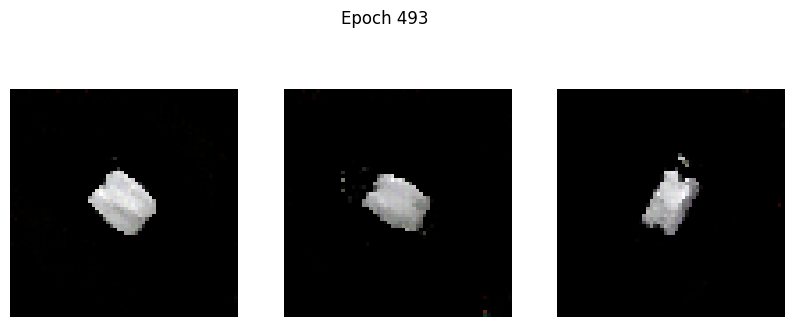

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - d_loss: -0.1248 - g_loss: 7.9725
Epoch 494/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.0463 - g_loss: 15.5717

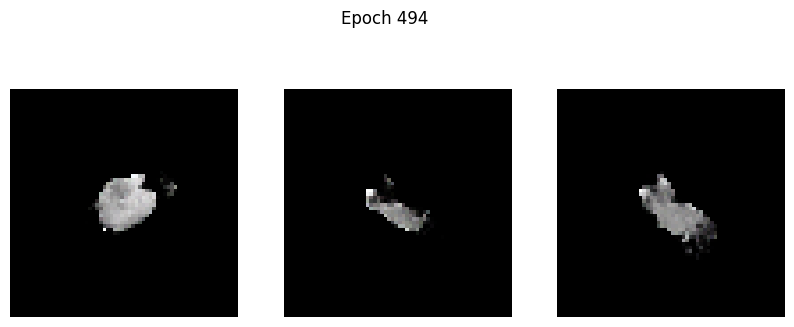

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.0487 - g_loss: 15.5410
Epoch 495/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.5240 - g_loss: 8.5334

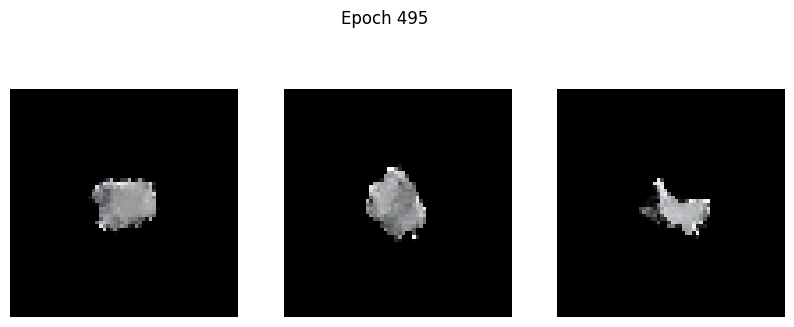

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.5237 - g_loss: 8.5366
Epoch 496/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.3615 - g_loss: 10.2887

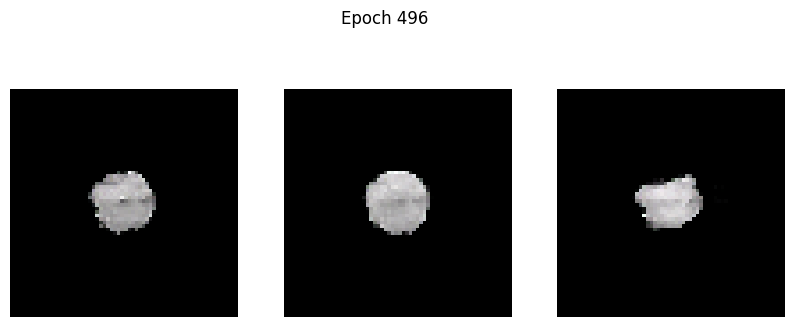

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.3608 - g_loss: 10.3000
Epoch 497/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.3761 - g_loss: 8.1499

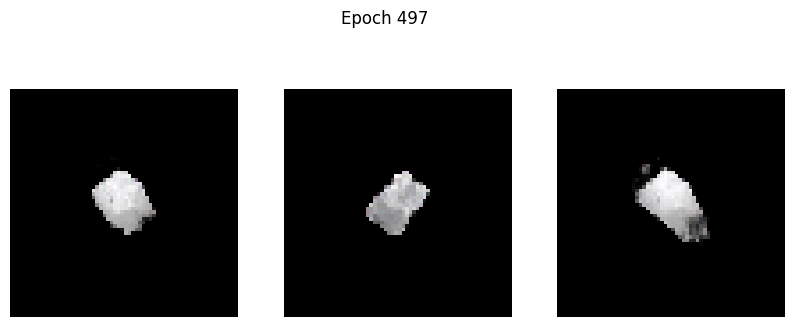

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.3759 - g_loss: 8.1512
Epoch 498/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.3066 - g_loss: 8.0812

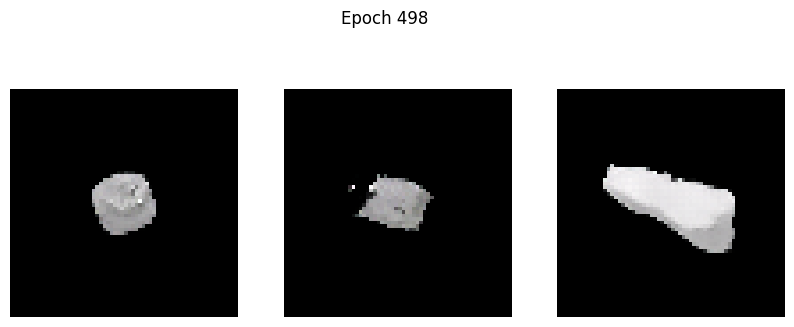

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.3068 - g_loss: 8.0775
Epoch 499/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - d_loss: -0.3090 - g_loss: 7.5067

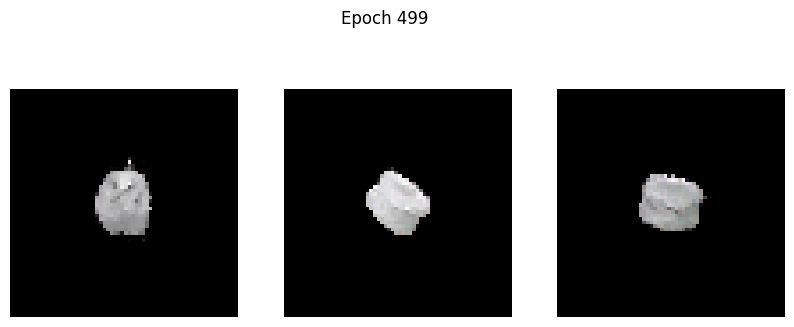

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 123ms/step - d_loss: -0.3086 - g_loss: 7.5161
Epoch 500/500
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - d_loss: -0.2851 - g_loss: 8.6511

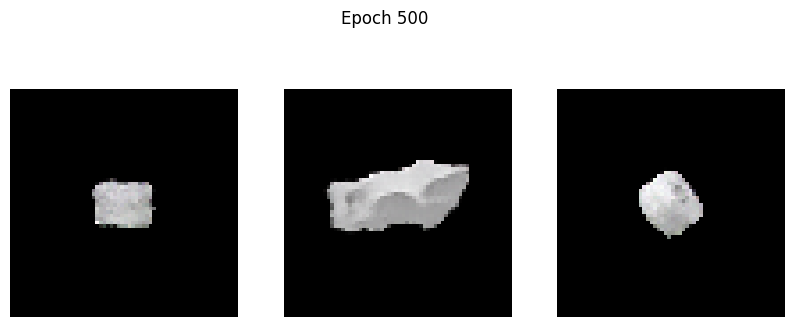

100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - d_loss: -0.2844 - g_loss: 8.6550


In [ ]:
EPOCHS = 500
lr_generator = 0.0002
lr_discriminator = 0.0002

dcgan = DCGAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

dcgan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=lr_discriminator, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=lr_generator, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

print("Mulai Training...")
dcgan.fit(
    train_dataset,
    epochs=EPOCHS,
    callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

In [ ]:


# Save the trained generator model
# Gunakan objek generator yang ada di dalam dcgan
dcgan.generator.save("generator_model.keras")
print("✅ Generator model saved successfully as 'generator_model.keras'")

✅ Generator model saved successfully as 'generator_model.keras'



--- Generasi 5 Gambar dari Noise Acak Selesai ---


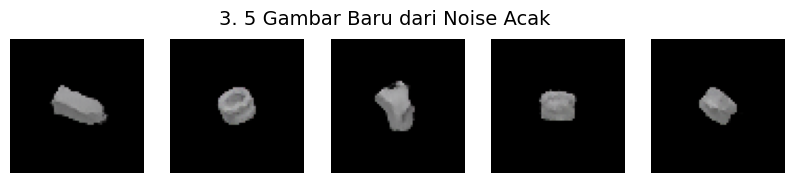

In [ ]:
#Generate 5 Gambar Baru (Noise Acak)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Asumsi: dcgan dan latent_dim sudah didefinisikan dari sesi Colab Anda
generator = dcgan.generator
generator.trainable = False
num_generate = 5

# Buat 5 vektor noise acak
noise = tf.random.normal(shape=(num_generate, latent_dim))

# Generate gambar
random_generated_images = generator(noise, training=False)
print("\n--- Generasi 5 Gambar dari Noise Acak Selesai ---")

# --- Visualisasi Hasil ---
def plot_images(images, title):
    # Normalisasi output dari [-1, 1] ke [0, 1] (asumsi output tanh)
    images = (images * 0.5) + 0.5

    n = images.shape[0]
    plt.figure(figsize=(10, 2))
    plt.suptitle(title, fontsize=14)

    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        # Handle format gambar (Grayscale atau RGB)
        img = images[i].numpy() if isinstance(images[i], tf.Tensor) else images[i]
        if img.ndim == 4 and img.shape[-1] == 1:
            img = img.squeeze(-1)
            plt.imshow(img, cmap='gray')
        elif img.ndim == 3 and img.shape[-1] == 1:
            img = img.squeeze(-1)
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)

        plt.axis("off")
    plt.show()

plot_images(random_generated_images, "3. 5 Gambar Baru dari Noise Acak")


--- Latent Space Interpolation ---
Generasi 5 Gambar dari Latent Space Interpolation Selesai.


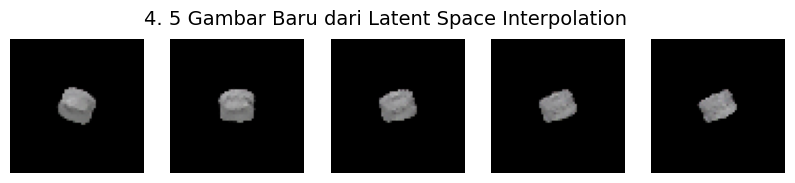

In [ ]:
#Latent Space Interpolation (5 Gambar Baru)
# --- 4. Generate 5 gambar baru menggunakan Latent Space Interpolation ---
print("\n--- Latent Space Interpolation ---")
num_interp_steps = 5

# 1. Pilih dua titik noise acak (Z_A dan Z_B)
Z_A = tf.random.normal(shape=(1, latent_dim))
Z_B = tf.random.normal(shape=(1, latent_dim))

interpolation_vectors = []

# 2. Buat 5 langkah interpolasi linier (0 <= alpha <= 1)
for i in range(num_interp_steps):
    alpha = i / (num_interp_steps - 1)
    # Formula Linear Interpolation: Z_interp = (1 - alpha) * Z_A + alpha * Z_B
    Z_interp = (1.0 - alpha) * Z_A + alpha * Z_B
    interpolation_vectors.append(Z_interp)

# Gabungkan semua vektor interpolasi
interp_noise = tf.concat(interpolation_vectors, axis=0)

# 3. Generate gambar dari vektor interpolasi
interpolated_images = generator(interp_noise, training=False)
print("Generasi 5 Gambar dari Latent Space Interpolation Selesai.")


# --- Visualisasi Hasil ---
plot_images(interpolated_images, "4. 5 Gambar Baru dari Latent Space Interpolation")